In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (20.0, 9.0)
import warnings
warnings.filterwarnings('ignore')

## Q1 Performance analysis of hedge fund returns using linear regression.
### (a) Download and import the following data into your Jupyter notebook:

* **Monthly data of the Fama-French 5 Factor model** from Ken French’s data library. 
* **Monthly returns from Yahoo Finance for the AQR Equity Market Neutral Fund Class I (Ticker: QMNIX)**. Make sure you get the series that is adjusted for both dividends and splits (i.e. the series marked “Adj Close” on Yahoo Finance).

**Note**: 
- Yahoo Finance will provide you with prices. Hence you will have to compute returns yourself.
- Use the longest time period you can find where all data series are available.

In [2]:
# web scraping
import pandas_datareader.data as web
df_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start = '1963-07-01', end = '2020-08-01')[0]
df_factors['Mkt-RF'] = df_factors['Mkt-RF'] + df_factors['RF']
df_factors.rename(columns={'Mkt-RF':'MktRet'},inplace=True)
df_factors = df_factors.to_timestamp()
start_date_factors = df_factors.index[0]
end_date_factors = df_factors.index[-1]

df_factors_withRF = df_factors.copy()
df_factors.drop(columns='RF', inplace=True)
df_factors

MktRet   SMB   HML   RMW   CMA
Date                                      
1963-07-01   -0.12 -0.45 -0.94  0.66 -1.15
1963-08-01    5.32 -0.82  1.82  0.40 -0.40
1963-09-01   -1.30 -0.48  0.17 -0.76  0.24
1963-10-01    2.82 -1.30 -0.04  2.75 -2.24
1963-11-01   -0.58 -0.85  1.70 -0.45  2.22
...            ...   ...   ...   ...   ...
2020-04-01   13.65  2.79 -1.39  2.51 -1.03
2020-05-01    5.59  1.93 -5.05  0.71 -3.28
2020-06-01    2.47  1.94 -2.35  0.03  0.34
2020-07-01    5.78 -3.03 -1.39  0.55  1.06
2020-08-01    7.64 -0.94 -2.94  4.27 -1.44

[686 rows x 5 columns]

In [3]:
# web scraping
# Monthly returns from Yahoo Finance for the AQR Equity Market Neutral Fund Class I 
# (Ticker: QMNIX)

import yfinance as yf
data = yf.download('QMNIX', period = 'max', progress=False, interval='1mo')
QMNIX = data[['Adj Close']].dropna()

def price2ret(prices, retType='simple'):
    ''' Convert price to return
    Args
    ----------
    prices: pd.DataFrame
    retype: str
        arithmetic return, p2/p1 - 1, same as pct_change()
        logarithmetic return, log(p2/p1)
    
    Returns
    ----------
    return: pd.DataFrame
    
    '''
    price_df = prices.copy()
    if retType == 'simple':
        ret = (price_df/price_df.shift(1))-1
    else: 
        ret = np.log(price_df/price_df.shift(1))
    price_df['Return'] = ret
    return price_df.dropna()[['Return']]

df_AQR_return = price2ret(QMNIX)
start_date_hf = df_AQR_return.index[0]
end_date_hf = df_AQR_return.index[-1]
df_AQR_return

Return
Date                
2014-11-01  0.025666
2014-12-01 -0.036574
2015-01-01  0.156134
2015-02-01 -0.007767
2015-03-01  0.004892
...              ...
2020-06-01  0.020177
2020-07-01 -0.018541
2020-08-01 -0.012594
2020-09-01  0.001275
2020-10-01 -0.002548

[72 rows x 1 columns]

### (b) Create scatter plots and compute summary statistics of all data series (mean, std, skew, kurtosis, max, min, correlation matrix). Discuss your conclusions and any noteworthy results after visualizing and exploring the data. 

##### Summary Statistics of Fama-French Data:

In [4]:
df_factors.agg(['mean','std','skew','kurtosis','max','min']) # large variations

MktRet        SMB        HML        RMW       CMA
mean       0.929271   0.207595   0.254942   0.260000  0.259534
std        4.435350   3.014687   2.872401   2.167372  1.992396
skew      -0.519876   0.337433   0.009682  -0.342250  0.313613
kurtosis   1.953194   3.069454   2.434476  12.465048  1.623665
max       16.610000  18.050000  12.600000  13.380000  9.560000
min      -22.640000 -14.860000 -14.110000 -18.480000 -6.860000

In [5]:
df_factors.corr() # no high correlation

MktRet       SMB       HML       RMW       CMA
MktRet  1.000000  0.285025 -0.220906 -0.201945 -0.376943
SMB     0.285025  1.000000 -0.038588 -0.336787 -0.104220
HML    -0.220906 -0.038588  1.000000  0.080233  0.684600
RMW    -0.201945 -0.336787  0.080233  1.000000 -0.025316
CMA    -0.376943 -0.104220  0.684600 -0.025316  1.000000

Text(0.5, 1.0, 'CMA')

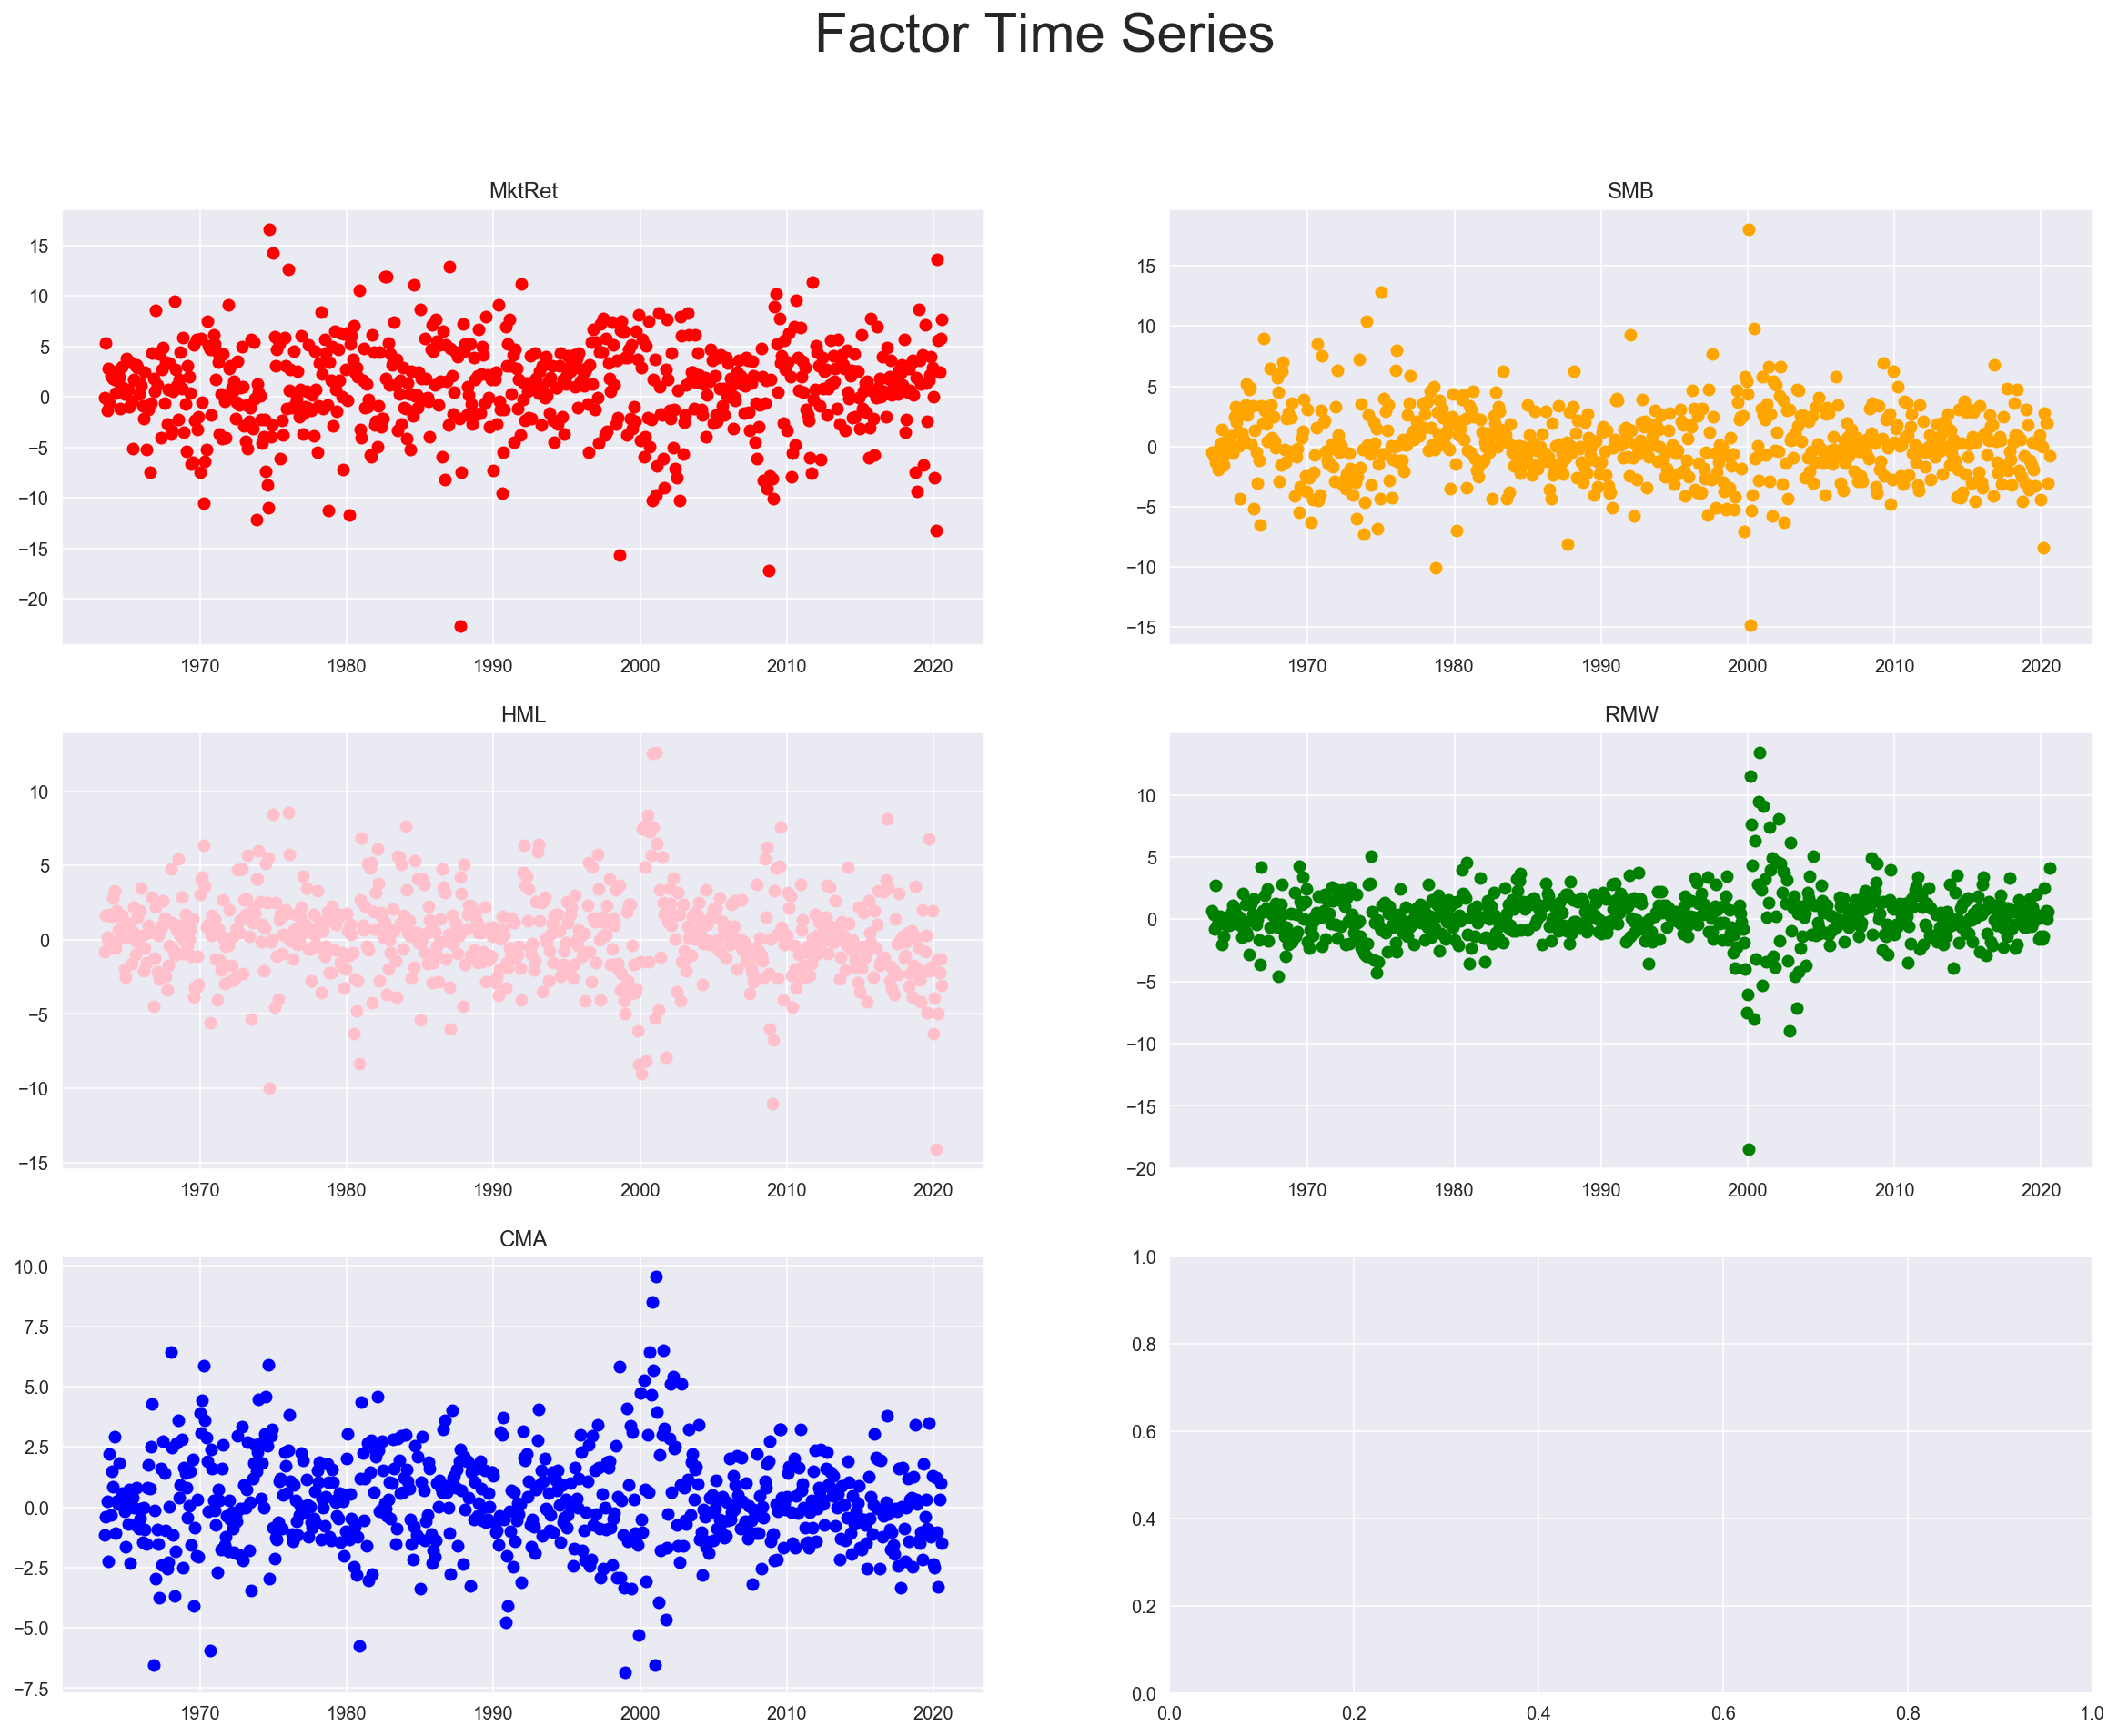

In [6]:
# Factors
# time series of each column: 
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,15))
fig.suptitle('Factor Time Series', fontsize = 30)
x = df_factors.index
ax1.scatter(x, df_factors['MktRet'], color='red')
ax1.set_title('MktRet')
ax2.scatter(x, df_factors['SMB'], color='orange')
ax2.set_title('SMB')
ax3.scatter(x, df_factors['HML'], color='pink')
ax3.set_title('HML')
ax4.scatter(x, df_factors['RMW'], color='green')
ax4.set_title('RMW')
ax5.scatter(x, df_factors['CMA'], color='blue')
ax5.set_title('CMA')

something strange around 2020, can do further research

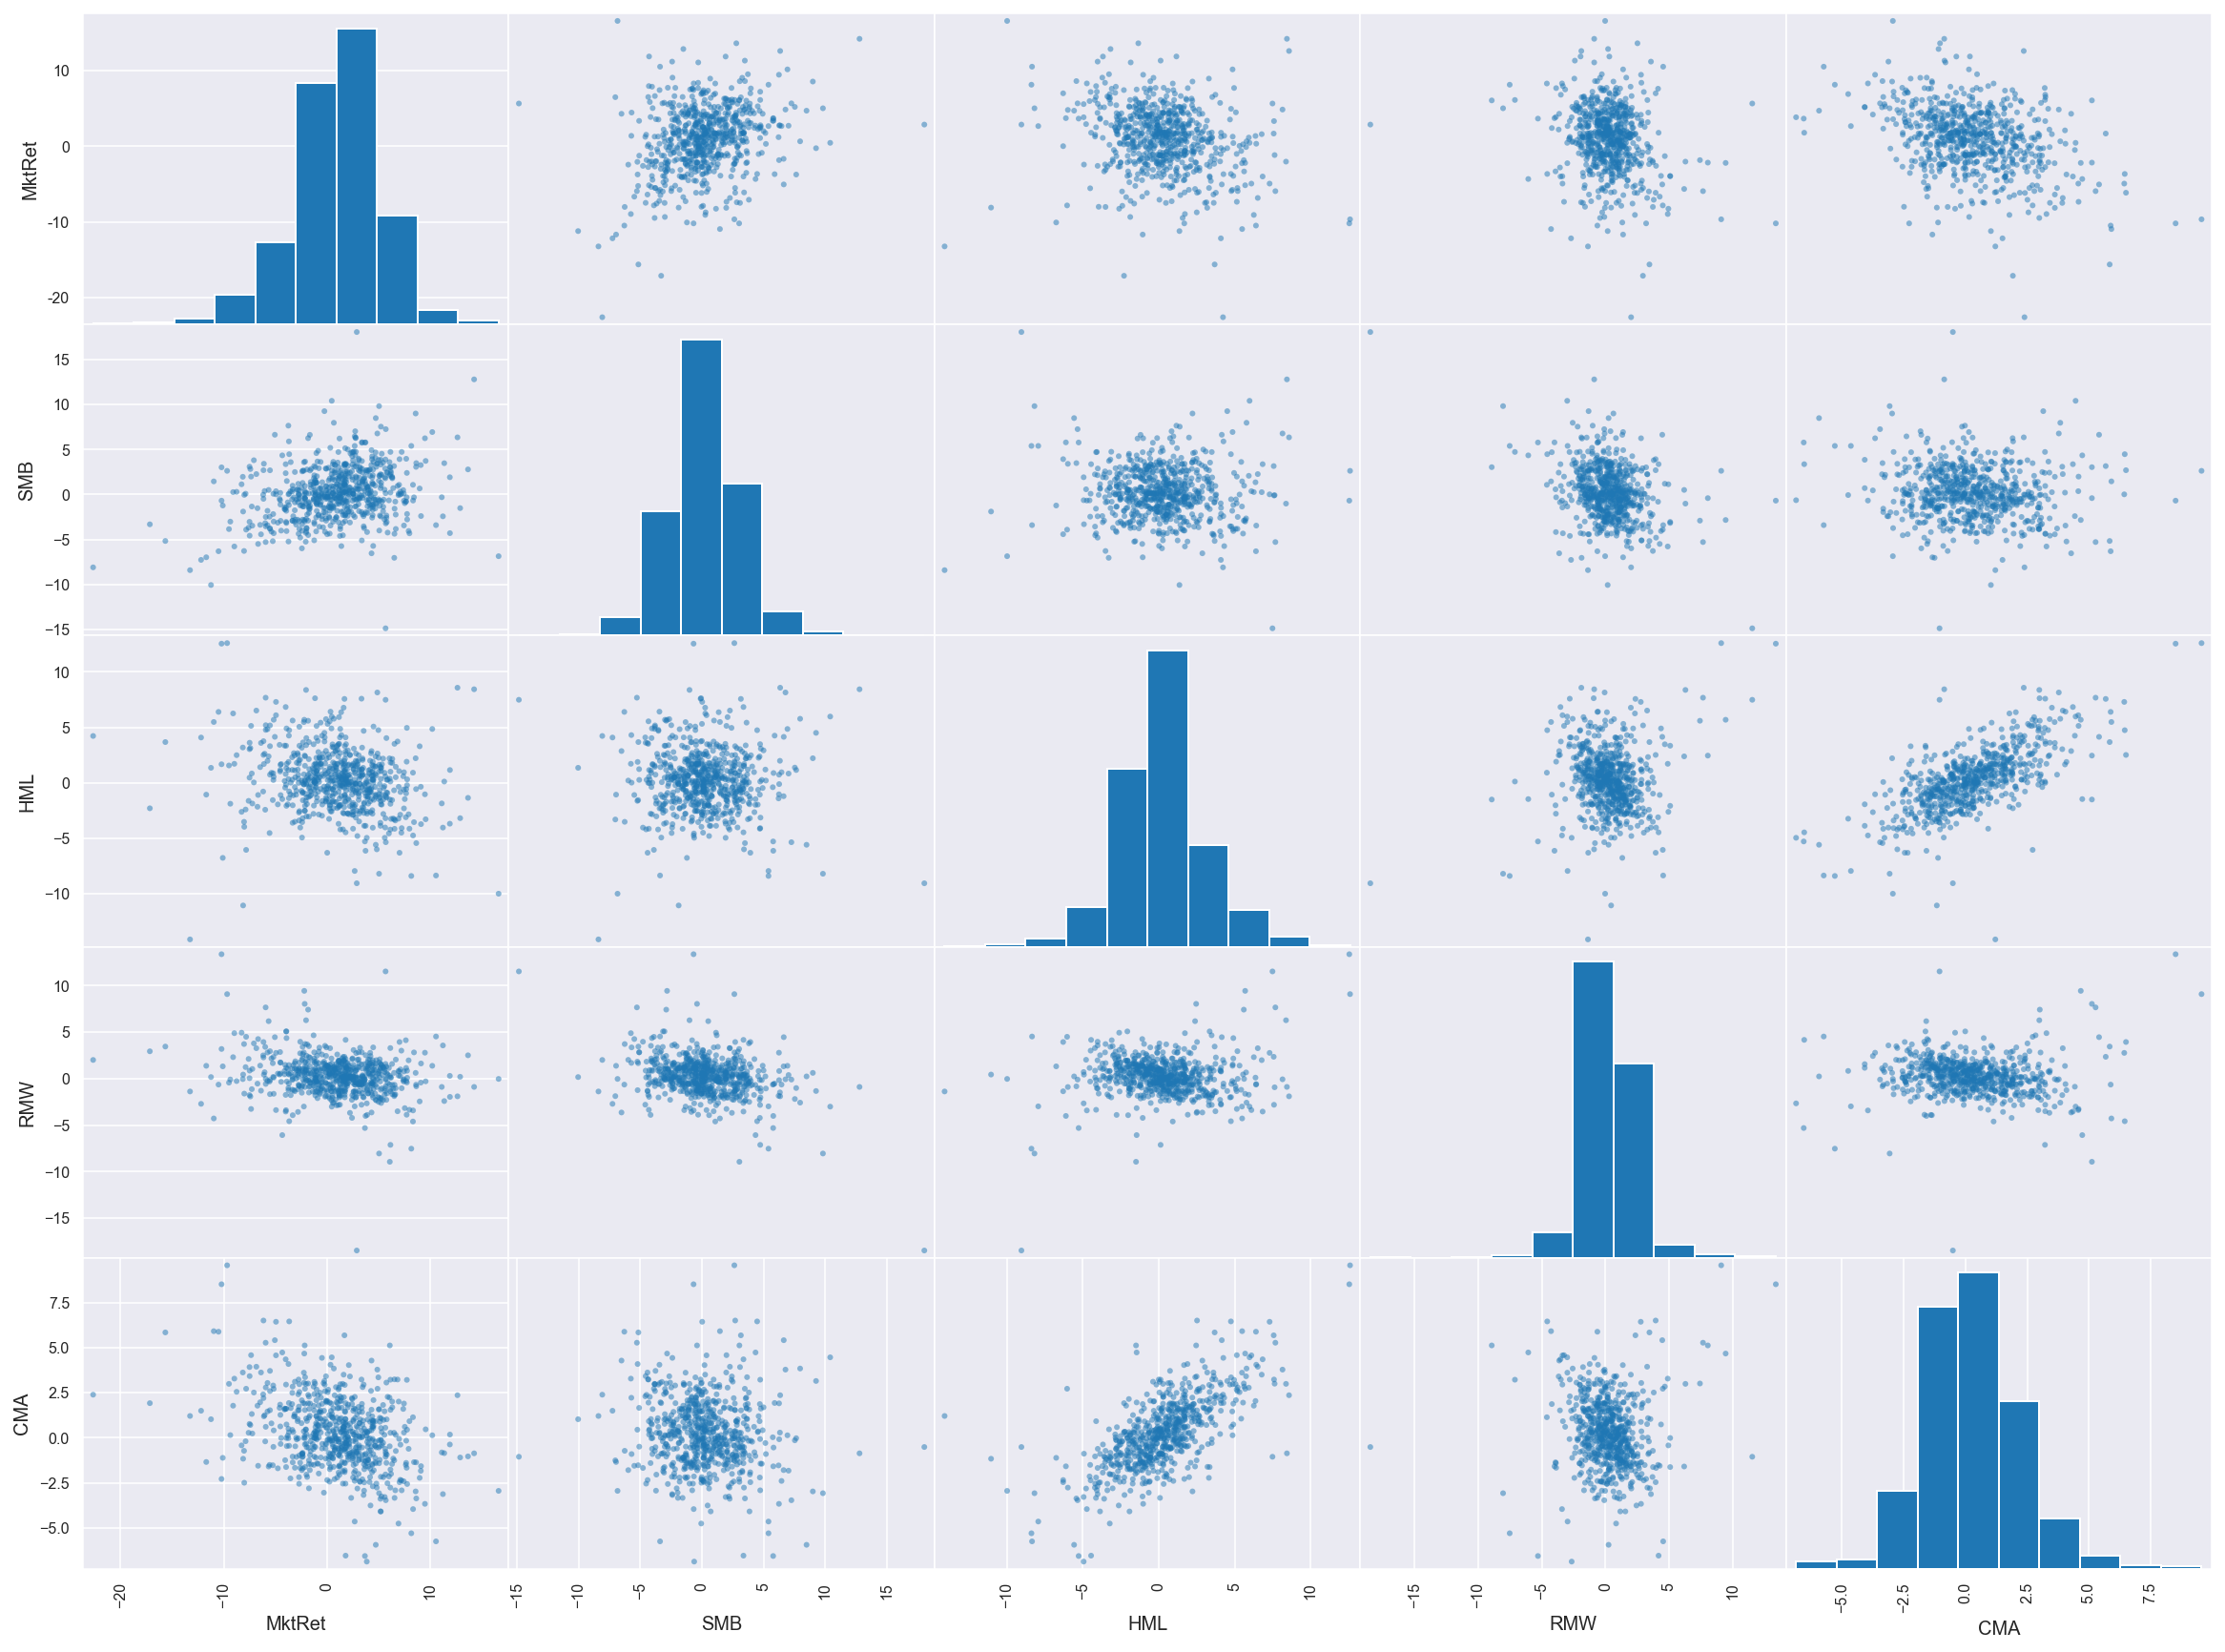

In [7]:
# among factor columns
from pandas.plotting import scatter_matrix
attributes = df_factors.columns
scatter_matrix(df_factors[attributes], figsize=(20,15))

There are some factors are sort of correlated with other, such as HML vs CMA.

##### Summary Statistics of Hedge Fund AQR Monthly Return Data:

In [8]:
df_AQR_return.agg(['mean','std','skew','kurtosis','max','min'])

Return
mean     -0.003182
std       0.030401
skew     -1.050403
kurtosis  7.347097
max       0.088837
min      -0.150740

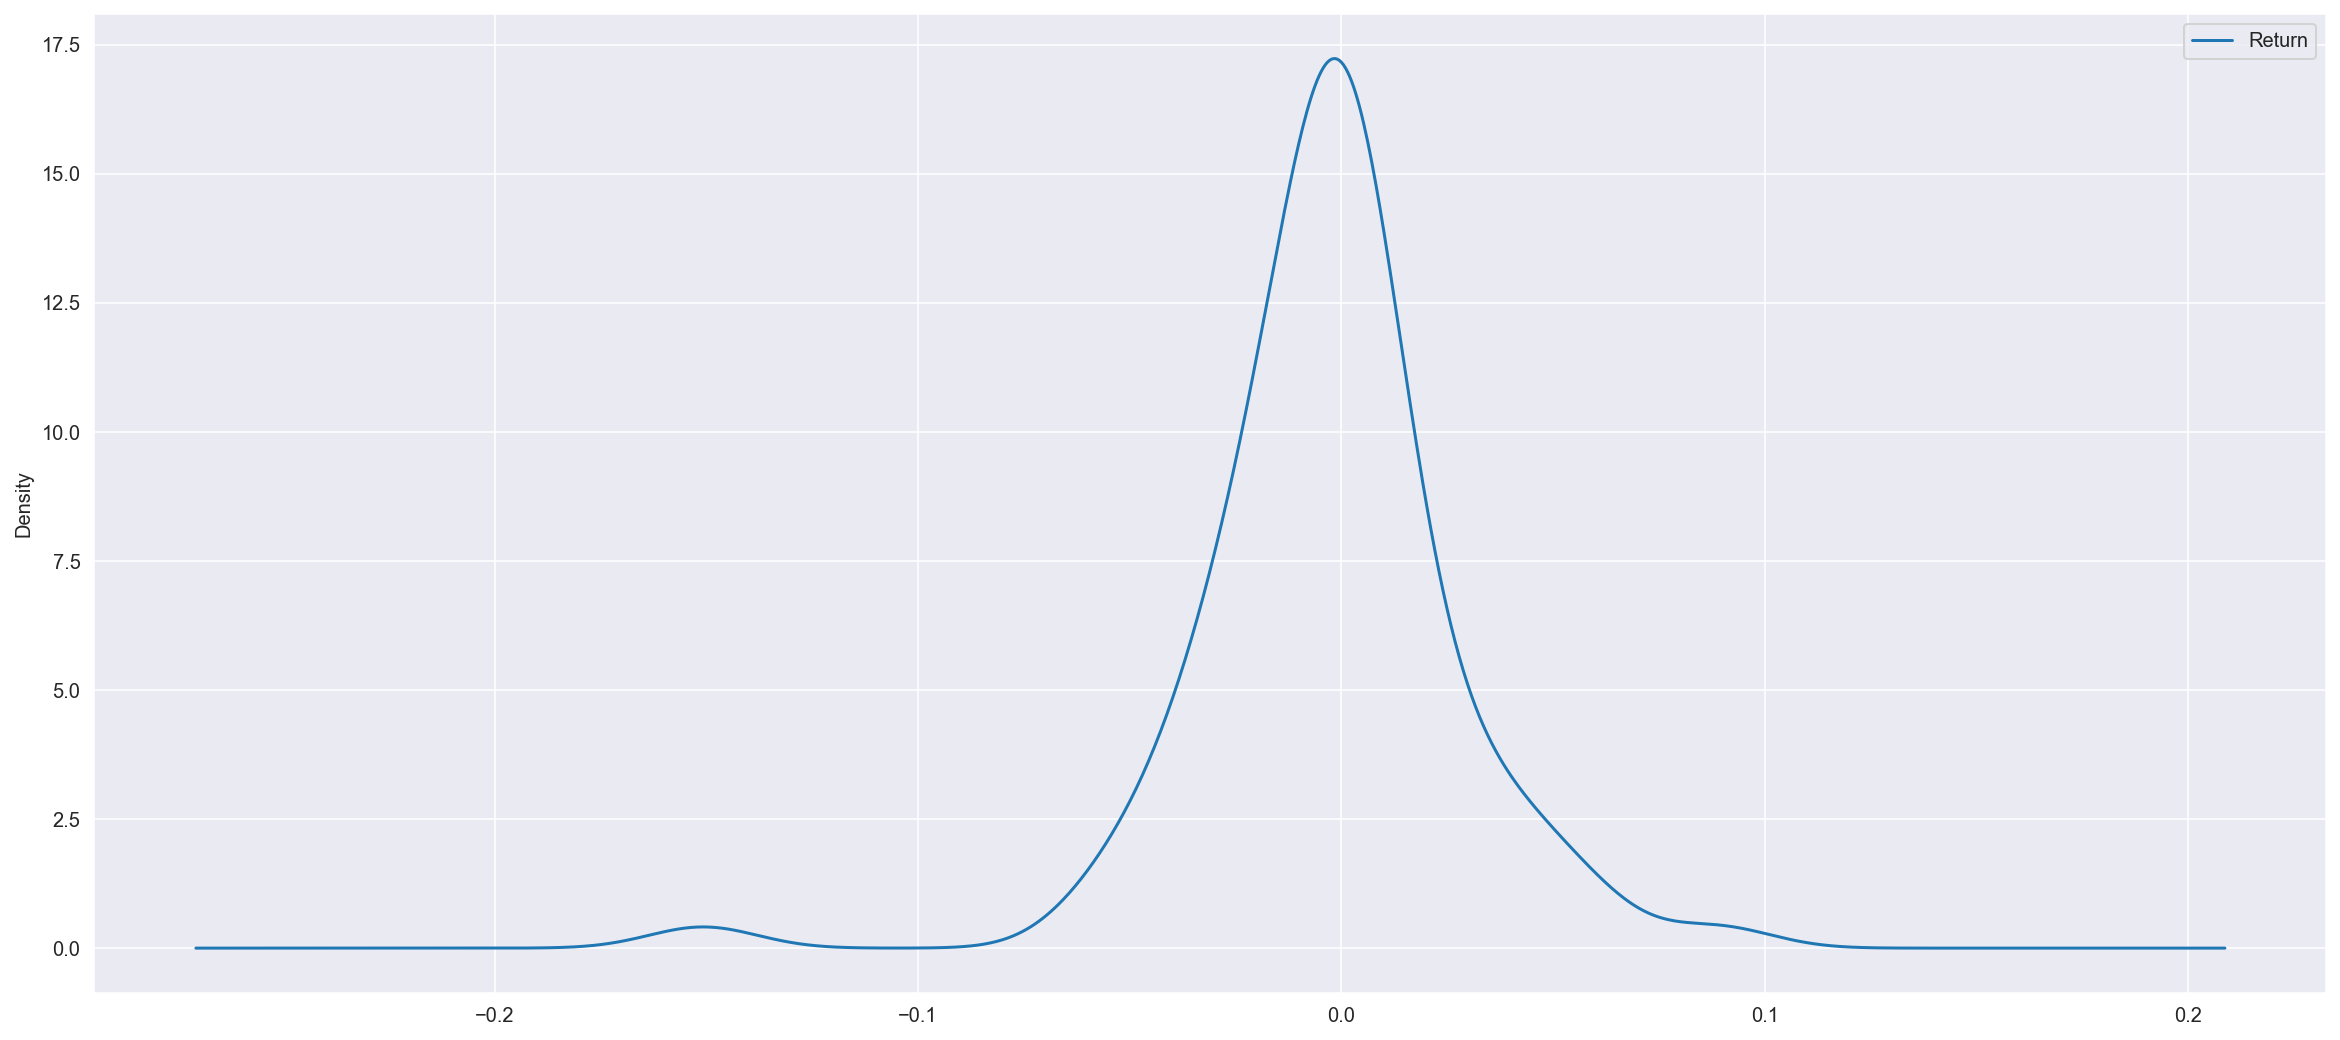

In [9]:
df_AQR_return.plot(kind='kde')

Text(0, 0.5, 'Return')

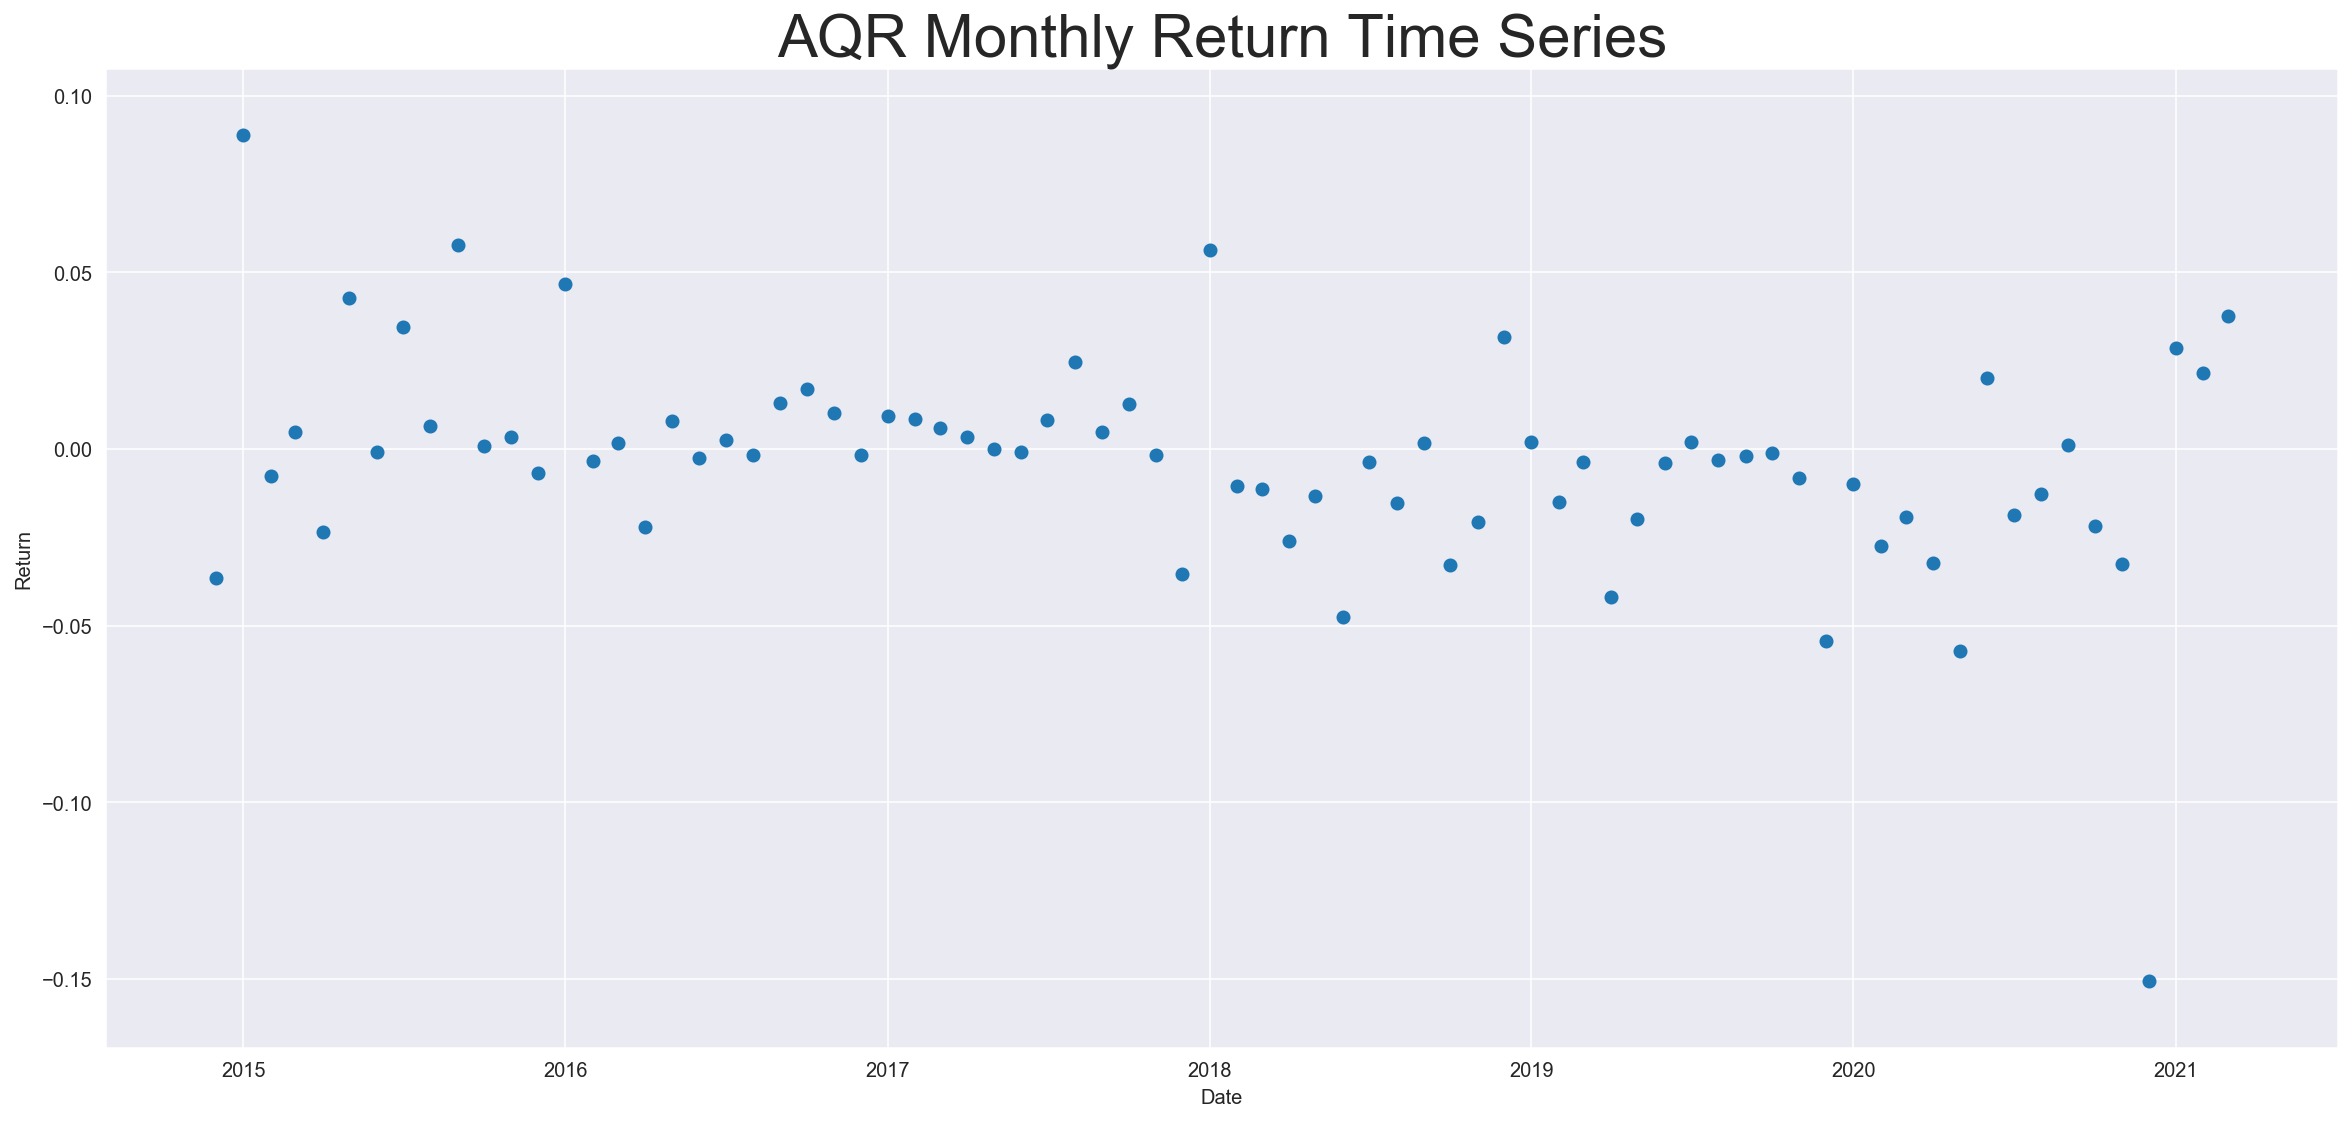

In [10]:
plt.scatter(df_AQR_return.index, df_AQR_return['Return'])
plt.title('AQR Monthly Return Time Series', fontsize = 30)
plt.xlabel('Date')
plt.ylabel('Return')

Pay attention on outlier. can conduct further research.

##### Relationship between Fama-French Factors and Hedge Fund Monthly Returns:

For scatter plots, we need consistent start/end dates for two datasets:
start_date:  2014-12
end_date:  2020-08


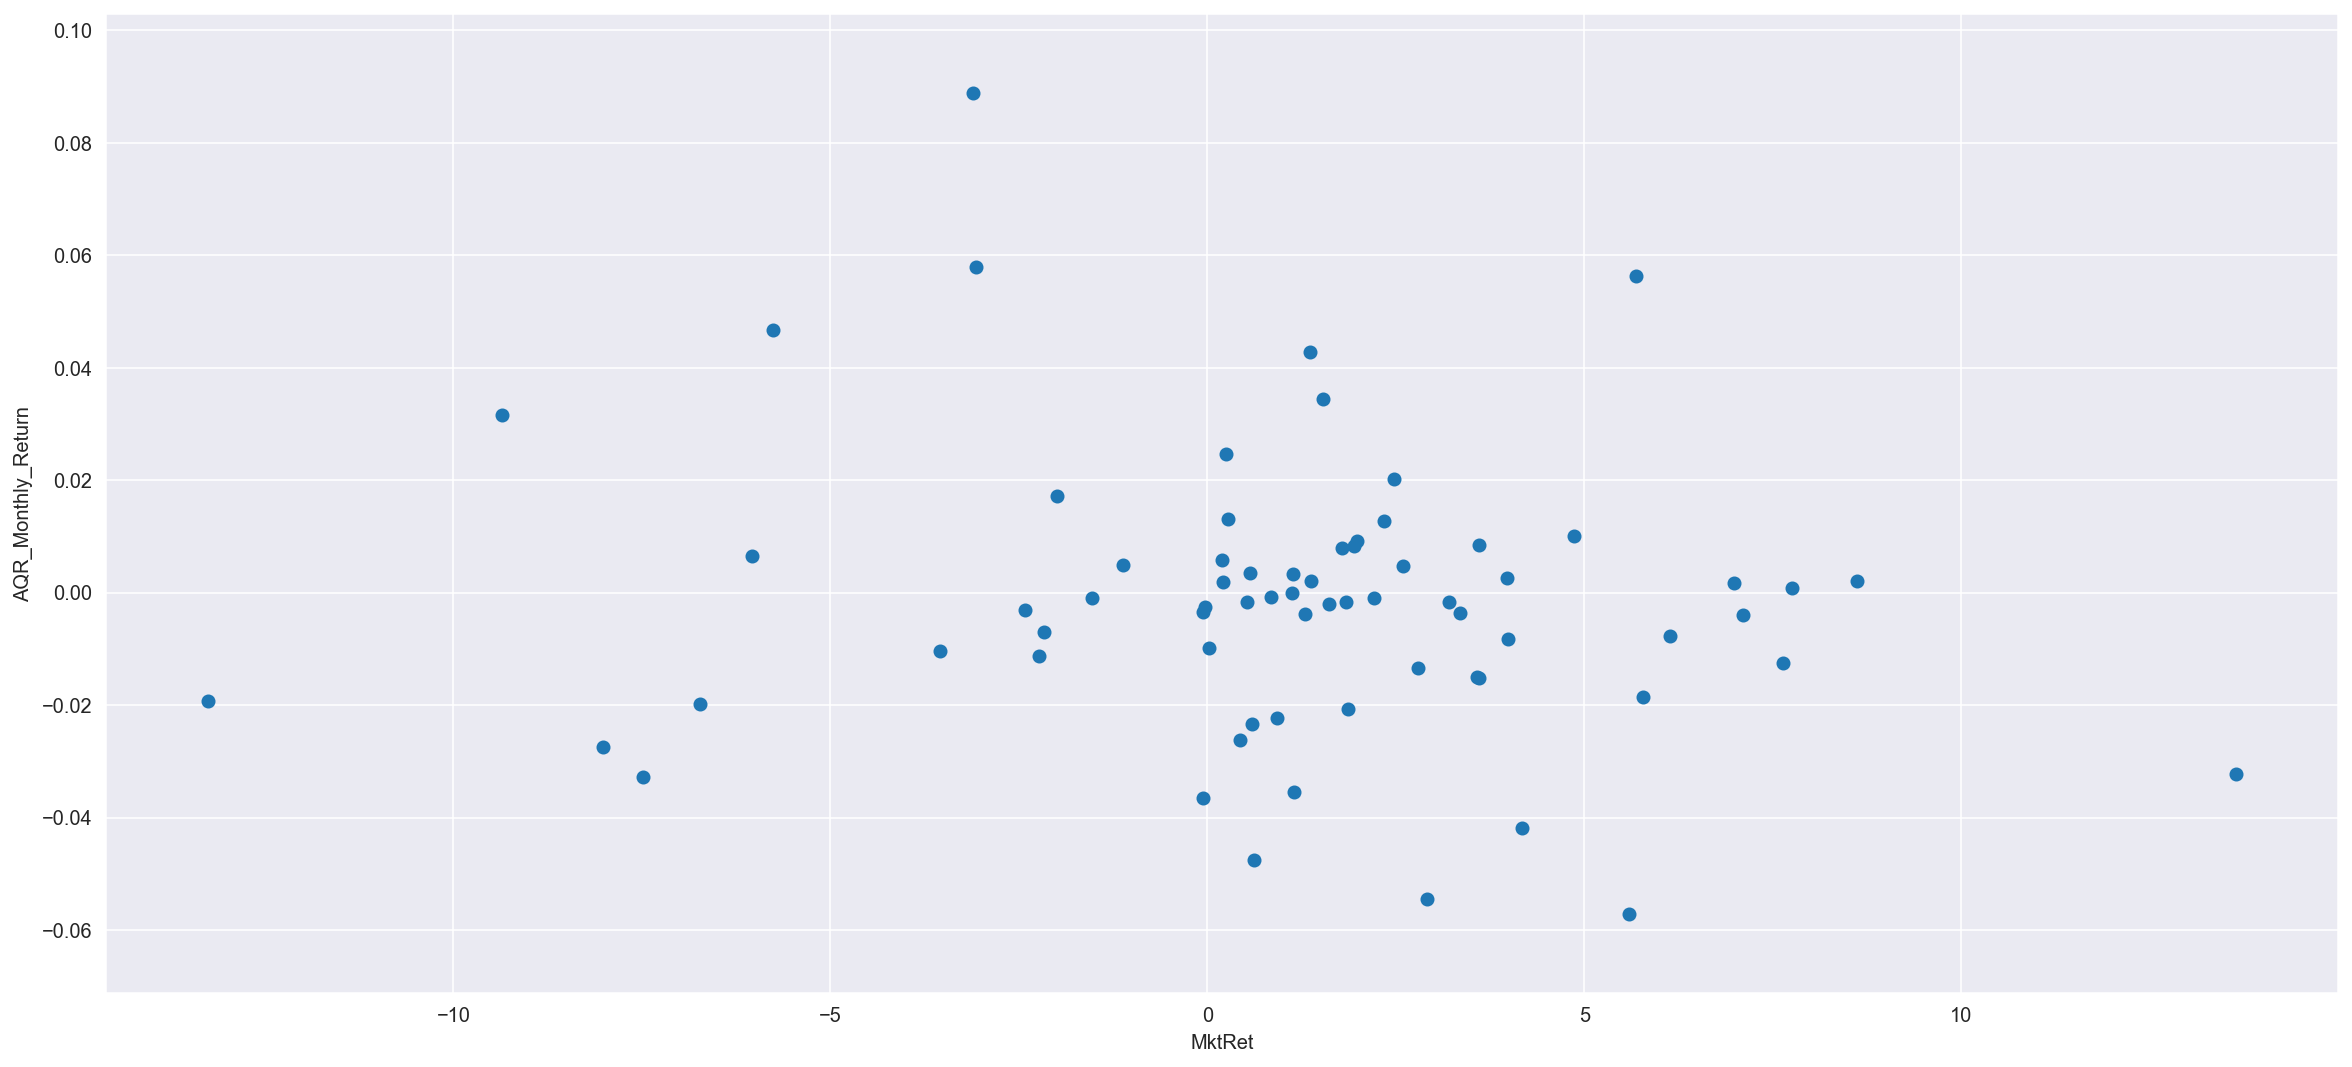

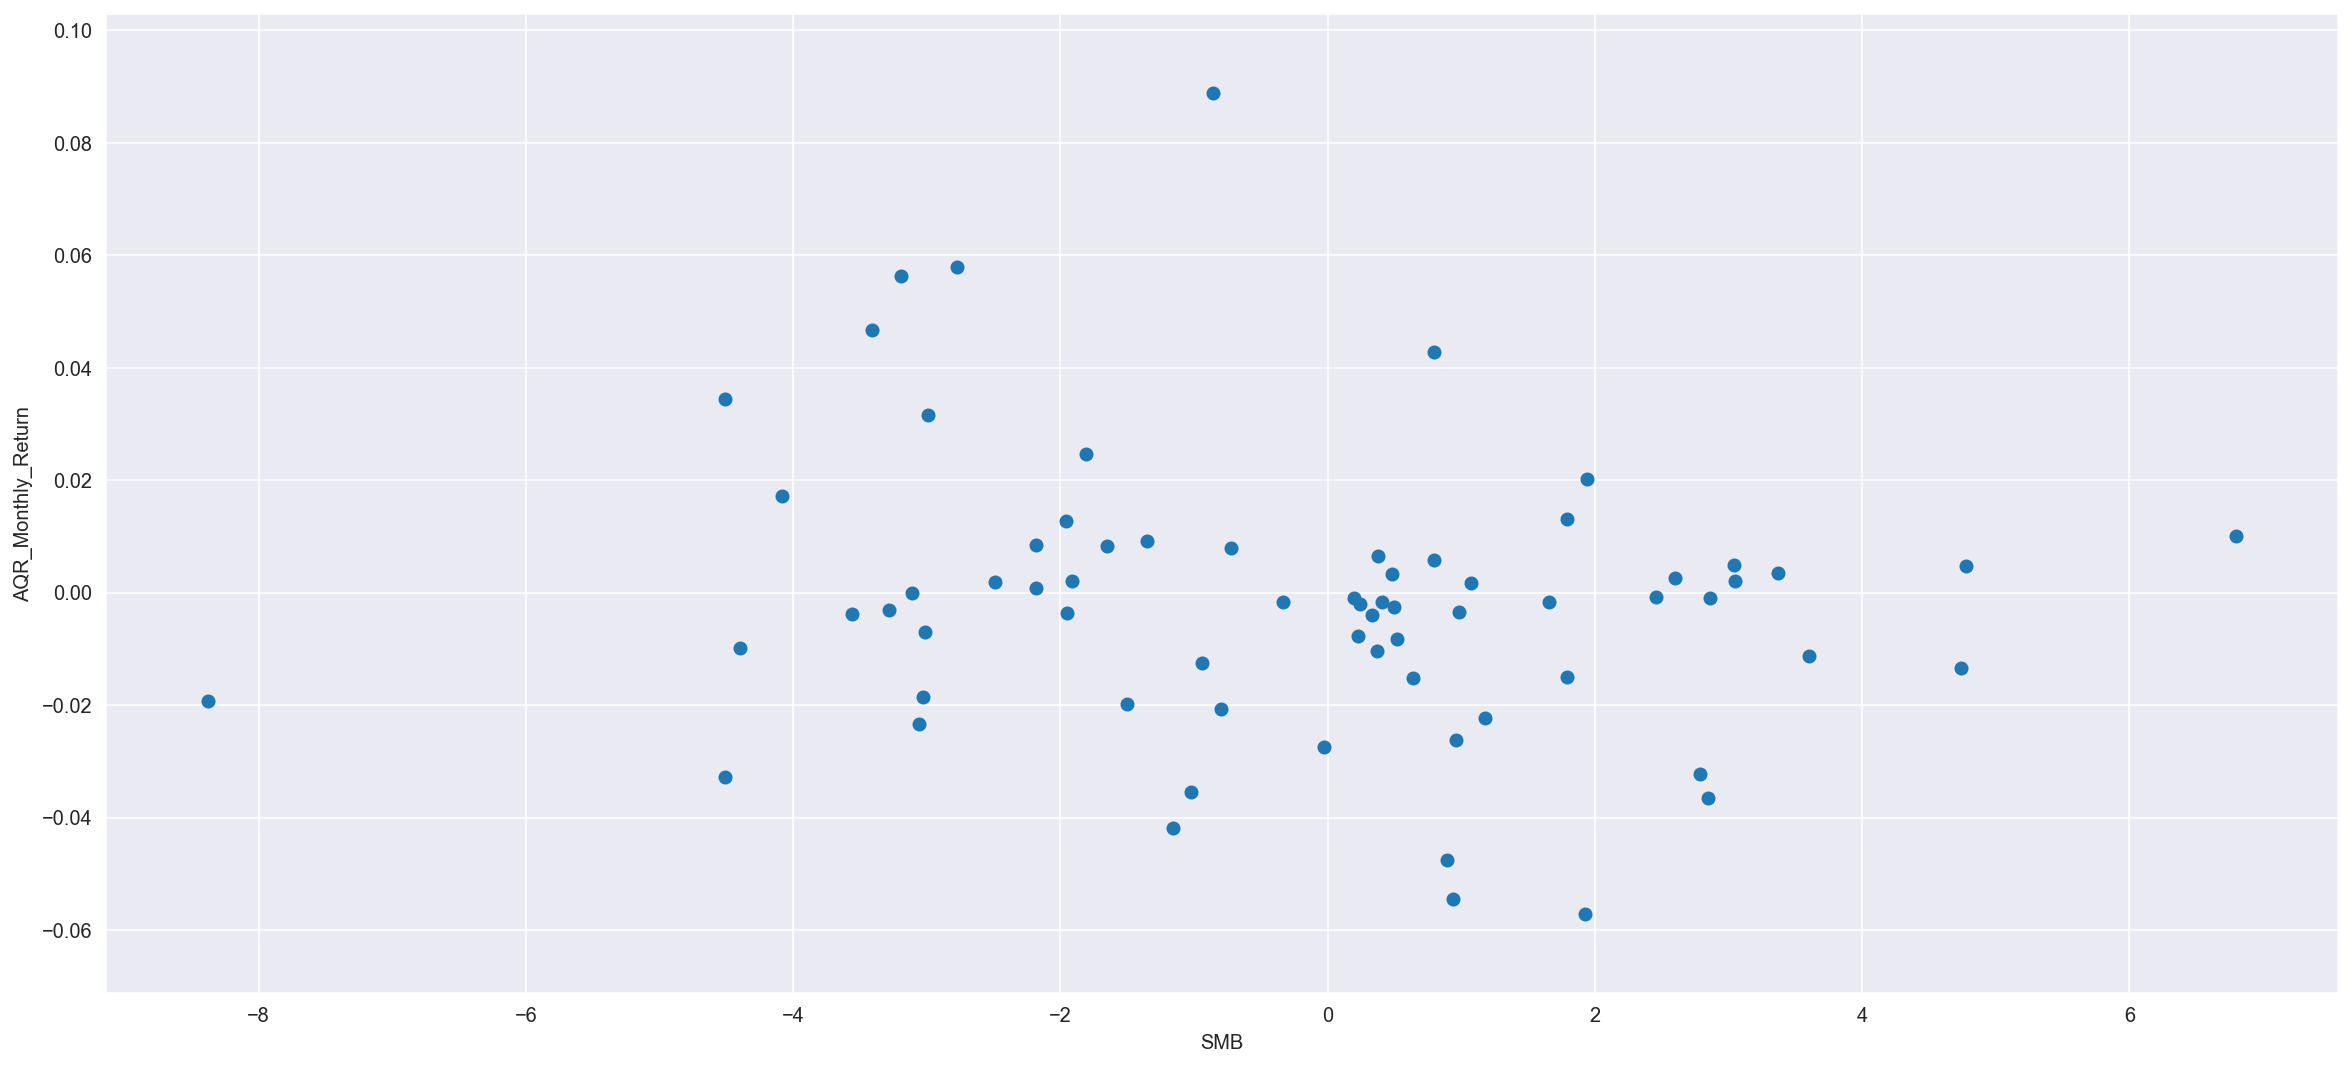

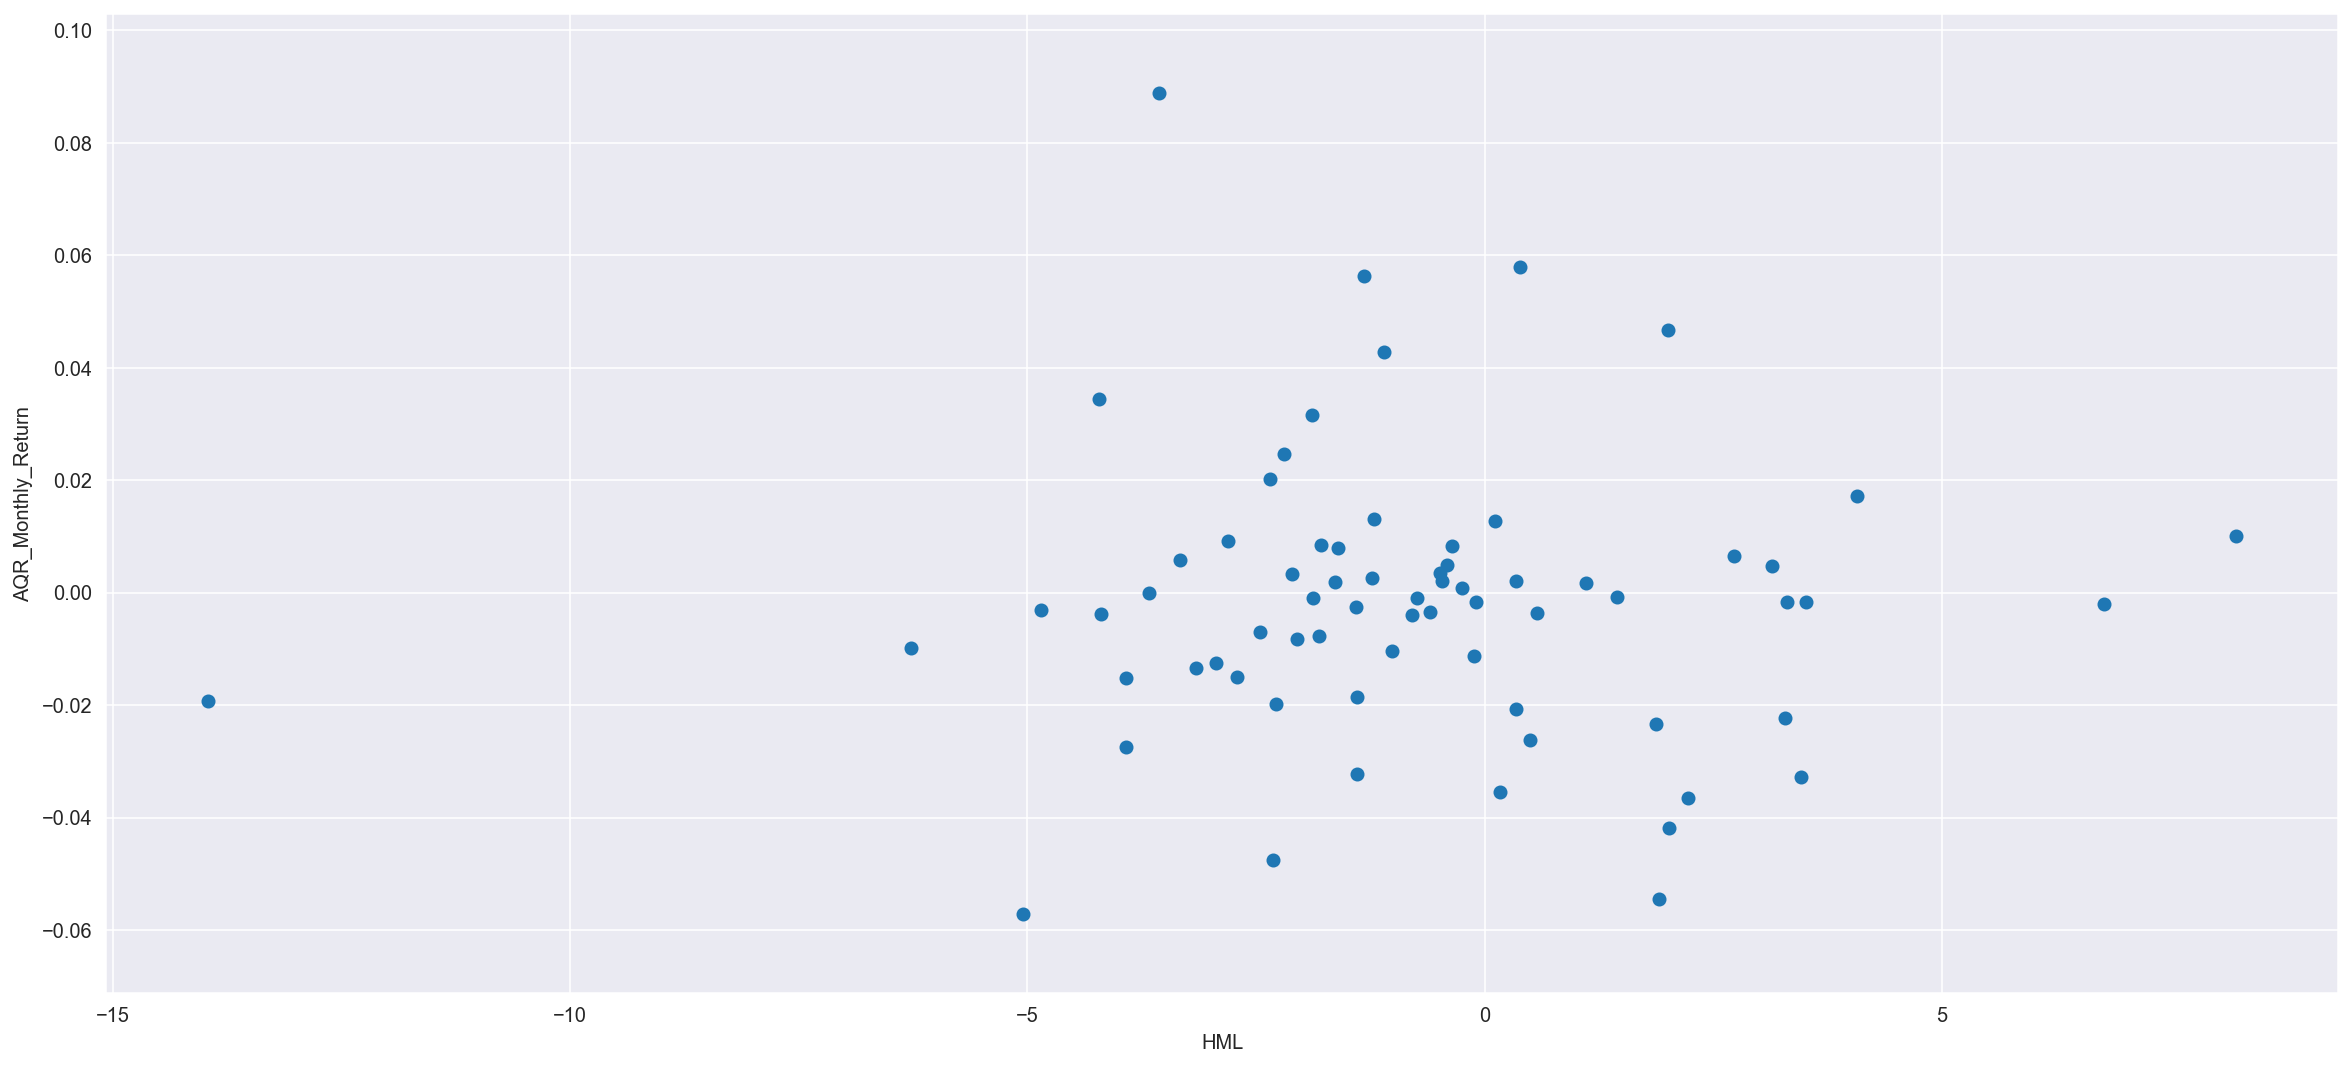

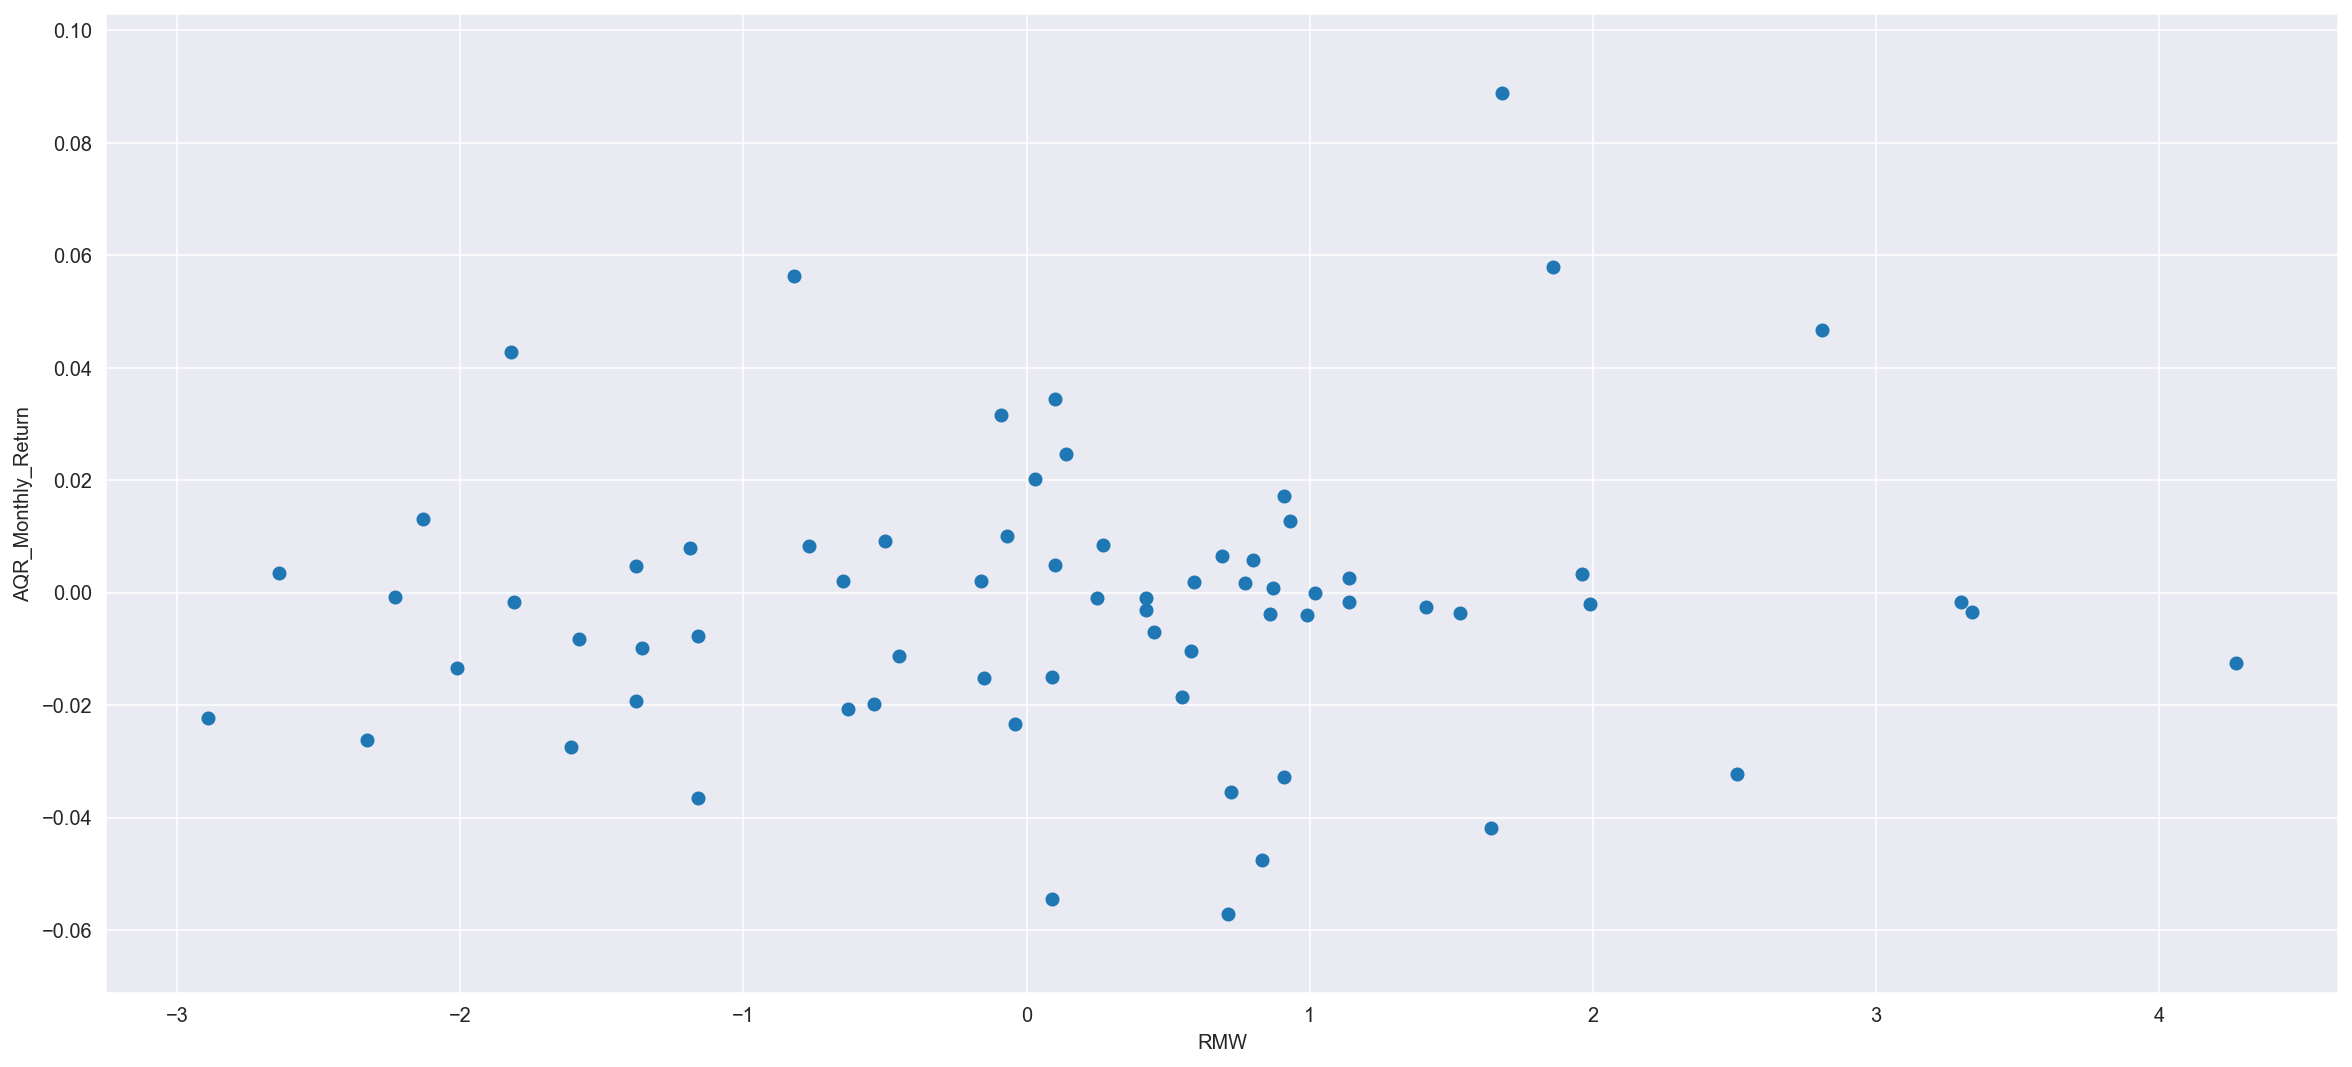

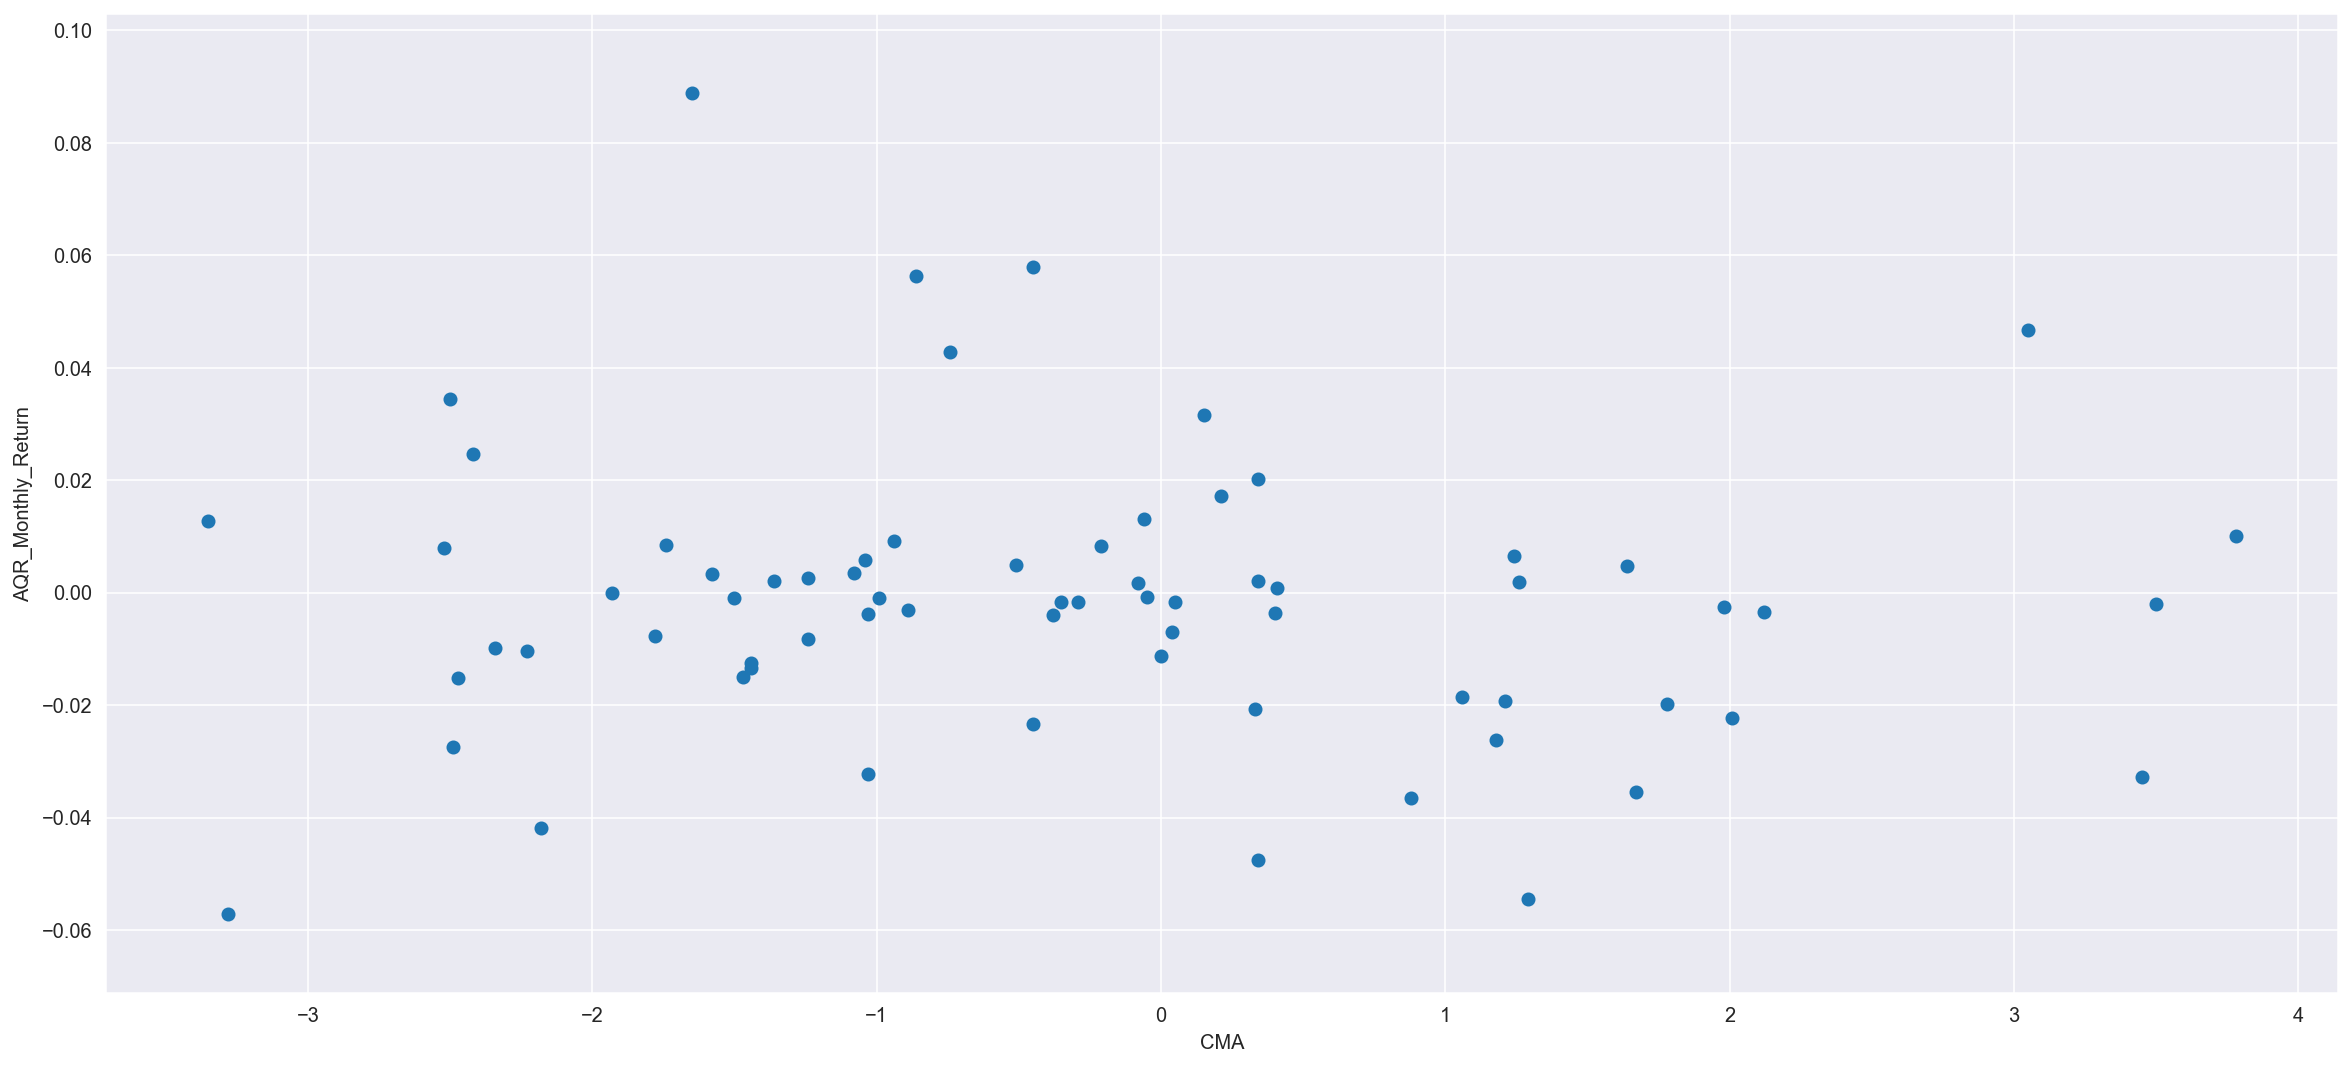

Return    MktRet       SMB       HML       RMW       CMA
Return  1.000000 -0.139781 -0.167309  0.005295  0.083436 -0.084729
MktRet -0.139781  1.000000  0.386570  0.186500  0.148069 -0.245329
SMB    -0.167309  0.386570  1.000000  0.396809 -0.205962  0.036101
HML     0.005295  0.186500  0.396809  1.000000  0.072740  0.507195
RMW     0.083436  0.148069 -0.205962  0.072740  1.000000  0.079320
CMA    -0.084729 -0.245329  0.036101  0.507195  0.079320  1.000000

In [11]:
start = max(start_date_factors, start_date_hf)
end = min(end_date_factors, end_date_hf)
print('For scatter plots, we need consistent start/end dates for two datasets:')
print('start_date: ', str(start)[:7])
print('end_date: ', str(end)[:7])
df_factors_2 = df_factors.loc[start:end]
df_AQR_return_2 = df_AQR_return.loc[start:end]

attributes = df_factors_2.columns
for att in attributes:
    plt.scatter(df_factors_2[att], df_AQR_return_2['Return'])
    plt.xlabel(att)
    plt.ylabel('AQR_Monthly_Return')
    plt.show()
df_stock_factor = pd.merge(df_AQR_return_2, df_factors_2, left_index=True, right_index=True)
df_stock_factor.corr()

In short, monthly data is a small sample, lack of obvious and strong conclusions can be made through scatter plots.

### Extra credit: Perform tests for stationarity of all data series.
The **Augmented Dickey-Fuller test** is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The **null hypothesis** of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The **alternate hypothesis** (rejecting the null hypothesis) is that the time series is stationary.

**Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is **non-stationary**. It has some time dependent structure.
**Alternate Hypothesis (Ha)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is **stationary**. It does not have time-dependent structure.

We interpret this result using the **p-value** from the test. 
- **p-value > 0.05**: Fail to reject the null hypothesis (H0), the data has a unit root and is **non-stationary**.
- **p-value <= 0.05**: Reject the null hypothesis (H0), the data does not have a unit root and is **stationary**.

In [12]:
from statsmodels.tsa.stattools import adfuller
for i in df_factors_withRF.columns:
    print('-----------------------------')
    print('Stationarity test on '+i)
    result = adfuller(df_factors_withRF[i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        print('The series of '+str(i)+' is non-stationary.')
    else:
        print('The series of '+str(i)+' is stationary.')

for i in df_AQR_return.columns:
    print('-----------------------------')
    print('Stationarity test on '+i)
    result = adfuller(df_AQR_return[i])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        print('The series of '+str(i)+' is non-stationary.')
    else:
        print('The series of '+str(i)+' is stationary.')

-----------------------------
Stationarity test on MktRet
ADF Statistic: -24.616072
p-value: 0.000000
The series of MktRet is stationary.
-----------------------------
Stationarity test on SMB
ADF Statistic: -15.294865
p-value: 0.000000
The series of SMB is stationary.
-----------------------------
Stationarity test on HML
ADF Statistic: -15.607106
p-value: 0.000000
The series of HML is stationary.
-----------------------------
Stationarity test on RMW
ADF Statistic: -7.391977
p-value: 0.000000
The series of RMW is stationary.
-----------------------------
Stationarity test on CMA
ADF Statistic: -12.838583
p-value: 0.000000
The series of CMA is stationary.
-----------------------------
Stationarity test on RF
ADF Statistic: -2.133821
p-value: 0.231134
The series of RF is non-stationary.
-----------------------------
Stationarity test on Return
ADF Statistic: -8.428246
p-value: 0.000000
The series of Return is stationary.


### (c) Regress QMNIX on the Fama-French factors and discuss the regression results, including t- and F-tests and R2. Is the intercept statistically different from 0?

**Based on requirements on Forum, I use the following regression model instead of FF5:**
$$ AQR Return_i = a_i + b_iMktRet + s_iSMB + h_iHMI + r_iRMW + c_iCMA + \epsilon_i$$

In [13]:
# All data we gonna use:
df_stock_factor = pd.merge(df_AQR_return_2, df_factors_2, left_index=True, right_index=True)
# df_stock_factor.to_csv(r'C:\Users\xxxli\Desktop\model1_Data.csv')
df_stock_factor

Return  MktRet   SMB   HML   RMW   CMA
Date                                                
2014-12-01 -0.036574   -0.06  2.85  2.23 -1.16  0.88
2015-01-01  0.088837   -3.11 -0.86 -3.56  1.68 -1.65
2015-02-01 -0.007767    6.14  0.23 -1.81 -1.16 -1.78
2015-03-01  0.004892   -1.12  3.04 -0.41  0.10 -0.51
2015-04-01 -0.023369    0.59 -3.06  1.88 -0.04 -0.45
...              ...     ...   ...   ...   ...   ...
2020-04-01 -0.032221   13.65  2.79 -1.39  2.51 -1.03
2020-05-01 -0.057075    5.59  1.93 -5.05  0.71 -3.28
2020-06-01  0.020177    2.47  1.94 -2.35  0.03  0.34
2020-07-01 -0.018541    5.78 -3.03 -1.39  0.55  1.06
2020-08-01 -0.012594    7.64 -0.94 -2.94  4.27 -1.44

[69 rows x 6 columns]

In [14]:
'''
If including RF in factors:

df_factors_withRF_2 =  df_factors_withRF.loc[start:end]
X = df_factors_withRF_2

'''
# regressors: 5 Factors
X = df_stock_factor[df_stock_factor.columns[1:]]   
X

MktRet   SMB   HML   RMW   CMA
Date                                      
2014-12-01   -0.06  2.85  2.23 -1.16  0.88
2015-01-01   -3.11 -0.86 -3.56  1.68 -1.65
2015-02-01    6.14  0.23 -1.81 -1.16 -1.78
2015-03-01   -1.12  3.04 -0.41  0.10 -0.51
2015-04-01    0.59 -3.06  1.88 -0.04 -0.45
...            ...   ...   ...   ...   ...
2020-04-01   13.65  2.79 -1.39  2.51 -1.03
2020-05-01    5.59  1.93 -5.05  0.71 -3.28
2020-06-01    2.47  1.94 -2.35  0.03  0.34
2020-07-01    5.78 -3.03 -1.39  0.55  1.06
2020-08-01    7.64 -0.94 -2.94  4.27 -1.44

[69 rows x 5 columns]

In [15]:
# response variable: Returns of QMNIX Monthly
y = df_stock_factor[['Return']]
y

Return
Date                
2014-12-01 -0.036574
2015-01-01  0.088837
2015-02-01 -0.007767
2015-03-01  0.004892
2015-04-01 -0.023369
...              ...
2020-04-01 -0.032221
2020-05-01 -0.057075
2020-06-01  0.020177
2020-07-01 -0.018541
2020-08-01 -0.012594

[69 rows x 1 columns]

In [16]:
# Running OLS model:
import statsmodels.api as sm
X = sm.add_constant(X)
model = sm.OLS(y, X, missing='raise')
result_monthly = model.fit()
FF5tstat = result_monthly.tvalues
FF5coeff = result_monthly.params
FF5fitted = result_monthly.fittedvalues
FF5resid = result_monthly.resid
result_monthly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.123
Date:                Thu, 18 Mar 2021   Prob (F-statistic):              0.357
Time:                        00:12:29   Log-Likelihood:                 159.75
No. Observations:                  69   AIC:                            -307.5
Df Residuals:                      63   BIC:                            -294.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.003     -0.292      0.771      -0.007       0.006
MktRet        -0.0011      0.001     -1.334      0.187      -0.003       0.001
SMB           -0.0015      0.001     -1.035      0.305      -0.004       0.001
HML            0.0018      0.001      1.372      0.175      -0.001       0.004
RMW            0.0014      0.002      0.646      0.521      -0.003       0.006
CMA           -0.0038      0.002     -1.593      0.116      -0.009       0.001
==============================================================================
Omnibus:                        8.593   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.014   Jarque-Bera (JB):               10.769
Skew:                           0.506   Prob(JB):                      0.00459
Kurtosis:                       4.650   Cond. No.                         5.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Explanation:
**t-test**: in the table, for each t-test, it means given other coefs are statistically significant
- H_0: not significant. 
- H_a: the coef is significant.
- p < 0.05, reject null, conclude significance.

Therefore, given all others are significant, no individual coefficient is statistically significant.

**F-test**: in the table, for the F-stats, it means the overall model evaluation.
- H_0: our model does not explain the variance any better than the intercept only model. we want the intercept only model.
- H_a: our model is better than the intercept only one.
- Prob (F-statistic) is just the p-value of this test. If Prob (F-statistic) < 0.05, reject null, conclude our model is good.

Therefore, p-value = 0.362 > 0.05 and we fail to reject null, and we need to conclude that our model is not outperformed the intercept only model.

**R2**: the percentage of variance explained by our model factors.

0.085 means the model is not great with explaining return variance.

**Intercept**: from t-test above, we conclude that, given other coefs are statistically significant, the intercept is not statistically significant.

### (d) Demonstrate graphically whether the classical linear regression assumptions are satisfied or not in (c).
- Linearity
$$ y = X\beta + \epsilon $$
- Strict Exogeneity
$$ \mathbf{E}[\epsilon | X ] = 0$$
- No Multicollinearity
$$ \mathbf{P}[rank(X) = p] = 1 $$
- Spherical Errors
$$ var[\epsilon|X] = \sigma^2I_n$$
- Normality
$$ \epsilon|X ∼ N(0, \sigma^2I_n)$$

##### Linearity: 
Nonlinearity is usually most evident in a plot of **observed versus predicted values** 
or a plot of **residuals versus predicted values**, which are a part of standard regression output.

The points should be symmetrically distributed around a diagonal line in the former plot or 
around horizontal line in the latter plot, with a roughly constant variance.  

(The residual-versus-predicted-plot is better than the observed-versus-predicted plot for 
this purpose, because it eliminates the visual distraction of a sloping pattern.)  

Look carefully for evidence of a "bowed" pattern, indicating that the model makes systematic 
errors whenever it is making unusually large or small predictions. In multiple regression 
models, nonlinearity or nonadditivity may also be revealed by systematic patterns in plots 
of the residuals versus individual independent variables.

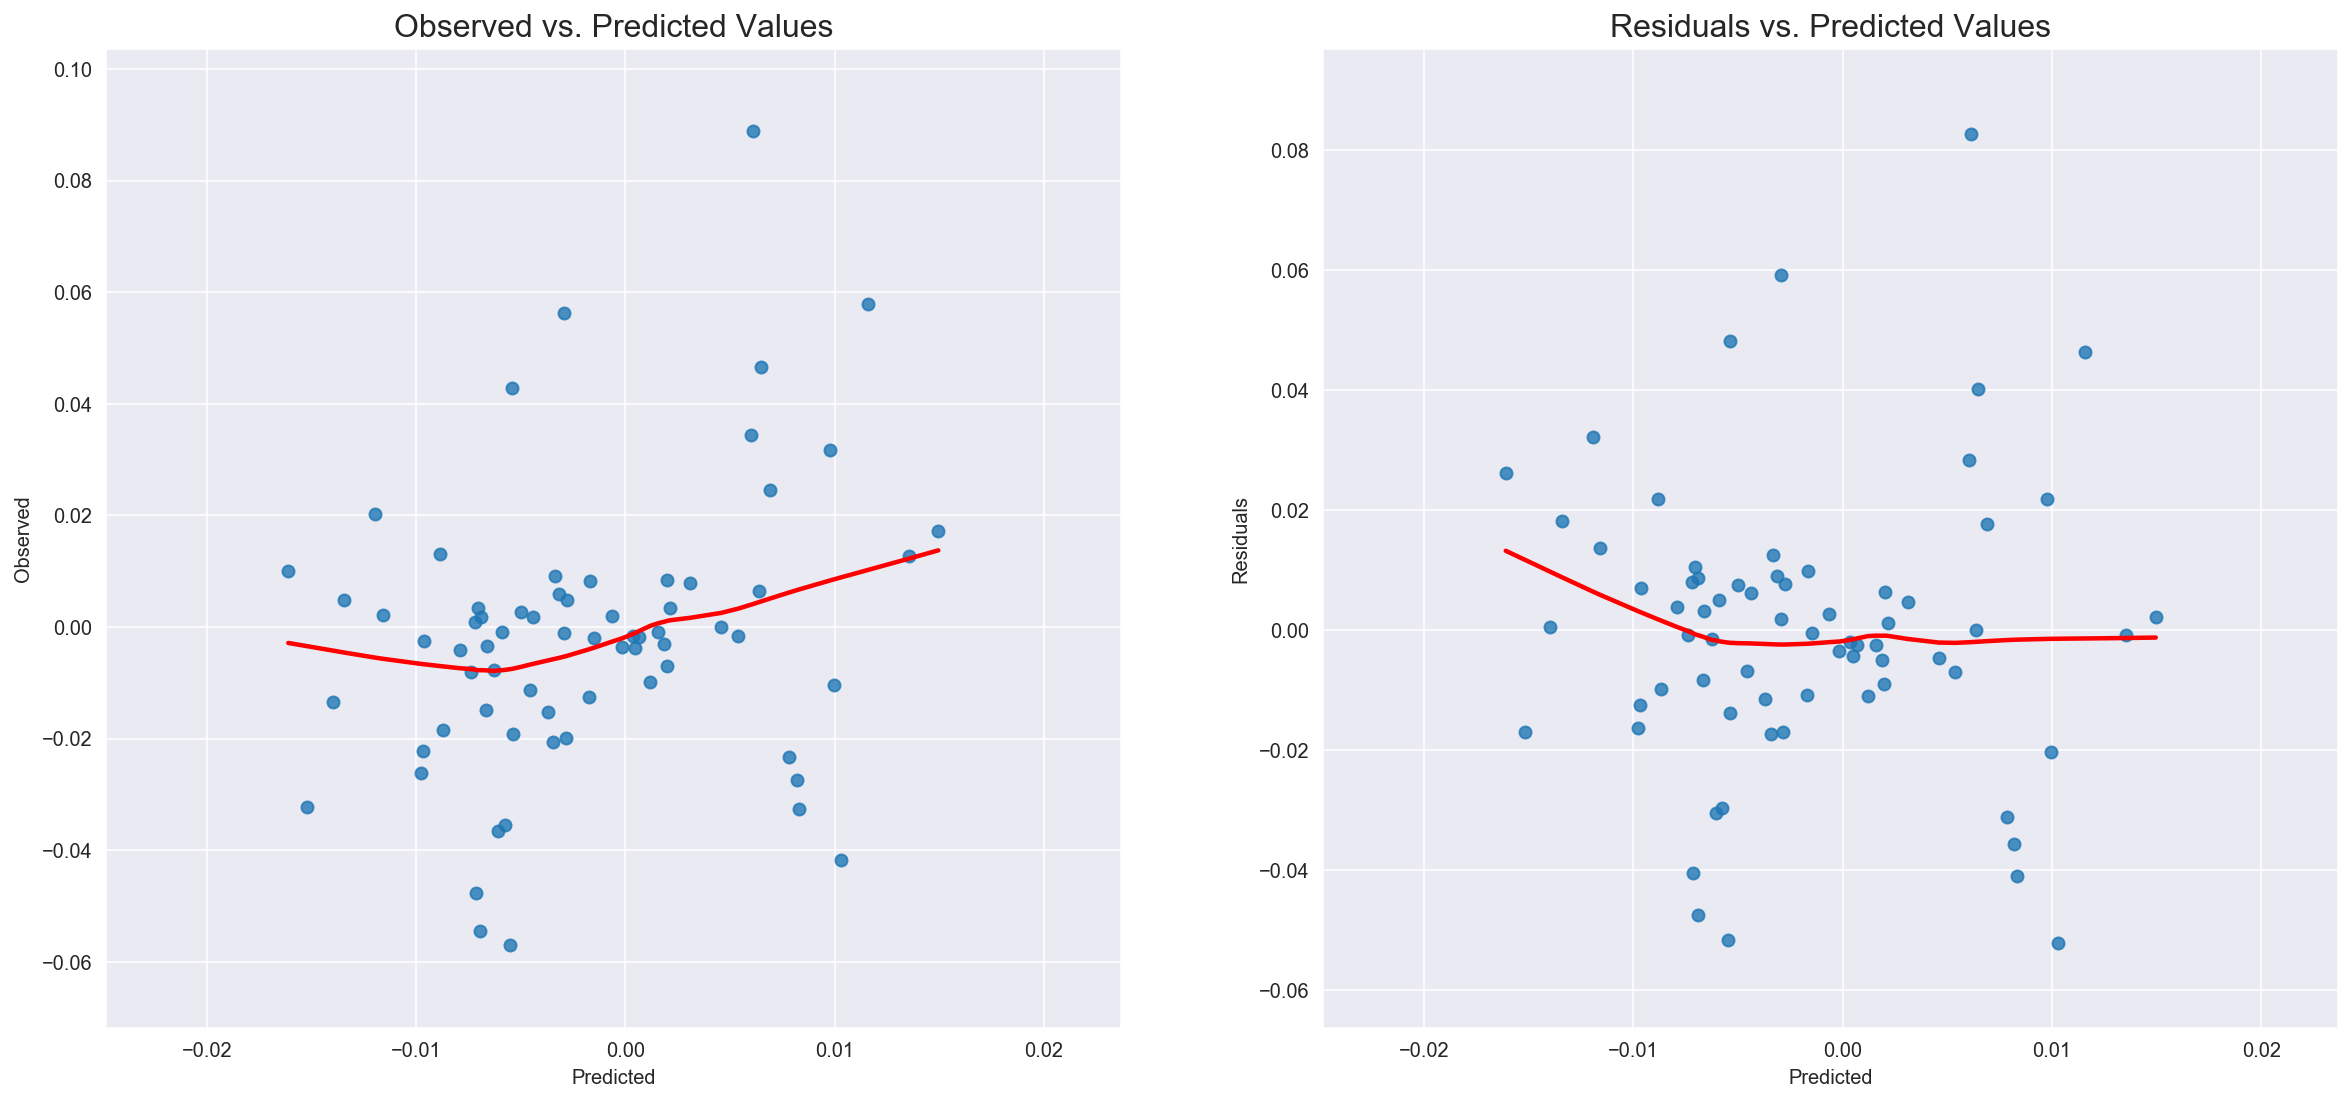

In [17]:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.fittedvalues
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(result_monthly, y)    

Linearity is not really satisfied since there is clearly a bowl pattern indicating the model is making unusual large/small predictions. If linearity exists, the left plot should be scattered around diagnal line, and the right plot should be scattered around a horizontal line.

##### Strict exogeneity
The distribution of error terms has zero mean and doesn’t depend on the independent variables X. 
i.e. there must be no relationship between the X and the error term.

mean of residuals =  5.229311347872114e-18


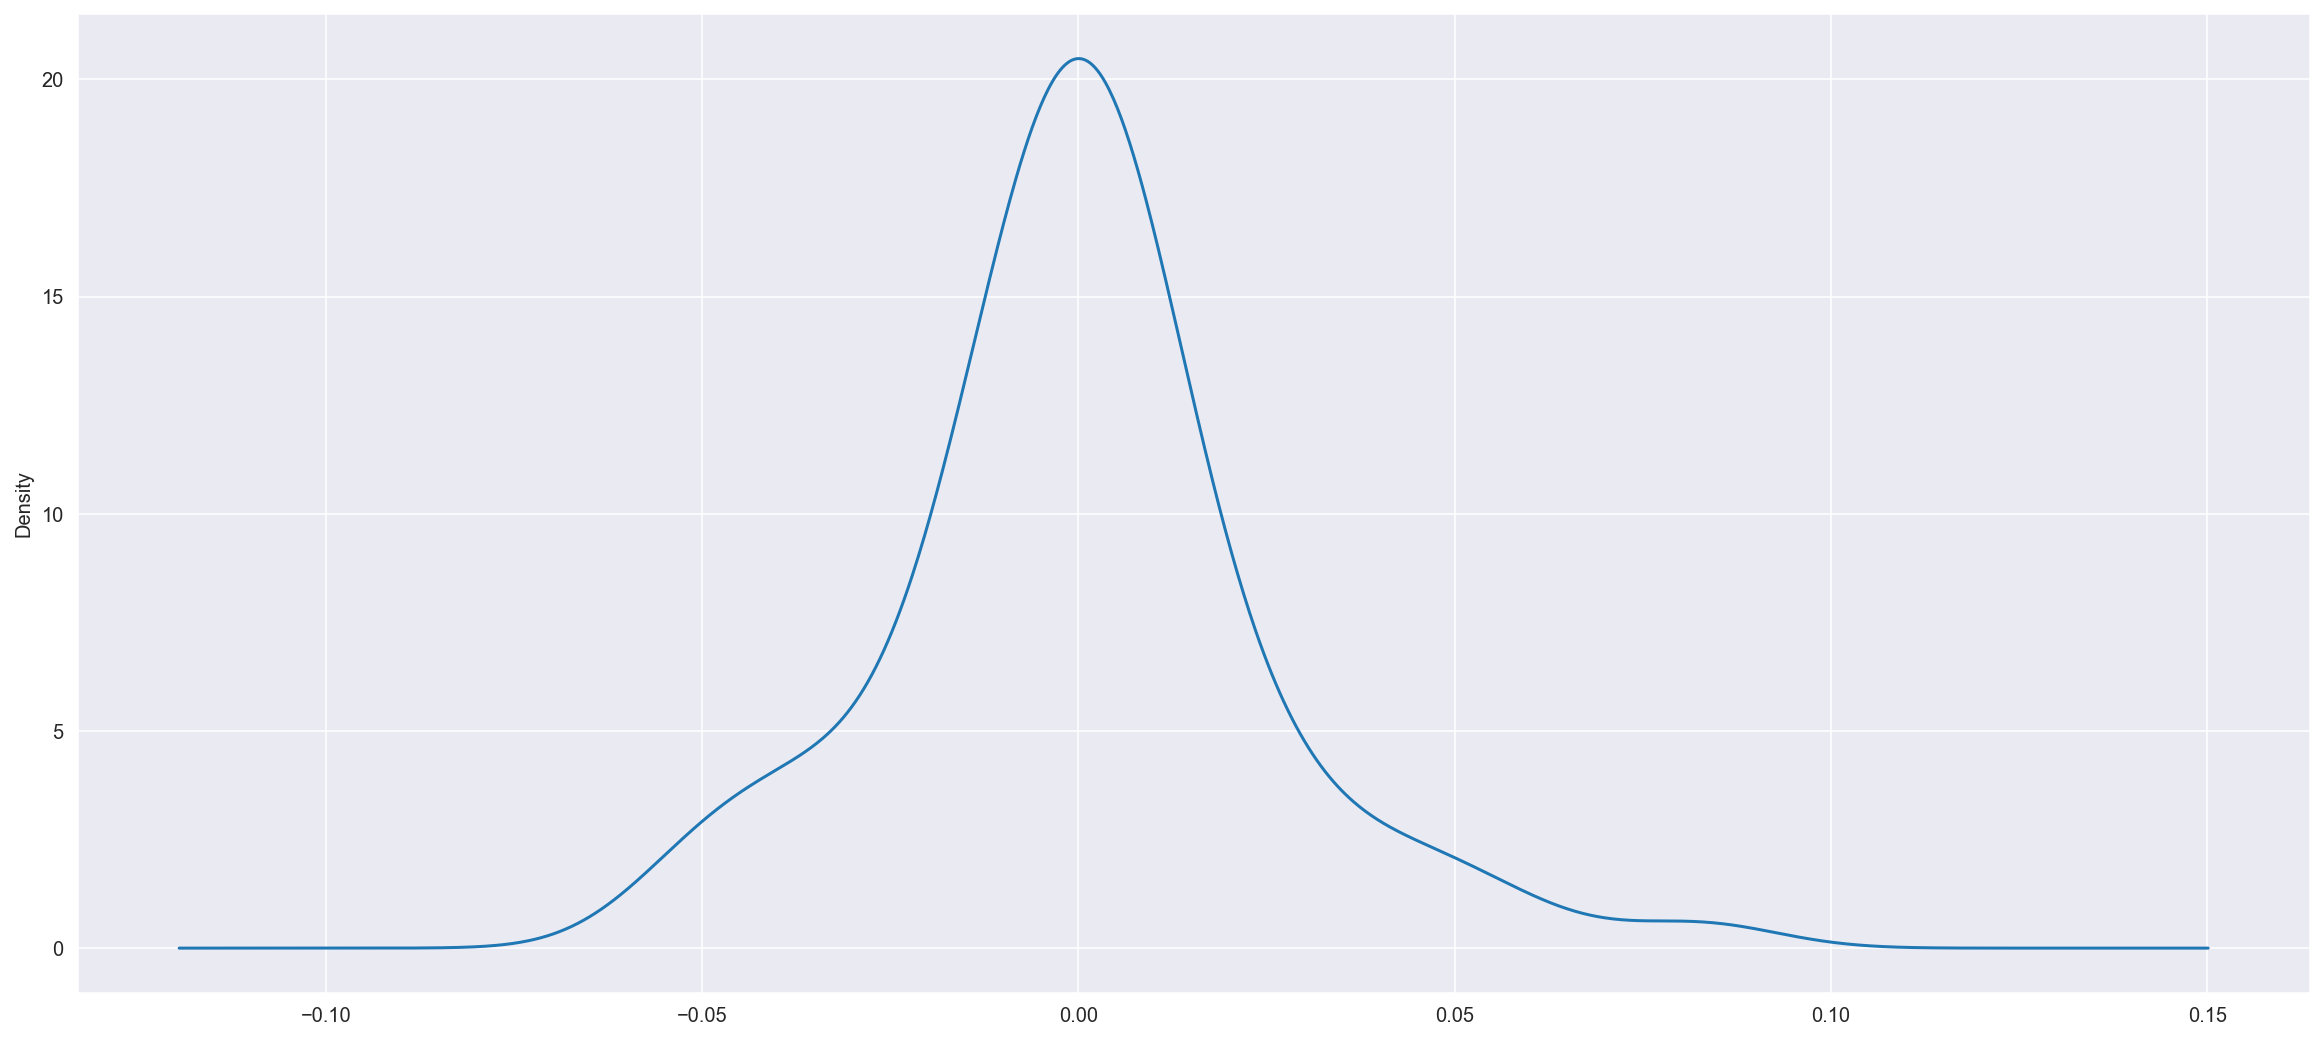

In [18]:
print('mean of residuals = ', FF5resid.mean())
FF5resid.plot(kind='kde')
plt.show()

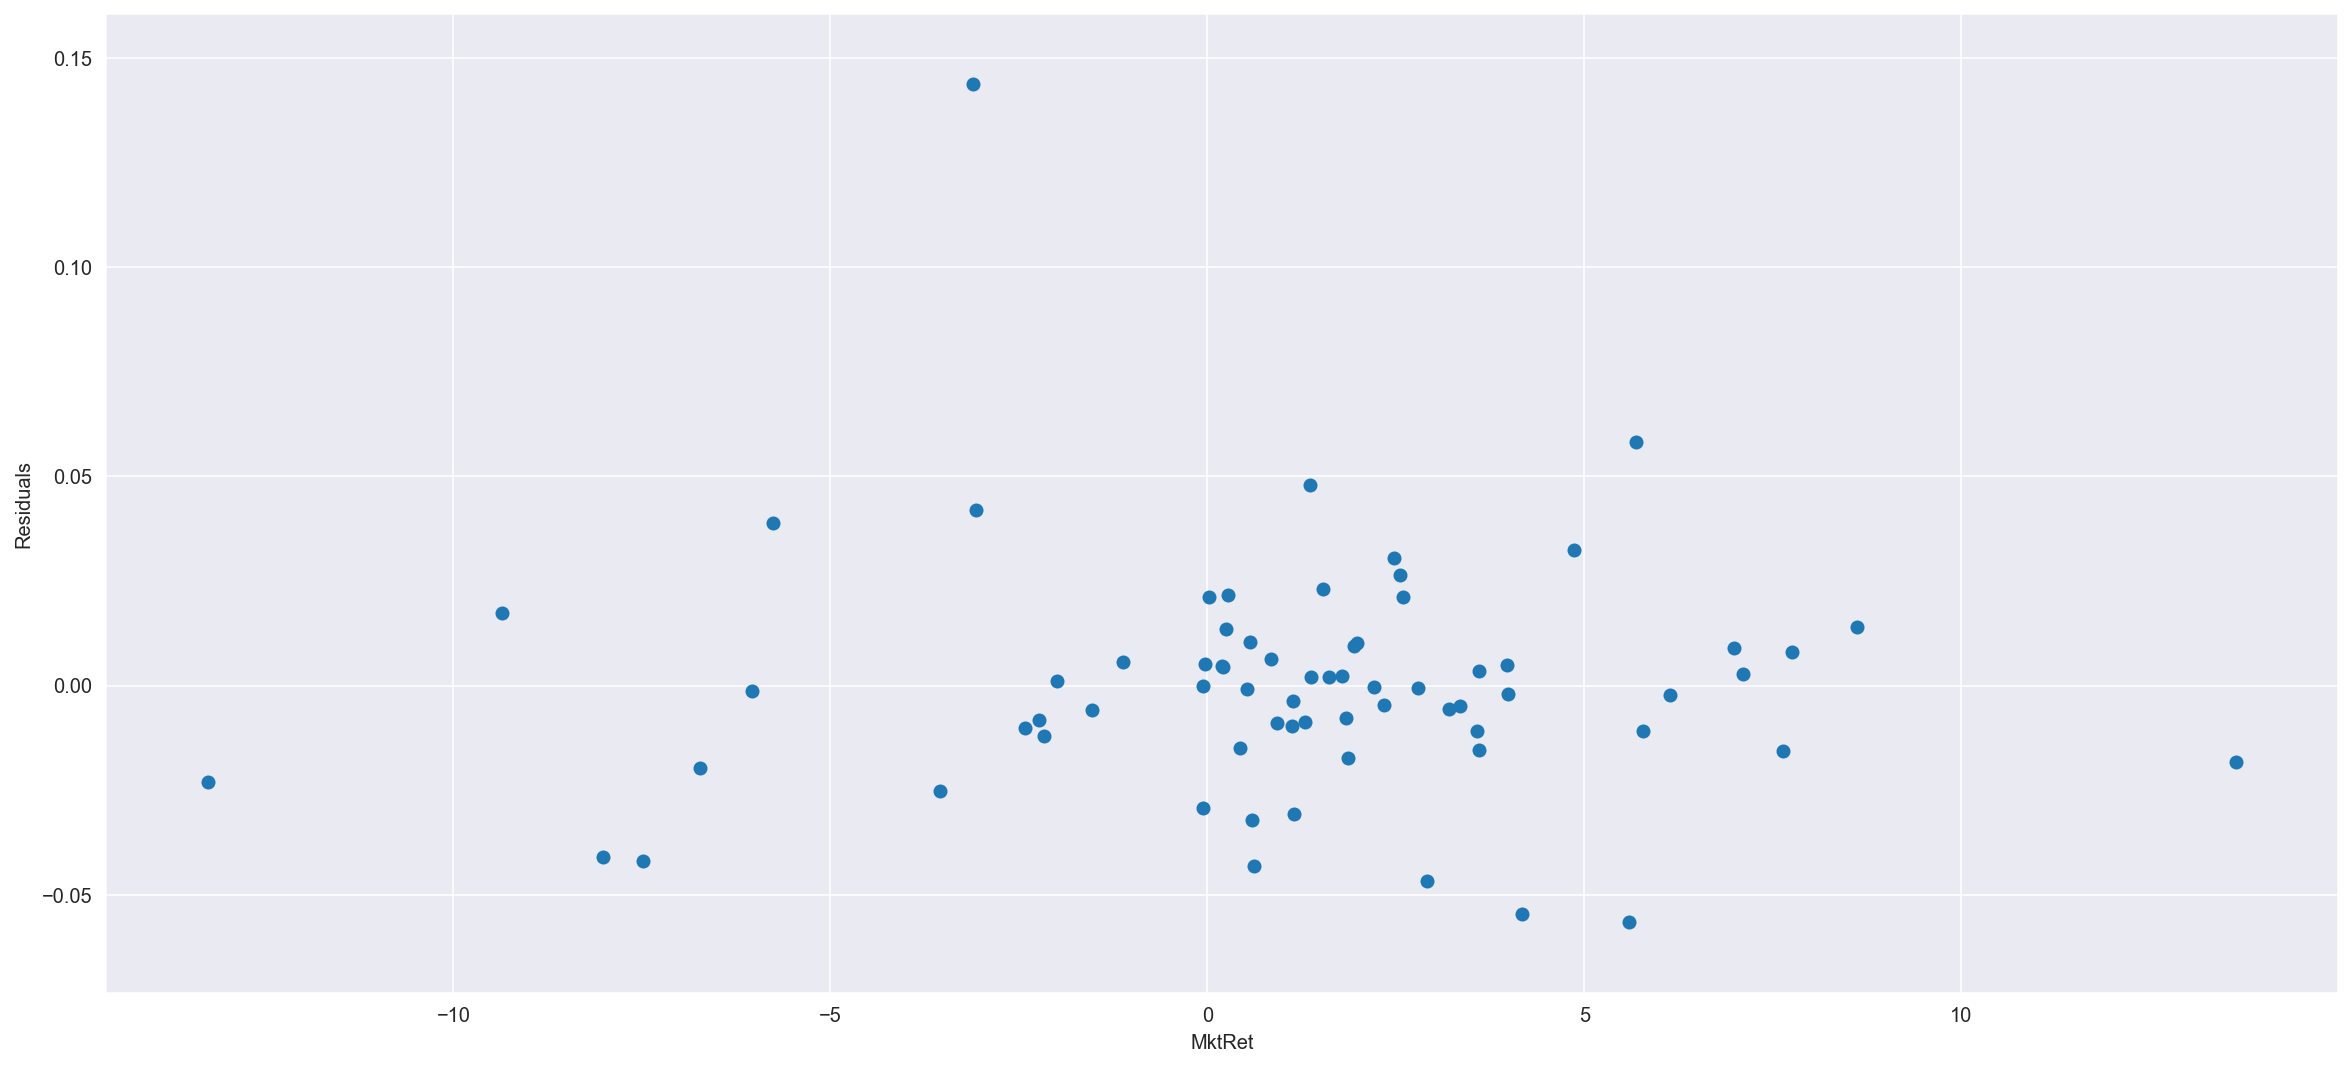

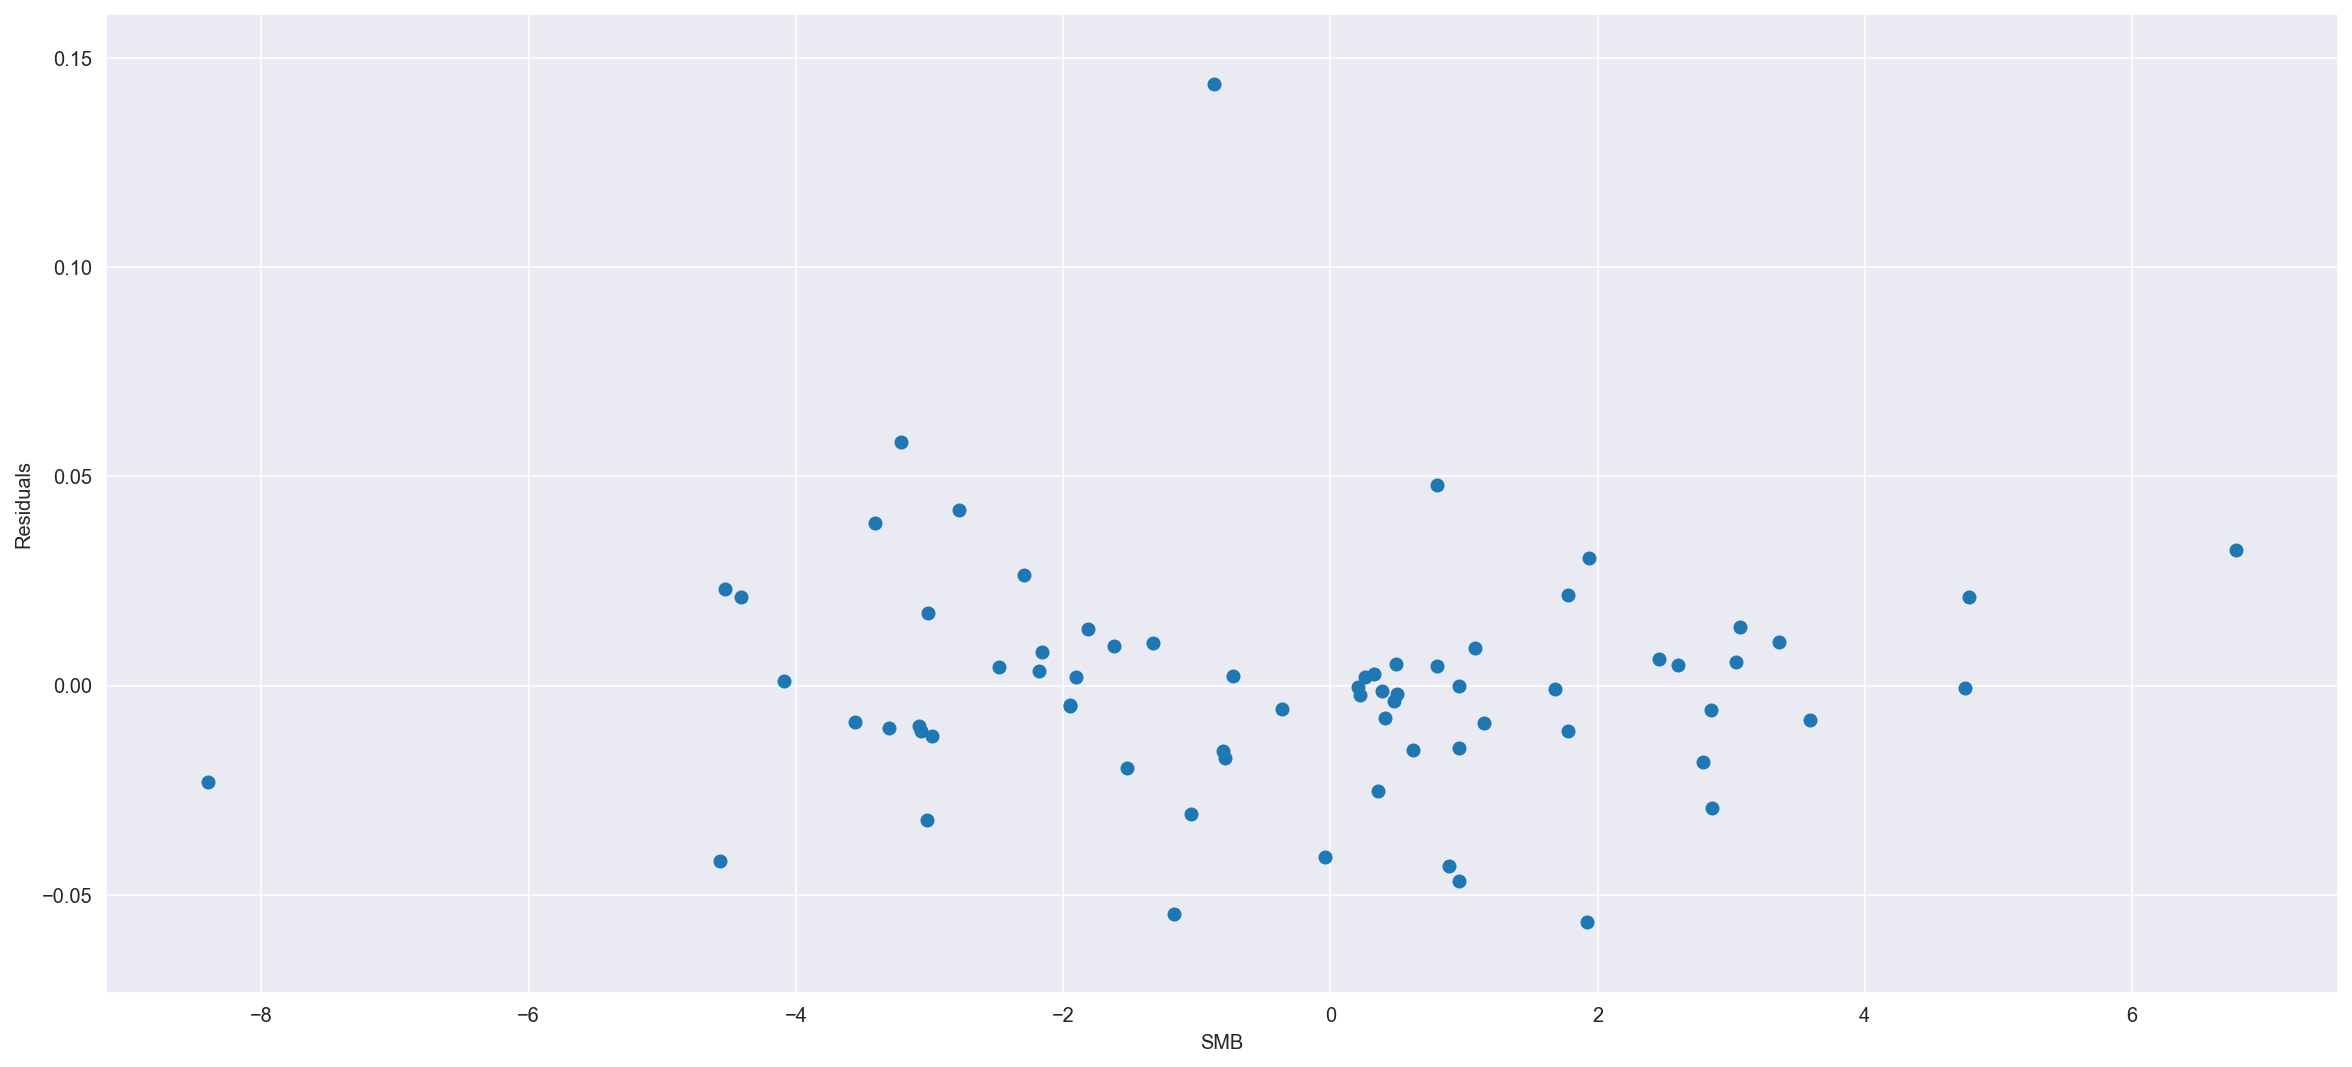

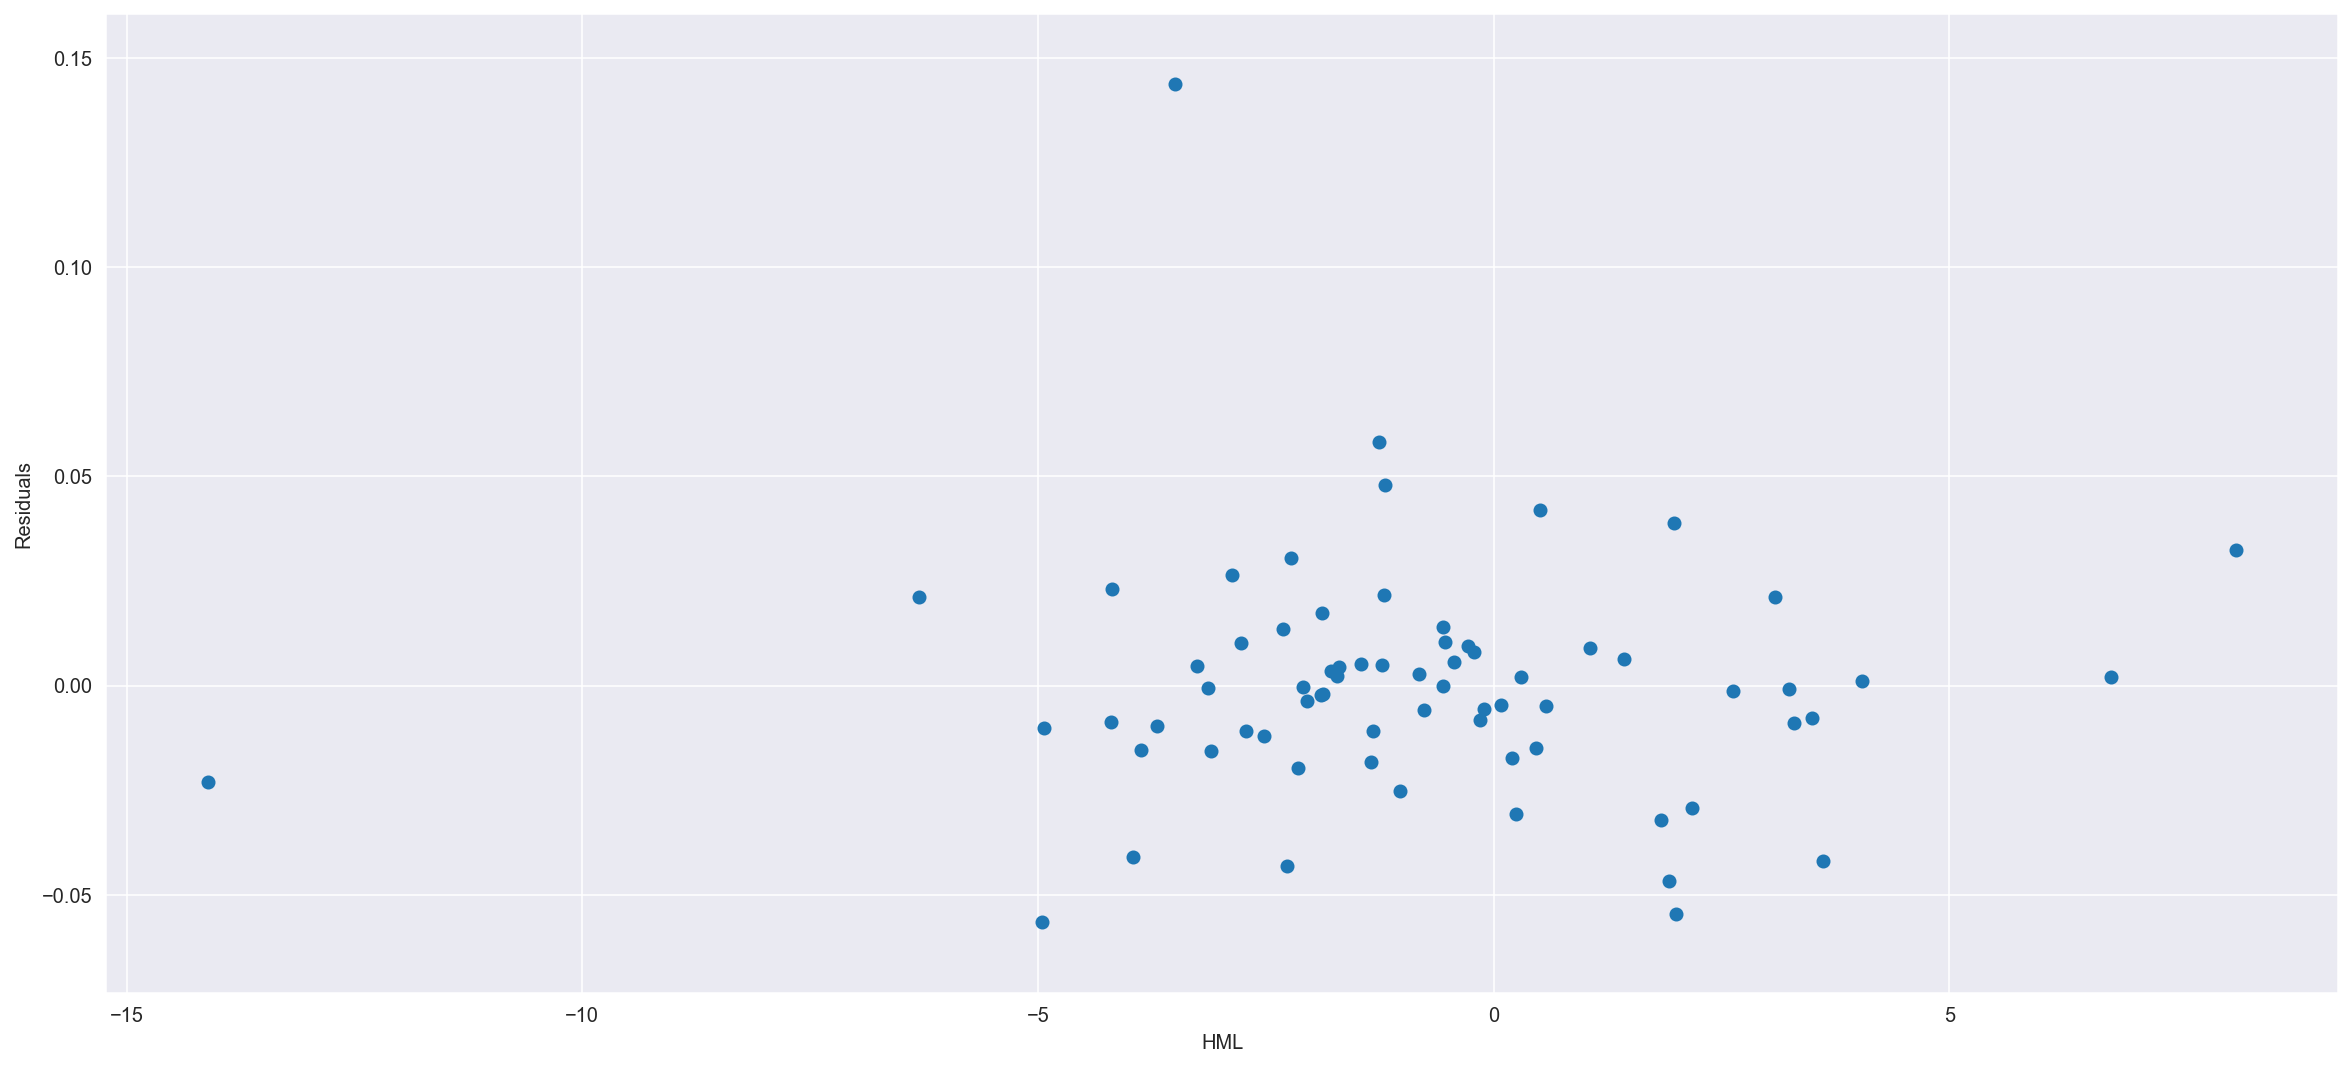

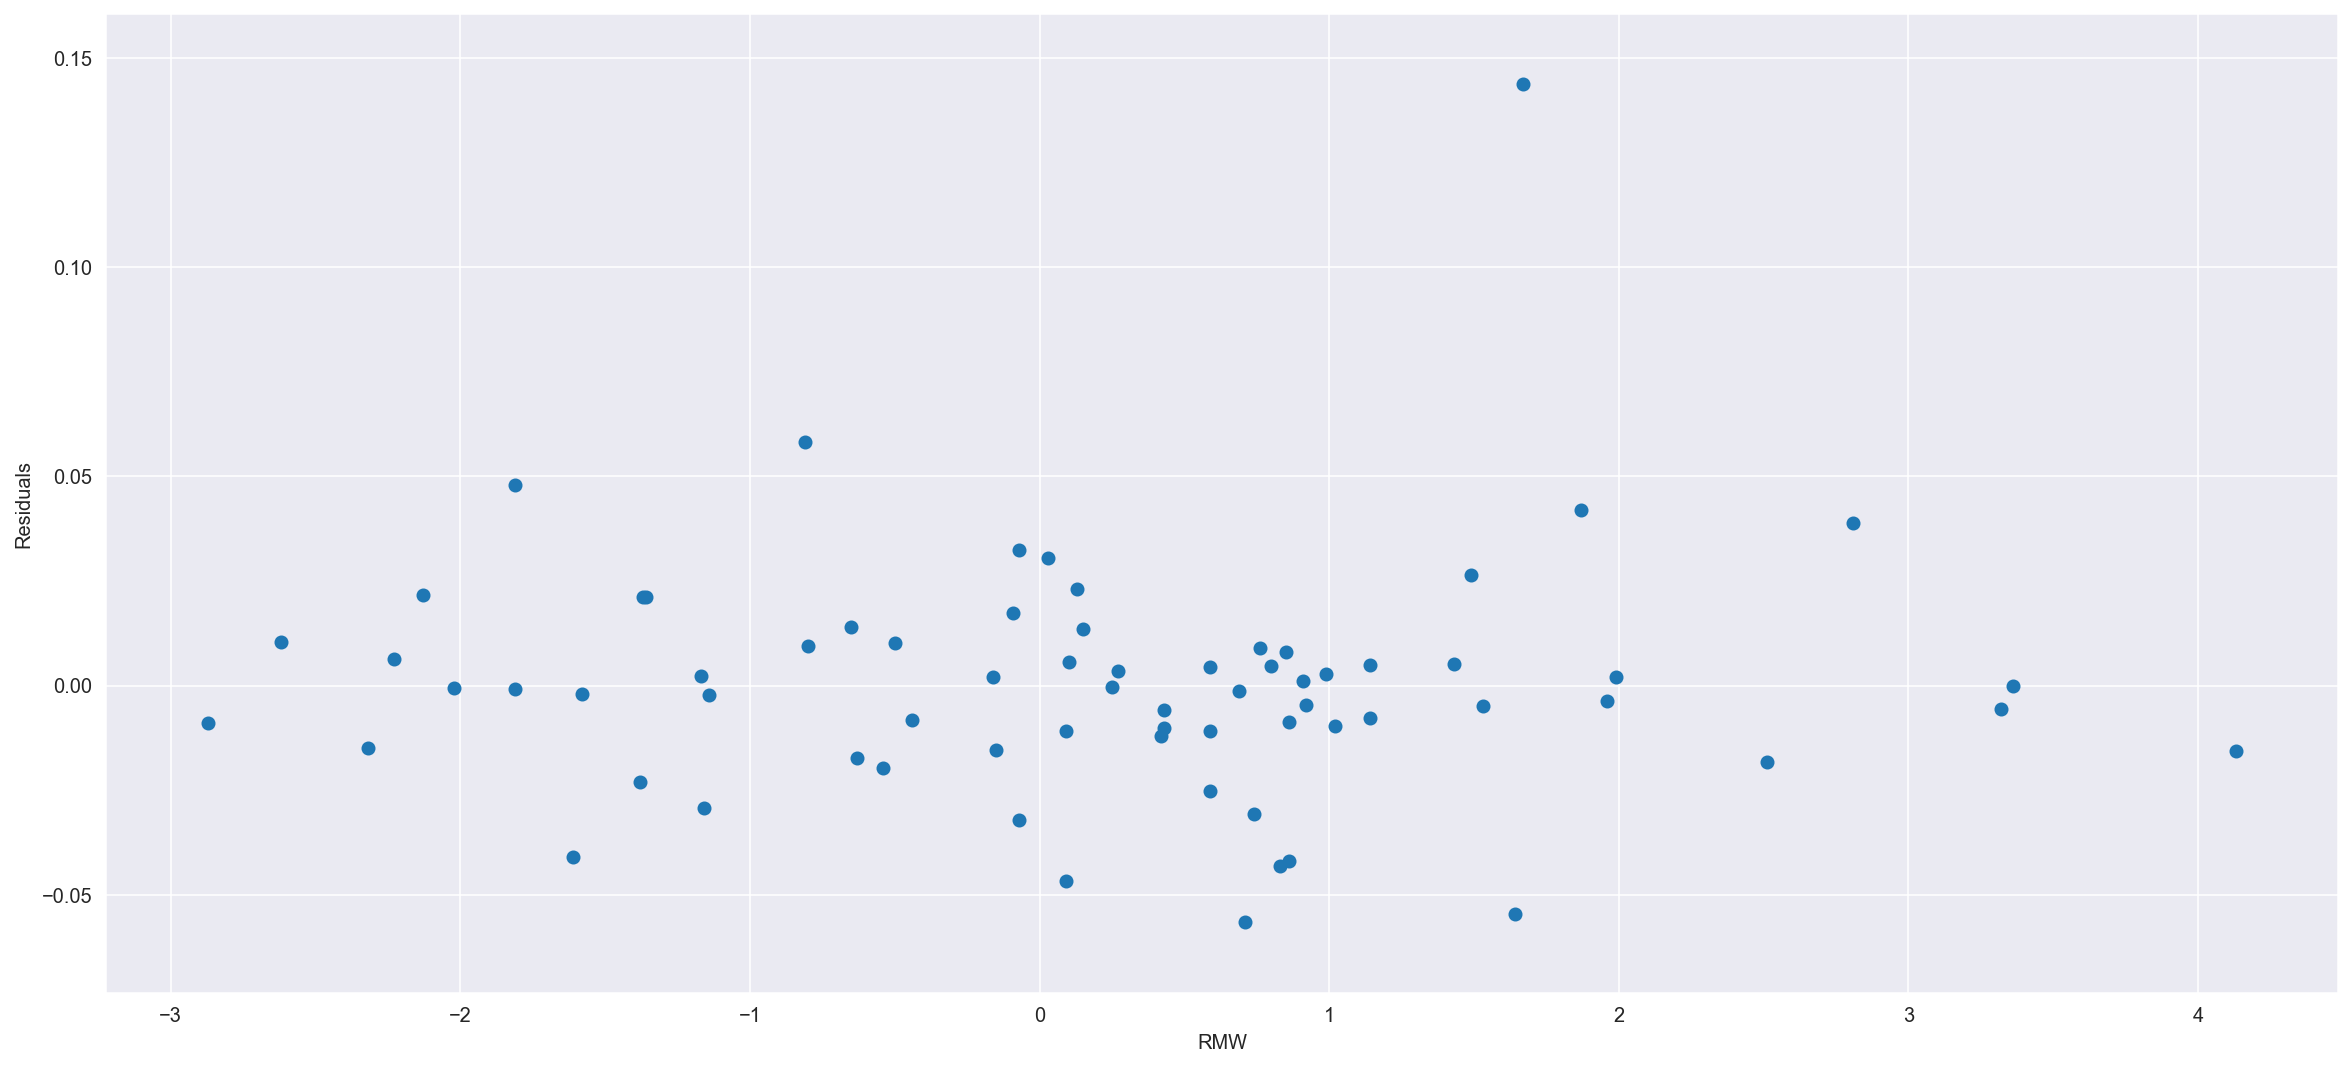

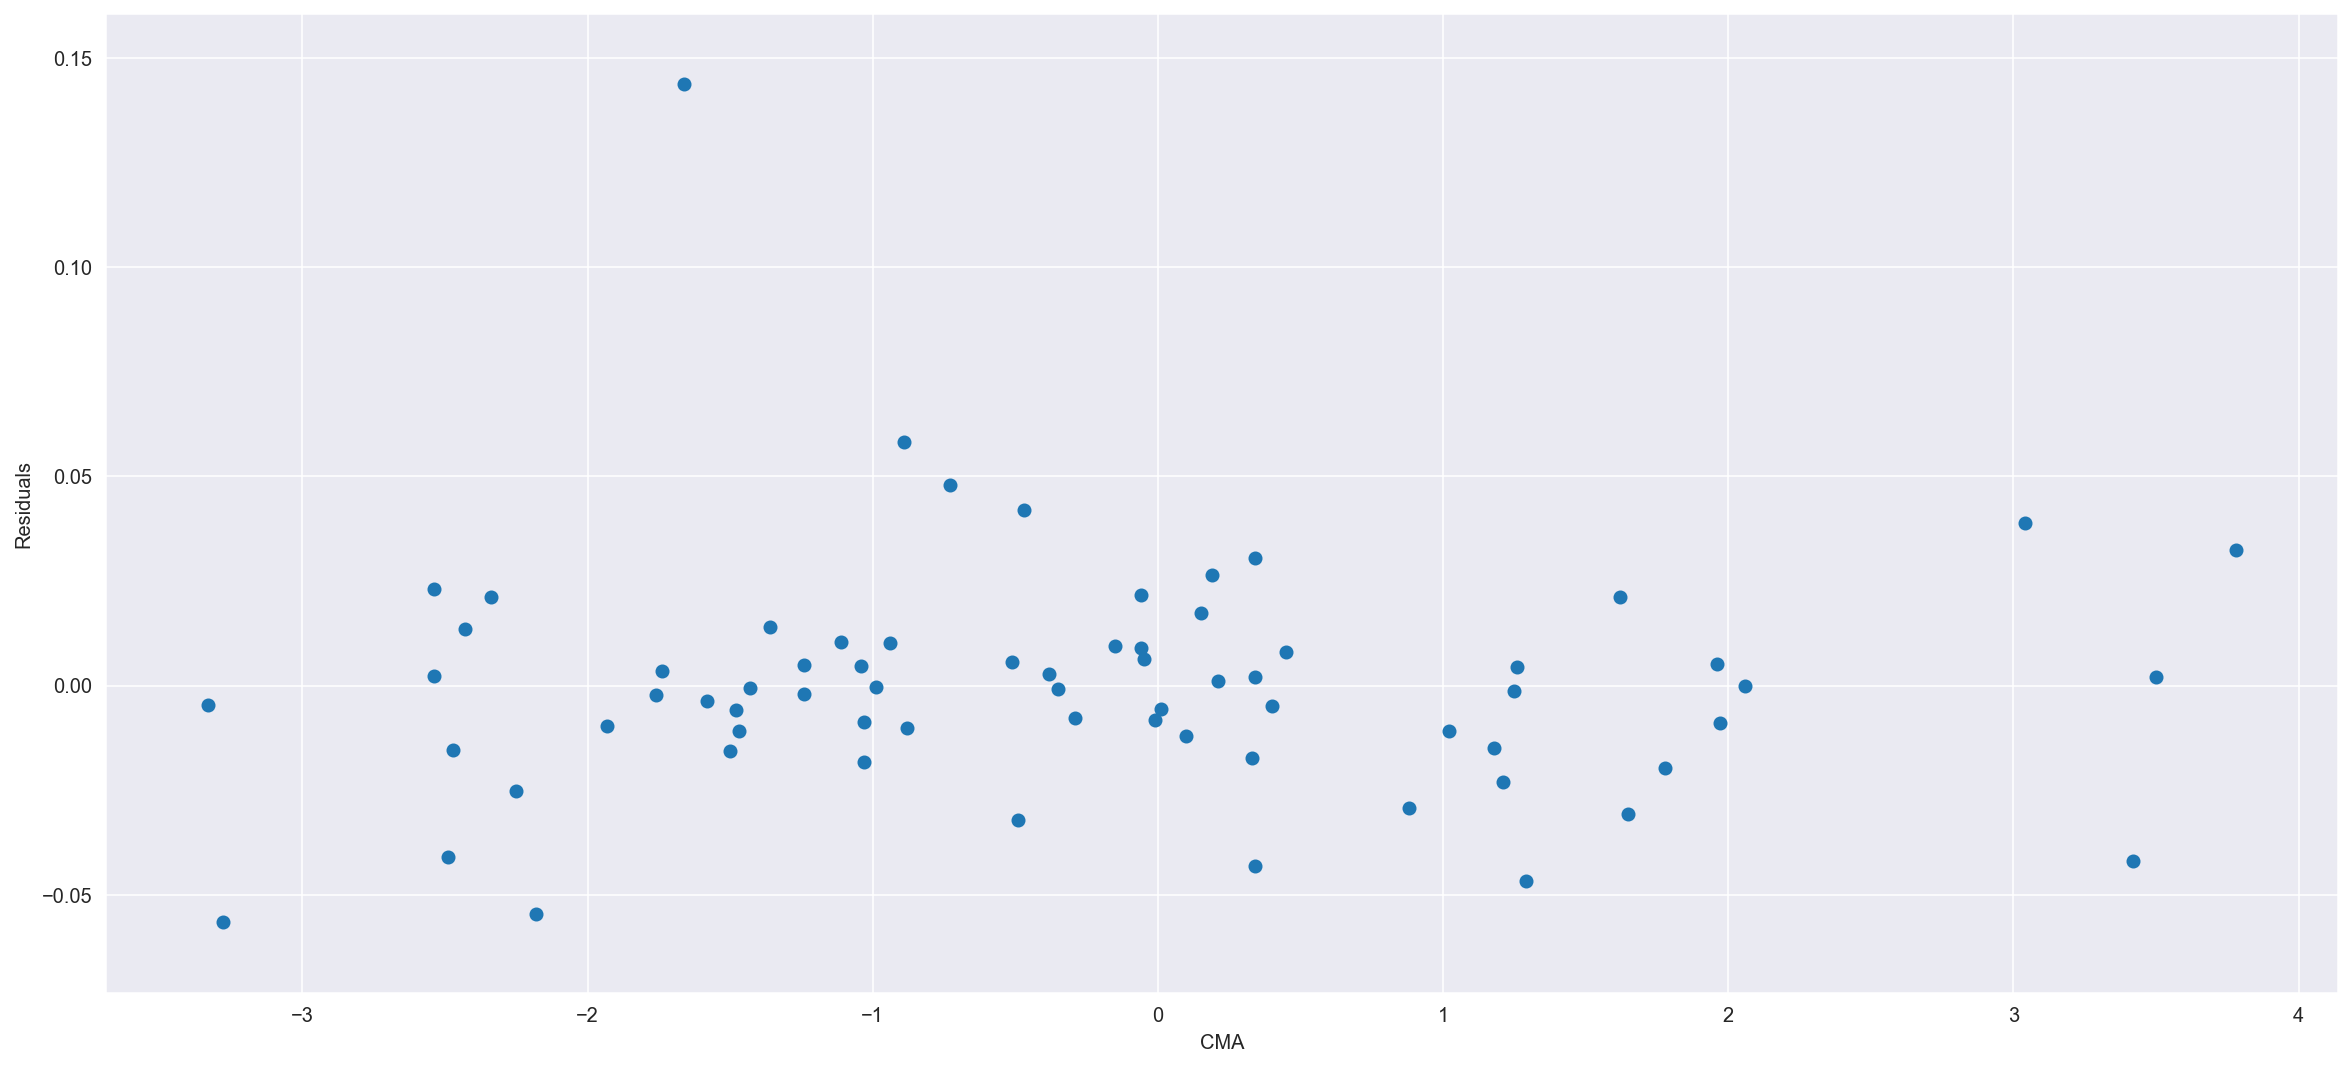

residuals
MktRet    -9.605307e-17
SMB       -9.196647e-17
HML        0.000000e+00
RMW        4.854950e-17
CMA        1.151848e-16
residuals  1.000000e+00

In [19]:
attributes = df_factors_2.columns
for att in attributes:
    plt.scatter(y = FF5resid, x = df_factors_2[att])
    plt.xlabel(att)
    plt.ylabel('Residuals')
    plt.show()
df = df_factors_2.copy()
df['residuals'] = FF5resid
df.corr()[['residuals']]

In [19]:
from scipy.stats.stats import pearsonr
# Pearson correlation coefficient
def pearson_corr_test(X_with_cons, model_resid):
    for column in X_with_cons.columns[1:]:
        corr_test = pearsonr(X_with_cons[column], model_resid)
        print(f'Variable: {column} --- correlation: {corr_test[0]:.4f}, p-value: {corr_test[1]:.4f}')
pearson_corr_test(X, FF5resid)

Variable: MktRet --- correlation: 0.0000, p-value: 1.0000
Variable: SMB --- correlation: -0.0000, p-value: 1.0000
Variable: HML --- correlation: -0.0000, p-value: 1.0000
Variable: RMW --- correlation: 0.0000, p-value: 1.0000
Variable: CMA --- correlation: 0.0000, p-value: 1.0000


Strict exogeneity is satisfied since residual mean is zero, and the correlation between residuals and X are really small. 

##### No Multicollinearity
There should be no linear relationship between the independent variables. 

**Looking at bivariate correlation. >0.8 is an indicator of multicollinearity.**

----------
Here are more potential indicators of multicollinearity:

1. Very high standard errors for regression coefficients
When standard errors are orders of magnitude higher than their coefficients, that’s an indicator.

2. The overall model is significant, but none of the coefficients are
Remember that a p-value for a coefficient tests whether the unique effect of that predictor on Y
is zero. If all predictors overlap in what they measure, there is little unique effect, even if 
the predictors as a group have an effect on Y.

3. Large changes in coefficients when adding predictors
If the predictors are completely independent of each other, their coefficients won’t change at 
all when you add or remove one. But the more they overlap, the more drastically their 
coefficients will change.

4. Coefficients have signs opposite what you’d expect from theory
Be careful here as you don’t want to disregard an unexpected finding as problematic. Not all 
effects opposite theory indicate a problem with the model. That said, it could be 
multicollinearity and warrants taking a second look at other indicators.

5. Coefficients on different samples are wildly different
If you have a large enough sample, split the sample in half and run the model separately on 
each half. Wildly different coefficients in the two models could be a sign of multicollinearity.

6. High Variance Inflation Factor (VIF) and Low Tolerance
These two useful statistics are reciprocals of each other. So either a high VIF or a low 
tolerance is indicative of multicollinearity. VIF is a direct measure of how much the variance 
of the coefficient (ie. its standard error) is being inflated due to multicollinearity. the square root of a given variable’s VIF shows how much larger the standard error is, compared with what it would be if that predictor were uncorrelated with the other features in the model. If no features are correlated, then all values for VIF will be 1. To deal with multicollinearity we should iteratively remove features with high values of VIF. A rule of thumb for removal could be VIF larger than 10 (5 is also common). Another possible solution is to use PCA to reduce features to a smaller set of uncorrelated components.

7. High Condition Indices
Condition indices are a bit strange.  The basic idea is to run a Principal Components Analysis 
on all predictors. If they have a lot of shared information, the first Principal Component 
will be much higher than the last. Their ratio, the Condition Index, will be high if 
multicollinearity is present.


In [20]:
# bivariate correlation
df_factors_2.corr()

MktRet       SMB       HML       RMW       CMA
MktRet  1.000000  0.386570  0.186500  0.148069 -0.245329
SMB     0.386570  1.000000  0.396809 -0.205962  0.036101
HML     0.186500  0.396809  1.000000  0.072740  0.507195
RMW     0.148069 -0.205962  0.072740  1.000000  0.079320
CMA    -0.245329  0.036101  0.507195  0.079320  1.000000

In [21]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
def VIF_test(X_constant_added):
    vif = [variance_inflation_factor(X_constant_added.values, i) for i in range(X_constant_added.shape[1])]
    VIF_df = pd.DataFrame({'vif': vif}, index=X_constant_added.columns).T
    VIF_df = VIF_df[VIF_df.columns[1:]]
    return VIF_df
VIF_test(X)

MktRet       SMB       HML       RMW       CMA
vif  1.453957  1.513988  1.779299  1.157794  1.630071

No Multicollinearity is satisfied. (Indicator of strong Multicollinearity: corr > 0.8, VIF >5)

##### Spherical error variance
There is homoscedasticity and no autocorrelation.

- The error terms in the regression should all have the same variance.
    (Heteroscedastic errors: error variance is not constant, i.e. depend on Xs.)
- The error terms of different observations should not be correlated with each other, i.e.error terms should be IID (Independent and Identically Distributed).

When we have time series data, then the regression is likely to suffer from autocorrelation because data next year will most likely be dependent on data this year. Hence, error terms in different observations will surely be correlated with each other.

Check for autocorrelation by viewing the residual time series plot. If autocorrelation is present in the model, we can try taking lags of independent variables to correct for the trend component. If you do not correct for autocorrelation, then OLS estimates won’t be BLUE, and they won’t be reliable enough.

We can also use two statistical tests: **Breusch-Pagan** and **Goldfeld-Quandt**. In both of them, the null hypothesis **H0** assumes homoscedasticity:

p-value <0.05 : reject the null, conclude heteroscedasticity.

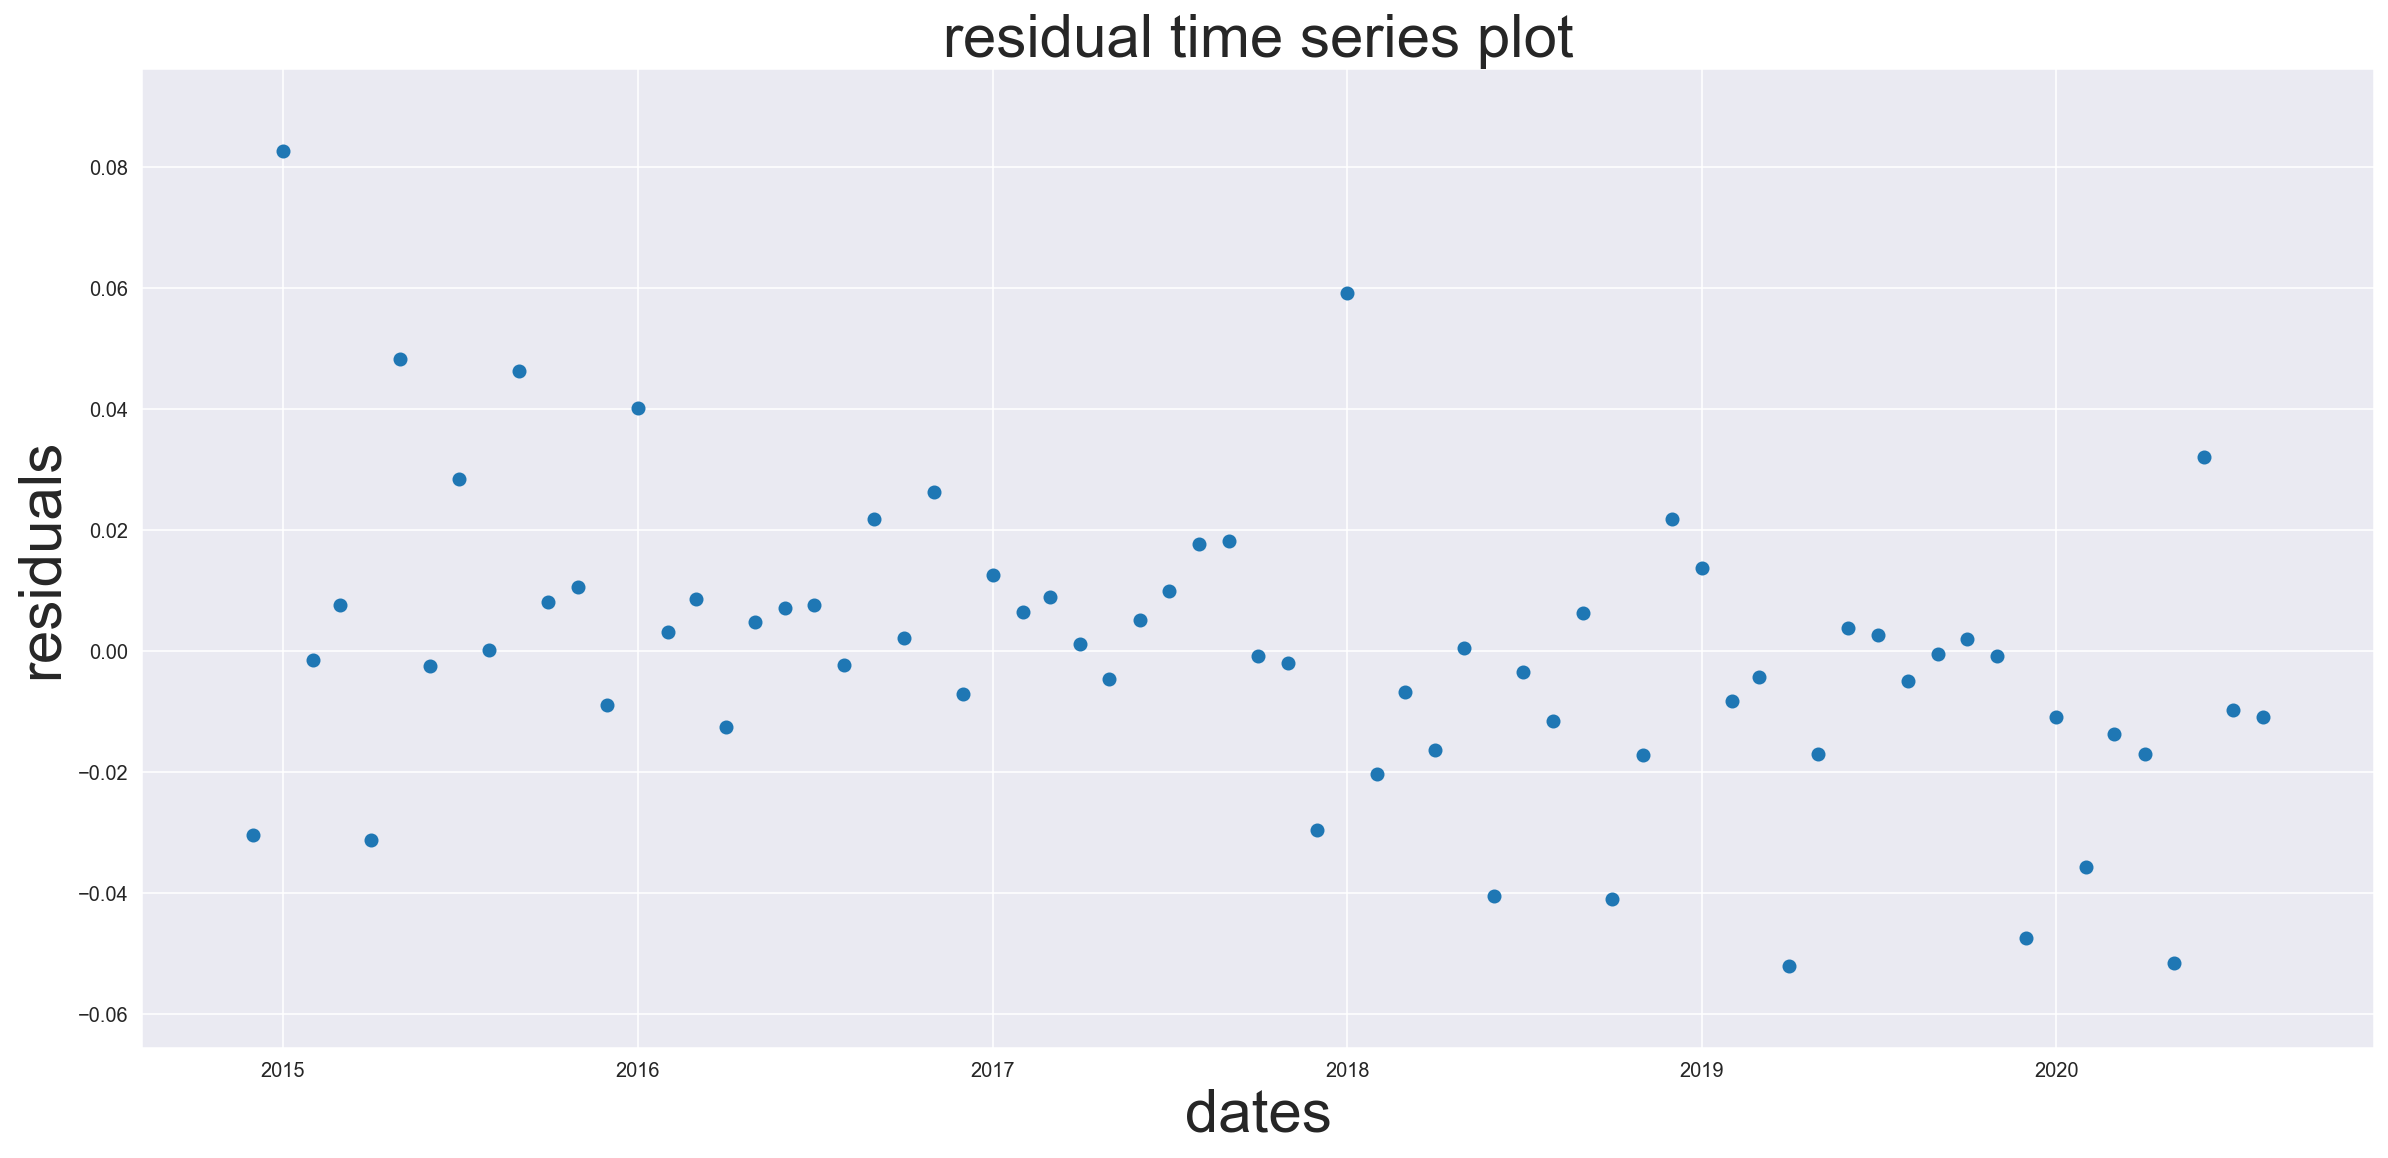

In [22]:
# to see constant variance of error terms
plt.scatter(y = FF5resid, x = df_factors_2.index)
# FF5resid.plot(style='.-')
plt.title('residual time series plot', fontsize = 30)
plt.ylabel('residuals', fontsize = 30)
plt.xlabel('dates', fontsize = 30)
plt.show()


 Breusch-Pagan test ----
                                  value
Lagrange multiplier statistic  2.831189
p-value                        0.725992
f-value                        0.539121
f p-value                      0.745876
Fail to Reject Null, conclude homoscedasticity

 Goldfeld-Quandt test ----
                value
F statistic  1.106732
p-value      0.393383
Fail to Reject Null, conclude homoscedasticity

 Residuals plots ----


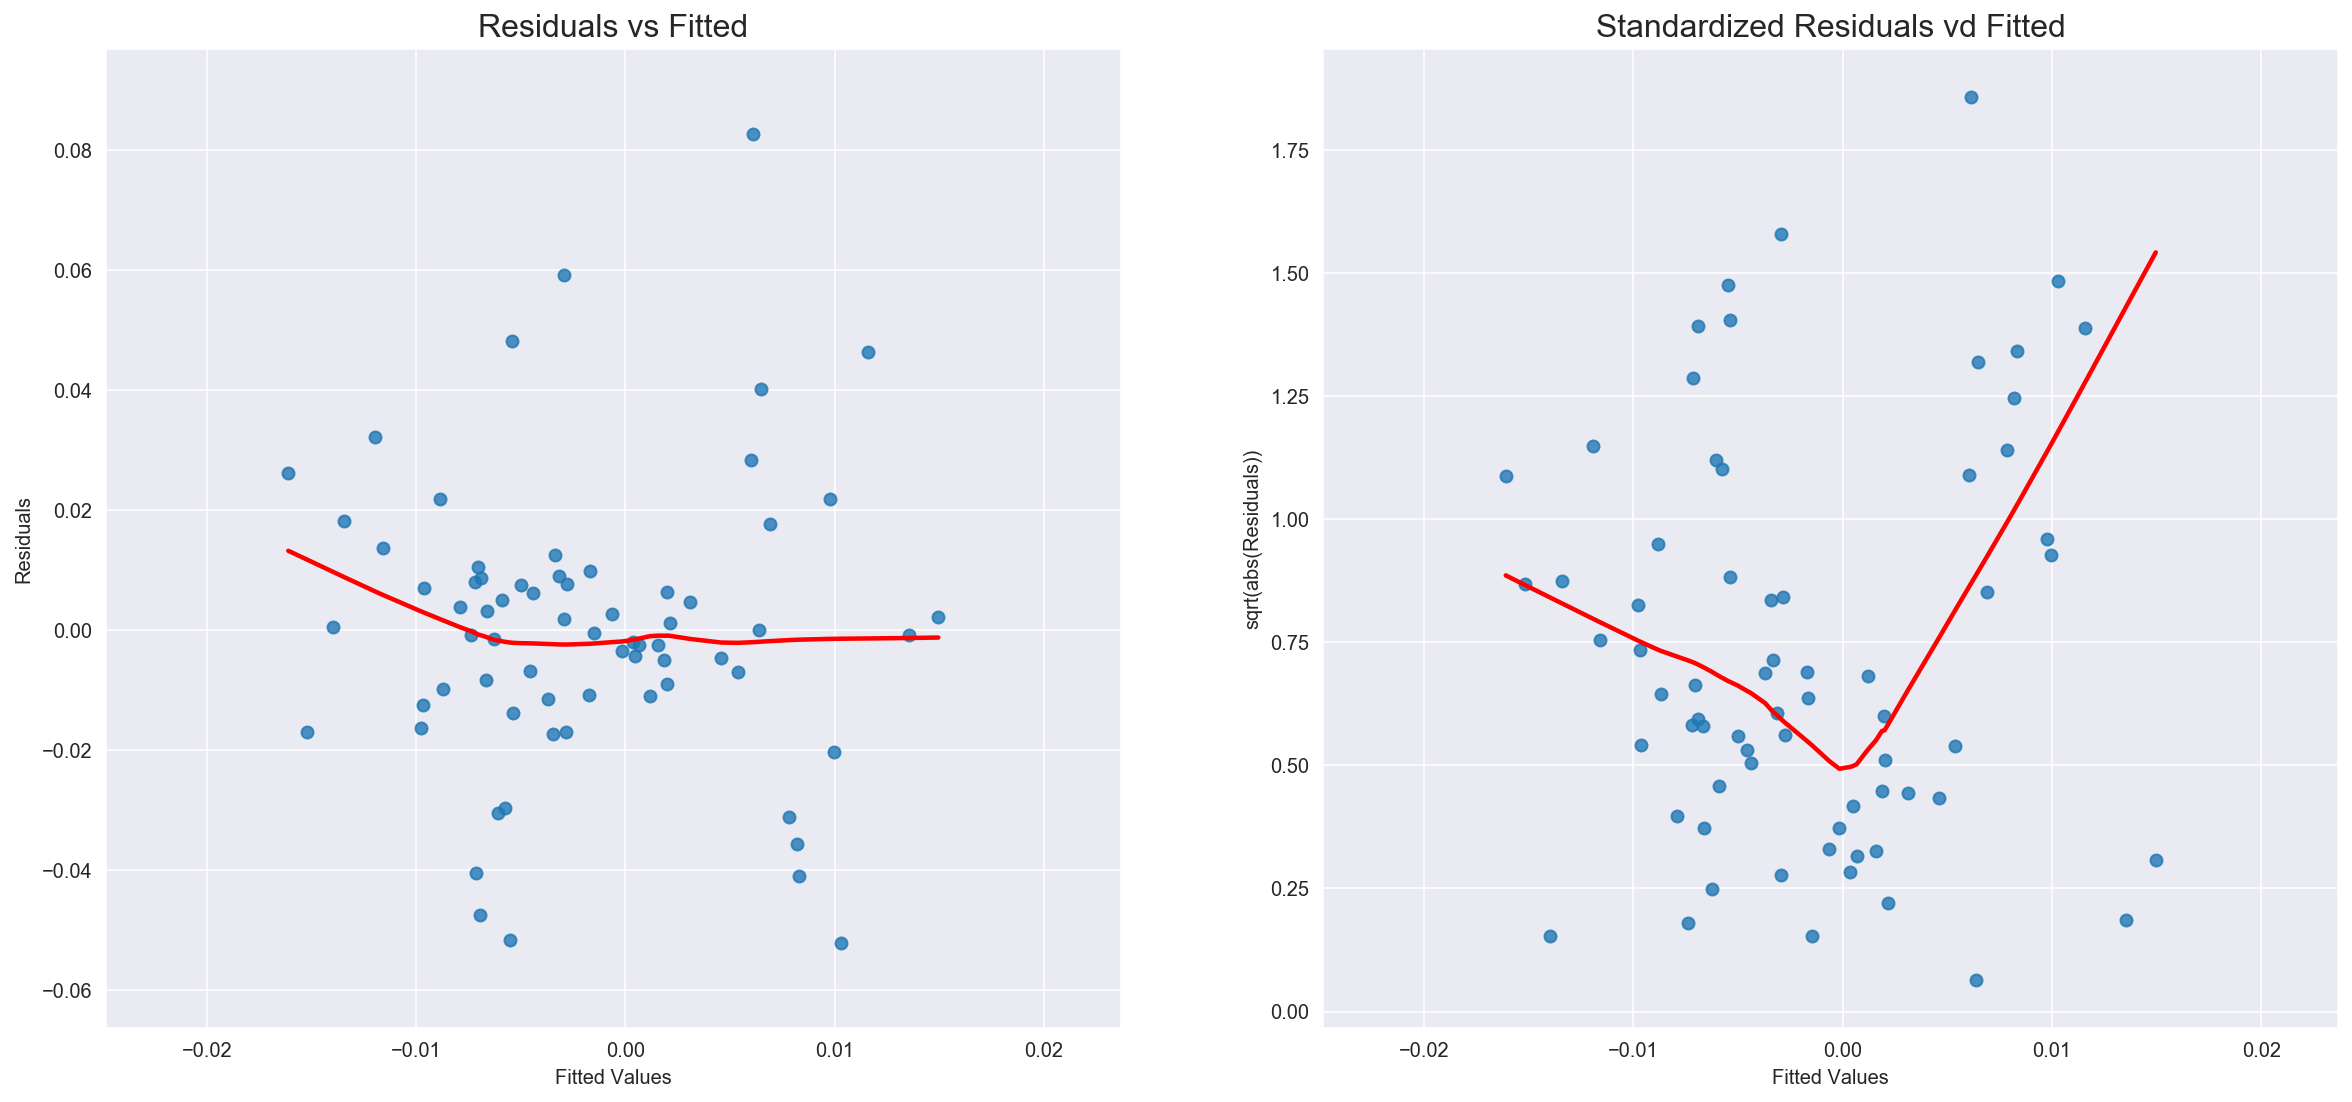

In [23]:
def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Standardized Residuals vd Fitted', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])
    def conclude(score):
        if score < 0.05:
            print('Reject Null, conclude heteroscedasticity')
        else:
            print('Fail to Reject Null, conclude homoscedasticity')
            
    print('\n Breusch-Pagan test ----')
    print(bp_test)
    conclude(bp_test.loc['p-value'].values)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    conclude(gq_test.loc['p-value'].values)
    print('\n Residuals plots ----')

homoscedasticity_test(result_monthly)

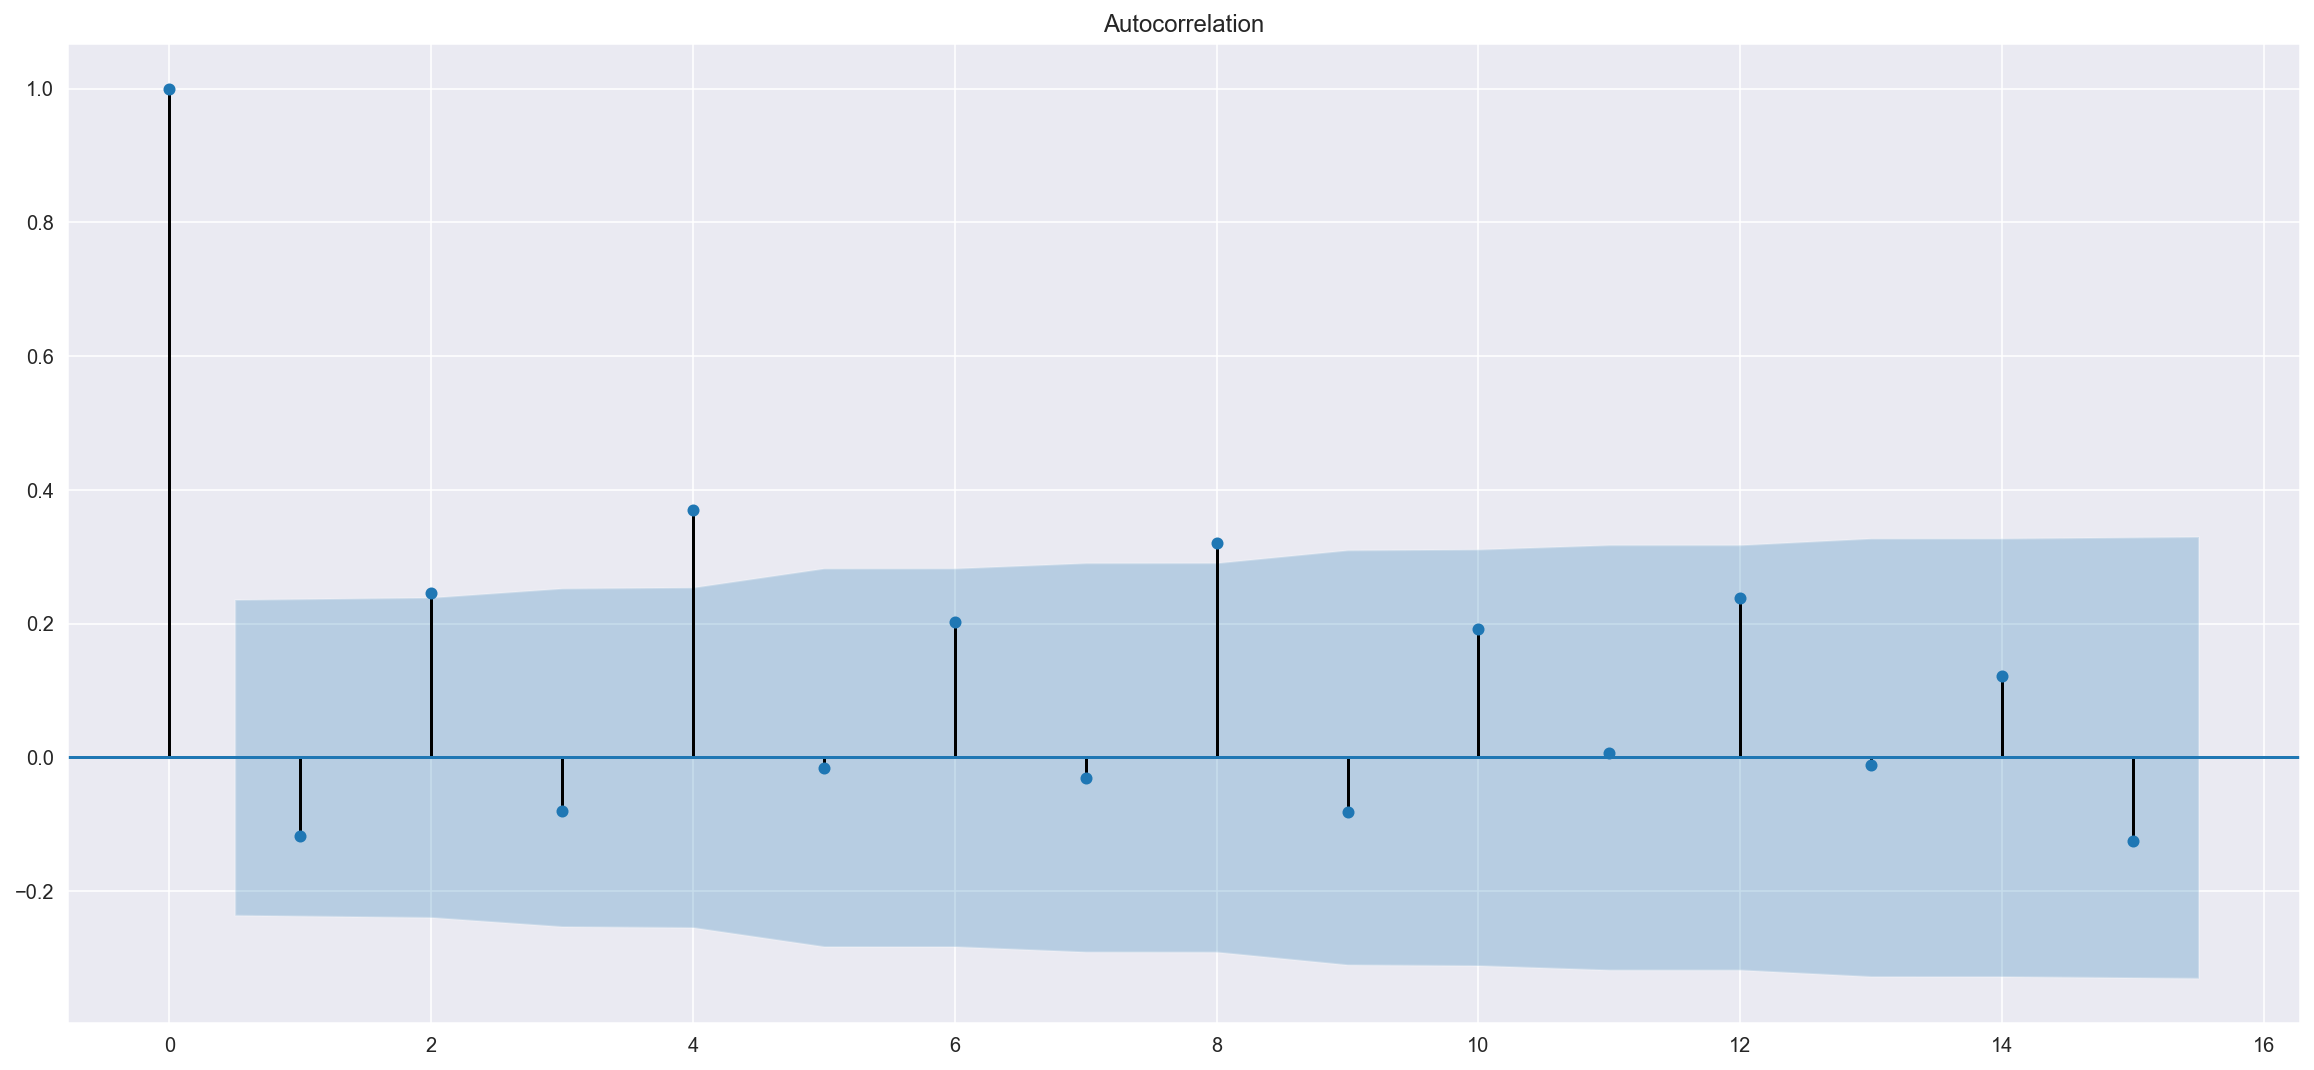

In [42]:
# check autocorrelation of error terms
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(FF5resid, lags = 15)
plt.show()

Spherical error variance is sort of satisfied since we see a roughtly constant residual variance over time, and there is no strong evidence of autocorrelation of residuals.

##### Normality:

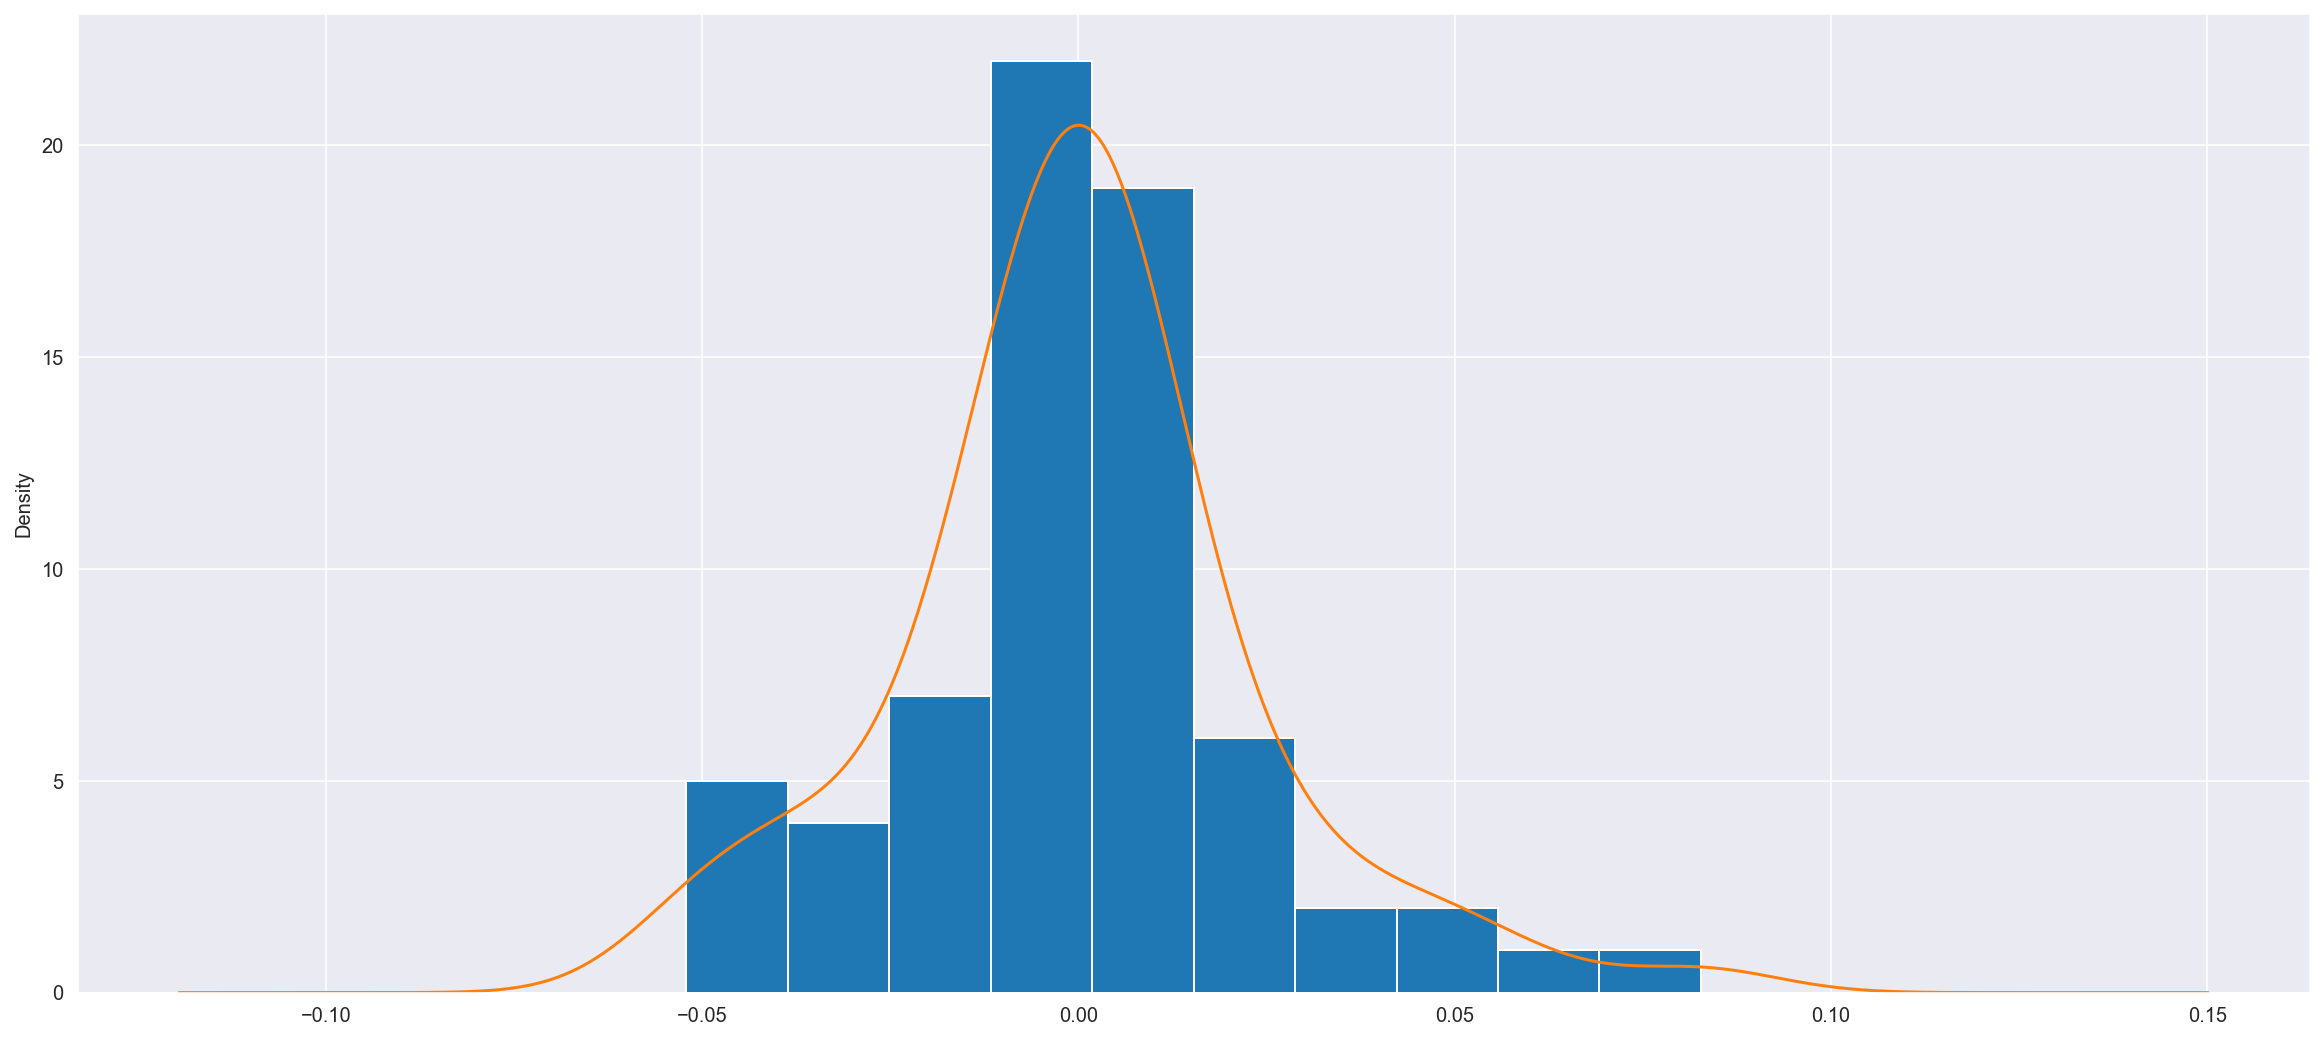

In [24]:
FF5resid.hist()
FF5resid.plot(kind='kde')
plt.show()

roughly Normal.

### (e) Provide a financial/economic interpretation of your results from (c).

Don't think monthly data give me a deep insight of the relationship between market and AQR. See Daily Data exploration below with more explaination:)

### (f) Extra credit: Download and import the monthly data of the 10 Industry Portfolios model from Ken French’s data library. The 10 Industry Portfolios model is described here. Then perform the analysis (c)-(e) using this data.

###### Data Gathering:

In [25]:
portfolio_factors = web.DataReader('10_Industry_Portfolios', 'famafrench', start = '1925-01-01', end = '2020-10-01')[0]
portfolio_factors = portfolio_factors.to_timestamp()
start_date_portfolio_factors = portfolio_factors.index[0]
end_date_portfolio_factors = portfolio_factors.index[-1]
portfolio_factors

NoDur  Durbl  Manuf  Enrgy  HiTec  Telcm  Shops  Hlth   Utils  \
Date                                                                        
1926-07-01   1.45  15.55   4.69  -1.18   2.90   0.83   0.11   1.77   7.04   
1926-08-01   3.97   3.68   2.81   3.47   2.66   2.17  -0.71   4.25  -1.69   
1926-09-01   1.14   4.80   1.15  -3.39  -0.38   2.41   0.21   0.69   2.04   
1926-10-01  -1.24  -8.23  -3.63  -0.78  -4.58  -0.11  -2.29  -0.57  -2.63   
1926-11-01   5.20  -0.19   4.10   0.01   4.71   1.63   6.43   5.42   3.71   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2020-06-01  -0.03  14.20   2.56  -0.37   6.00  -2.44   4.21  -1.76  -5.04   
2020-07-01   5.85  18.73   4.48  -4.77   6.90   5.09   9.53   4.44   6.37   
2020-08-01   4.43  40.86   6.27  -1.14  10.60   5.45   8.13   2.77  -2.25   
2020-09-01  -2.06  -9.02  -0.01 -14.94  -5.18  -2.20  -3.83  -1.51  -0.27   
2020-10-01  -2.61  -3.17  -0.77  -4.53  -1.88  -3.90  -2.53  -4.29   4.49   

            Other  
Date               
1926-07-01   2.16  
1926-08-01   4.38  
1926-09-01   0.29  
1926-10-01  -2.85  
1926-11-01   2.11  
...           ...  
2020-06-01   0.00  
2020-07-01   3.62  
2020-08-01   7.20  
2020-09-01  -2.92  
2020-10-01  -2.03  

[1132 rows x 10 columns]

In [26]:
start3 = max(start_date_portfolio_factors, start_date_hf)
end3 = min(end_date_portfolio_factors, end_date_hf)
print('For scatter plots, we need consistent start/end dates for two datasets:')
print('start_date: ', str(start3)[:7])
print('end_date: ', str(end3)[:7])
portfolio_factors_3 = portfolio_factors.loc[start3:end3]
df_AQR_return_3 = df_AQR_return.loc[start3:end3]

For scatter plots, we need consistent start/end dates for two datasets:
start_date:  2014-12
end_date:  2020-10


##### Regression:
**Based on requirements, I use the following regression model:**
$$ AQR Return = b_0 + b_1NoDur + b_2Durbl + b_3Manuf + b_4Enrgy + b_5HiTec$$
$$ + b_6Telcm + b_7Shops + b_8Hlth + b_9Utils + b_{10}Other + \epsilon_i $$


In [29]:
# All data we gonna use:
df_stock_factor_portfolio = pd.merge(df_AQR_return_3, portfolio_factors_3, left_index=True, right_index=True)
df_stock_factor_portfolio = df_stock_factor_portfolio.replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()
# df_stock_factor_portfolio.to_csv(r'model2_Data.csv')
df_stock_factor_portfolio

Return  NoDur  Durbl  Manuf  Enrgy  HiTec  Telcm  Shops  Hlth   \
Date                                                                           
2014-12-01 -0.036574  -2.36   0.58  -0.18   0.41  -1.28  -1.74   1.59  -0.88   
2015-01-01  0.088837  -0.55  -4.19  -3.86  -4.37  -3.29  -4.90  -0.30   1.56   
2015-02-01 -0.007767   5.03   8.08   6.23   4.82   8.28   9.10   5.56   4.31   
2015-03-01  0.004892  -2.43  -0.40  -2.02  -2.67  -2.45  -2.21   0.70   0.84   
2015-04-01 -0.023369   0.81  -0.93  -0.63   6.97   1.34   3.40  -2.18  -1.40   
...              ...    ...    ...    ...    ...    ...    ...    ...    ...   
2020-06-01  0.020177  -0.03  14.20   2.56  -0.37   6.00  -2.44   4.21  -1.76   
2020-07-01 -0.018541   5.85  18.73   4.48  -4.77   6.90   5.09   9.53   4.44   
2020-08-01 -0.012594   4.43  40.86   6.27  -1.14  10.60   5.45   8.13   2.77   
2020-09-01  0.001275  -2.06  -9.02  -0.01 -14.94  -5.18  -2.20  -3.83  -1.51   
2020-10-01 -0.021656  -2.61  -3.17  -0.77  -4.53  -1.88  -3.90  -2.53  -4.29   

            Utils  Other  
Date                      
2014-12-01   1.85   1.13  
2015-01-01   1.18  -6.12  
2015-02-01  -4.37   6.86  
2015-03-01  -0.28  -0.75  
2015-04-01   0.30   0.51  
...           ...    ...  
2020-06-01  -5.04   0.00  
2020-07-01   6.37   3.62  
2020-08-01  -2.25   7.20  
2020-09-01  -0.27  -2.92  
2020-10-01   4.49  -2.03  

[71 rows x 11 columns]

In [30]:
# regressors: 5 Factors
X_portfolio = df_stock_factor_portfolio[df_stock_factor_portfolio.columns[1:]]   
X_portfolio

NoDur  Durbl  Manuf  Enrgy  HiTec  Telcm  Shops  Hlth   Utils  \
Date                                                                        
2014-12-01  -2.36   0.58  -0.18   0.41  -1.28  -1.74   1.59  -0.88   1.85   
2015-01-01  -0.55  -4.19  -3.86  -4.37  -3.29  -4.90  -0.30   1.56   1.18   
2015-02-01   5.03   8.08   6.23   4.82   8.28   9.10   5.56   4.31  -4.37   
2015-03-01  -2.43  -0.40  -2.02  -2.67  -2.45  -2.21   0.70   0.84  -0.28   
2015-04-01   0.81  -0.93  -0.63   6.97   1.34   3.40  -2.18  -1.40   0.30   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2020-06-01  -0.03  14.20   2.56  -0.37   6.00  -2.44   4.21  -1.76  -5.04   
2020-07-01   5.85  18.73   4.48  -4.77   6.90   5.09   9.53   4.44   6.37   
2020-08-01   4.43  40.86   6.27  -1.14  10.60   5.45   8.13   2.77  -2.25   
2020-09-01  -2.06  -9.02  -0.01 -14.94  -5.18  -2.20  -3.83  -1.51  -0.27   
2020-10-01  -2.61  -3.17  -0.77  -4.53  -1.88  -3.90  -2.53  -4.29   4.49   

            Other  
Date               
2014-12-01   1.13  
2015-01-01  -6.12  
2015-02-01   6.86  
2015-03-01  -0.75  
2015-04-01   0.51  
...           ...  
2020-06-01   0.00  
2020-07-01   3.62  
2020-08-01   7.20  
2020-09-01  -2.92  
2020-10-01  -2.03  

[71 rows x 10 columns]

In [31]:
# response variable: Returns of QMNIX Monthly
y_portfolio = df_stock_factor_portfolio[['Return']]
y_portfolio

Return
Date                
2014-12-01 -0.036574
2015-01-01  0.088837
2015-02-01 -0.007767
2015-03-01  0.004892
2015-04-01 -0.023369
...              ...
2020-06-01  0.020177
2020-07-01 -0.018541
2020-08-01 -0.012594
2020-09-01  0.001275
2020-10-01 -0.021656

[71 rows x 1 columns]

In [32]:
# Running OLS model:
import statsmodels.api as sm
X_portfolio = sm.add_constant(X_portfolio)
model_p = sm.OLS(y_portfolio, X_portfolio, missing='raise')
result_p = model_p.fit()

modelptstat = result_p.tvalues
modelpcoeff = result_p.params
modelpfitted = result_p.fittedvalues
modelpresid = result_p.resid
result_p.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                 -0.037
Method:                 Least Squares   F-statistic:                    0.7519
Date:                Thu, 18 Mar 2021   Prob (F-statistic):              0.673
Time:                        00:15:27   Log-Likelihood:                 166.23
No. Observations:                  71   AIC:                            -310.5
Df Residuals:                      60   BIC:                            -285.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.003     -0.754      0.454      -0.009       0.004
NoDur          0.0015      0.002      0.886      0.379      -0.002       0.005
Durbl         -0.0008      0.001     -1.286      0.203      -0.002       0.000
Manuf          0.0013      0.002      0.685      0.496      -0.003       0.005
Enrgy         -0.0003      0.001     -0.530      0.598      -0.002       0.001
HiTec          0.0003      0.001      0.271      0.787      -0.002       0.003
Telcm         -0.0027      0.001     -1.981      0.052      -0.005    2.68e-05
Shops          0.0007      0.002      0.475      0.636      -0.002       0.004
Hlth          -0.0004      0.001     -0.329      0.743      -0.003       0.002
Utils         -0.0003      0.001     -0.286      0.776      -0.002       0.002
Other          0.0002      0.002      0.125      0.901      -0.003       0.004
==============================================================================
Omnibus:                       12.406   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               15.658
Skew:                           0.749   Prob(JB):                     0.000398
Kurtosis:                       4.745   Cond. No.                         17.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Explanation:
**t-test**: in the table, for each t-test, it means given other coefs are statistically significant
- H_0: not significant. 
- H_a: the coef is significant.
- p < 0.05, reject null, conclude significance.

Therefore, given all others are significant, no individual coefficient is statistically significant except ``Telcm``.

**F-test**: in the table, for the F-stats, it means the overall model evaluation.
- H_0: our model does not explain the variance any better than the intercept only model. we want the intercept only model.
- H_a: our model is better than the intercept only one.
- Prob (F-statistic) is just the p-value of this test. If Prob (F-statistic) < 0.05, reject null, conclude our model is good.

Therefore, p-value = 0.8531 > 0.05 and we fail to reject null, and we need to conclude that our model is not outperformed the intercept only model.

**R2**: the percentage of variance explained by our model factors.

0.126 means the model is not great with explaining return variance. But better than 5 factor model.

**Intercept**: from t-test above, we conclude that, given other coefs are statistically significant, the intercept is not statistically significant.

##### Test Linearity:

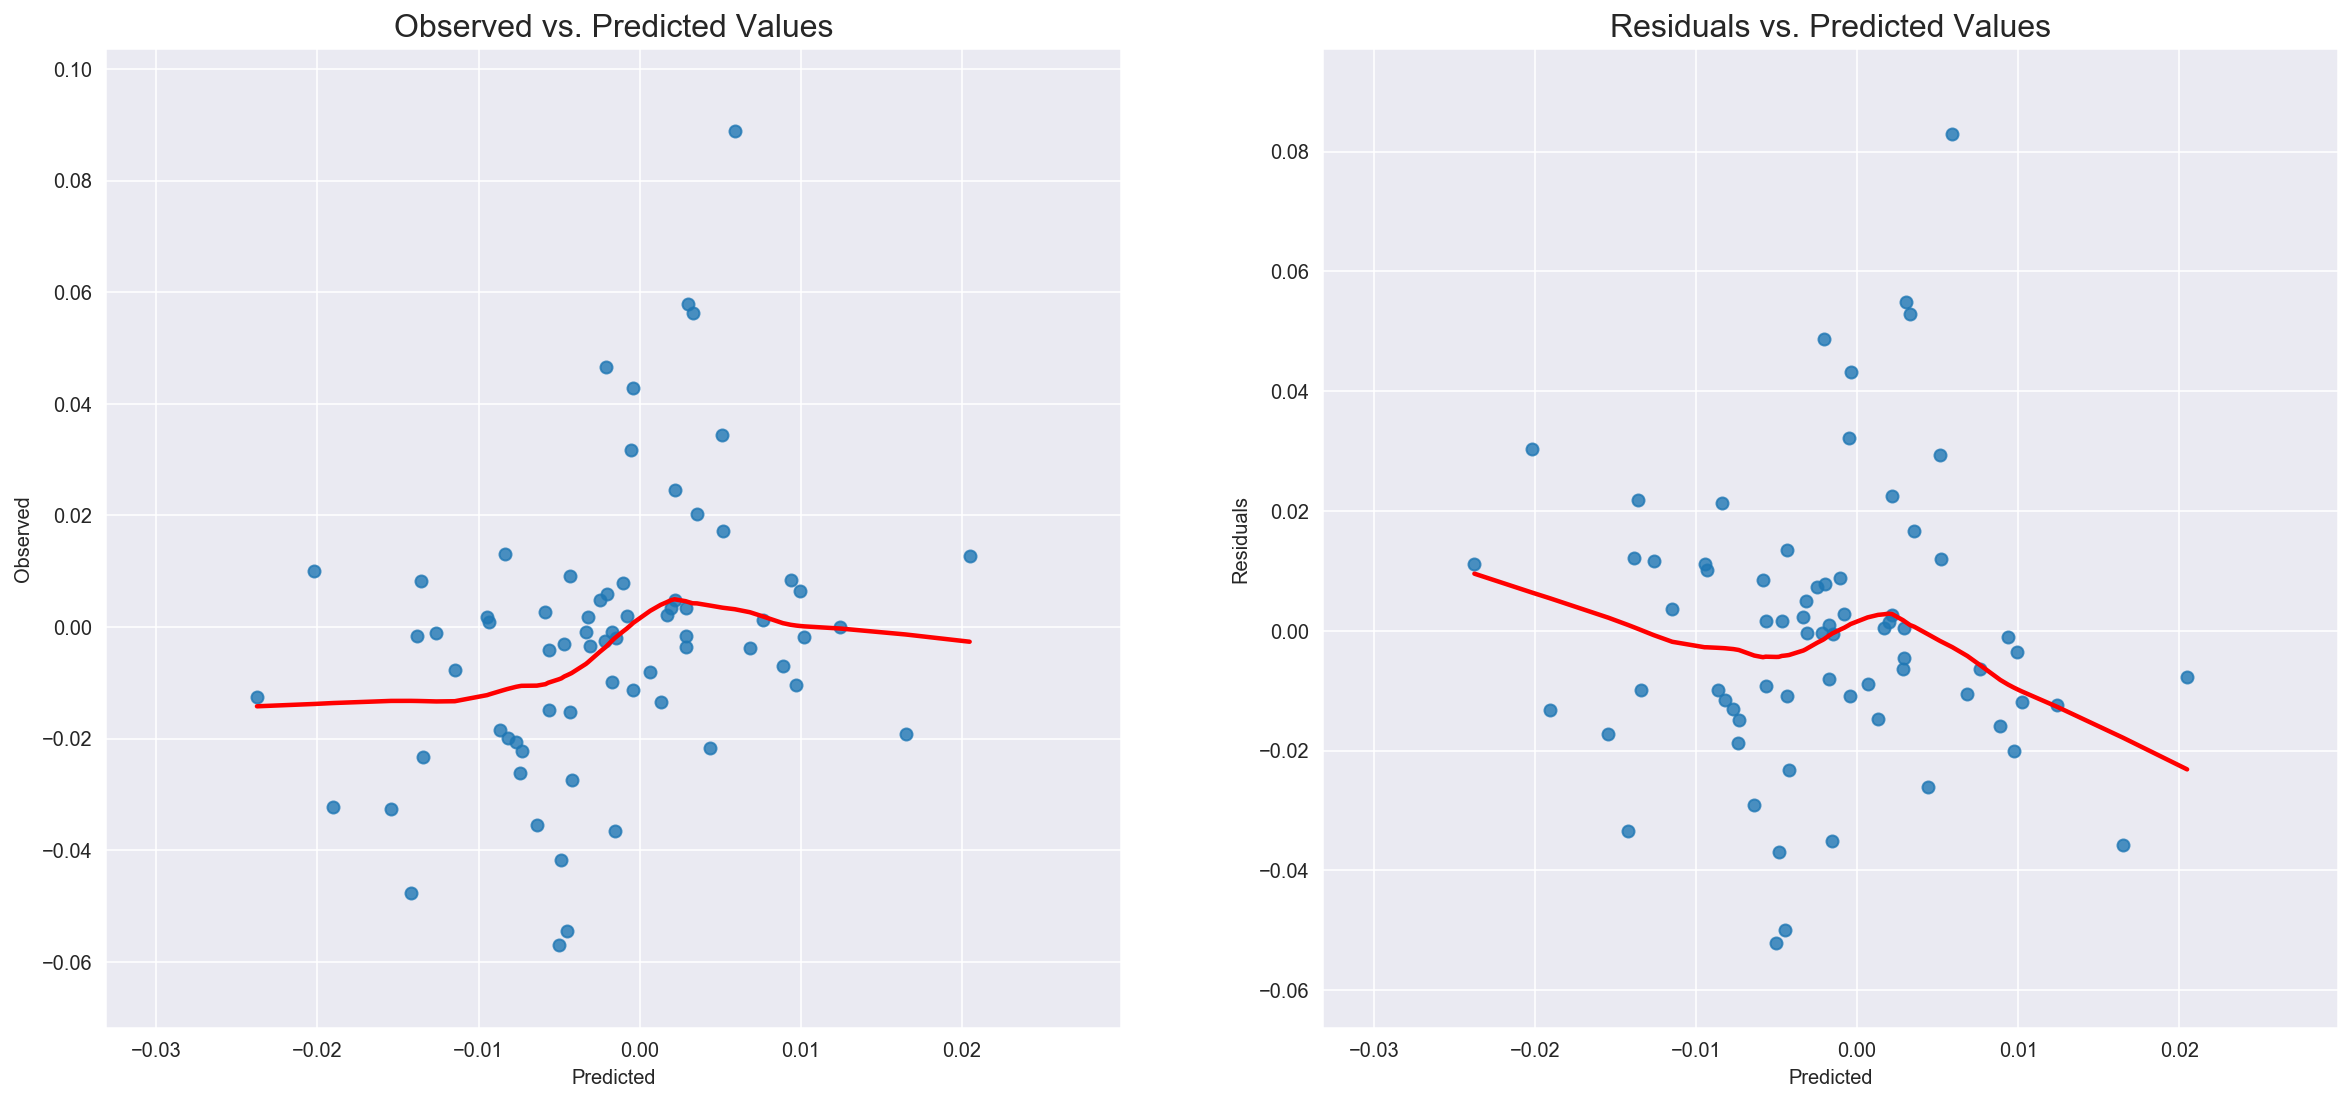

In [33]:
linearity_test(result_p, y_portfolio) 

Linearity is not really satisfied. 

##### Test Strict exogeneity:

mean of residuals =  -1.5636944008805022e-18


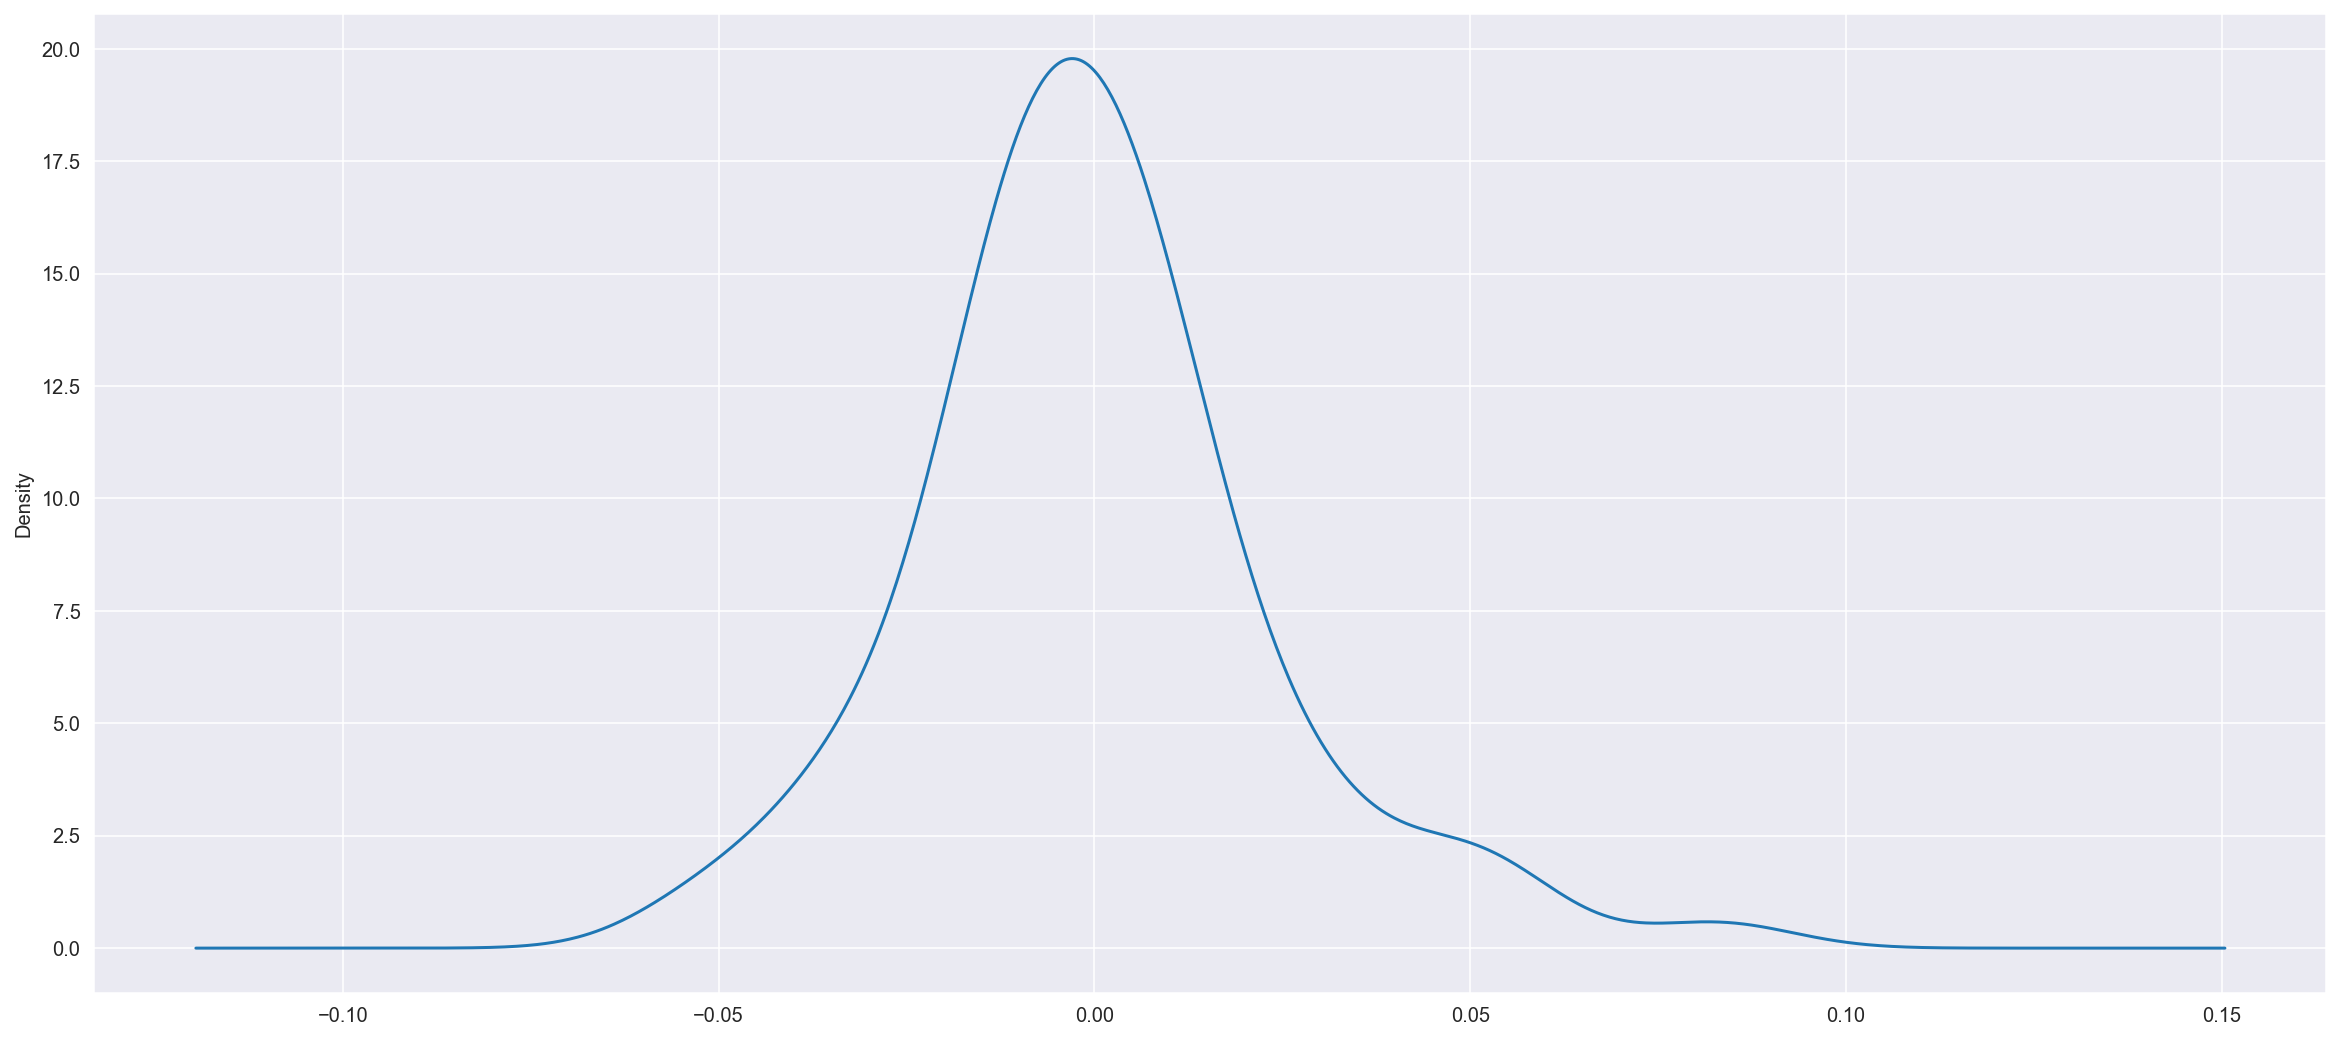

In [34]:
print('mean of residuals = ', modelpresid.mean())
modelpresid.plot(kind='kde')
plt.show()

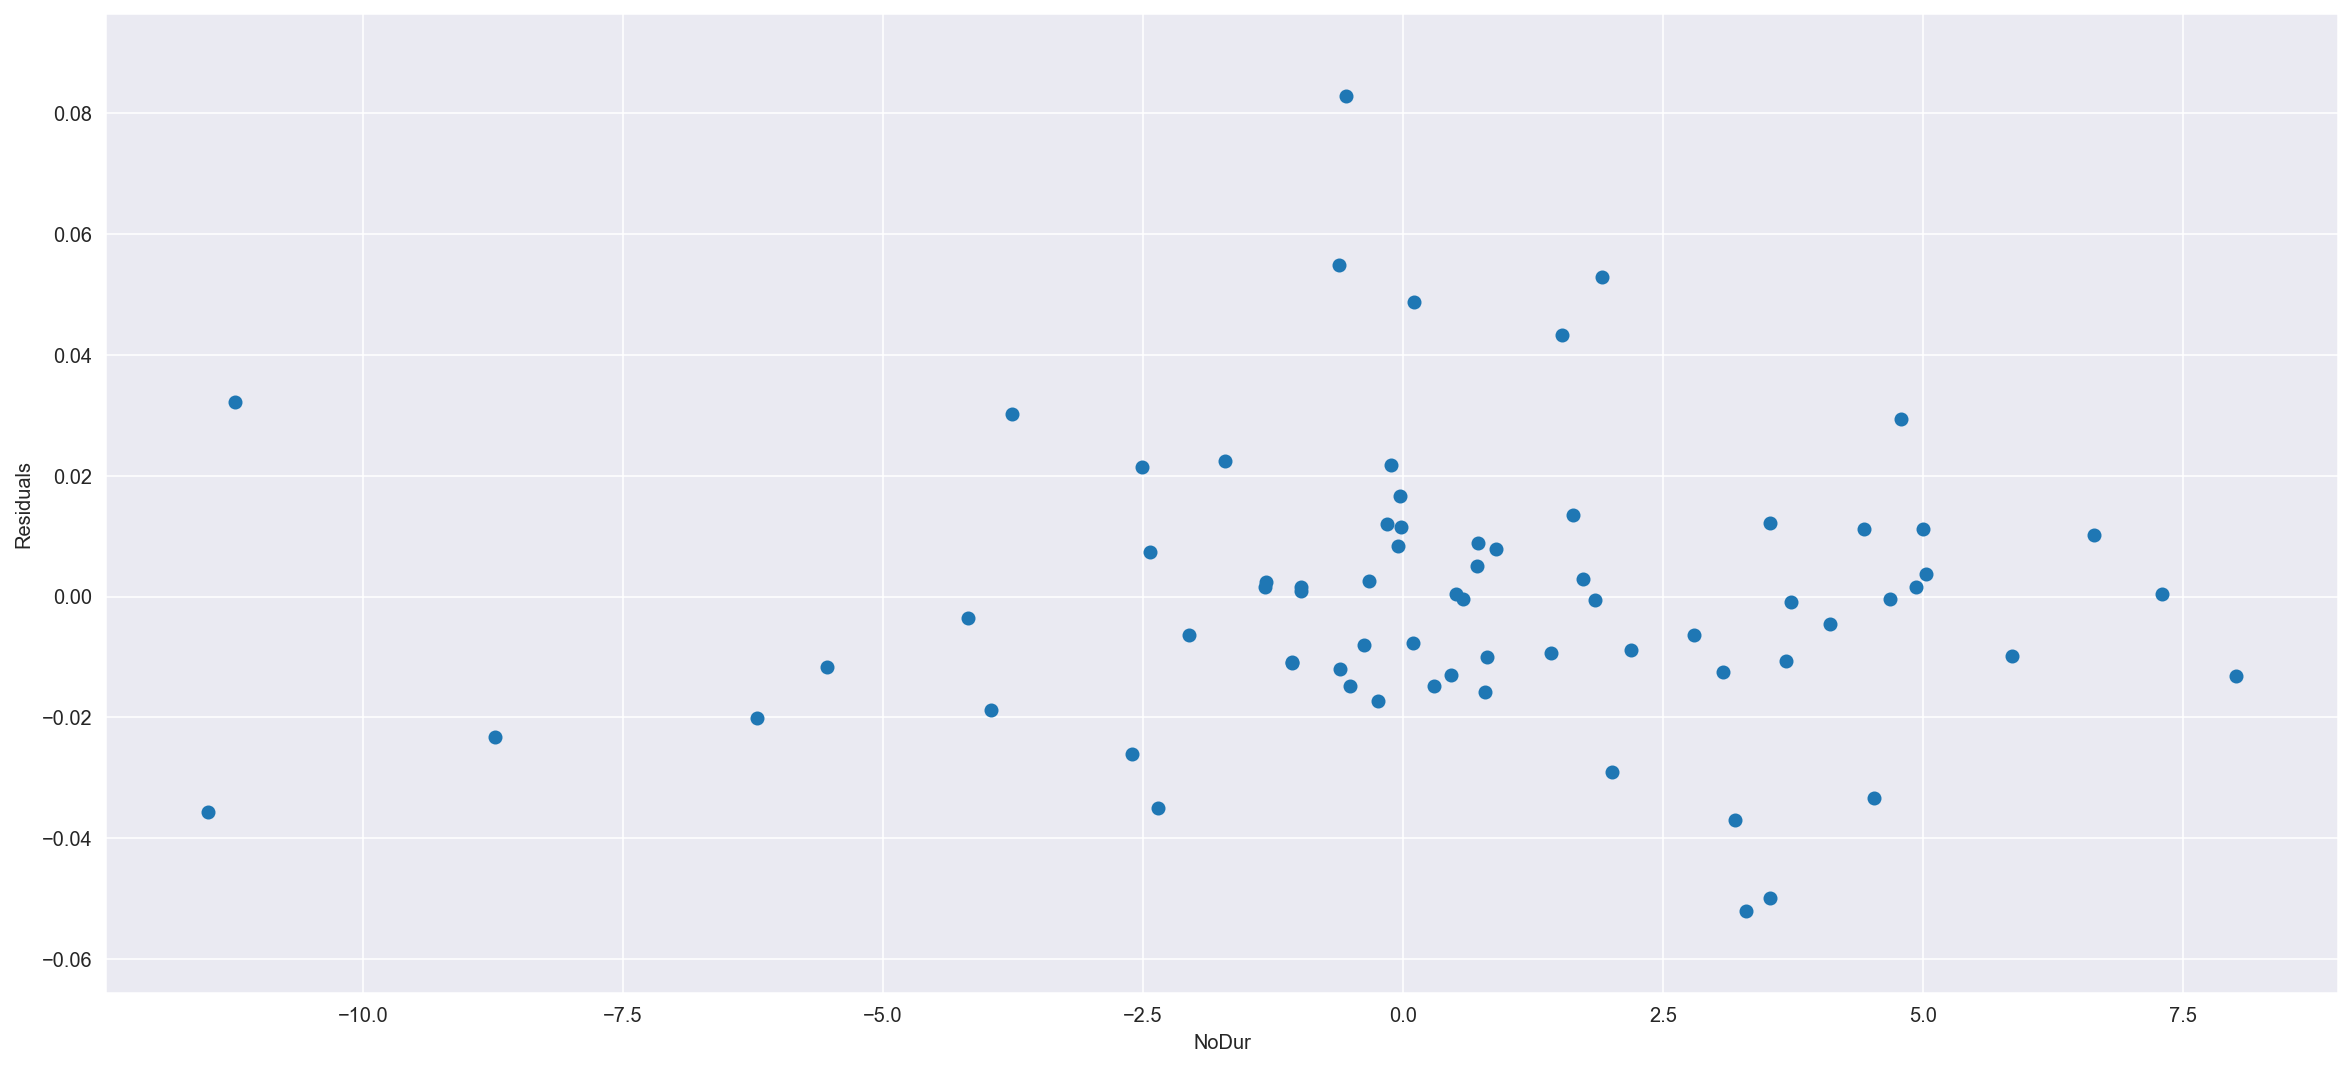

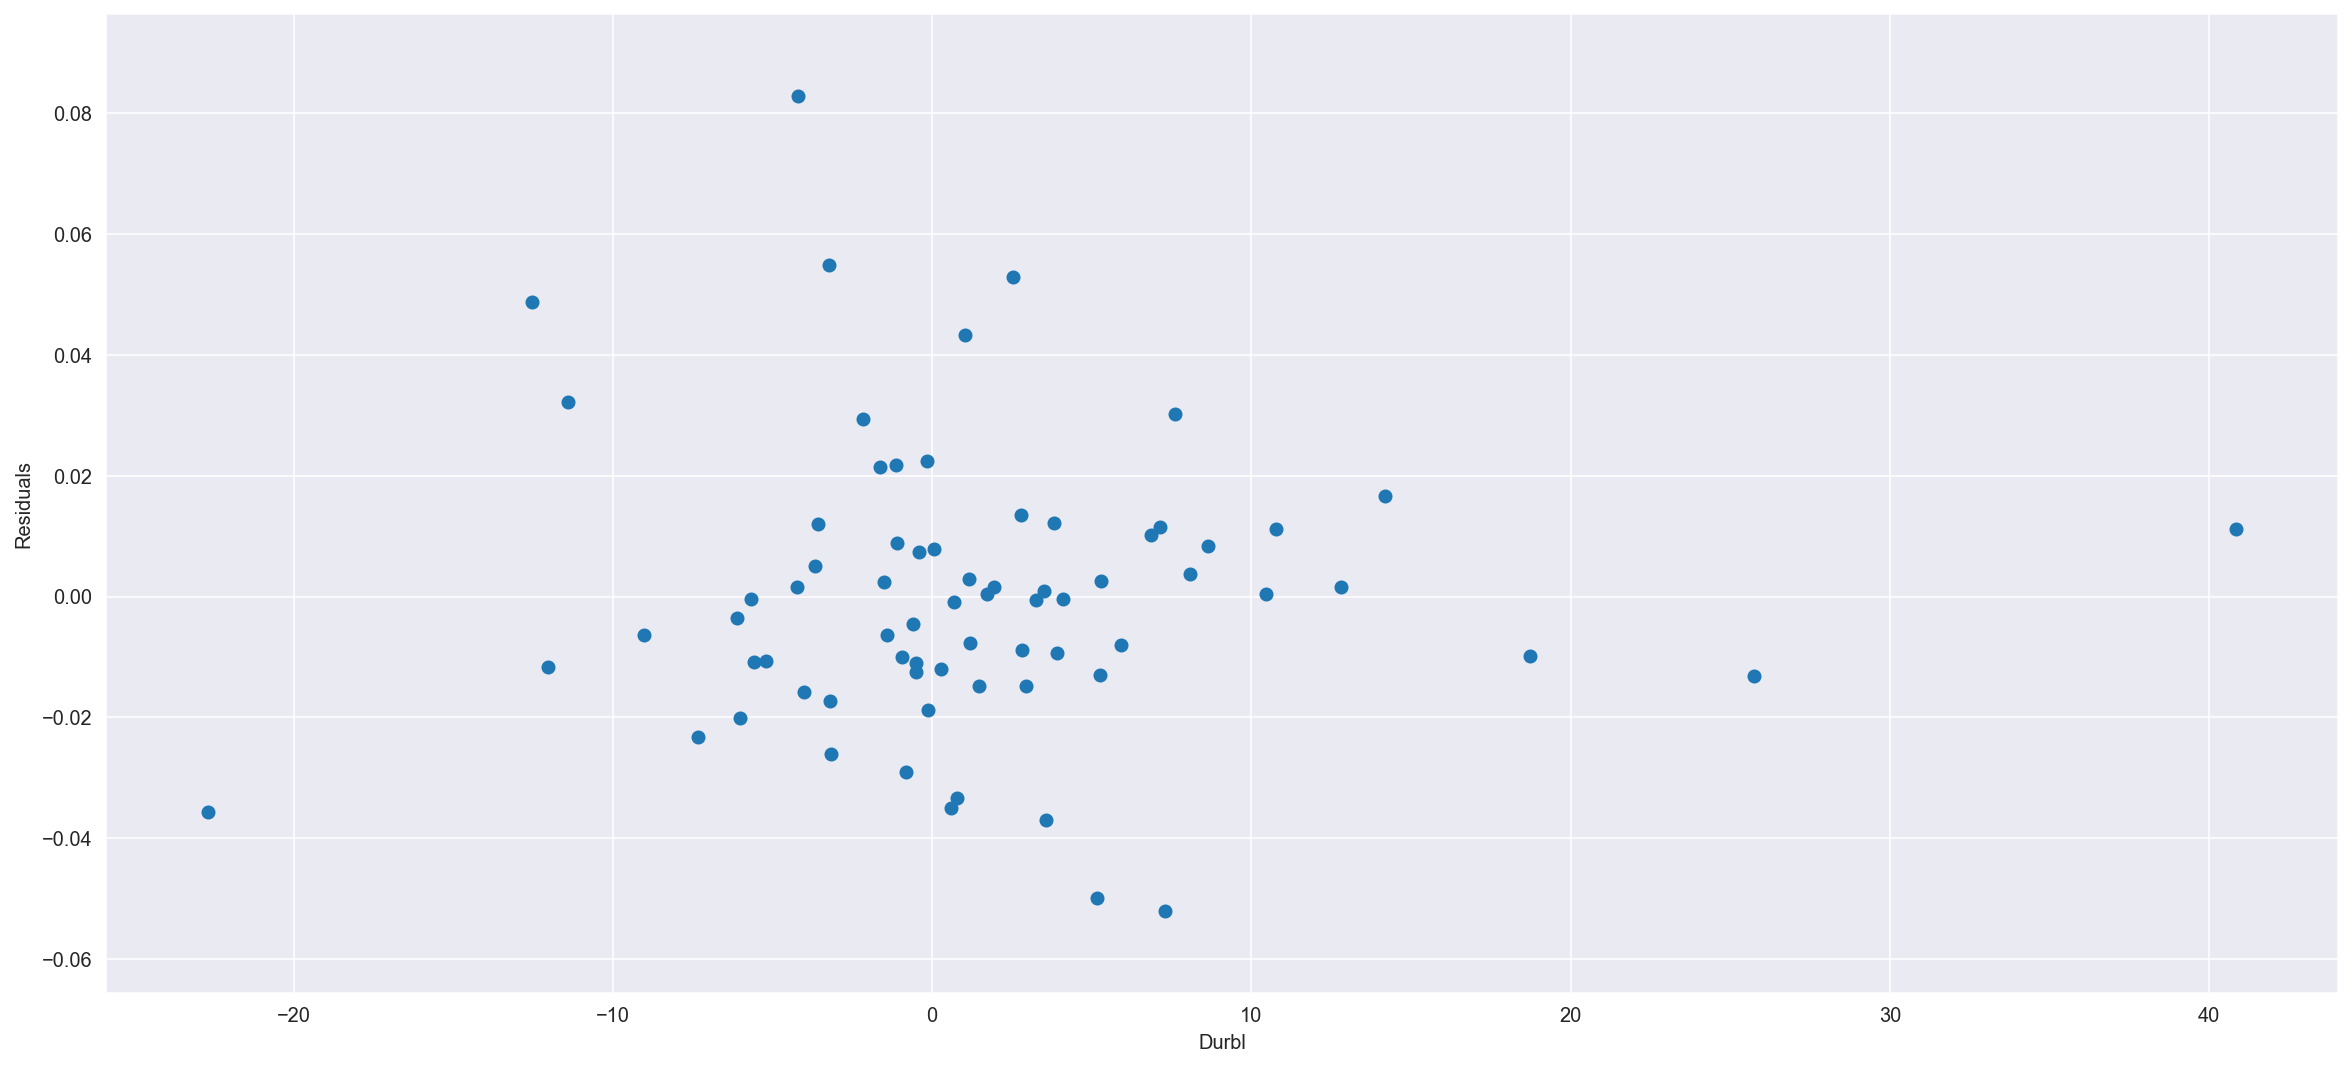

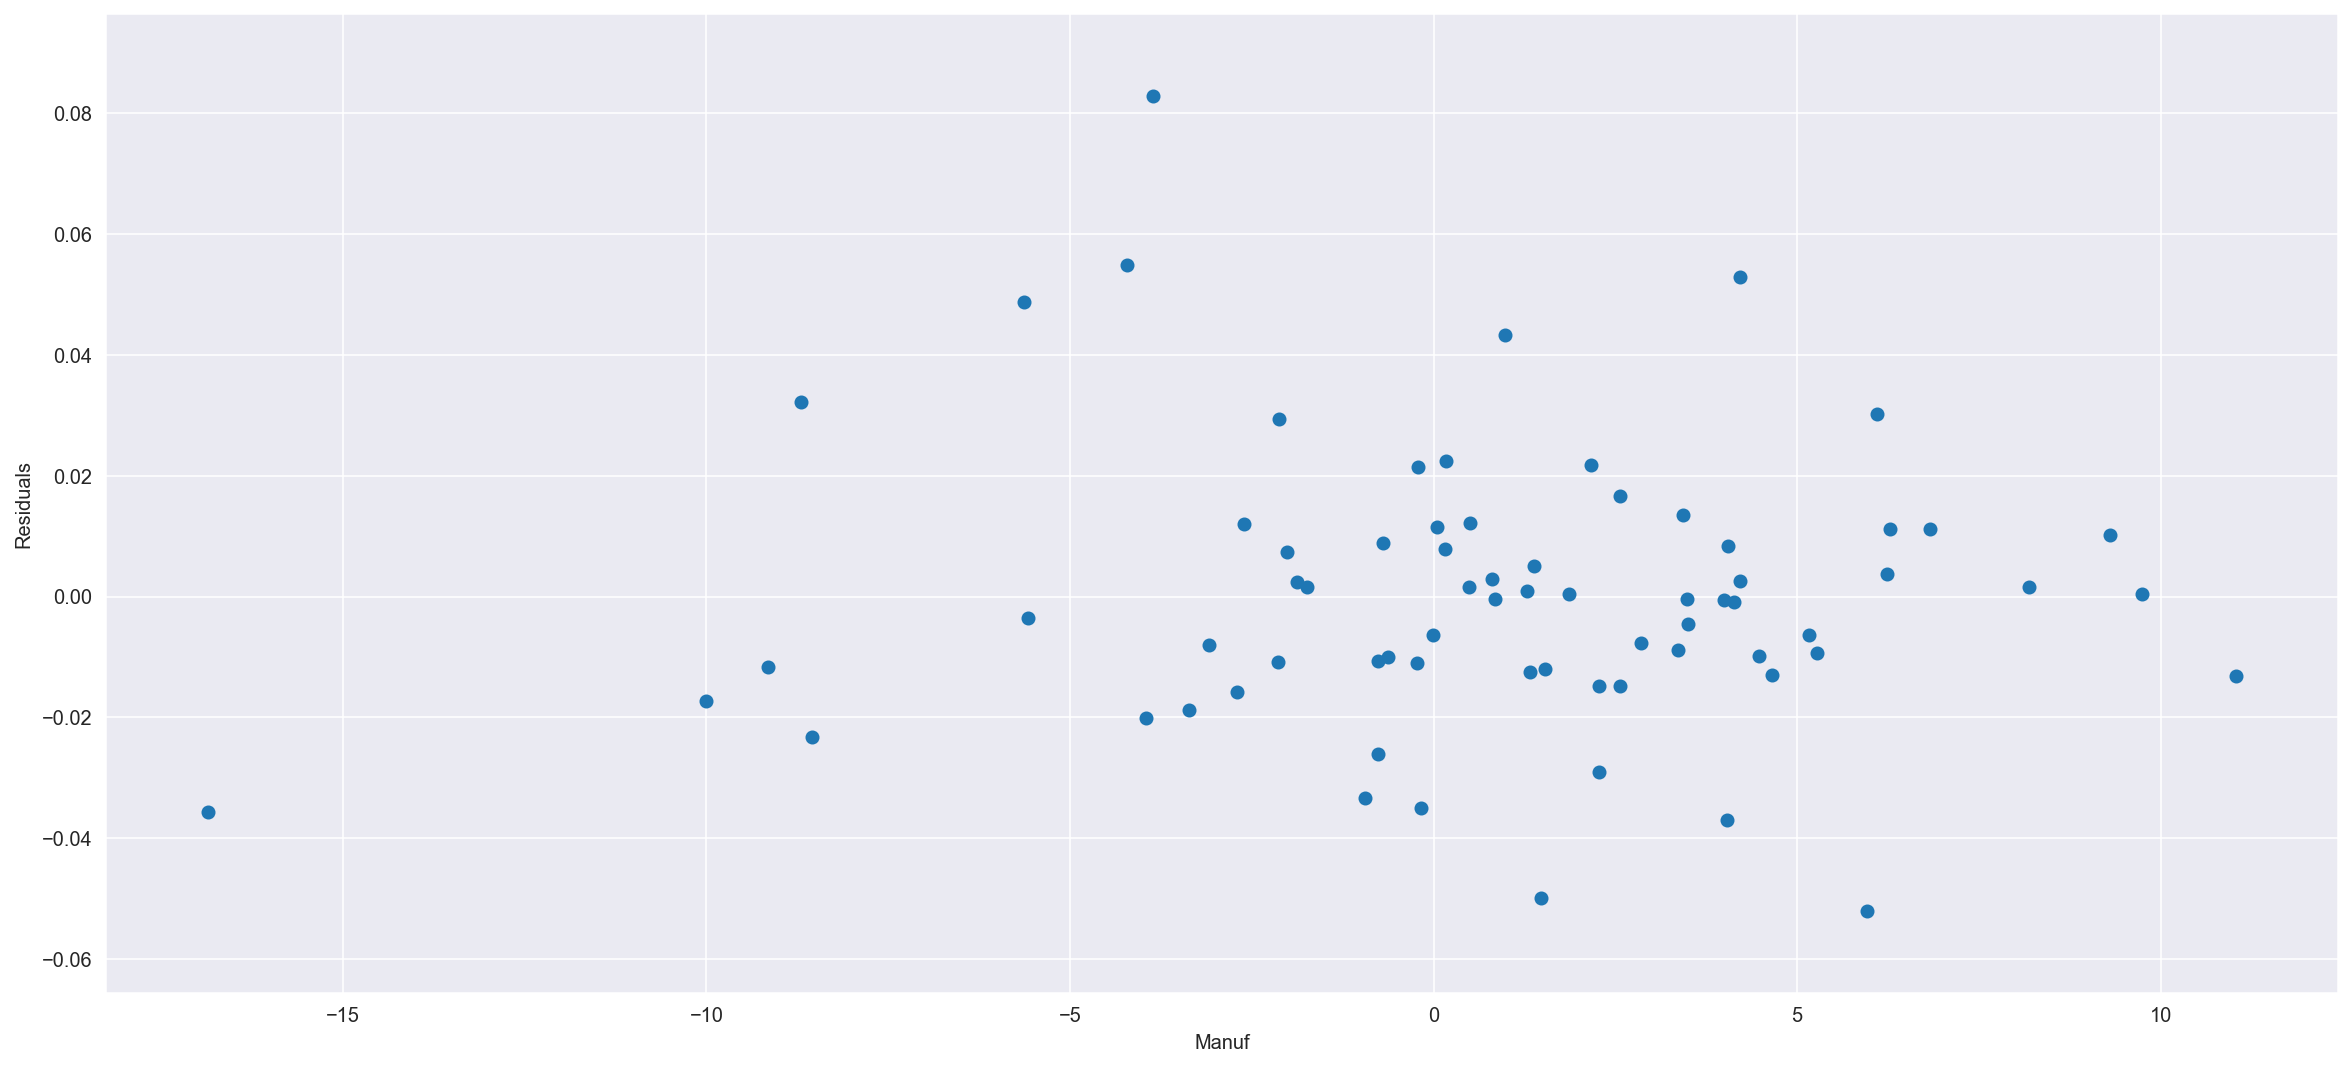

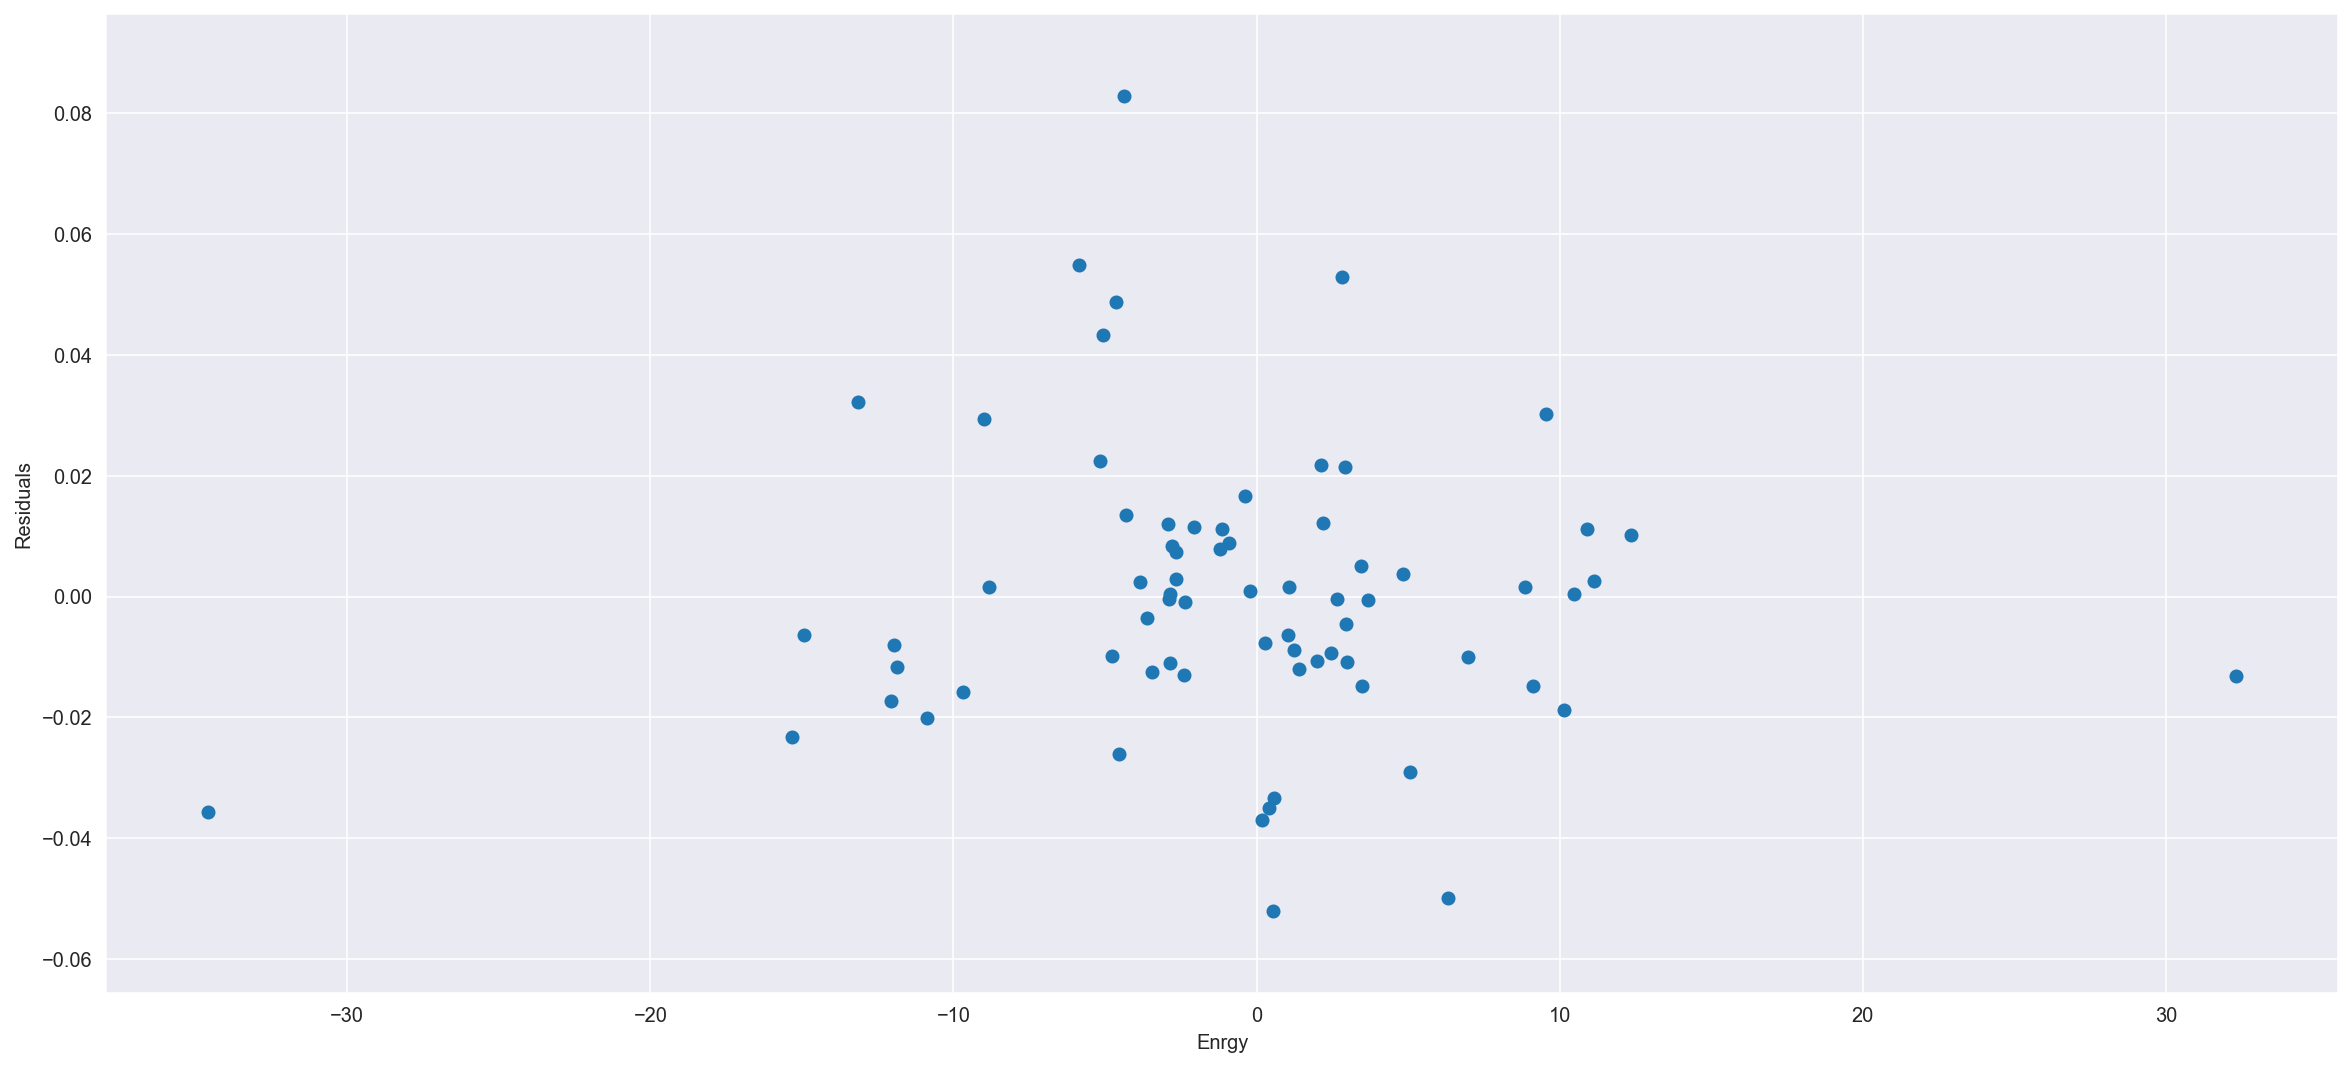

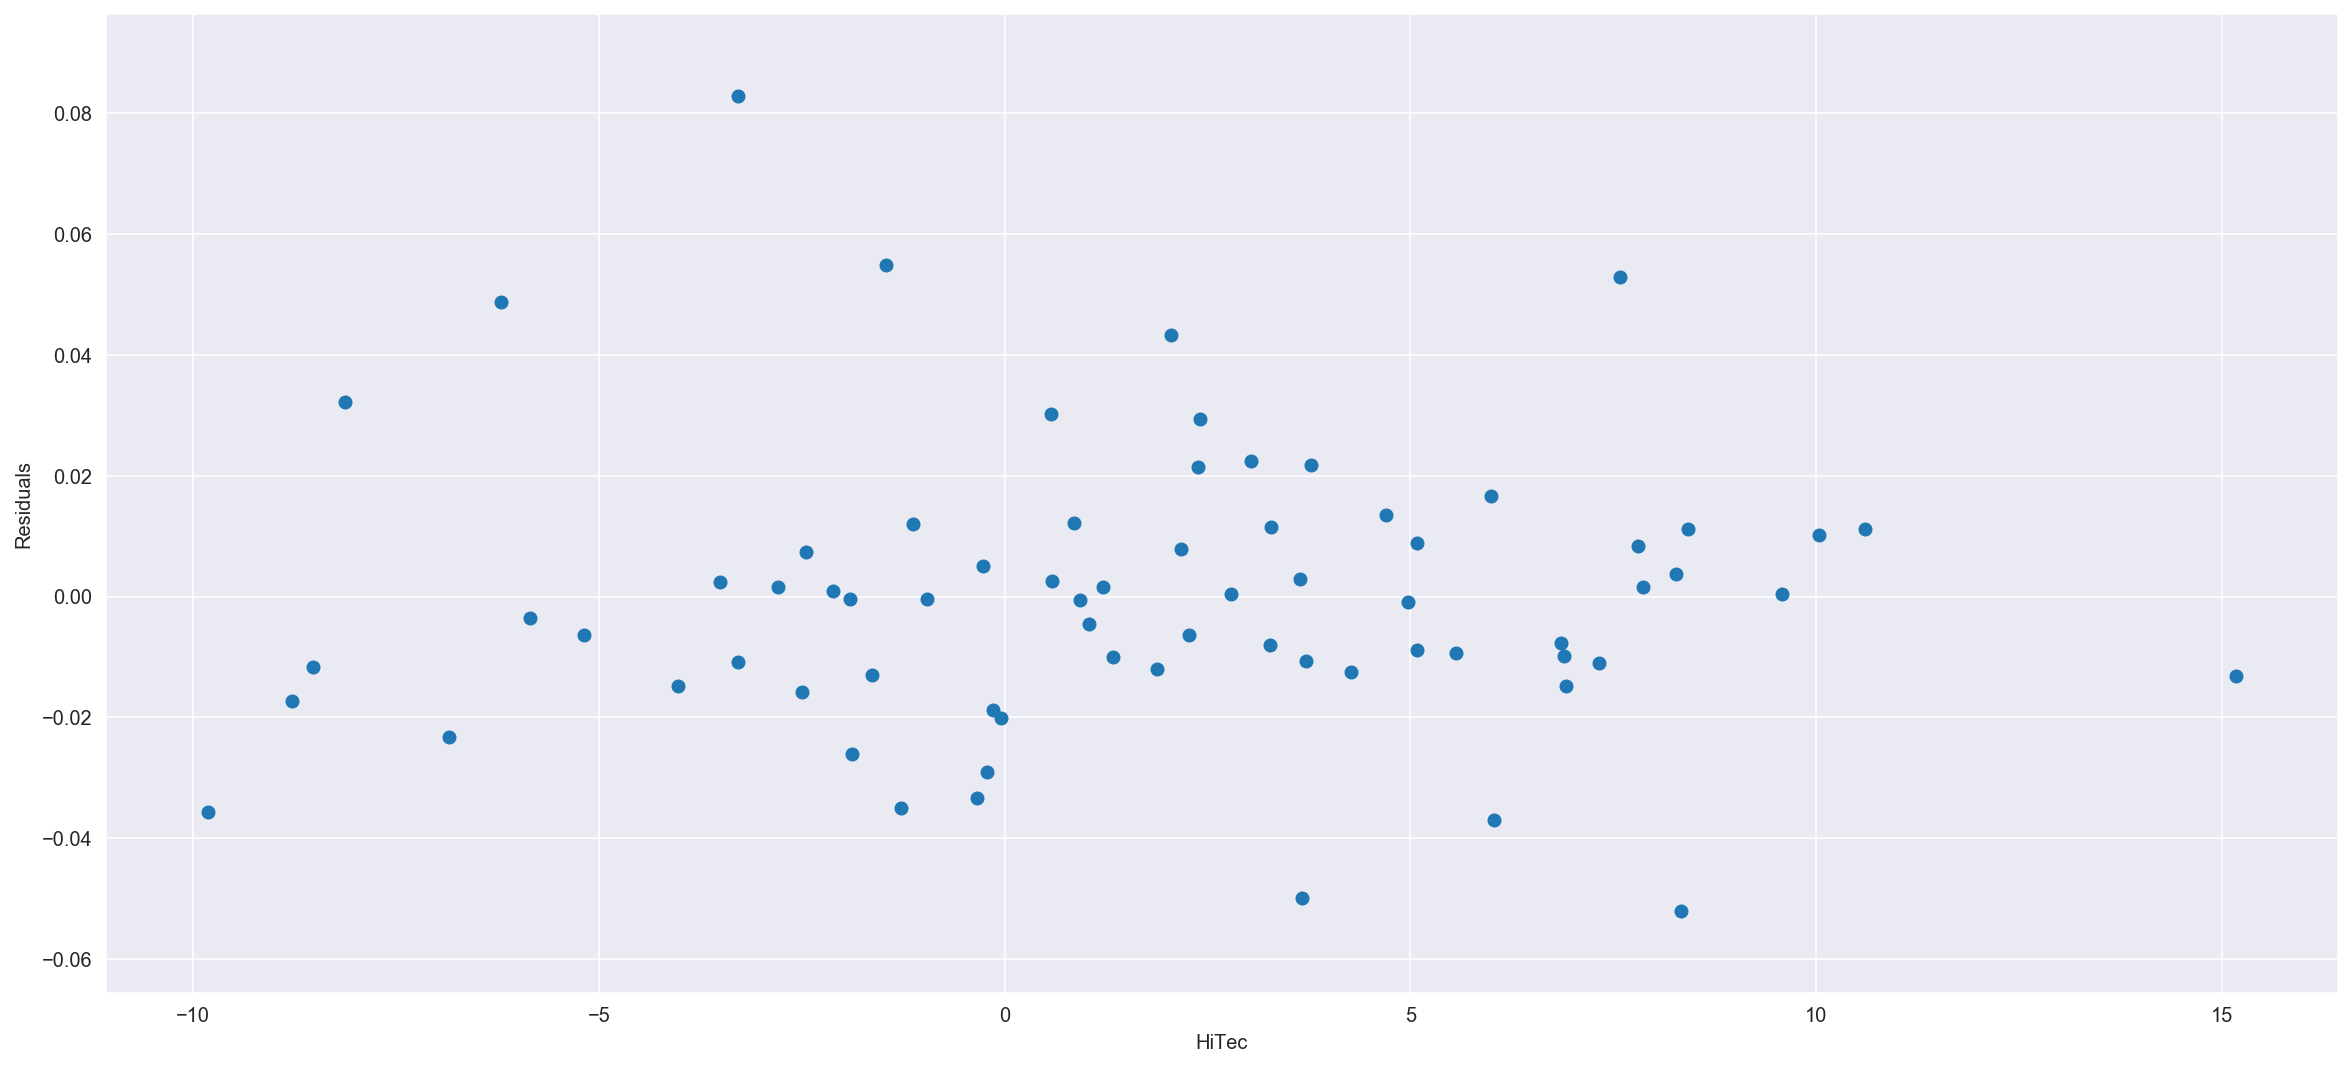

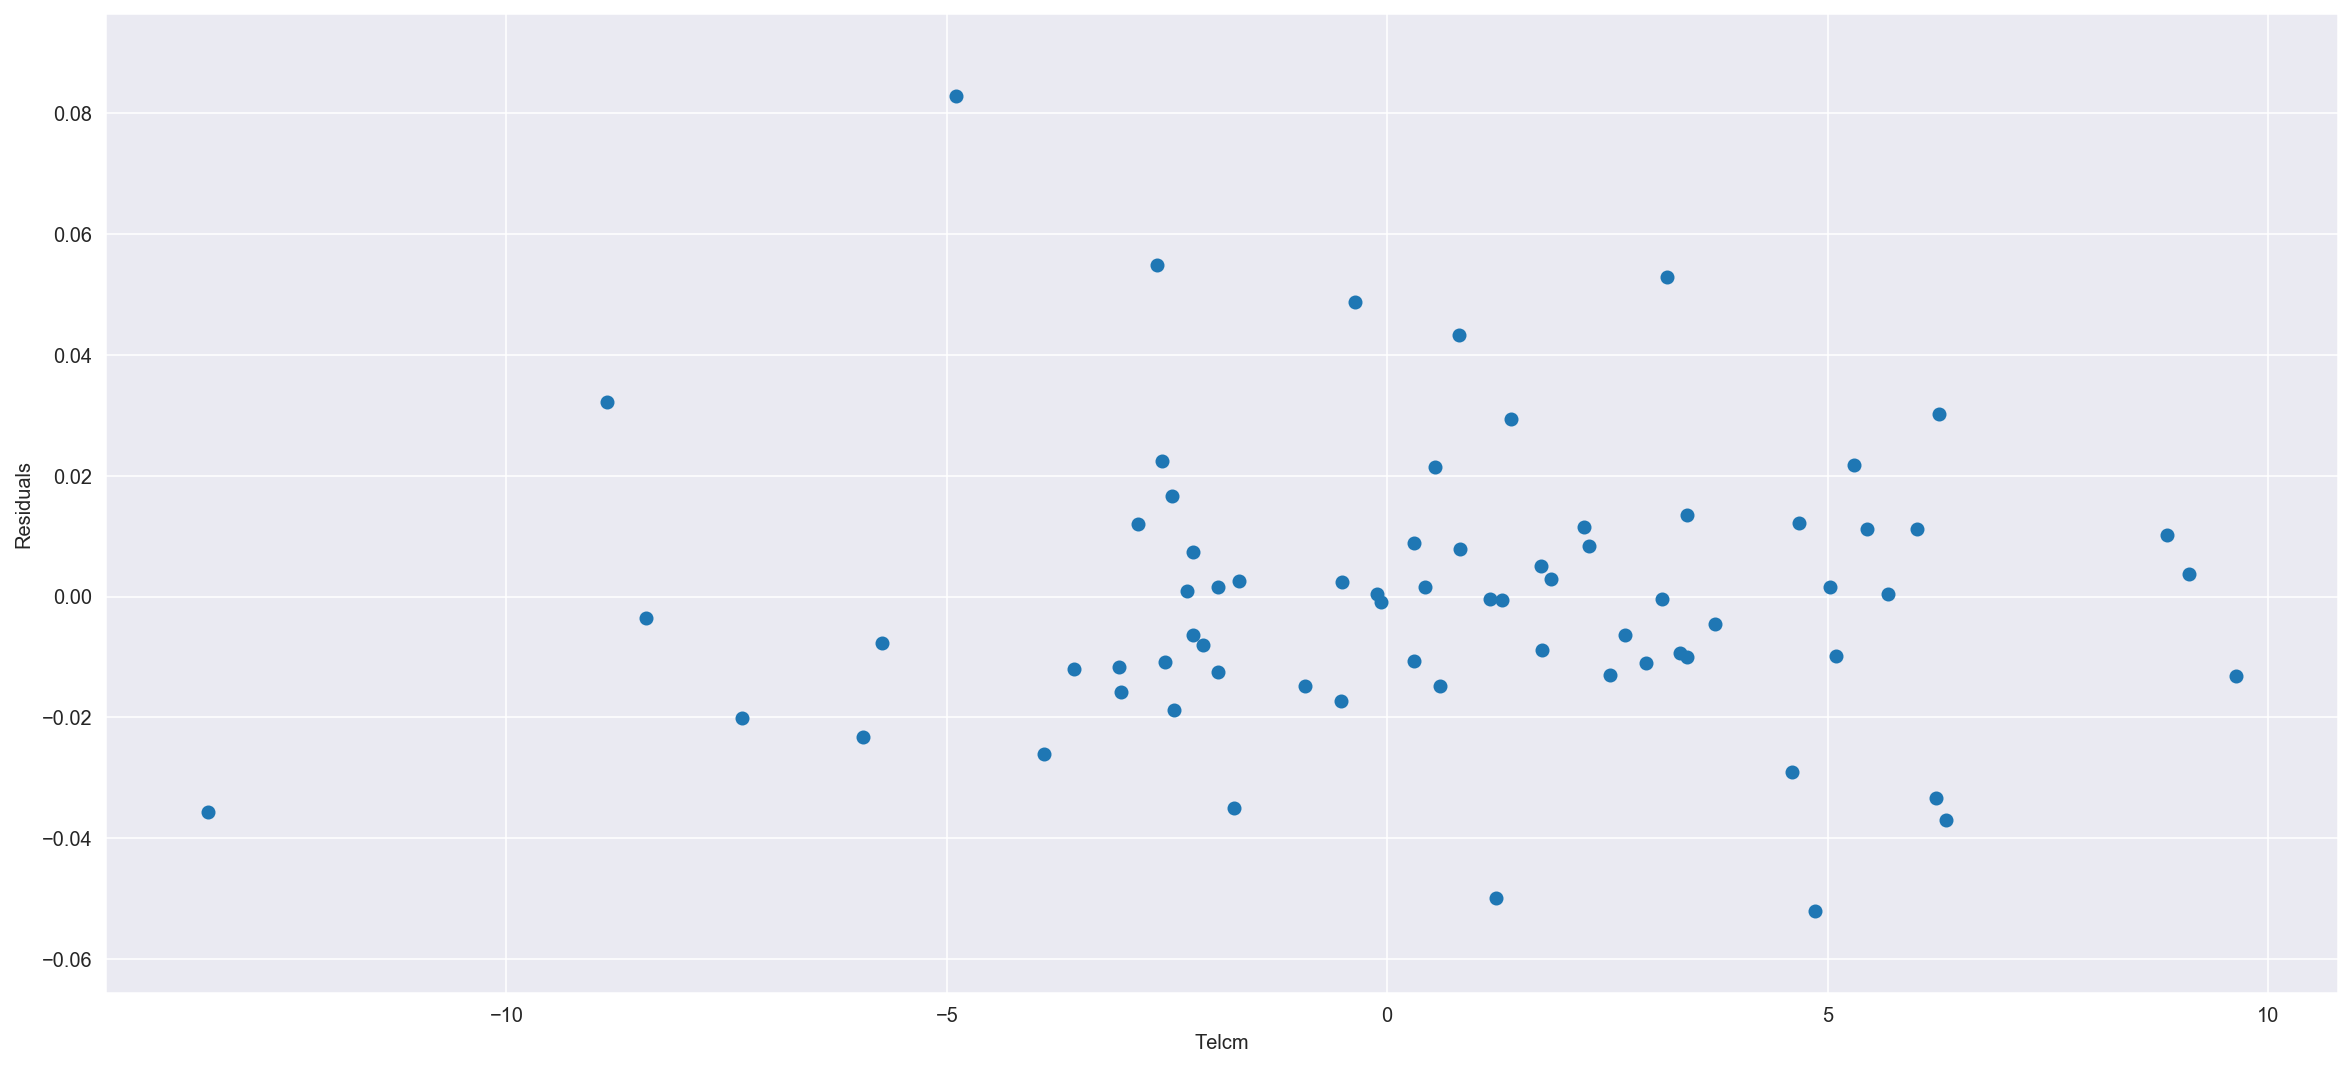

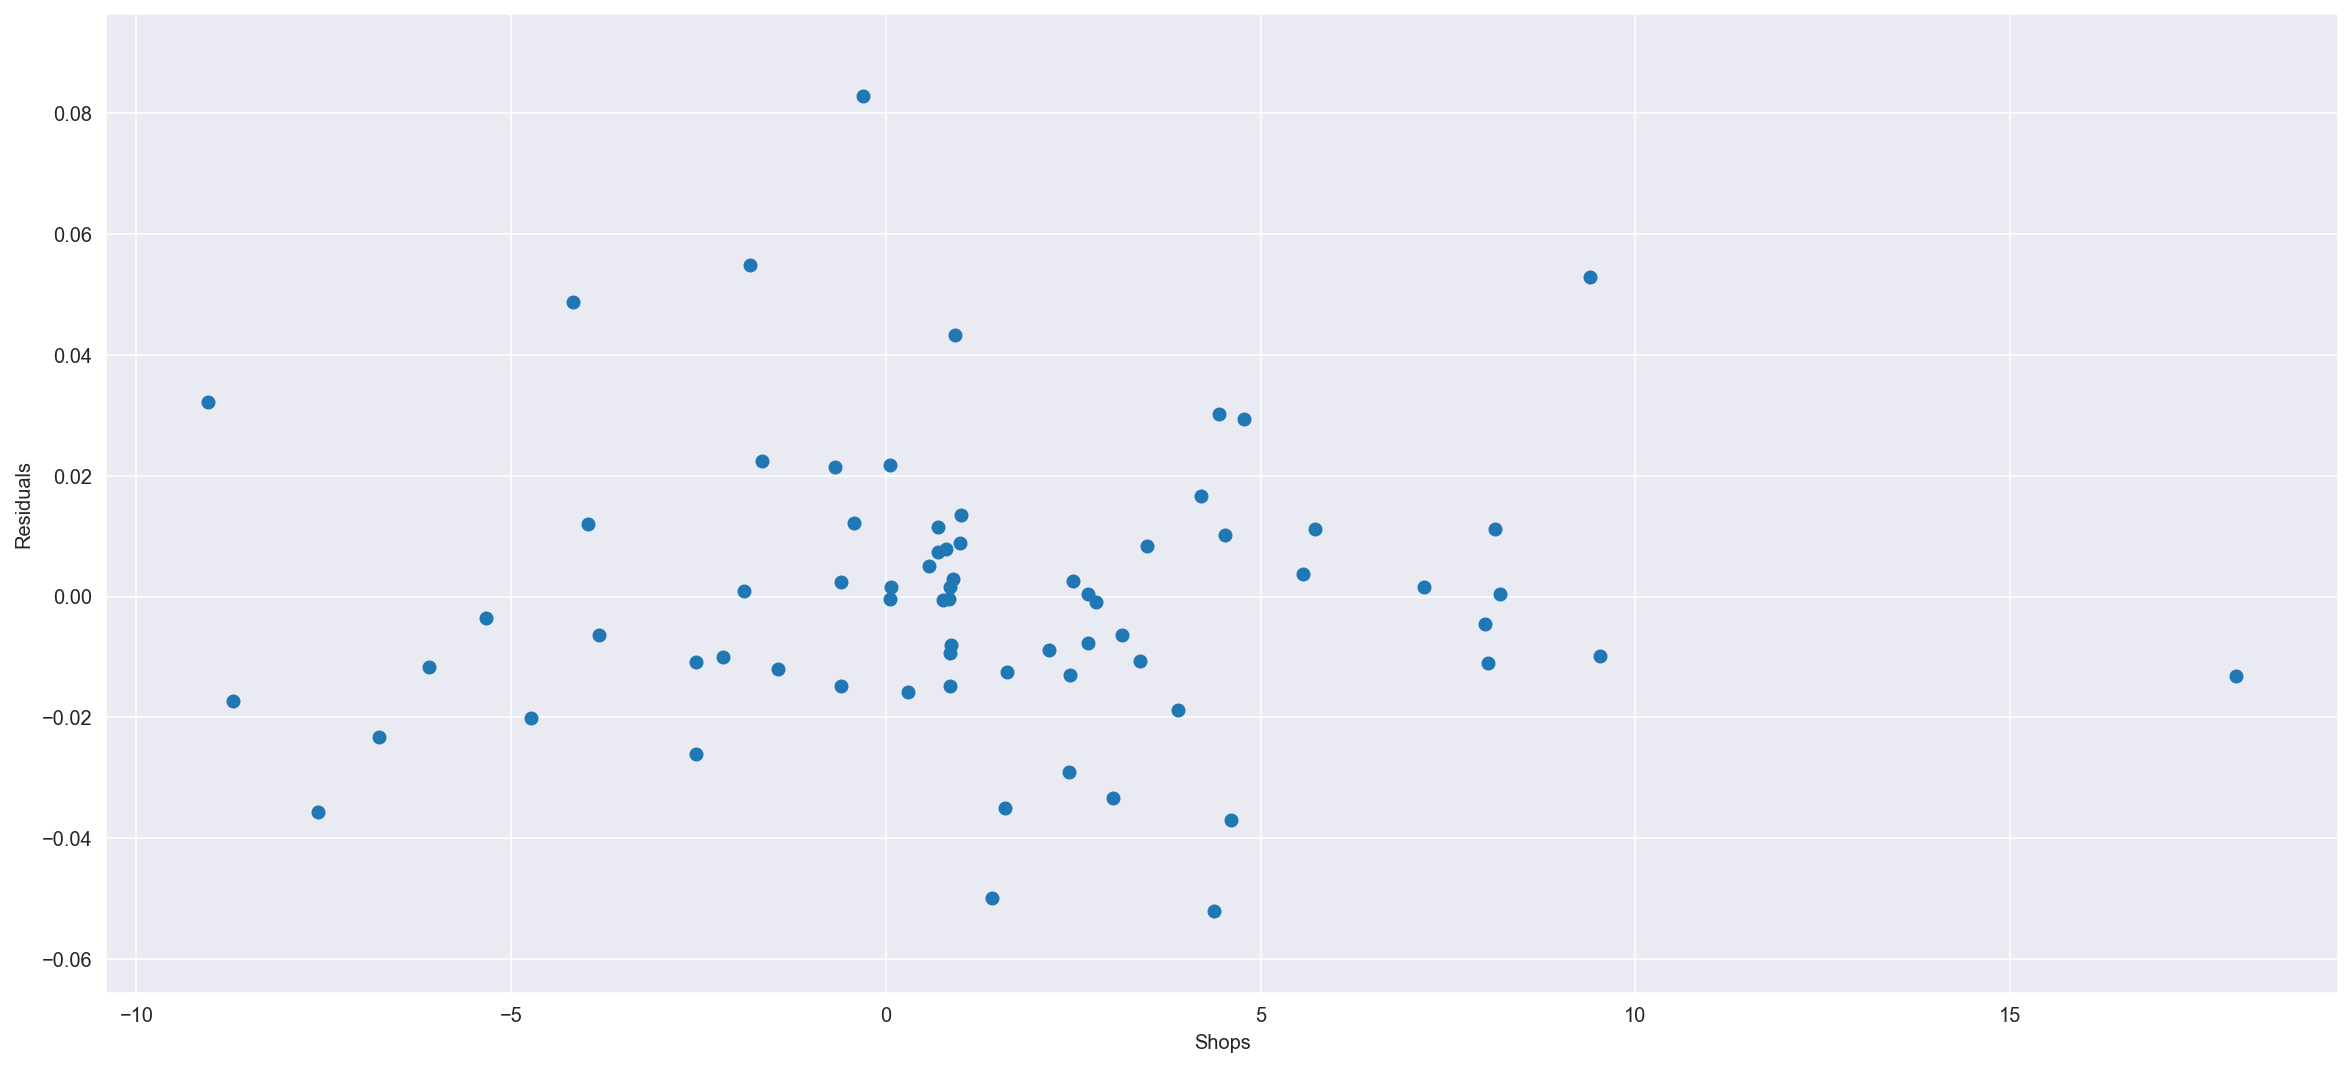

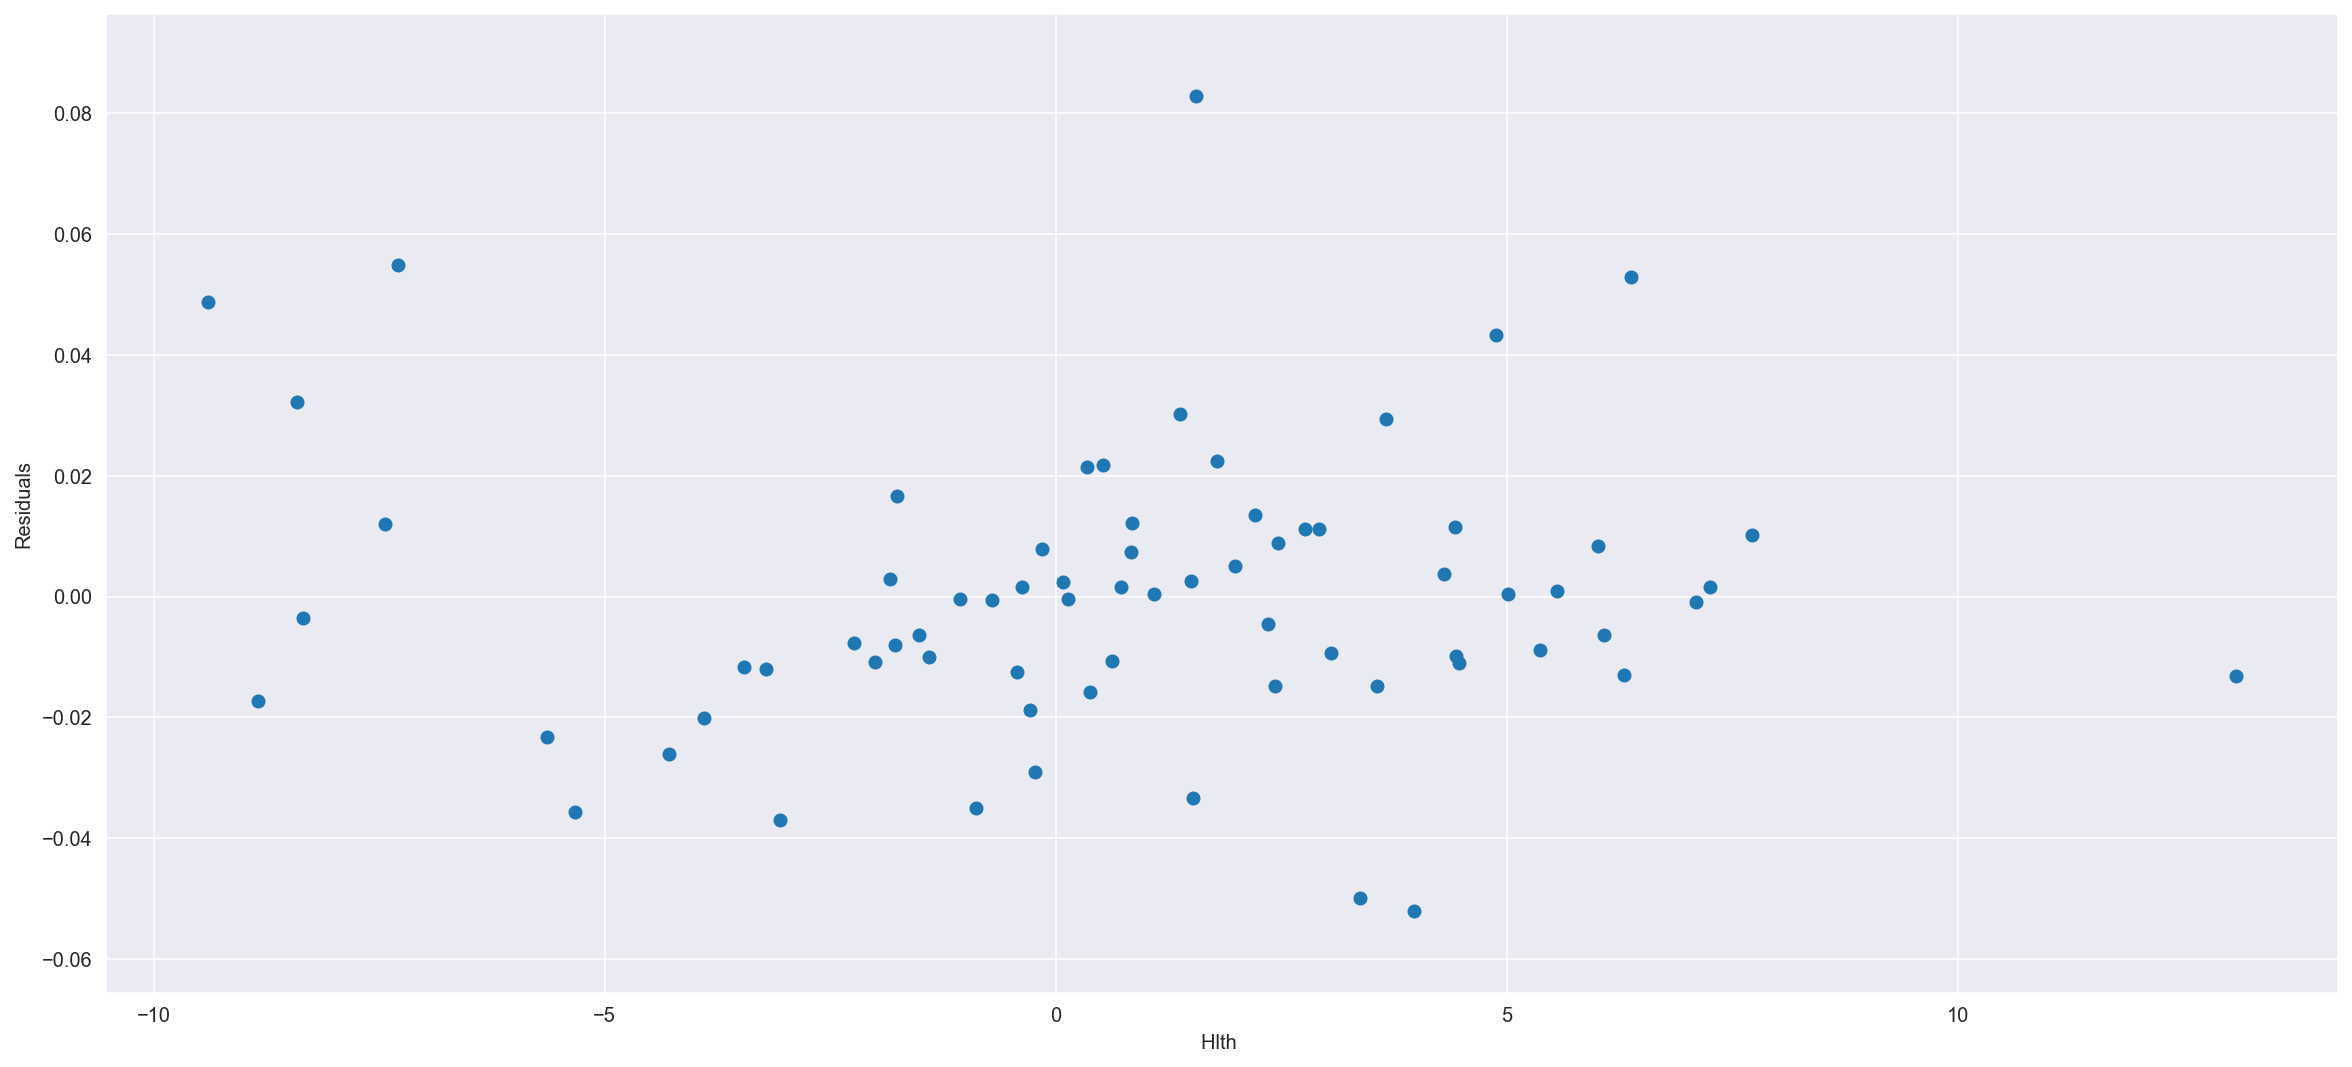

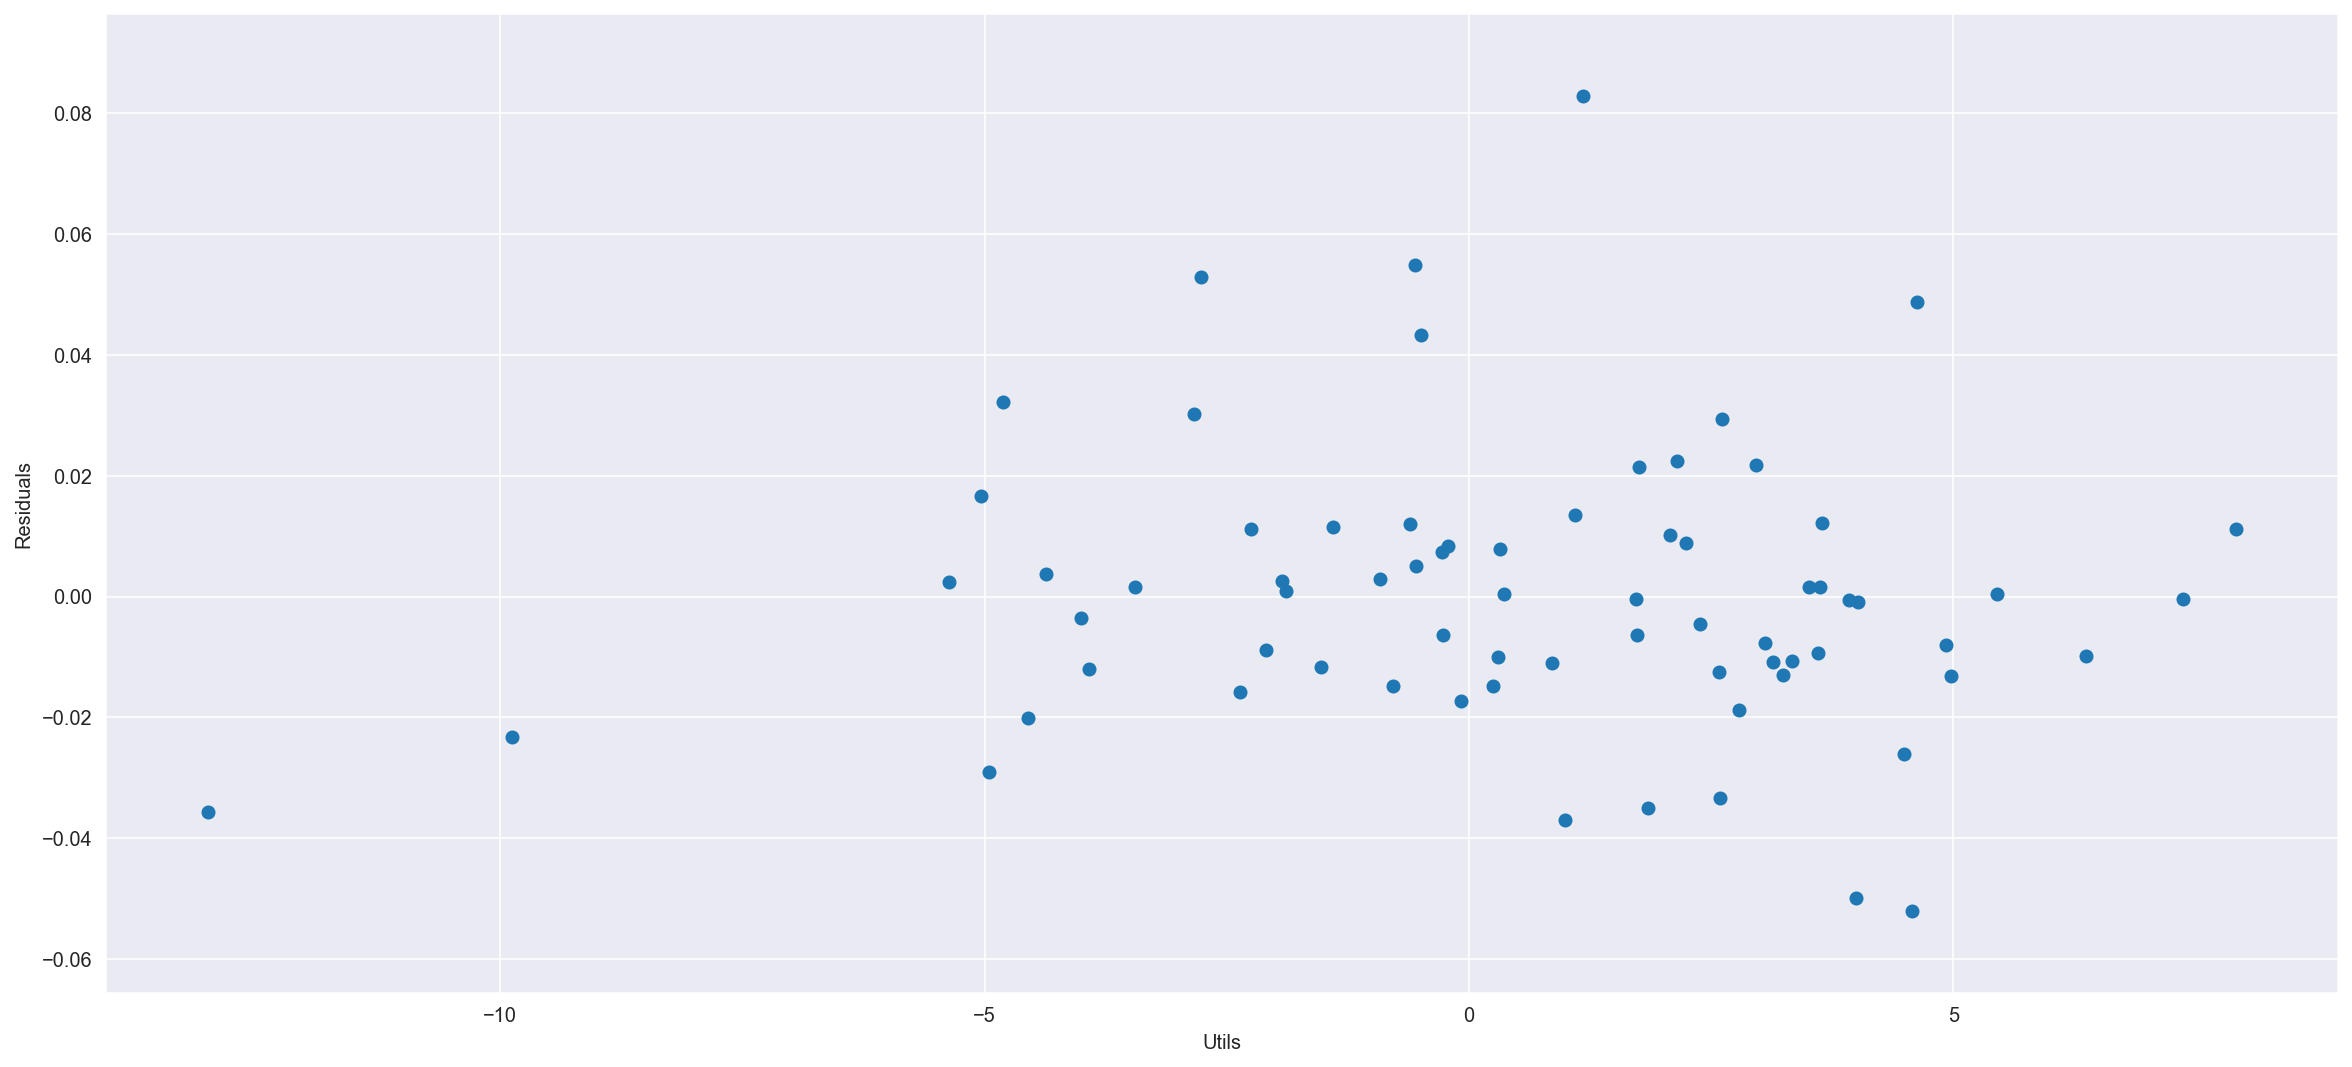

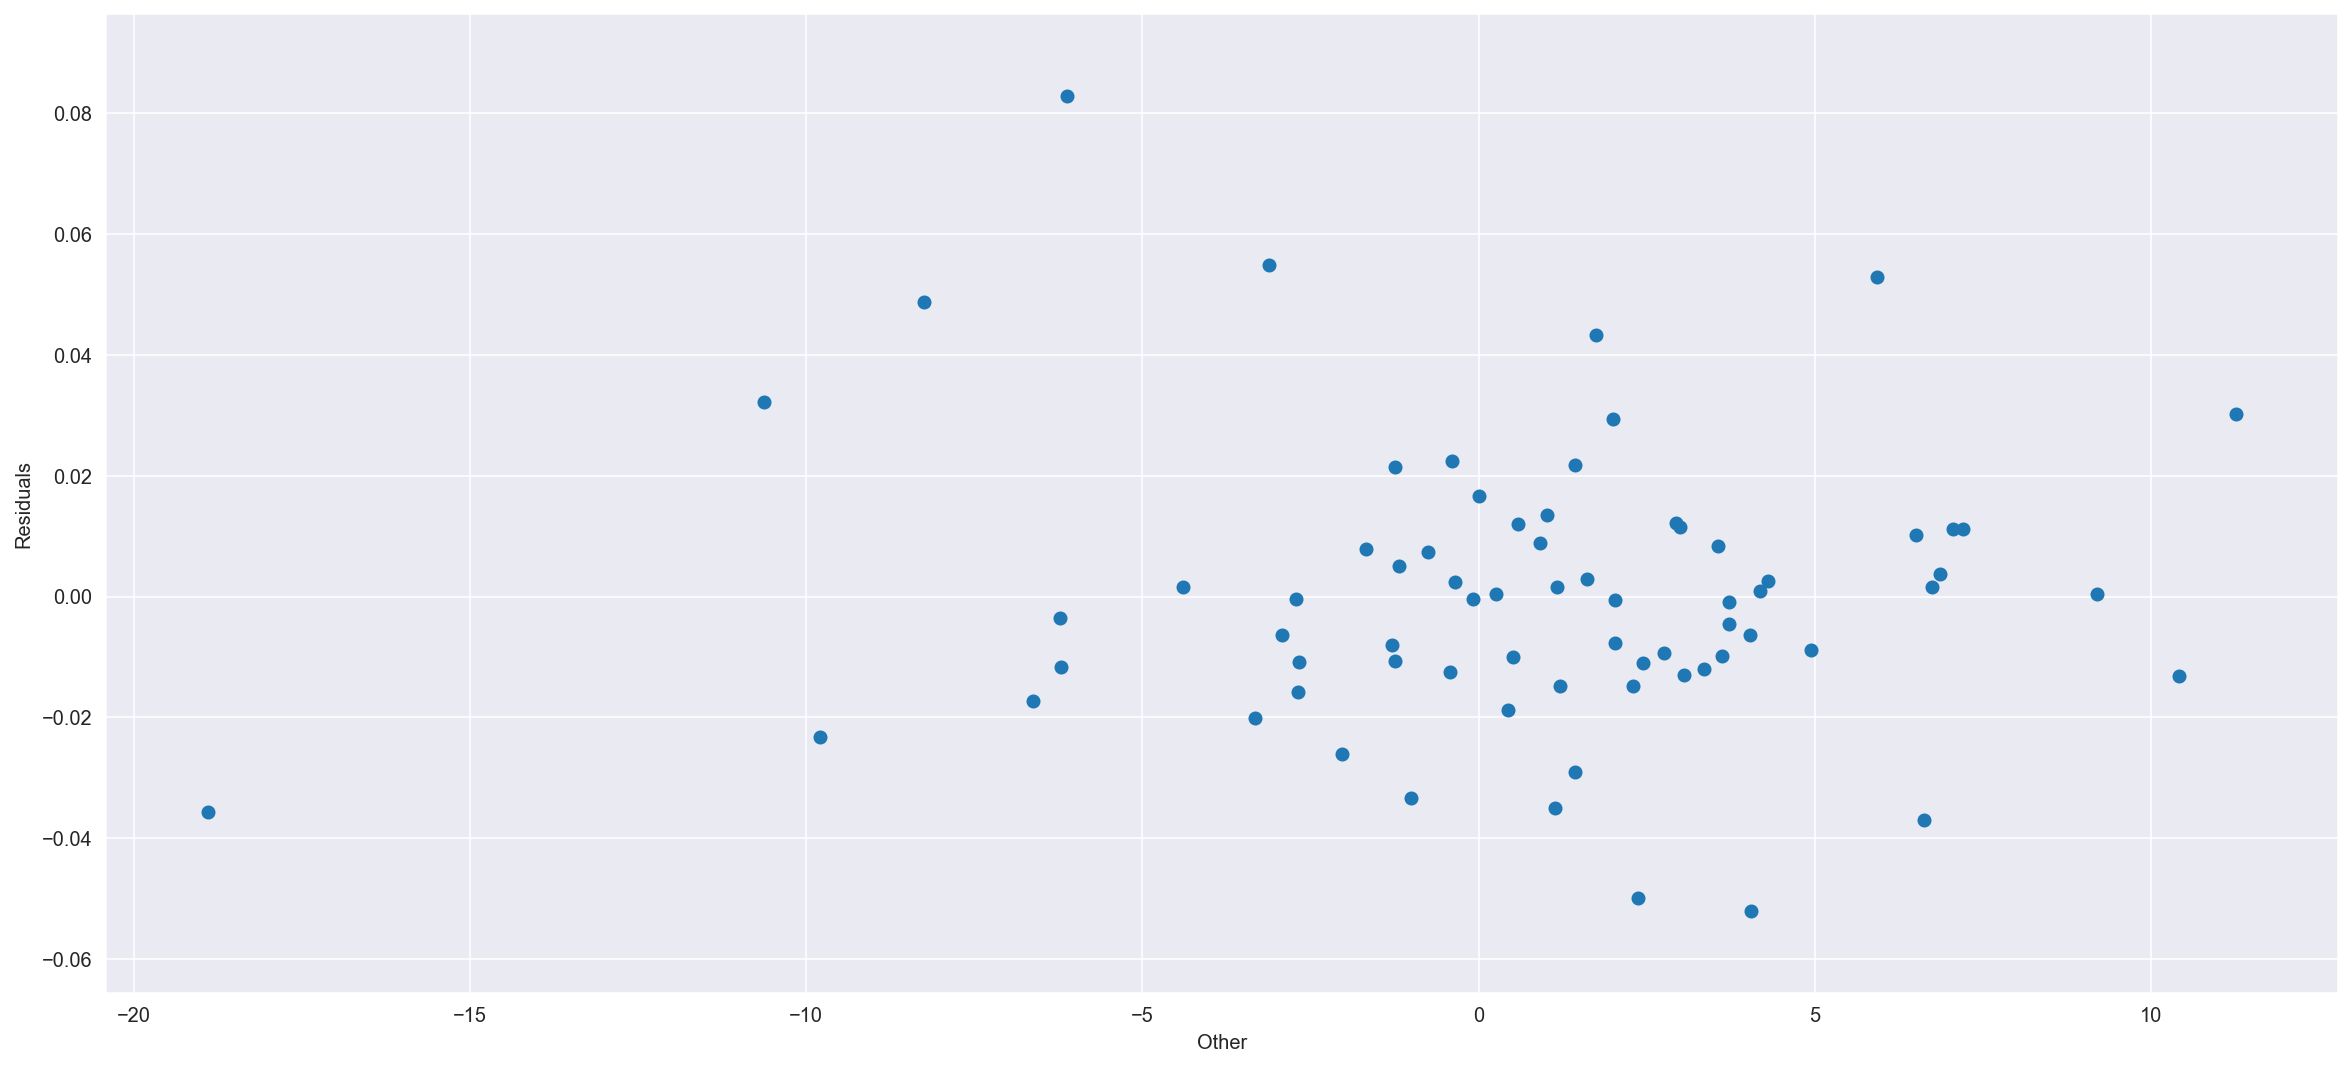

residuals
NoDur     -2.749502e-16
Durbl     -2.931670e-16
Manuf     -4.651803e-16
Enrgy     -3.487998e-16
HiTec     -4.481586e-16
Telcm     -4.770778e-16
Shops     -5.055820e-16
Hlth      -4.936990e-16
Utils     -1.641461e-16
Other     -4.608946e-16
residuals  1.000000e+00

In [35]:
attributes = portfolio_factors_3.columns
for att in attributes:
    plt.scatter(y = modelpresid, x = portfolio_factors_3[att])
    plt.xlabel(att)
    plt.ylabel('Residuals')
    plt.show()
df_factors = portfolio_factors_3.copy()
df_factors['residuals'] = modelpresid
df_factors.corr()[['residuals']]

In [36]:
pearson_corr_test(X_portfolio, modelpresid)

Variable: NoDur --- correlation: -0.0000, p-value: 1.0000
Variable: Durbl --- correlation: -0.0000, p-value: 1.0000
Variable: Manuf --- correlation: -0.0000, p-value: 1.0000
Variable: Enrgy --- correlation: -0.0000, p-value: 1.0000
Variable: HiTec --- correlation: -0.0000, p-value: 1.0000
Variable: Telcm --- correlation: -0.0000, p-value: 1.0000
Variable: Shops --- correlation: -0.0000, p-value: 1.0000
Variable: Hlth  --- correlation: -0.0000, p-value: 1.0000
Variable: Utils --- correlation: -0.0000, p-value: 1.0000
Variable: Other --- correlation: -0.0000, p-value: 1.0000


Strict exogeneity is satisfied.

##### Test No Multicollinearity:

In [37]:
# bivariate correlation
portfolio_factors_3.corr()

NoDur     Durbl     Manuf     Enrgy     HiTec     Telcm     Shops  \
NoDur  1.000000  0.610990  0.760398  0.619561  0.705223  0.804967  0.736529   
Durbl  0.610990  1.000000  0.746773  0.573319  0.756367  0.628487  0.737238   
Manuf  0.760398  0.746773  1.000000  0.766600  0.818086  0.775449  0.793102   
Enrgy  0.619561  0.573319  0.766600  1.000000  0.607396  0.664584  0.665886   
HiTec  0.705223  0.756367  0.818086  0.607396  1.000000  0.666002  0.830202   
Telcm  0.804967  0.628487  0.775449  0.664584  0.666002  1.000000  0.721487   
Shops  0.736529  0.737238  0.793102  0.665886  0.830202  0.721487  1.000000   
Hlth   0.621436  0.582985  0.747514  0.560308  0.694910  0.643849  0.768562   
Utils  0.624349  0.278163  0.461923  0.442127  0.393860  0.478888  0.412068   
Other  0.714756  0.759994  0.916481  0.766476  0.792065  0.775402  0.789465   

          Hlth      Utils     Other  
NoDur  0.621436  0.624349  0.714756  
Durbl  0.582985  0.278163  0.759994  
Manuf  0.747514  0.461923  0.916481  
Enrgy  0.560308  0.442127  0.766476  
HiTec  0.694910  0.393860  0.792065  
Telcm  0.643849  0.478888  0.775402  
Shops  0.768562  0.412068  0.789465  
Hlth   1.000000  0.328884  0.718697  
Utils  0.328884  1.000000  0.388242  
Other  0.718697  0.388242  1.000000

In [38]:
VIF_test(X_portfolio)

NoDur     Durbl     Manuf     Enrgy     HiTec     Telcm     Shops  \
vif  4.403143  3.002758  9.084774  2.835606  4.587805  3.827887  5.181557   

       Hlth      Utils    Other  
vif  2.91165  1.772015  7.97406

No Multicollinearity is NOT satisfied due to the relatively high correlations between 
- Manuf and NoDur
- HiTec and NoDur
- Telcm and NoDur
- Shops and NoDur
- etc (any > 0.7)

##### Test Spherical error variance:

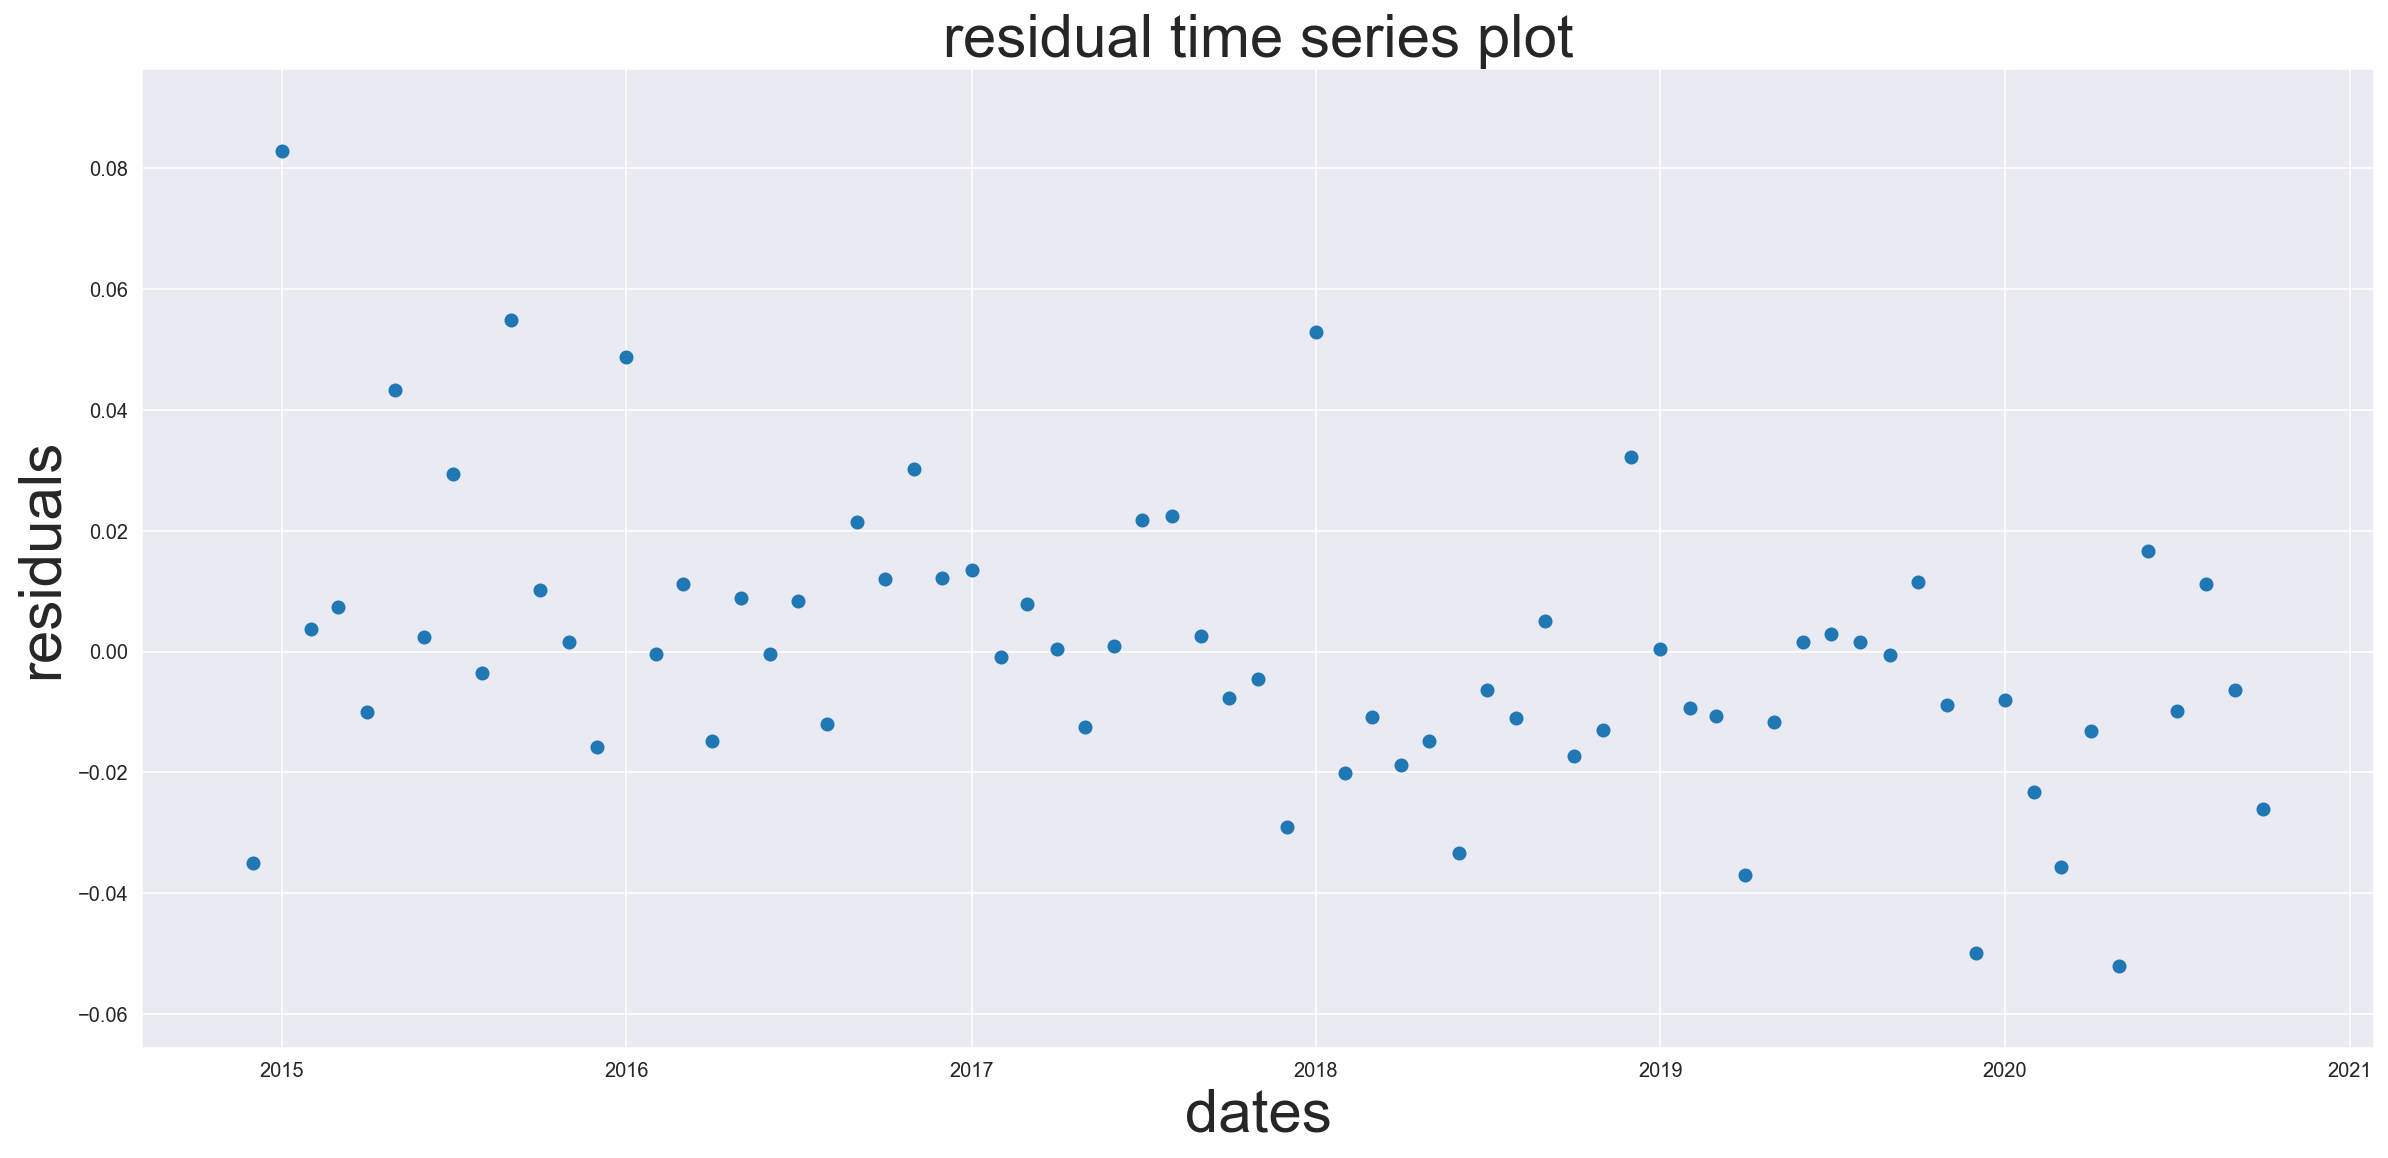

In [39]:
# to see constant variance of error terms
plt.scatter(y = modelpresid, x = portfolio_factors_3.index)
plt.title('residual time series plot', fontsize = 30)
plt.ylabel('residuals', fontsize = 30)
plt.xlabel('dates', fontsize = 30)
plt.show()


 Breusch-Pagan test ----
                                  value
Lagrange multiplier statistic  6.219427
p-value                        0.796503
f-value                        0.576046
f p-value                      0.826999
Fail to Reject Null, conclude homoscedasticity

 Goldfeld-Quandt test ----
                value
F statistic  0.863230
p-value      0.639497
Fail to Reject Null, conclude homoscedasticity

 Residuals plots ----


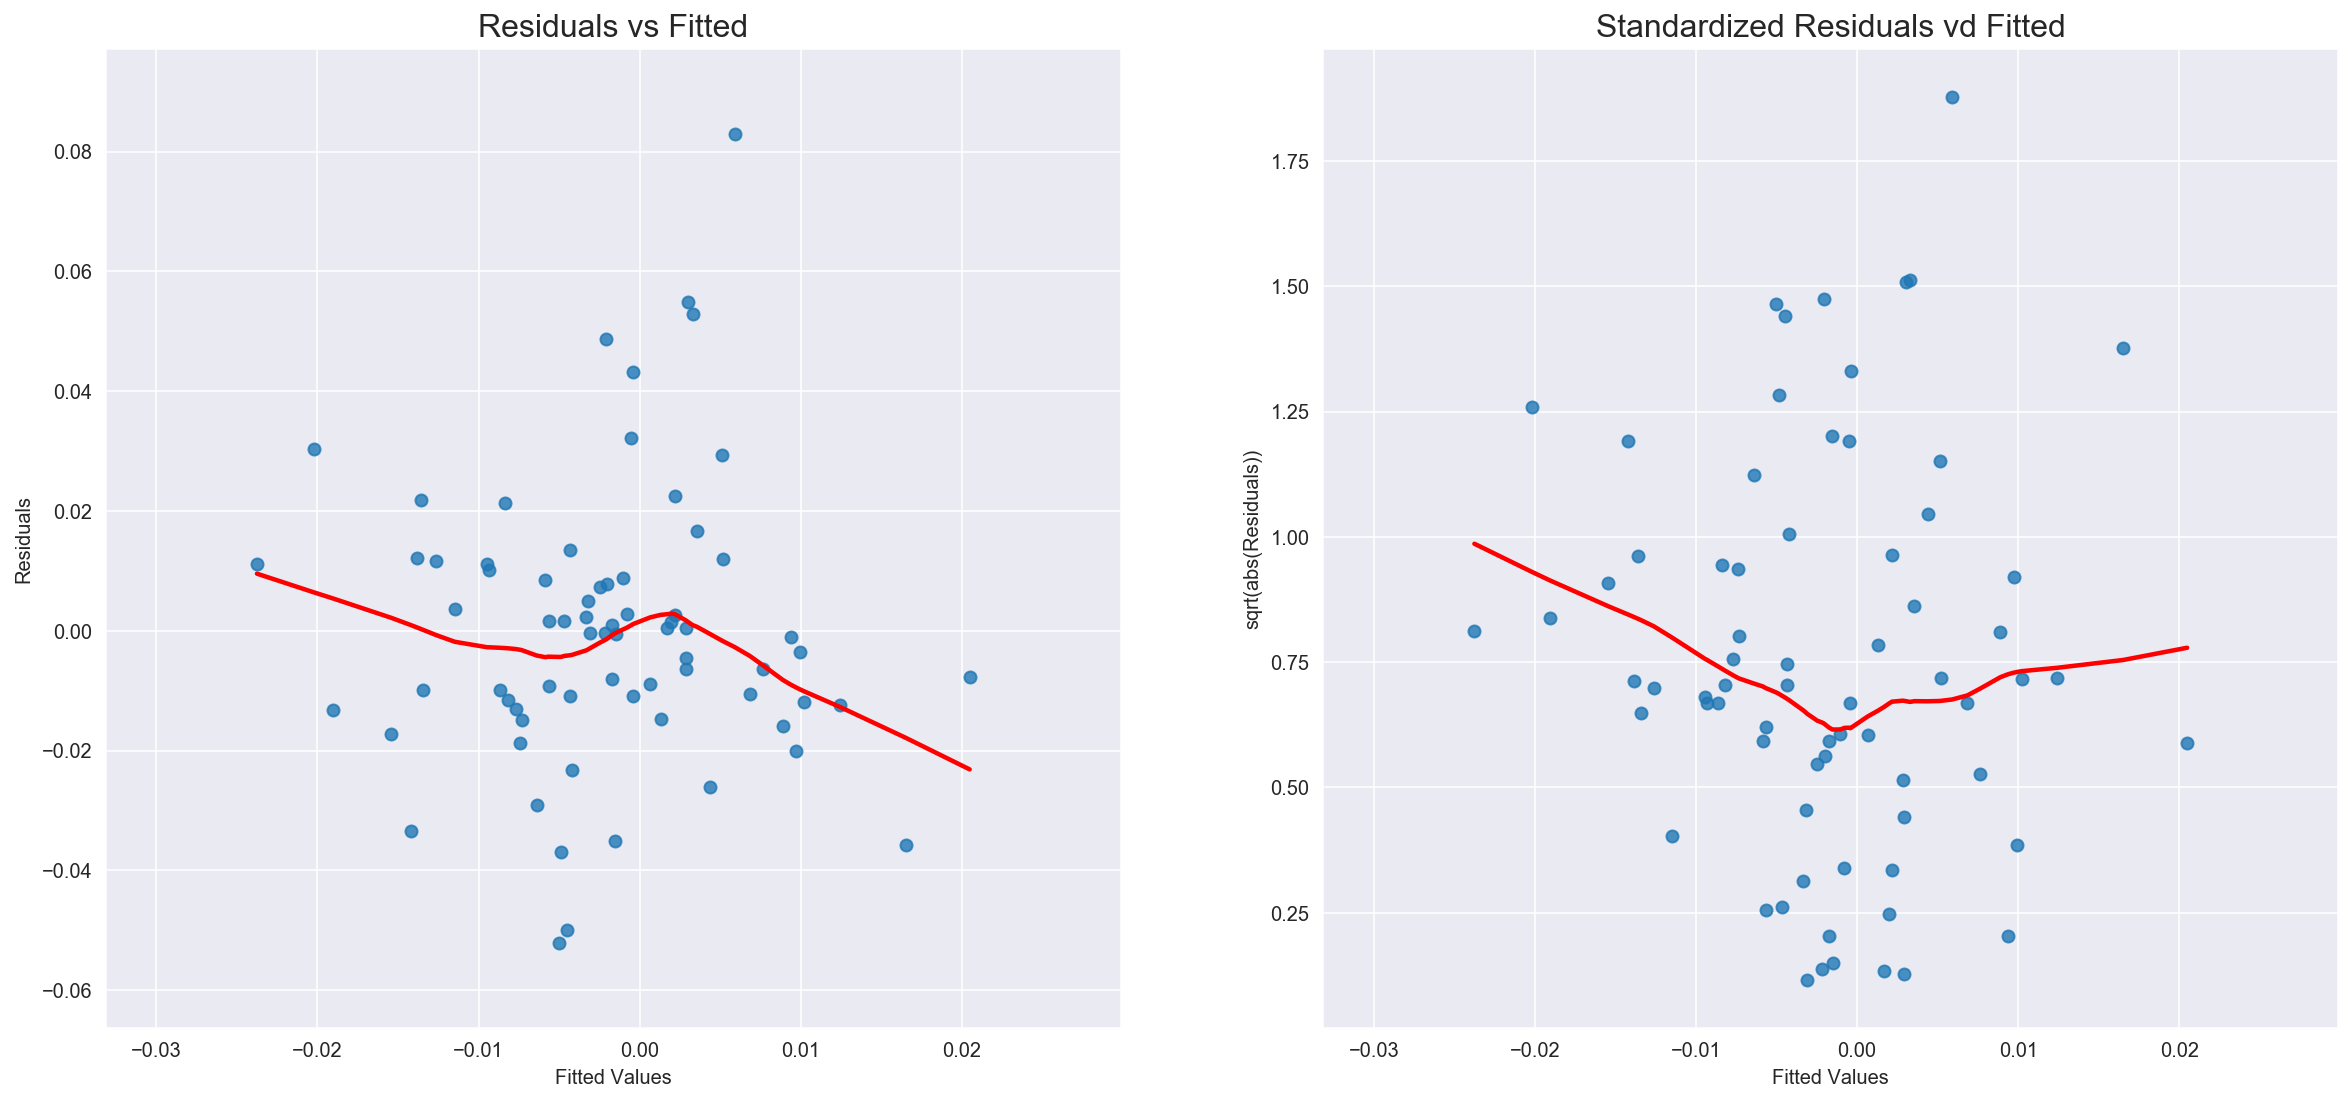

In [40]:
homoscedasticity_test(result_p)

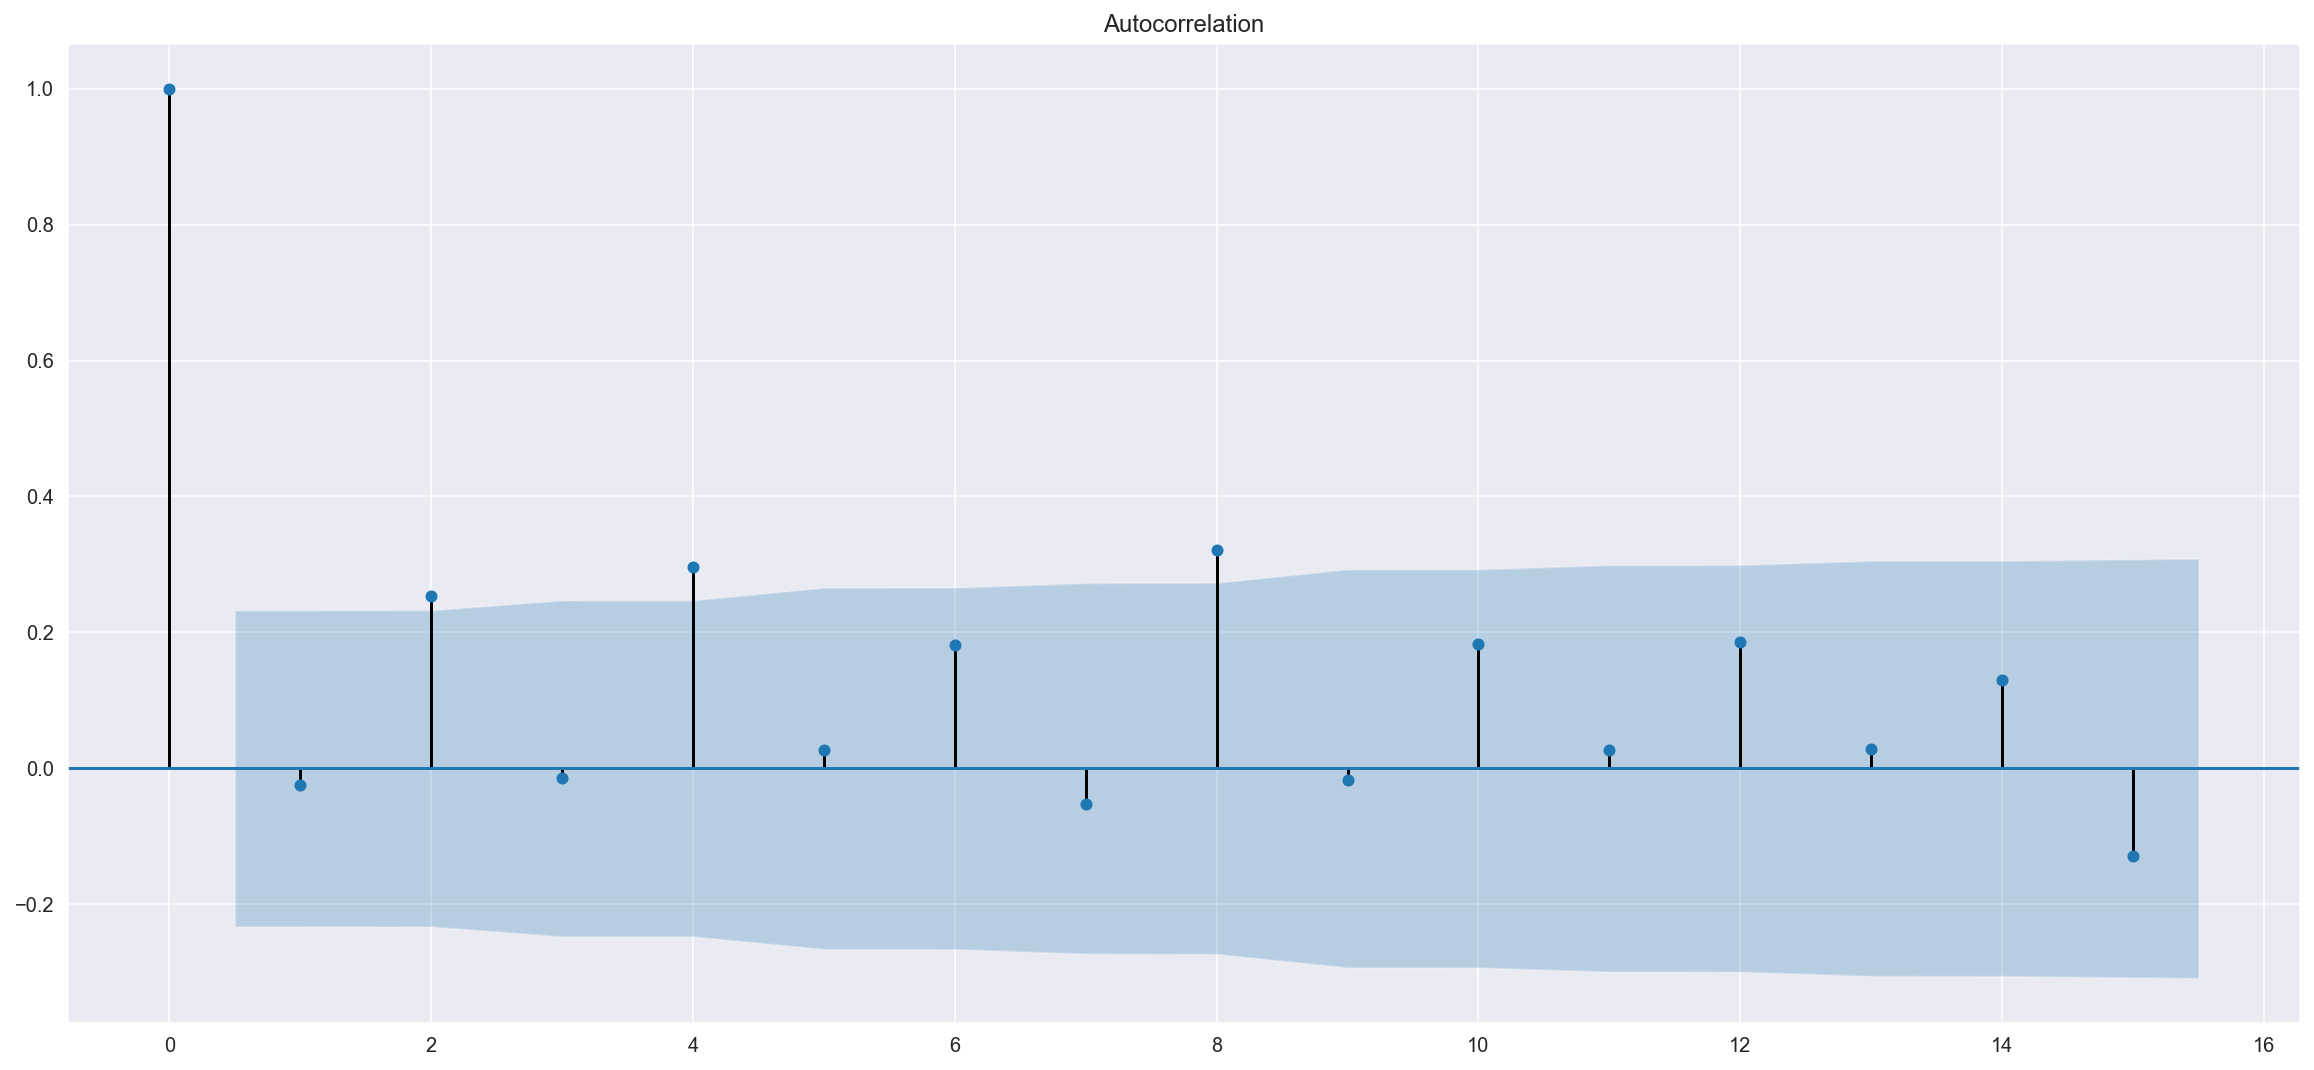

In [43]:
# check autocorrelation of error terms
plot_acf(modelpresid, lags = 15)
plt.show()

Spherical error variance is Satisfied.

##### Test Normality:

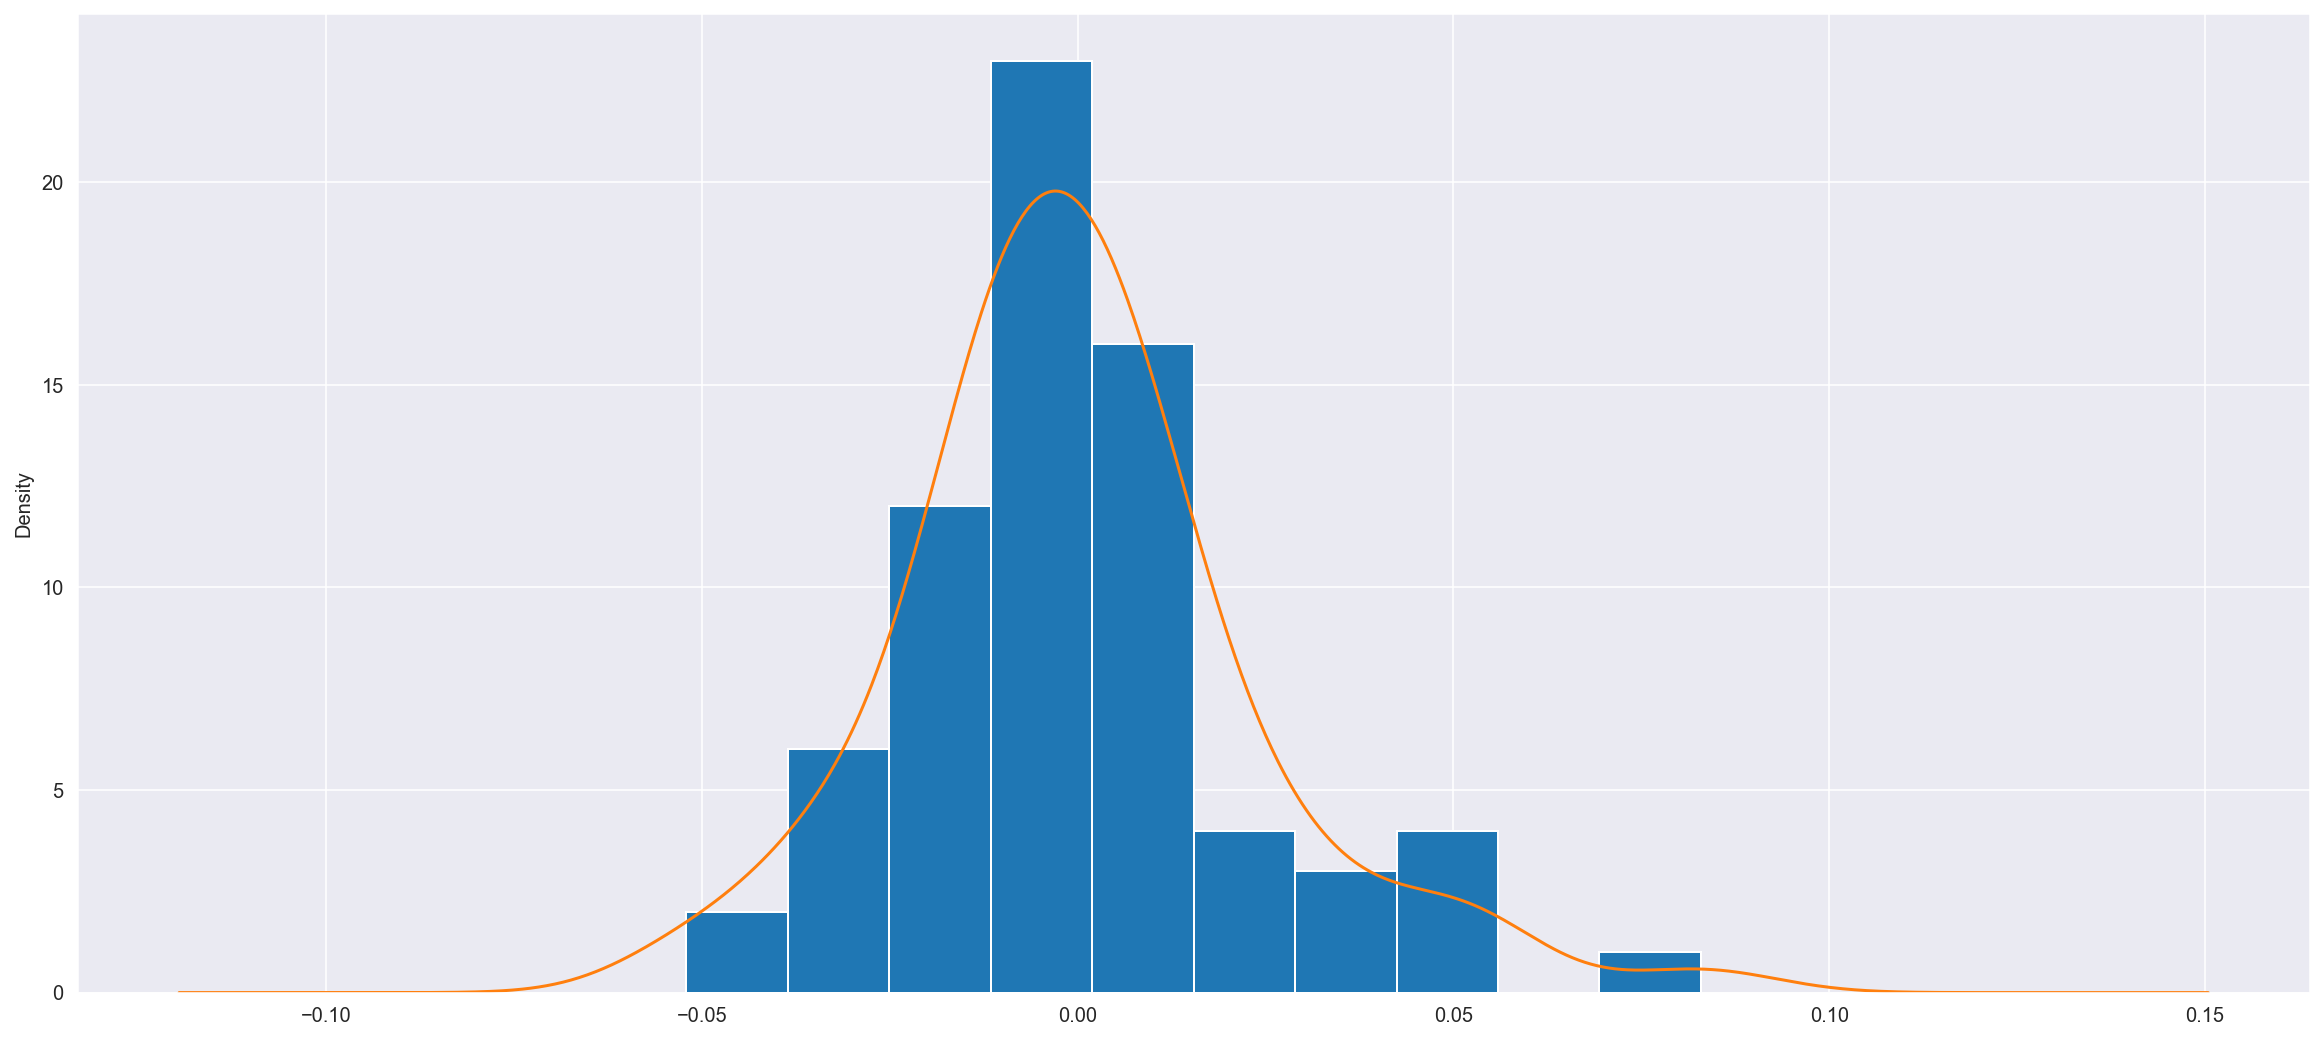

In [44]:
modelpresid.hist()
modelpresid.plot(kind='kde')
plt.show()

Normality is roughly satisfied.

##### Explanation: 

Classic CLR assumptions perform well in monthly 10 industry scenario since there are some industries are highly correlated with each other. 

10 indestry portfolio model cannot explain the AQR return very well.

One take-away:

when doing research on industry portfolios, we need to pay attention on the relationships among industries. In other words, when we allocate our portfolio, we want not only to optimize upon stock returns, but also pay attention to stock industry to ensure an enough diversification of our portfolio. 


### (g) Extra credit: Download and import the daily data of all the data series. Make sure you use the same time period as above. You will find them on Ken French’s website and Yahoo Finance. Then perform the same analysis as above. Are the classical linear regression assumptions satisfied for the regressions with daily data? Does your analysis using daily data provide different results compared to the analysis based on monthly data? Why, or why not?

###### Data Gathering:

In [45]:
# daily factors
daily_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', start = '1962-07-01', end = '2020-10-01')[0]
daily_factors['Mkt-RF'] = daily_factors['Mkt-RF'] + daily_factors['RF']
daily_factors.rename(columns={'Mkt-RF':'MktRet'},inplace=True)
#daily_factors = daily_factors.to_timestamp()
start_date_factors_daily = daily_factors.index[0]
end_date_factors_daily = daily_factors.index[-1]

daily_factors_withRF = daily_factors.copy()
daily_factors.drop(columns='RF', inplace=True)
daily_factors

MktRet   SMB   HML   RMW   CMA
Date                                      
1963-07-01  -0.658  0.00 -0.34 -0.01  0.15
1963-07-02   0.802 -0.27  0.27 -0.07 -0.19
1963-07-03   0.642 -0.17 -0.10  0.17 -0.33
1963-07-05   0.412  0.08 -0.27  0.08 -0.33
1963-07-08  -0.618  0.04 -0.19 -0.29  0.13
...            ...   ...   ...   ...   ...
2020-09-25   1.720 -0.16 -1.35 -0.50 -0.70
2020-09-28   1.660  0.86  1.02  0.36  0.19
2020-09-29  -0.420  0.42 -1.30 -0.78 -0.59
2020-09-30   0.790 -0.63  0.18  0.37  0.15
2020-10-01   0.790  0.81 -0.57 -0.03 -0.61

[14413 rows x 5 columns]

In [46]:
# Monthly returns from Yahoo Finance for the AQR Equity Market Neutral Fund Class I 
# (Ticker: QMNIX)
data_daily = yf.download('QMNIX', period = 'max', progress=False, interval='1d')
QMNIX_daily = data_daily[['Adj Close']].dropna()
daily_AQR_return = price2ret(QMNIX_daily)
start_date_hf_daily = daily_AQR_return.index[0]
end_date_hf_daily = daily_AQR_return.index[-1]
daily_AQR_return

Return
Date                
2014-10-10  0.003021
2014-10-13 -0.001004
2014-10-14 -0.005025
2014-10-15 -0.006060
2014-10-16 -0.008130
...              ...
2021-03-11 -0.005814
2021-03-12  0.004386
2021-03-15 -0.004367
2021-03-16  0.005848
2021-03-17  0.004360

[1619 rows x 1 columns]

##### Summary Statistics of Fama-French Data:

In [47]:
daily_factors.agg(['mean','std','skew','kurtosis','max','min']) # kurtosis is high

MktRet        SMB        HML        RMW        CMA
mean       0.044292   0.006544   0.012392   0.012829   0.012394
std        1.014092   0.529624   0.537433   0.374193   0.365208
skew      -0.566287  -0.815251   0.267150   0.307172  -0.361217
kurtosis  16.822708  20.288383  11.610277  10.178809  10.747427
max       11.354000   6.080000   4.830000   4.490000   2.530000
min      -17.413000 -11.170000  -4.710000  -3.020000  -5.940000

In [47]:
daily_factors.corr()

MktRet       SMB       HML       RMW       CMA
MktRet  1.000000 -0.091772 -0.151035 -0.192360 -0.360718
SMB    -0.091772  1.000000  0.117694 -0.262592  0.021756
HML    -0.151035  0.117694  1.000000 -0.019418  0.531793
RMW    -0.192360 -0.262592 -0.019418  1.000000  0.082932
CMA    -0.360718  0.021756  0.531793  0.082932  1.000000

Text(0.5, 1.0, 'CMA')

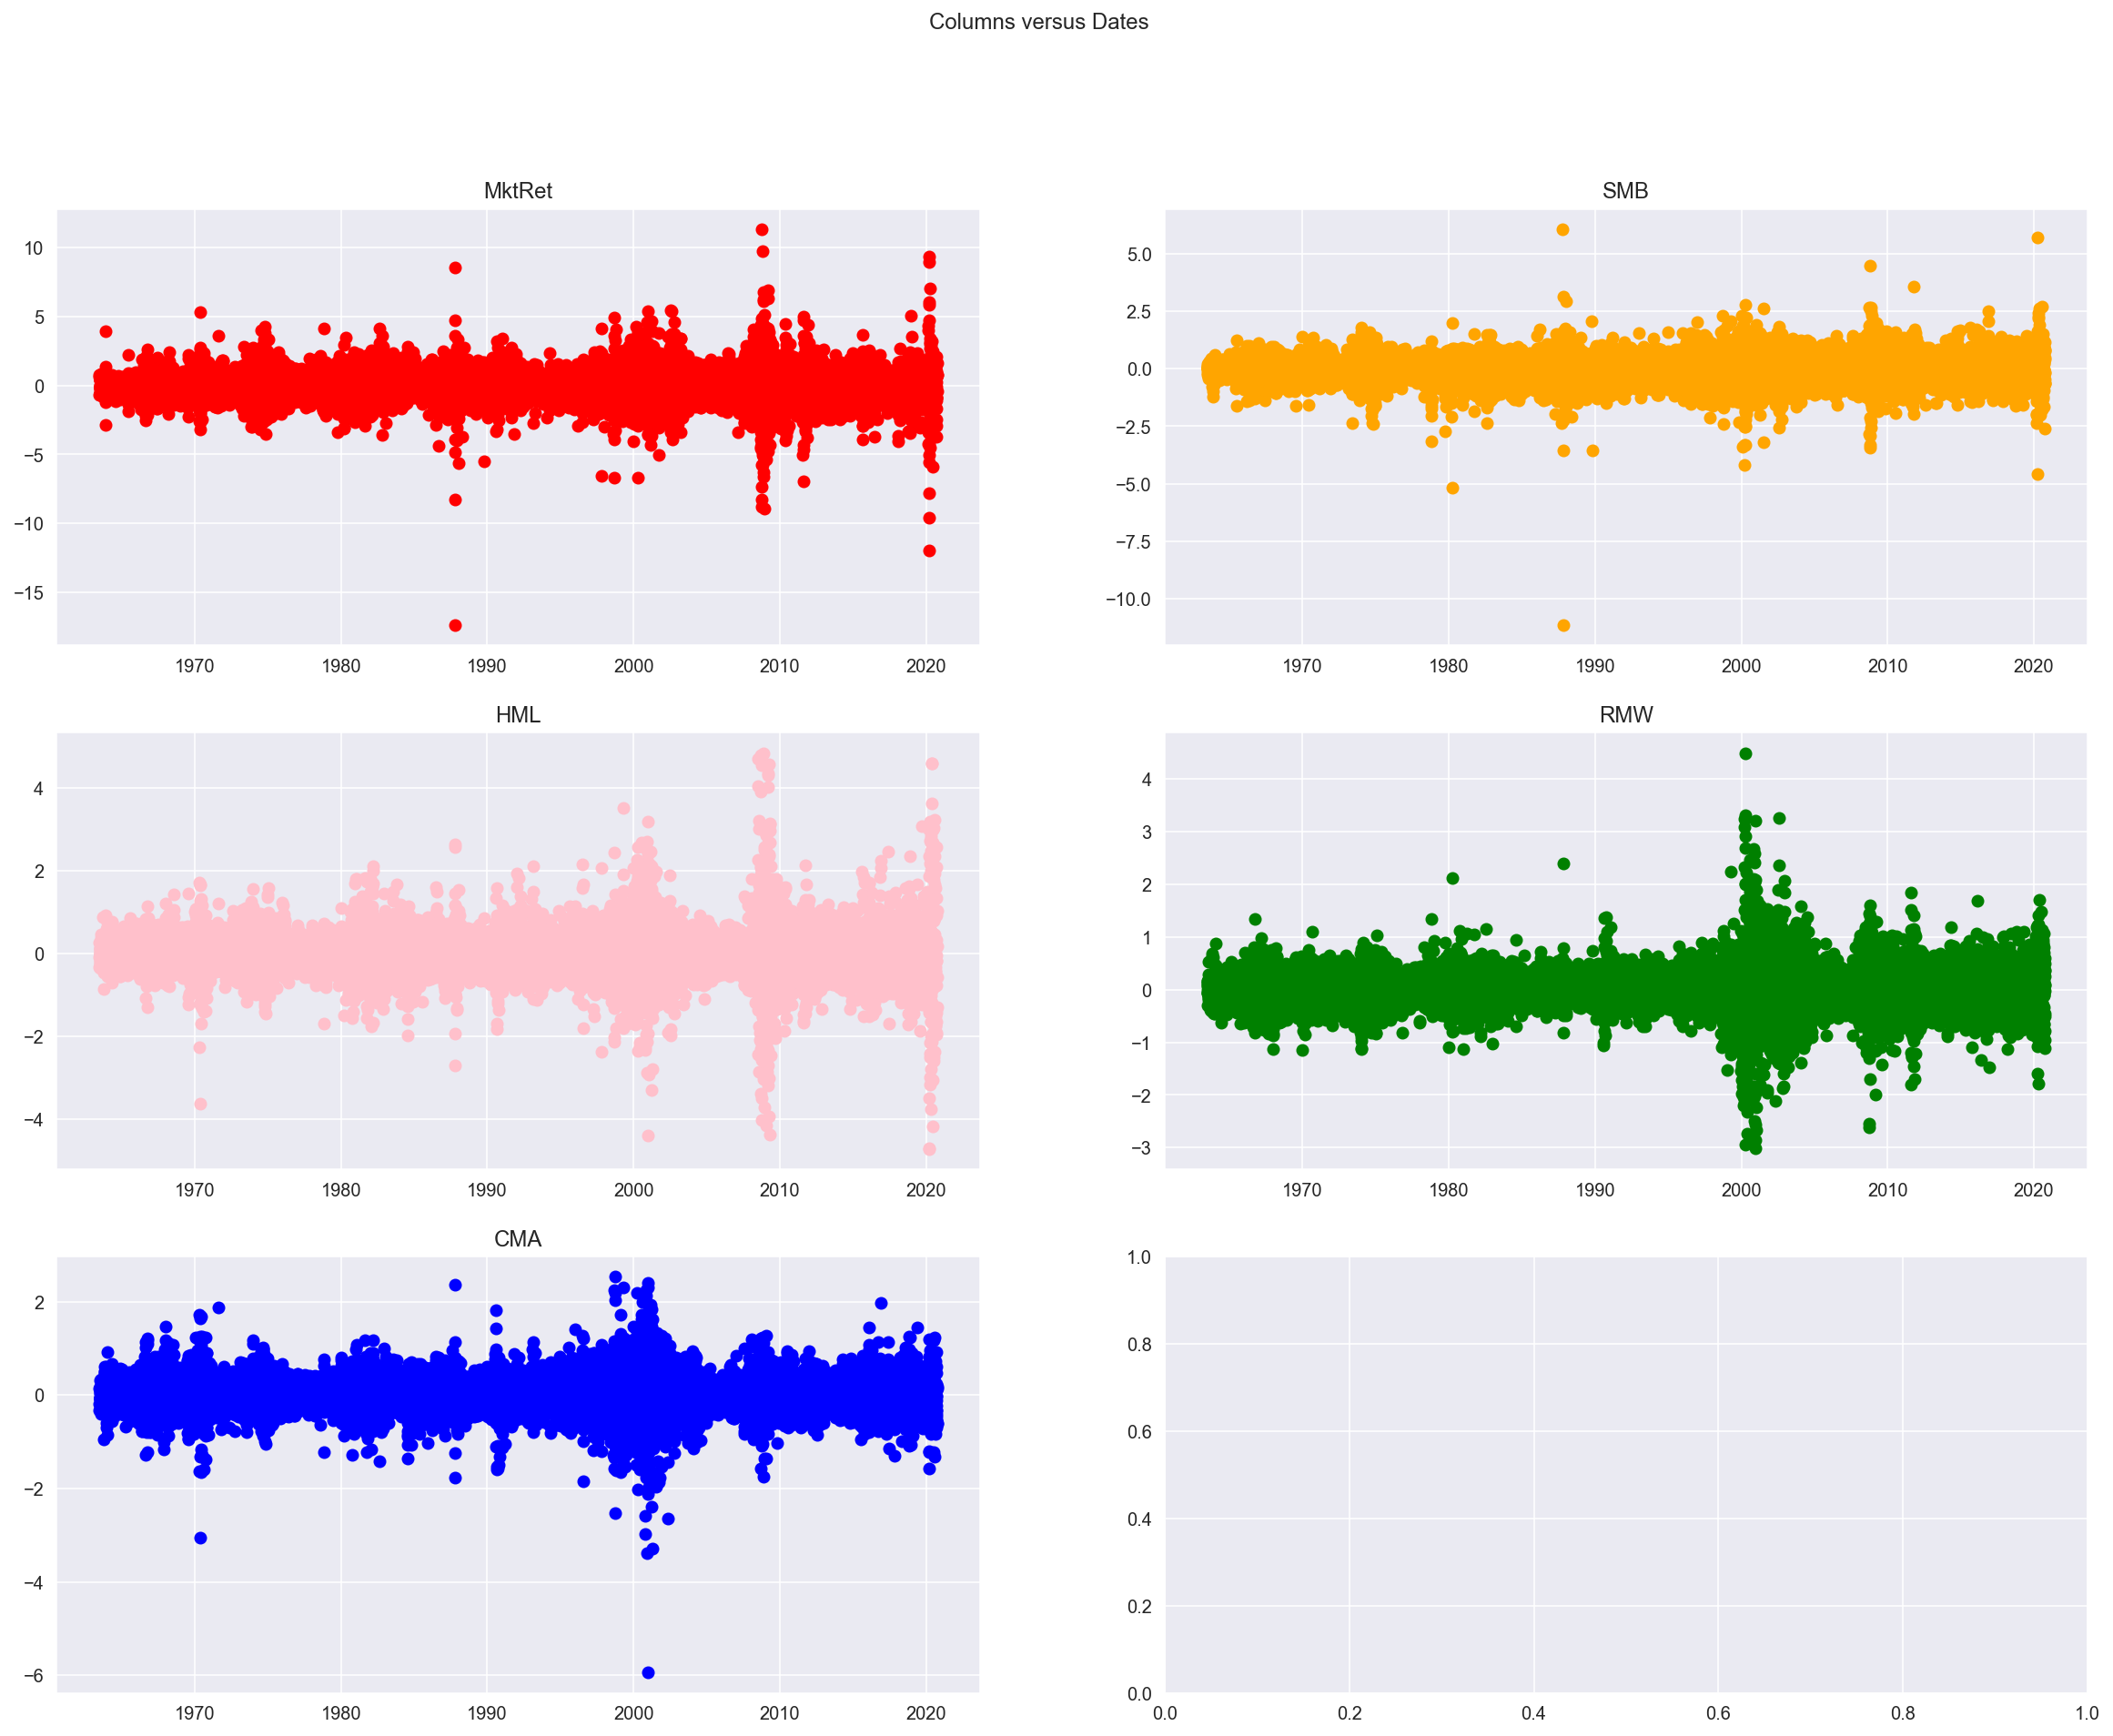

In [48]:
# Factors
# time series of each column
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,15))
fig.suptitle('Columns versus Dates')
x = daily_factors.index
ax1.scatter(x, daily_factors['MktRet'], color='red')
ax1.set_title('MktRet')
ax2.scatter(x, daily_factors['SMB'], color='orange')
ax2.set_title('SMB')
ax3.scatter(x, daily_factors['HML'], color='pink')
ax3.set_title('HML')
ax4.scatter(x, daily_factors['RMW'], color='green')
ax4.set_title('RMW')
ax5.scatter(x, daily_factors['CMA'], color='blue')
ax5.set_title('CMA')

There are several periods on which the market was flunctuating a lot: 1987/1988, 2008, 2020.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026600AFF710>,
      dtype=object)

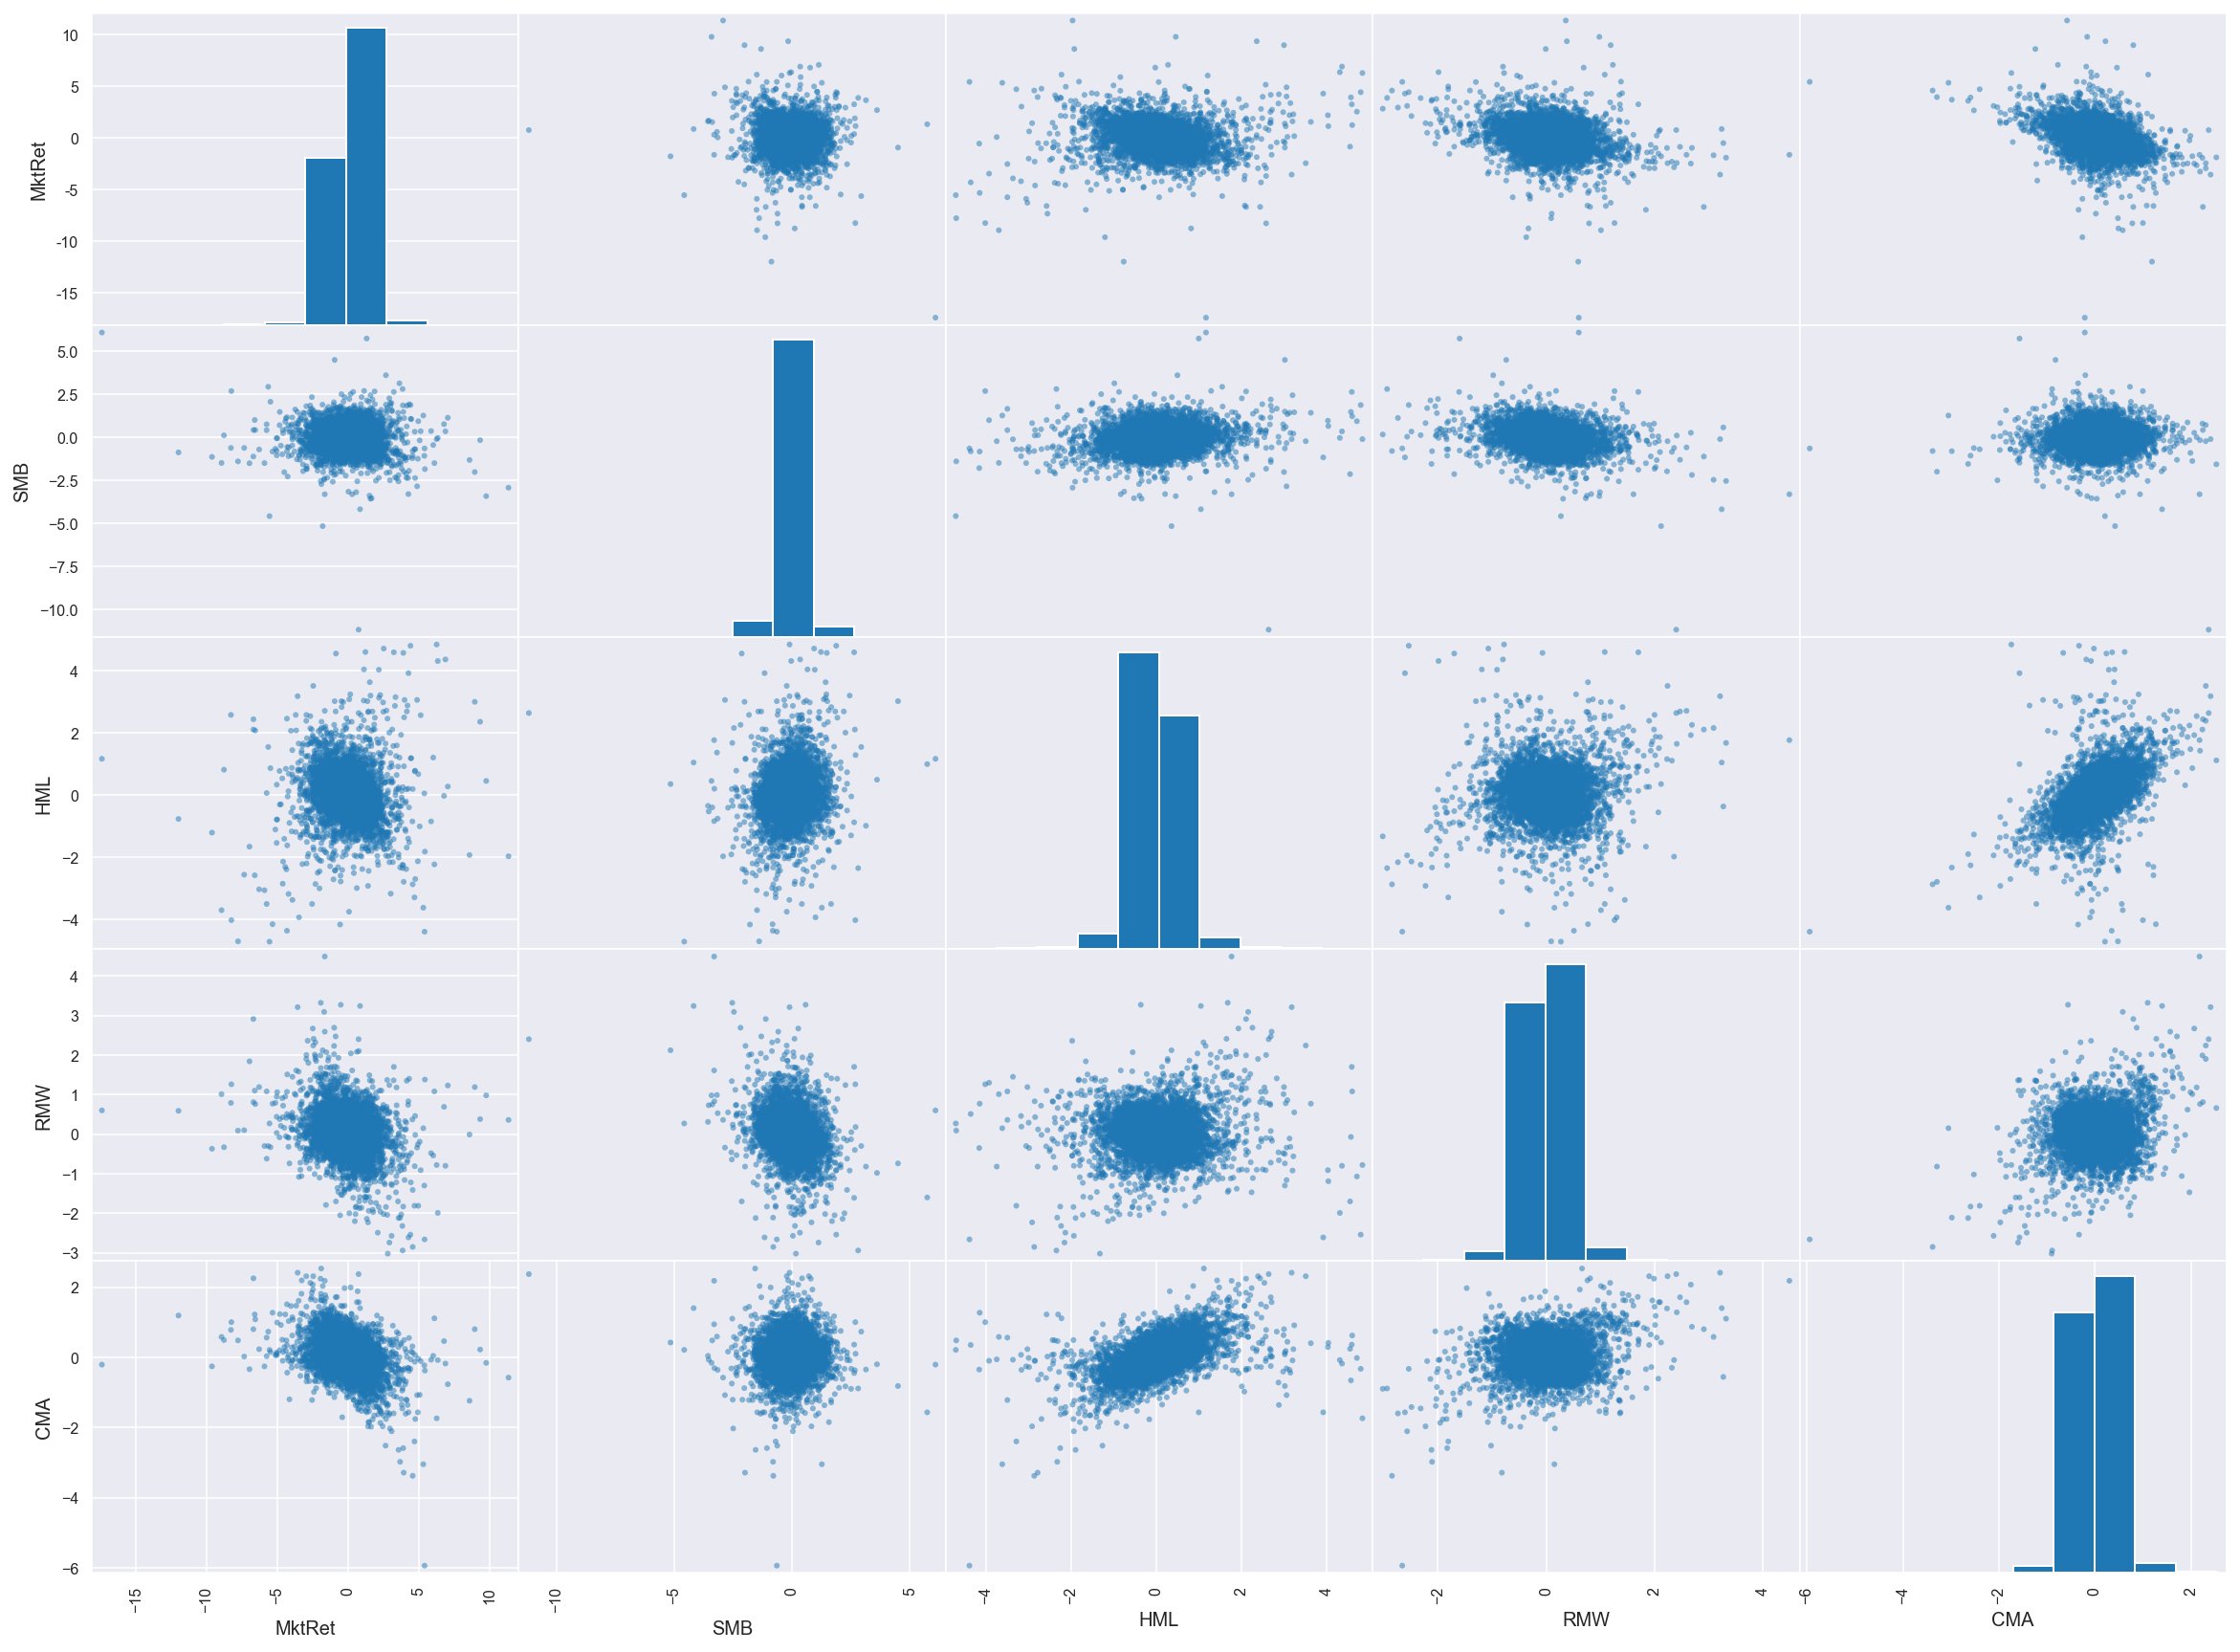

In [49]:
# among factor columns
attributes = daily_factors.columns
scatter_matrix(daily_factors[attributes], figsize=(20,15))
# IMAGES_PATH = r'~\Desktop\DS\HW4'
# plt.savefig("scatter_matrix_plot_v2_daily")

Same as monthly data, CMA and HML has a positive correlation according to this scatter plot.

##### Summary Statistics of Hedge Fund AQR Daily Return Data:

In [50]:
daily_AQR_return.agg(['mean','std','skew','kurtosis','max','min']) # high kurtosis

Return
mean       -0.000123
std         0.005830
skew      -11.552268
kurtosis  298.450705
max         0.025950
min        -0.153538

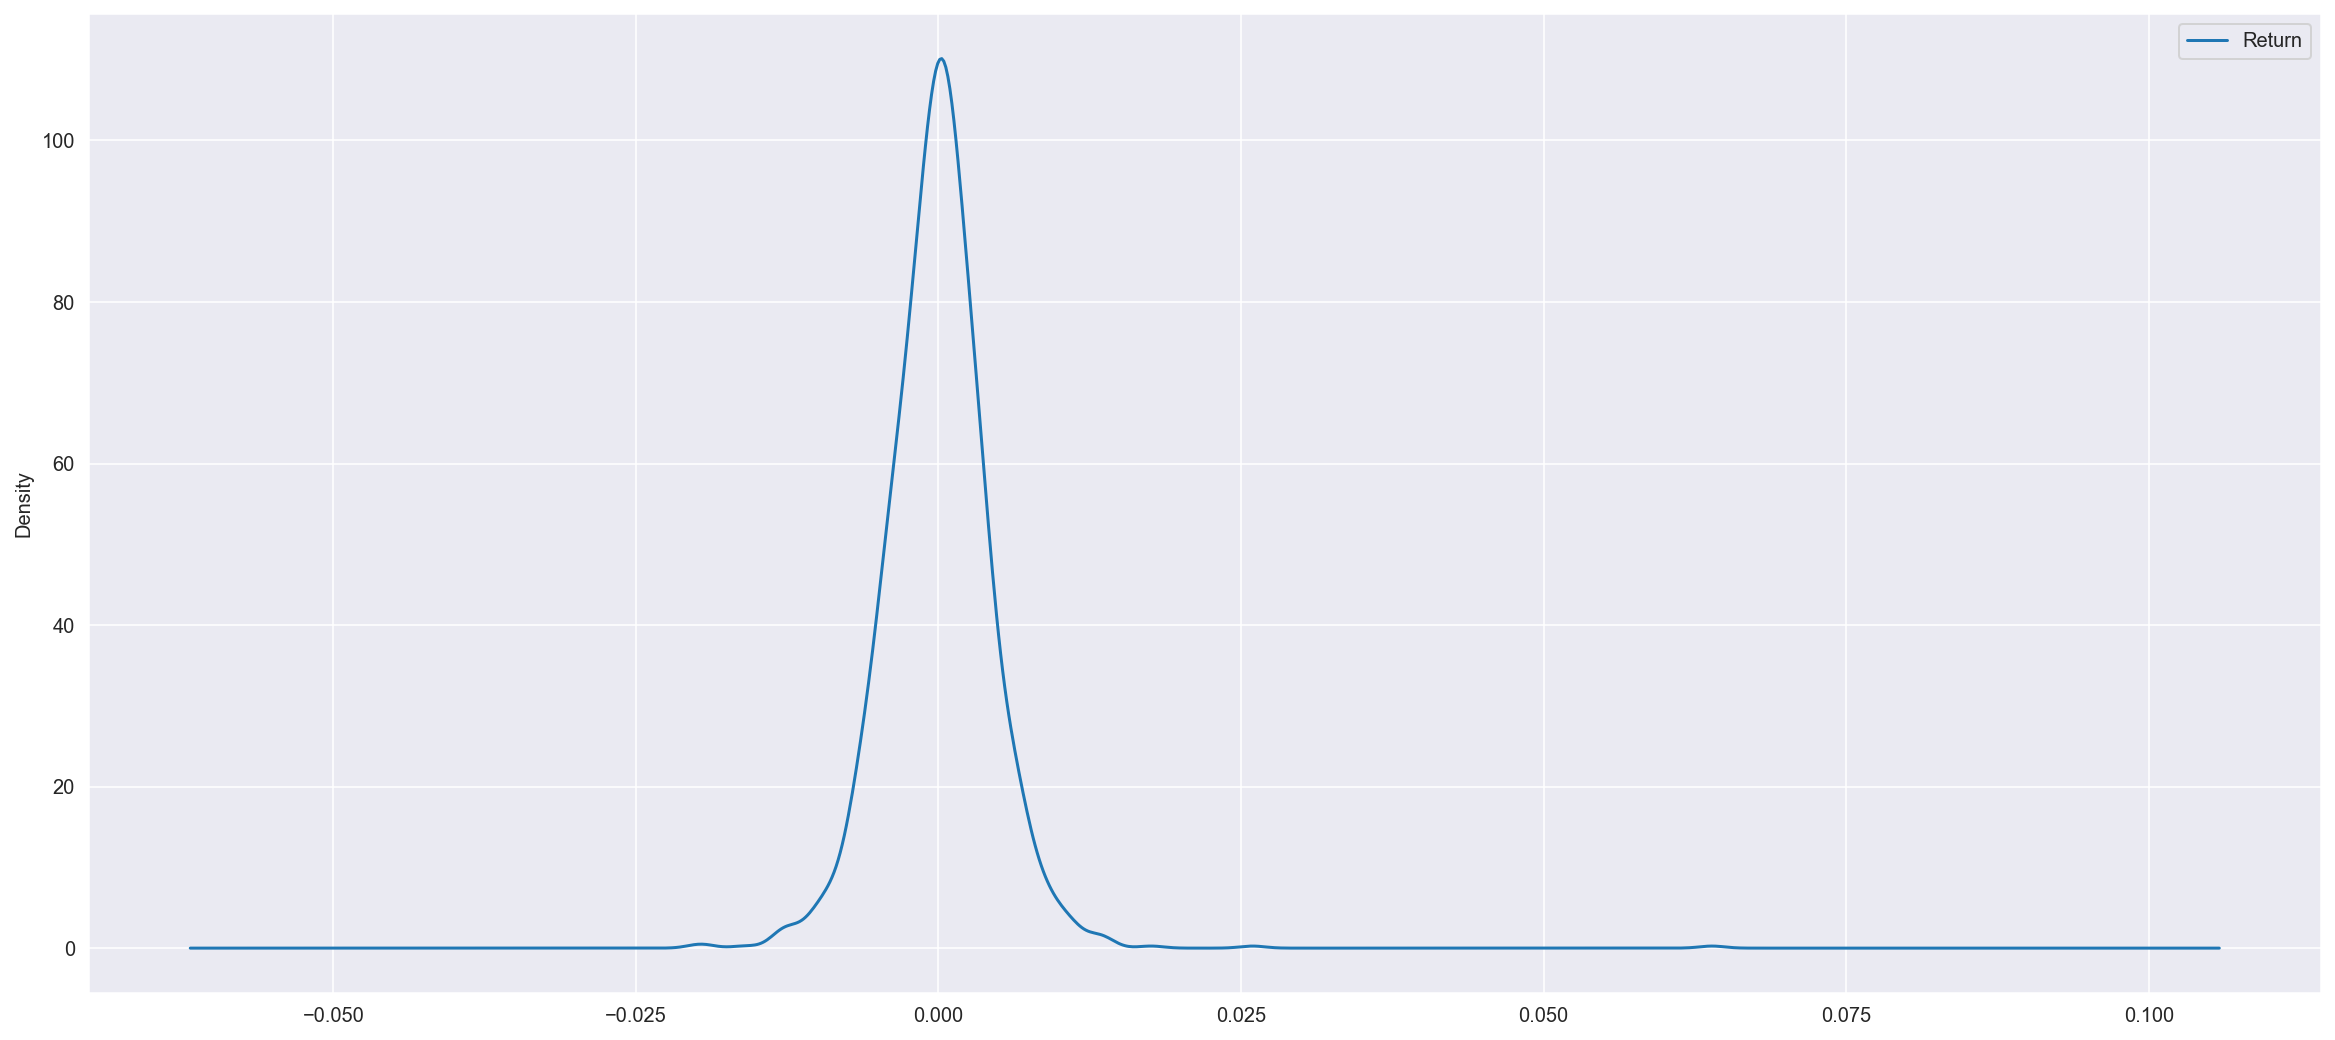

In [51]:
daily_AQR_return.plot(kind='kde')

Text(0, 0.5, 'Daily Return')

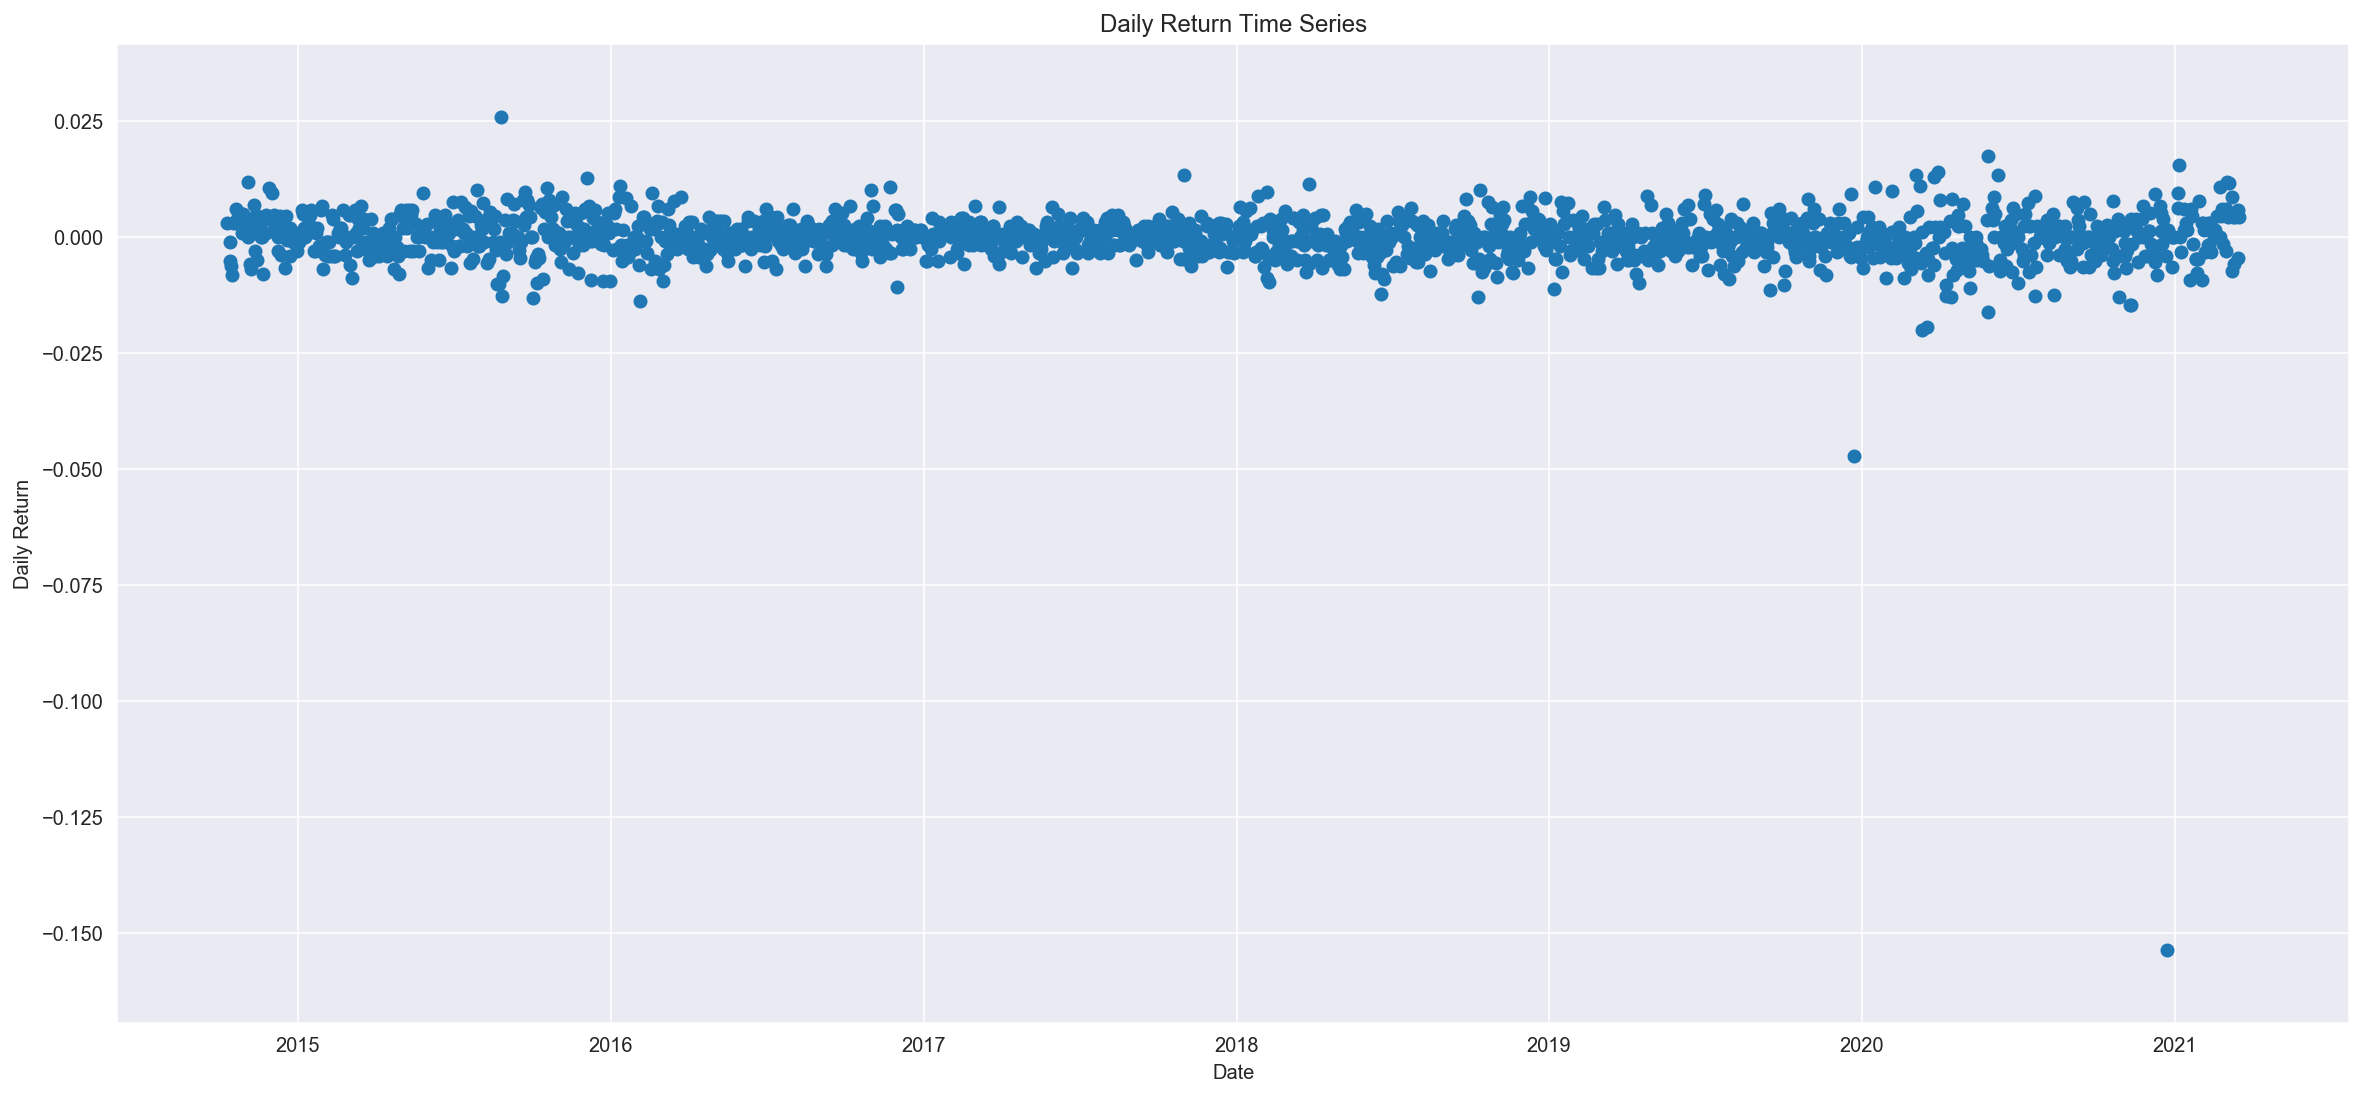

In [51]:
plt.scatter(daily_AQR_return.index, daily_AQR_return['Return'])
plt.title('Daily Return Time Series')
plt.xlabel('Date')
plt.ylabel('Daily Return')

There are always one or two outliers, need to do further research to see how to deal with it or whether we just leave it there or not.

This time series looks stationary.


##### Relationship between Fama-French Factors and Hedge Fund Daily Returns:

For scatter plots, we need consistent start/end dates for two datasets:
start_date:  2014-10
end_date:  2020-10


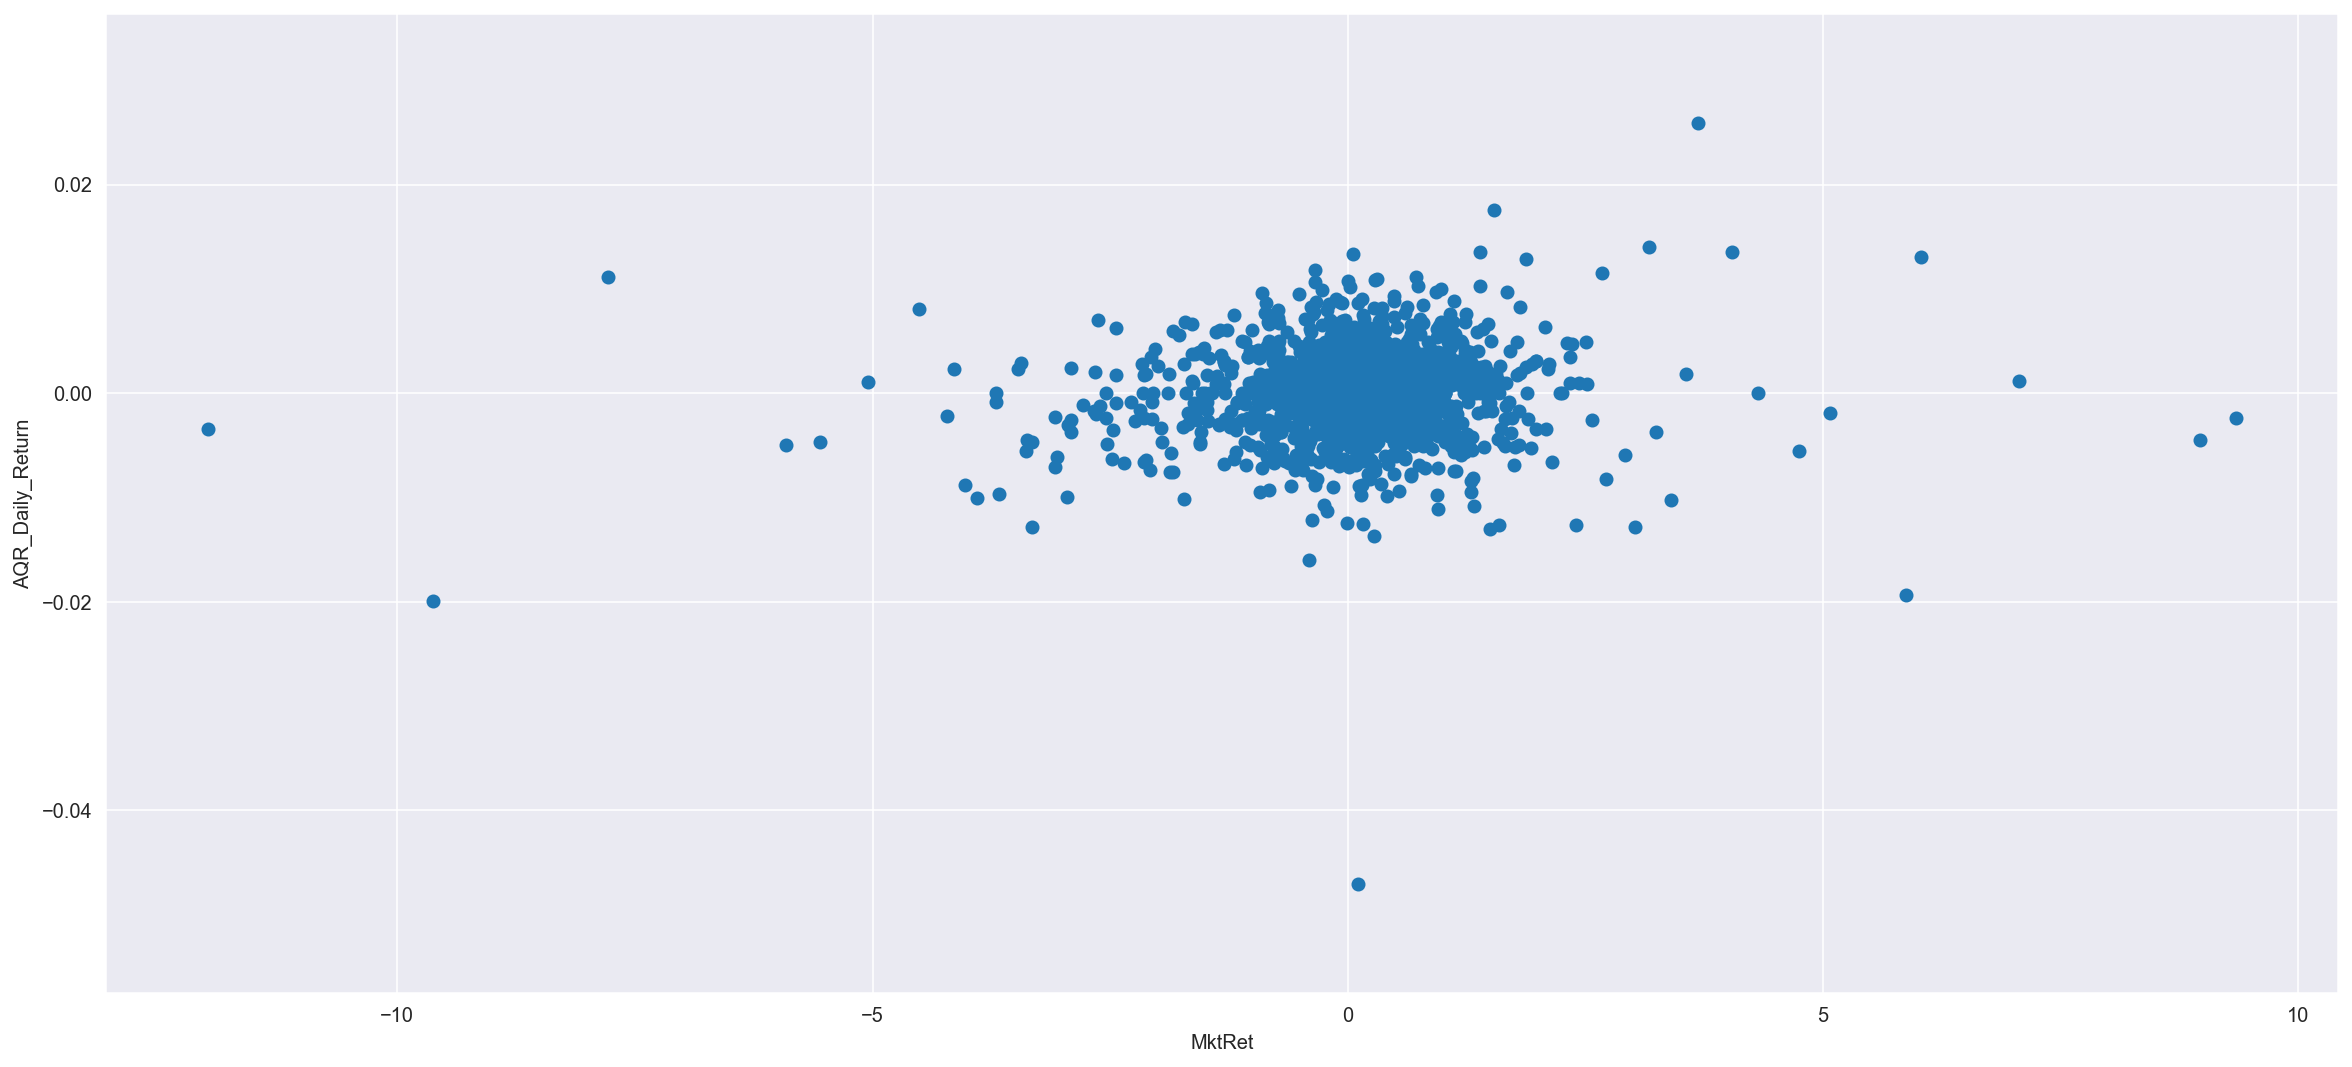

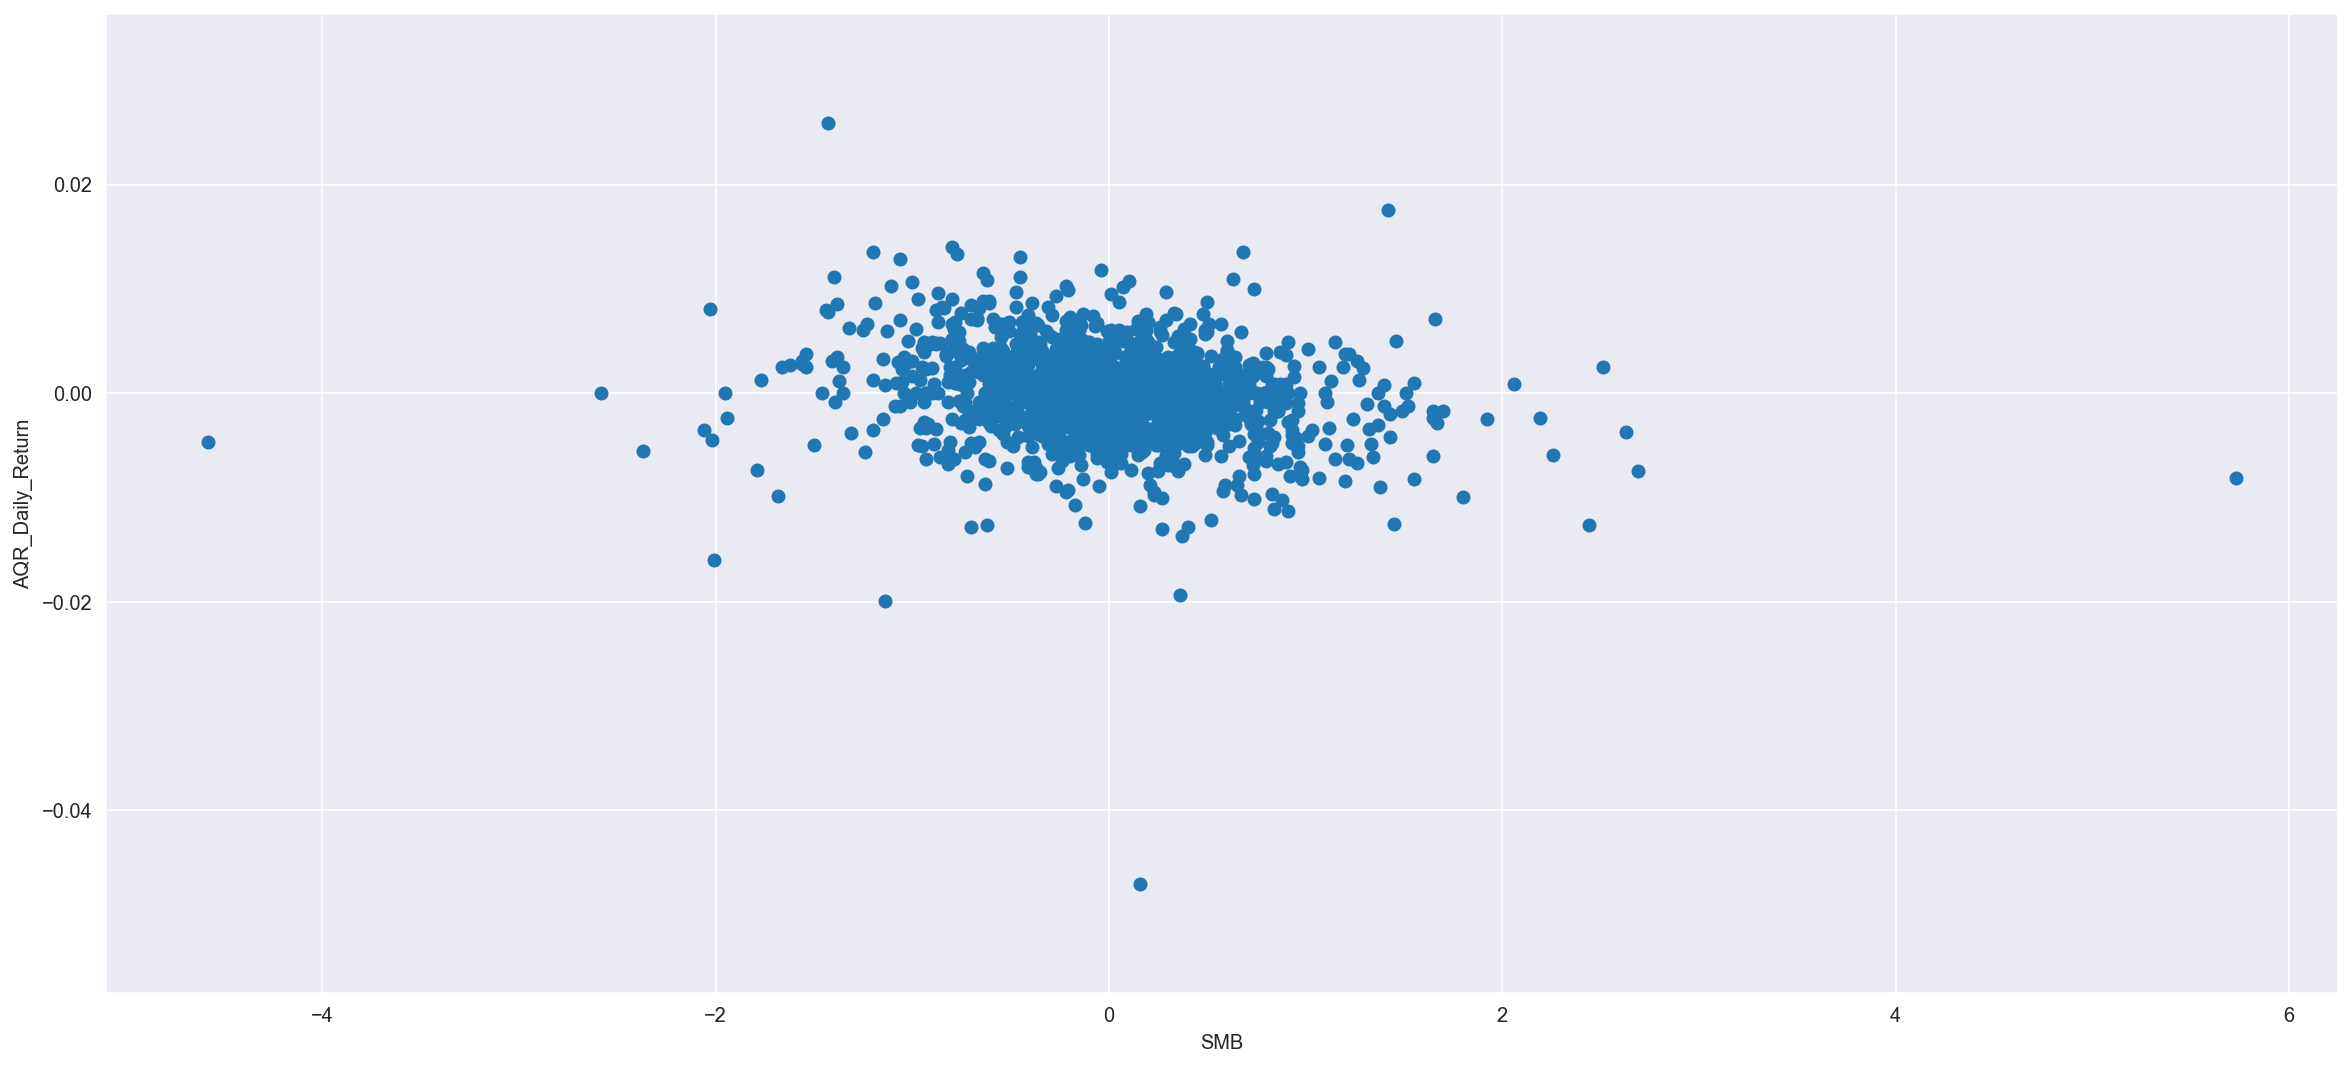

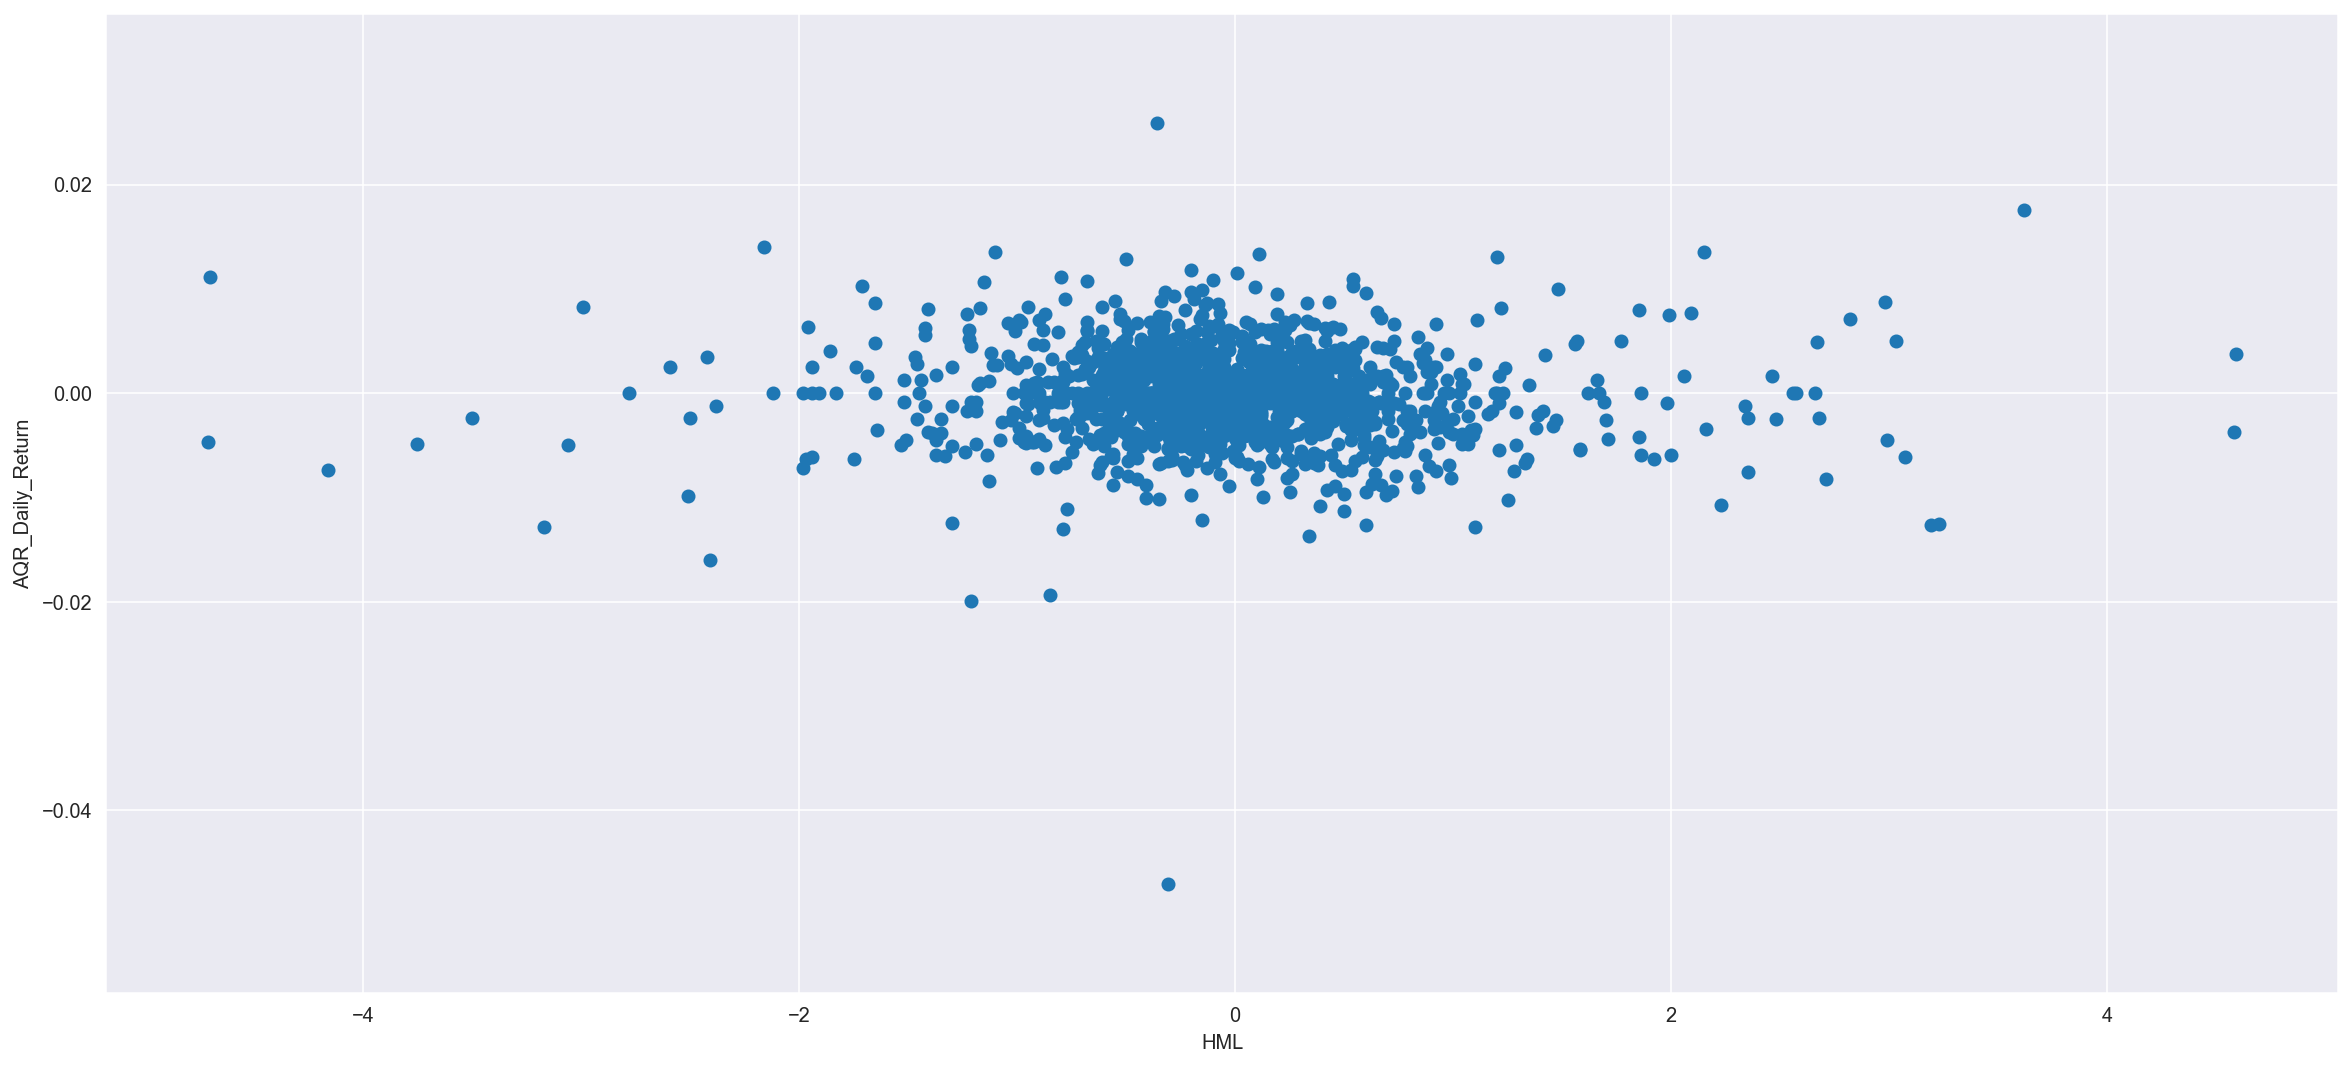

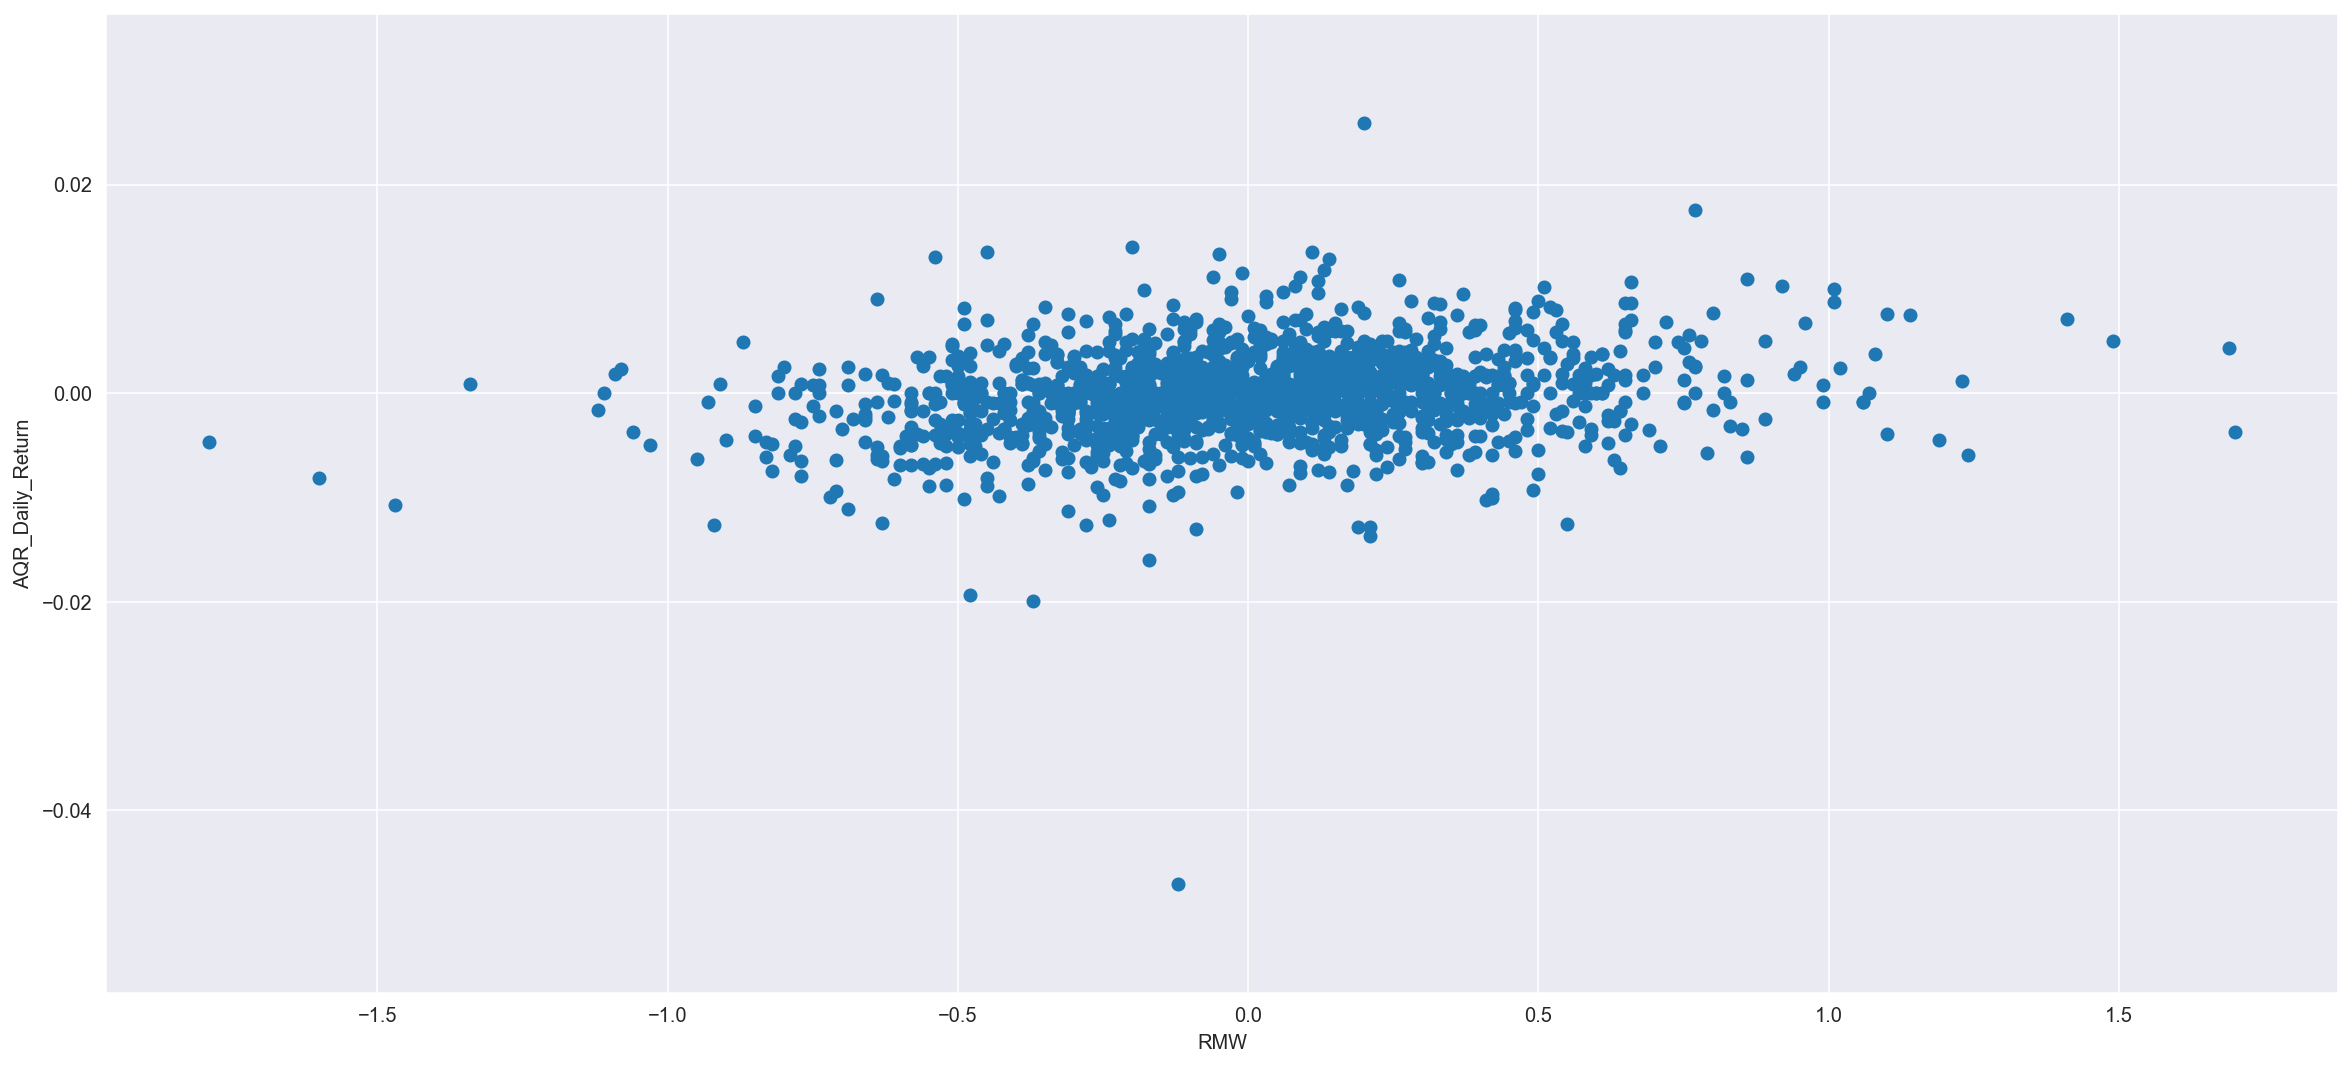

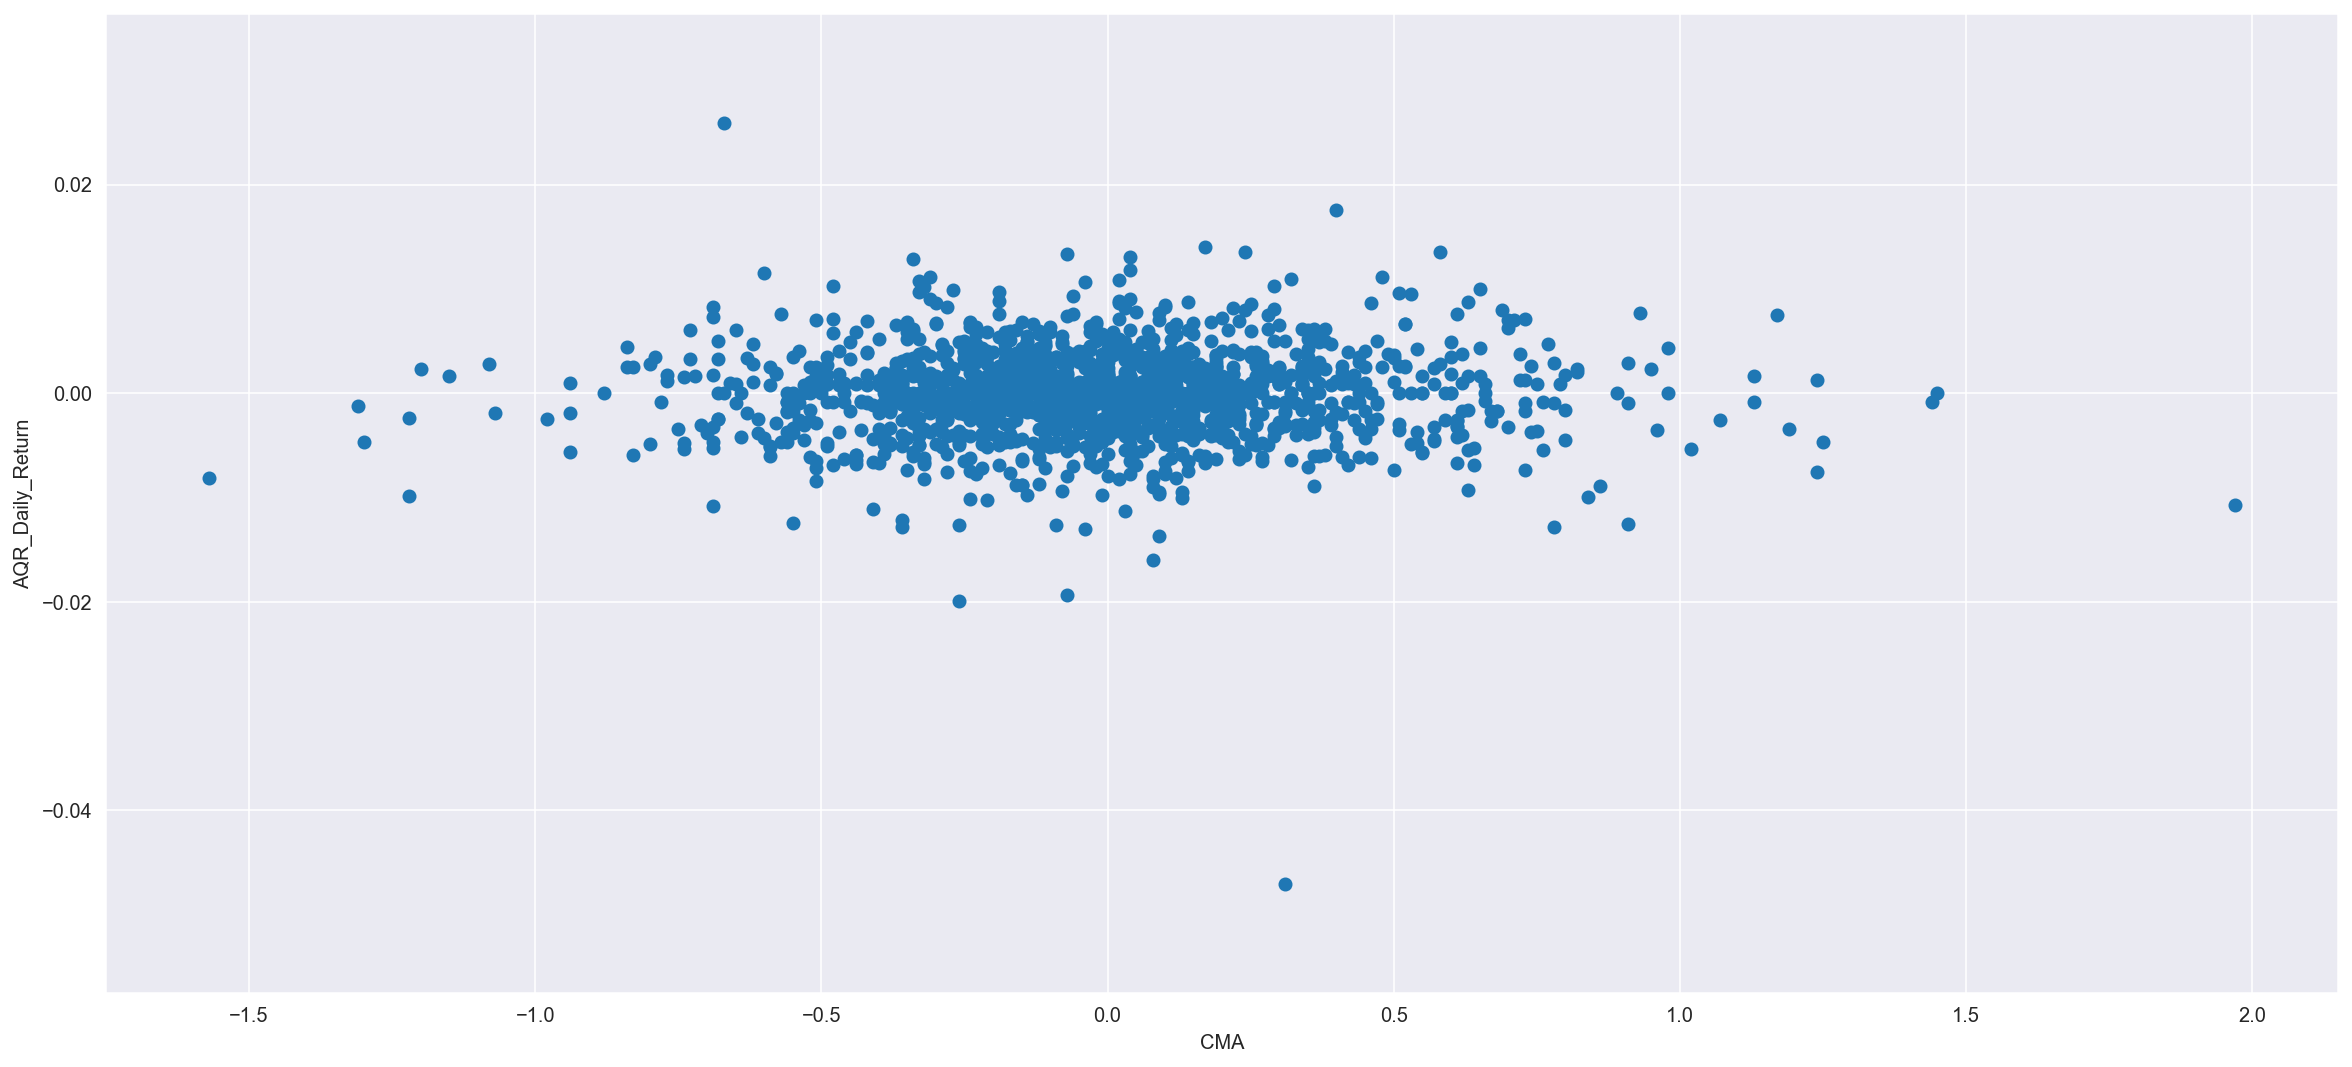

          returns
MktRet   0.083747
SMB     -0.207652
HML     -0.036913
RMW      0.227484
CMA      0.009414
returns  1.000000


In [52]:
start_daily = max(start_date_factors_daily, start_date_hf_daily)
end_daily = min(end_date_factors_daily, end_date_hf_daily)
print('For scatter plots, we need consistent start/end dates for two datasets:')
print('start_date: ', str(start_daily)[:7])
print('end_date: ', str(end_daily)[:7])
df_factors_2_daily = daily_factors.loc[start_daily:end_daily]
df_AQR_return_2_daily = daily_AQR_return.loc[start_daily:end_daily]

attributes = df_factors_2_daily.columns
for att in attributes:
    plt.scatter(df_factors_2_daily[att], df_AQR_return_2_daily['Return'])
    plt.xlabel(att)
    plt.ylabel('AQR_Daily_Return')
    plt.show()
    
df22 = df_factors_2_daily.copy()
df22['returns'] = df_AQR_return_2_daily
print(df22.corr()[['returns']])


##### Regression:

In [53]:
df_stock_factor_daily = pd.merge(df_AQR_return_2_daily, df_factors_2_daily, left_index=True, right_index=True)
# df_stock_factor_daily.to_csv(r'C:\Users\xxxli\Desktop\model3_Data.csv')
df_stock_factor_daily

Return  MktRet   SMB   HML   RMW   CMA
Date                                                
2014-10-10  0.003021   -1.30 -0.07  0.51  0.76  0.37
2014-10-13 -0.001004   -1.59  1.31  0.49 -0.32  0.22
2014-10-14 -0.005025    0.28  0.82 -0.12  0.01  0.07
2014-10-15 -0.006060   -0.53  1.65 -1.33 -0.48 -0.59
2014-10-16 -0.008130    0.22  1.07  0.24 -0.45  0.12
...              ...     ...   ...   ...   ...   ...
2020-09-25 -0.003783    1.72 -0.16 -1.35 -0.50 -0.70
2020-09-28 -0.001266    1.66  0.86  1.02  0.36  0.19
2020-09-29 -0.005070   -0.42  0.42 -1.30 -0.78 -0.59
2020-09-30  0.000000    0.79 -0.63  0.18  0.37  0.15
2020-10-01 -0.003822    0.79  0.81 -0.57 -0.03 -0.61

[1505 rows x 6 columns]

In [54]:
# regressors: 5 Factors
X_daily = df_stock_factor_daily[df_stock_factor_daily.columns[1:]]   
X_daily

MktRet   SMB   HML   RMW   CMA
Date                                      
2014-10-10   -1.30 -0.07  0.51  0.76  0.37
2014-10-13   -1.59  1.31  0.49 -0.32  0.22
2014-10-14    0.28  0.82 -0.12  0.01  0.07
2014-10-15   -0.53  1.65 -1.33 -0.48 -0.59
2014-10-16    0.22  1.07  0.24 -0.45  0.12
...            ...   ...   ...   ...   ...
2020-09-25    1.72 -0.16 -1.35 -0.50 -0.70
2020-09-28    1.66  0.86  1.02  0.36  0.19
2020-09-29   -0.42  0.42 -1.30 -0.78 -0.59
2020-09-30    0.79 -0.63  0.18  0.37  0.15
2020-10-01    0.79  0.81 -0.57 -0.03 -0.61

[1505 rows x 5 columns]

In [55]:
# response variable: Returns of QMNIX Monthly
y_daily = df_stock_factor_daily[['Return']]
y_daily

Return
Date                
2014-10-10  0.003021
2014-10-13 -0.001004
2014-10-14 -0.005025
2014-10-15 -0.006060
2014-10-16 -0.008130
...              ...
2020-09-25 -0.003783
2020-09-28 -0.001266
2020-09-29 -0.005070
2020-09-30  0.000000
2020-10-01 -0.003822

[1505 rows x 1 columns]

In [56]:
# Running OLS model:
X_daily = sm.add_constant(X_daily)
model_daily = sm.OLS(y_daily, X_daily).fit()
FF5tstat_daily = model_daily.tvalues
FF5coeff_daily = model_daily.params
FF5fitted_daily = model_daily.fittedvalues
FF5resid_daily = model_daily.resid
model_daily.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     34.21
Date:                Thu, 18 Mar 2021   Prob (F-statistic):           3.44e-33
Time:                        00:17:52   Log-Likelihood:                 6135.8
No. Observations:                1505   AIC:                        -1.226e+04
Df Residuals:                    1499   BIC:                        -1.223e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -1.182      0.238      -0.000    8.29e-05
MktRet         0.0005   9.58e-05      5.218      0.000       0.000       0.001
SMB           -0.0013      0.000     -7.091      0.000      -0.002      -0.001
HML           -0.0003      0.000     -1.657      0.098      -0.001    5.38e-05
RMW            0.0025      0.000      8.560      0.000       0.002       0.003
CMA            0.0003      0.000      0.684      0.494      -0.000       0.001
==============================================================================
Omnibus:                      511.379   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10108.077
Skew:                          -1.081   Prob(JB):                         0.00
Kurtosis:                      15.511   Cond. No.                         4.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Explanation:
**t-test**: in the table, for each t-test, it means given other coefs are statistically significant
- H_0: not significant. 
- H_a: the coef is significant.
- p < 0.05, reject null, conclude significance.

Therefore, given all others are significant, individual coefficients such as ``MktRet``,``SMB``,``HML``,``RMB`` is statistically significant. ``Intercept`` and ``CMA`` are not.

**F-test**: in the table, for the F-stats, it means the overall model evaluation.
- H_0: our model does not explain the variance any better than the intercept only model. we want the intercept only model.
- H_a: our model is better than the intercept only one.
- Prob (F-statistic) is just the p-value of this test. If Prob (F-statistic) < 0.05, reject null, conclude our model is good.

Therefore, p-value = 4.97e-31 < 0.05 and we reject null, and we need to conclude that our model is really outperformed the intercept only model.

**R2**: the percentage variance explained by our model factors.

0.098 means the model explains the variance of AQR return badly.

**Intercept**: from t-test above, we conclude that, given other coefs are statistically significant, the intercept is not statistically significant.

##### Test Linearity:

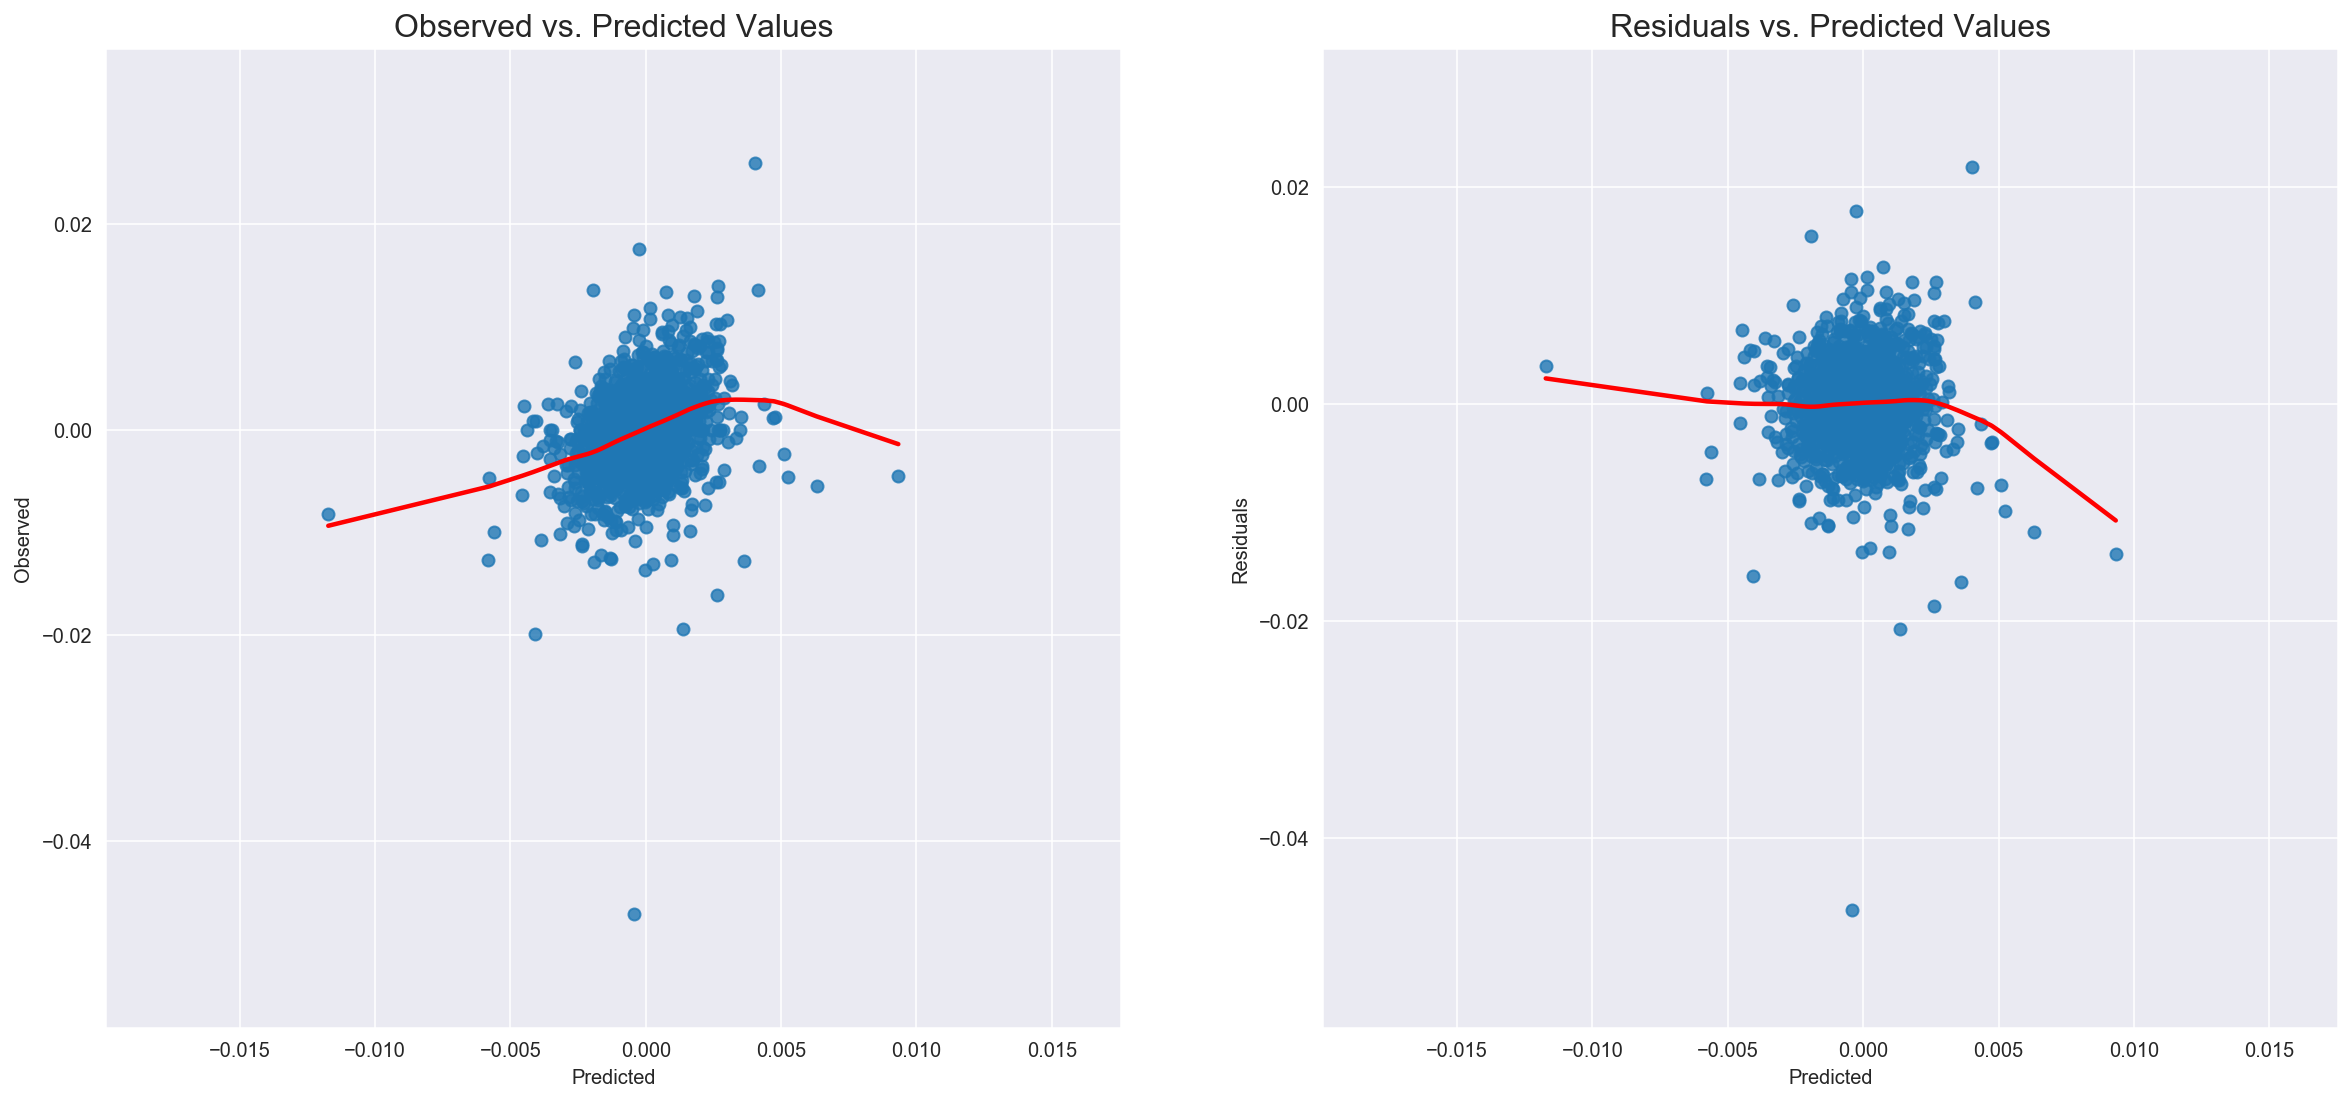

In [57]:
linearity_test(model_daily, y_daily) 

Linearity is roughly satisfied, not perfectly though.

##### Test Strict exogeneity:

mean of residuals =  7.37689717358908e-20


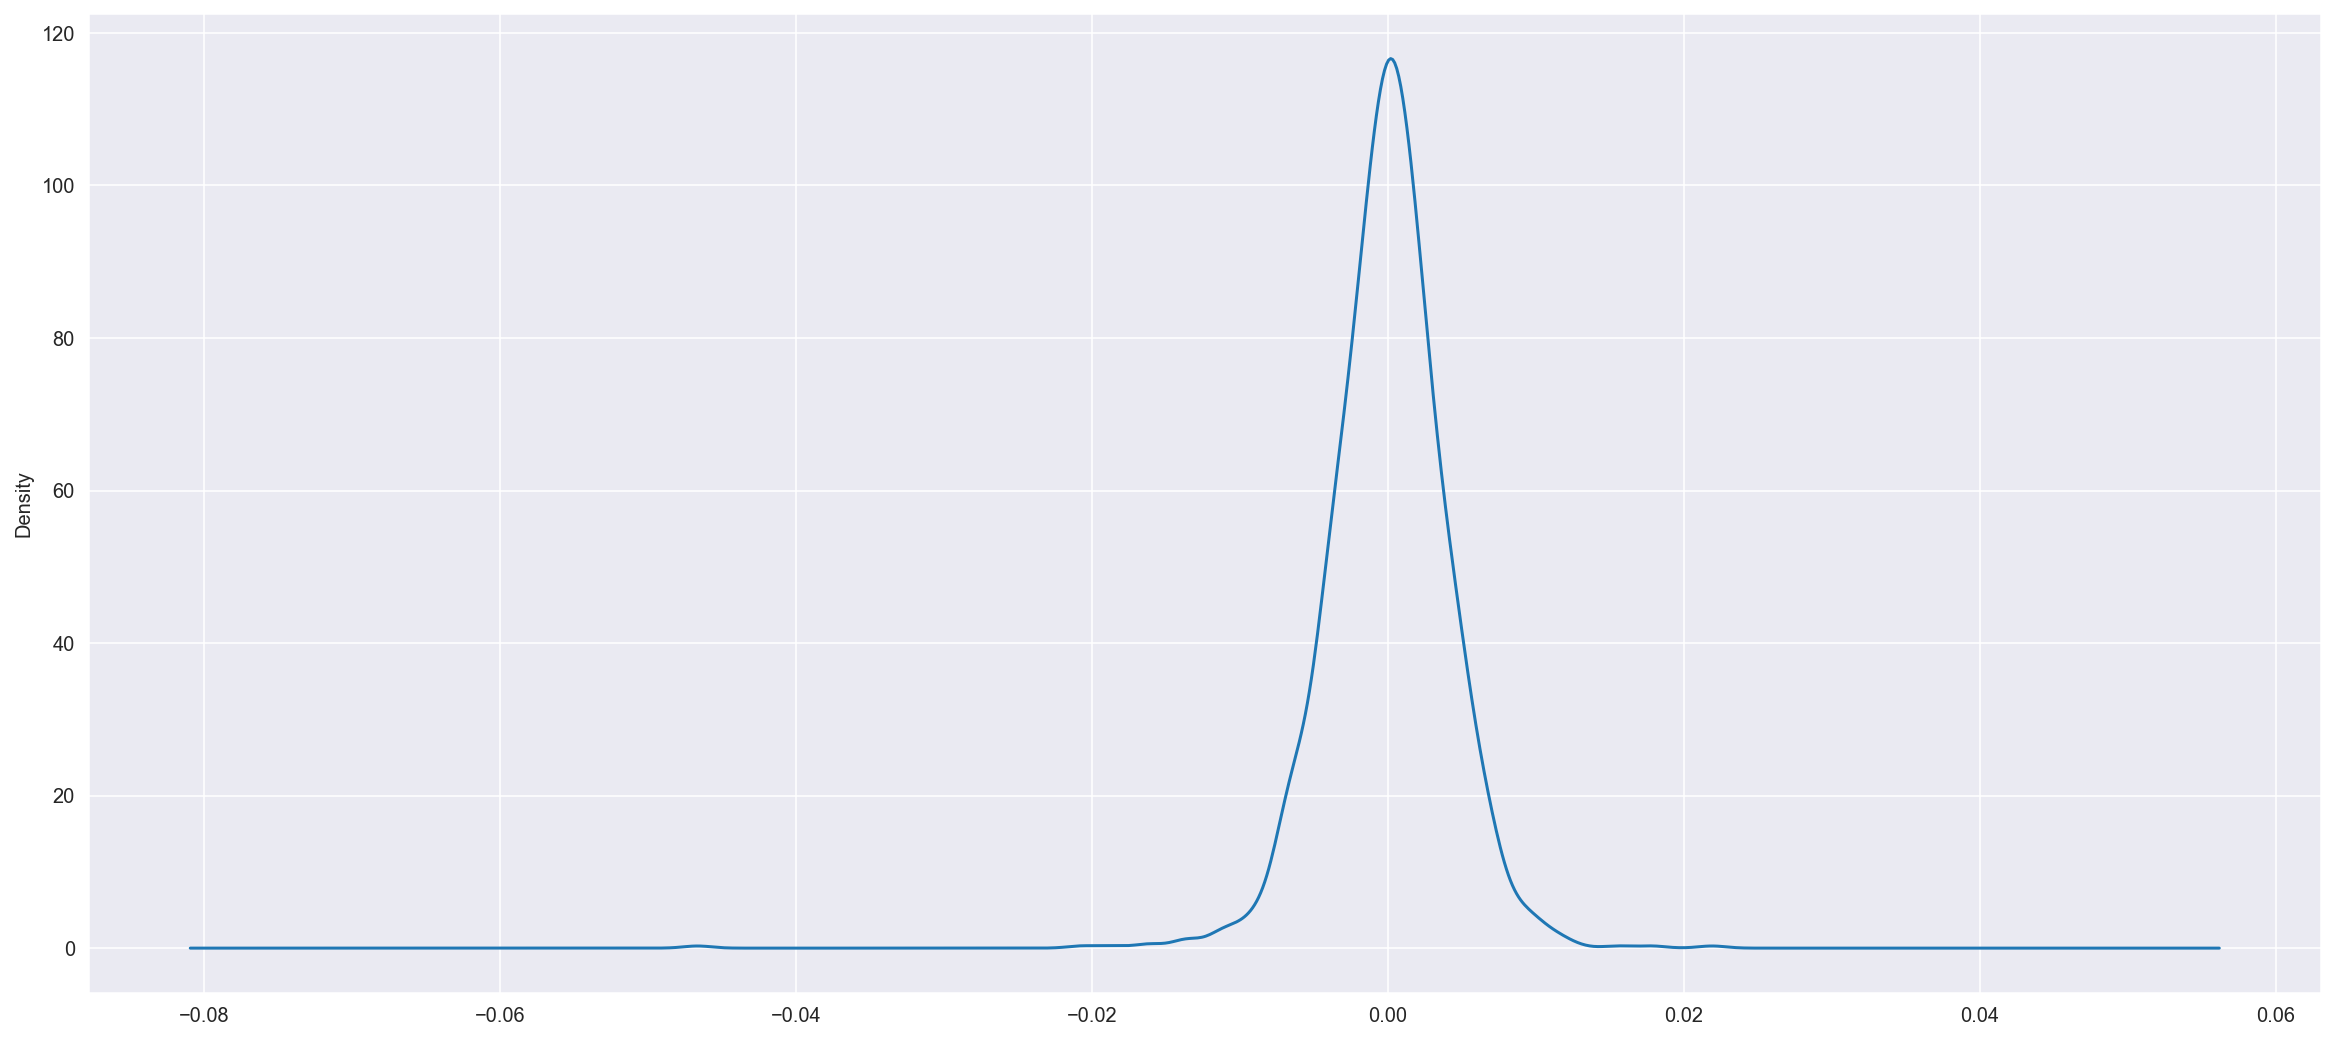

In [58]:
print('mean of residuals = ', FF5resid_daily.mean())
FF5resid_daily.plot(kind='kde')
plt.show()

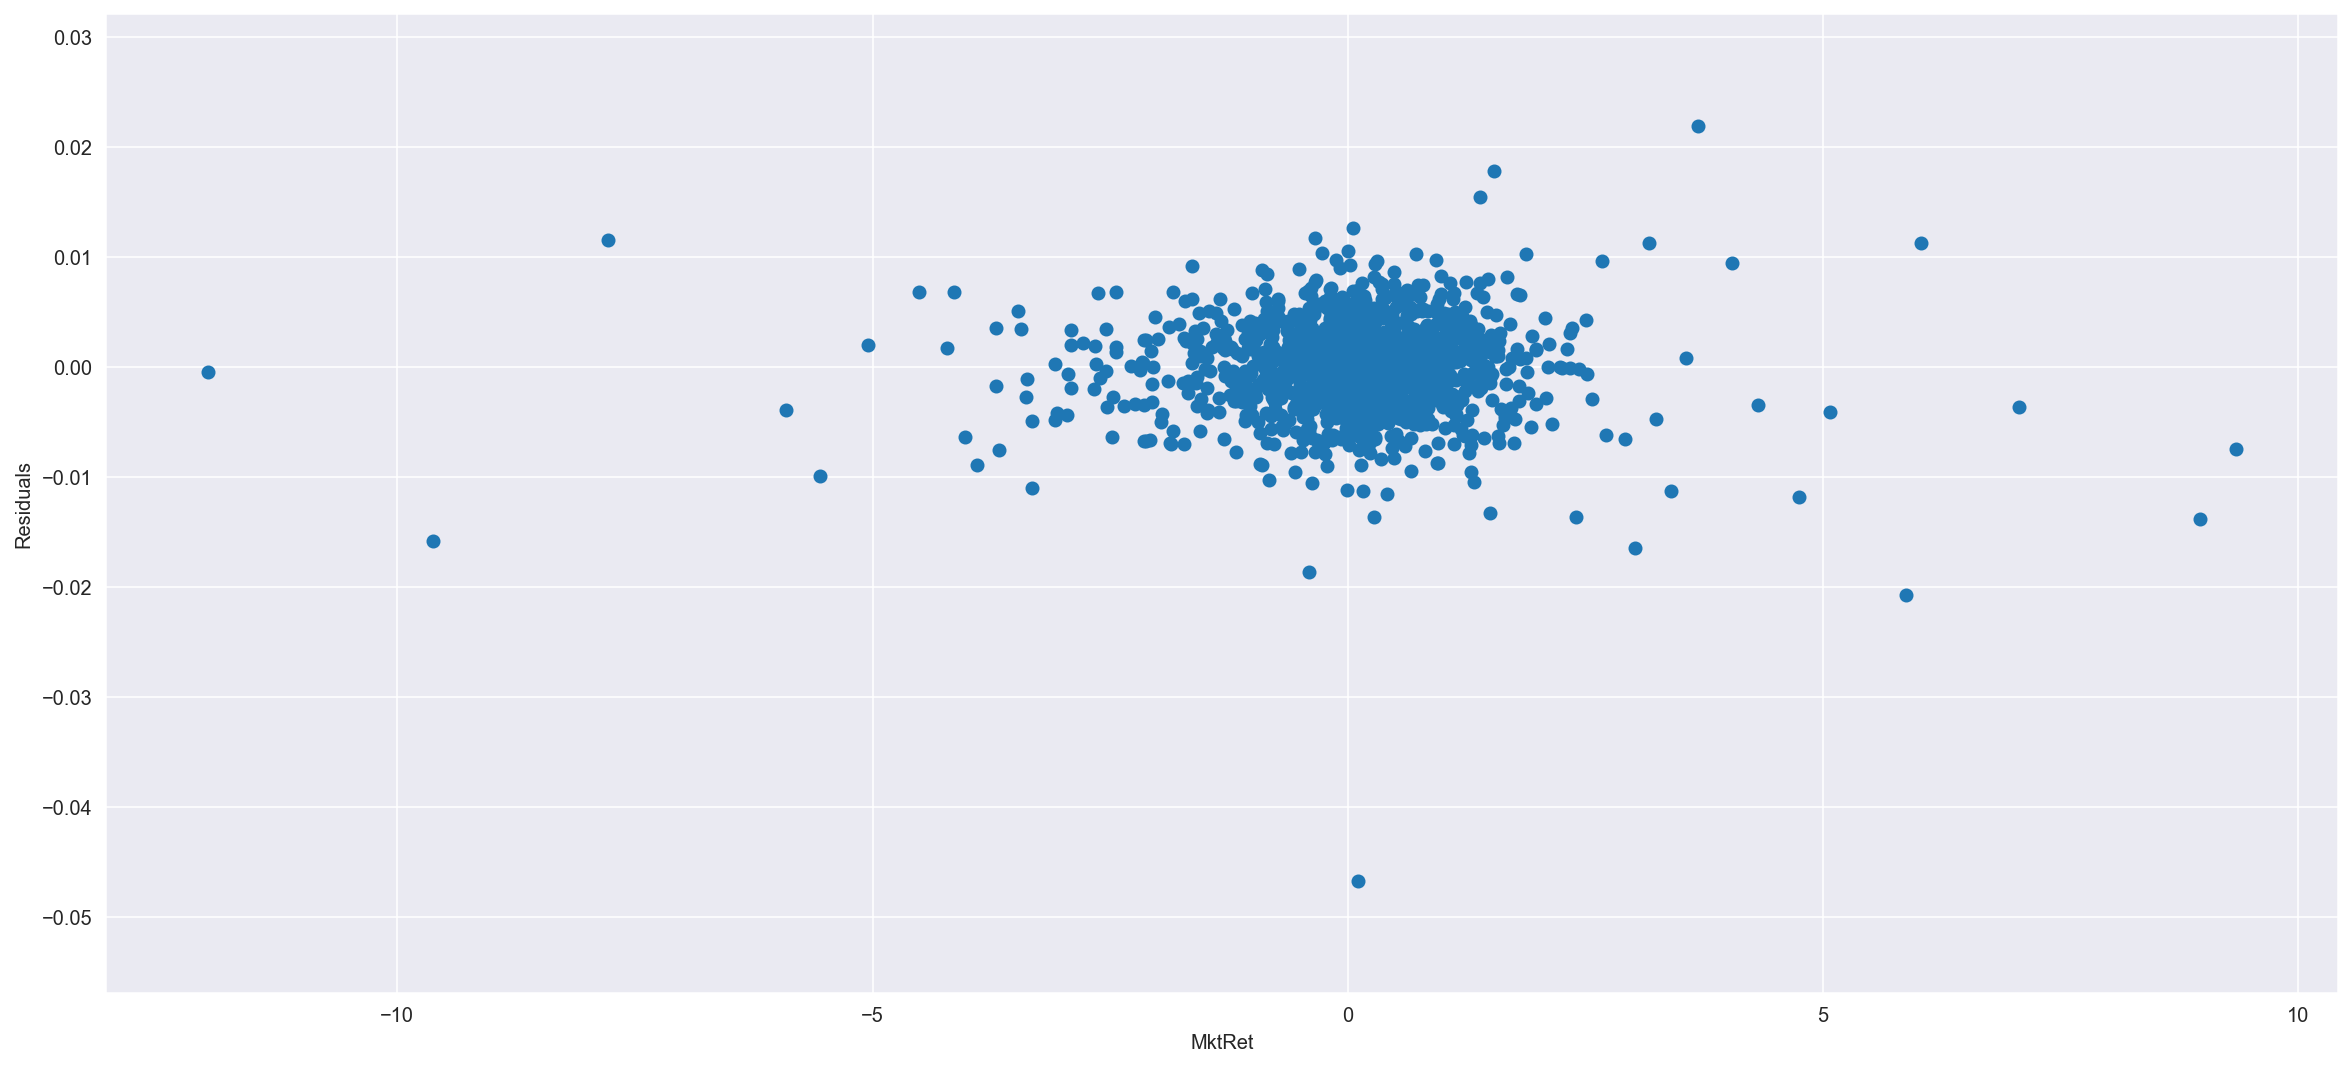

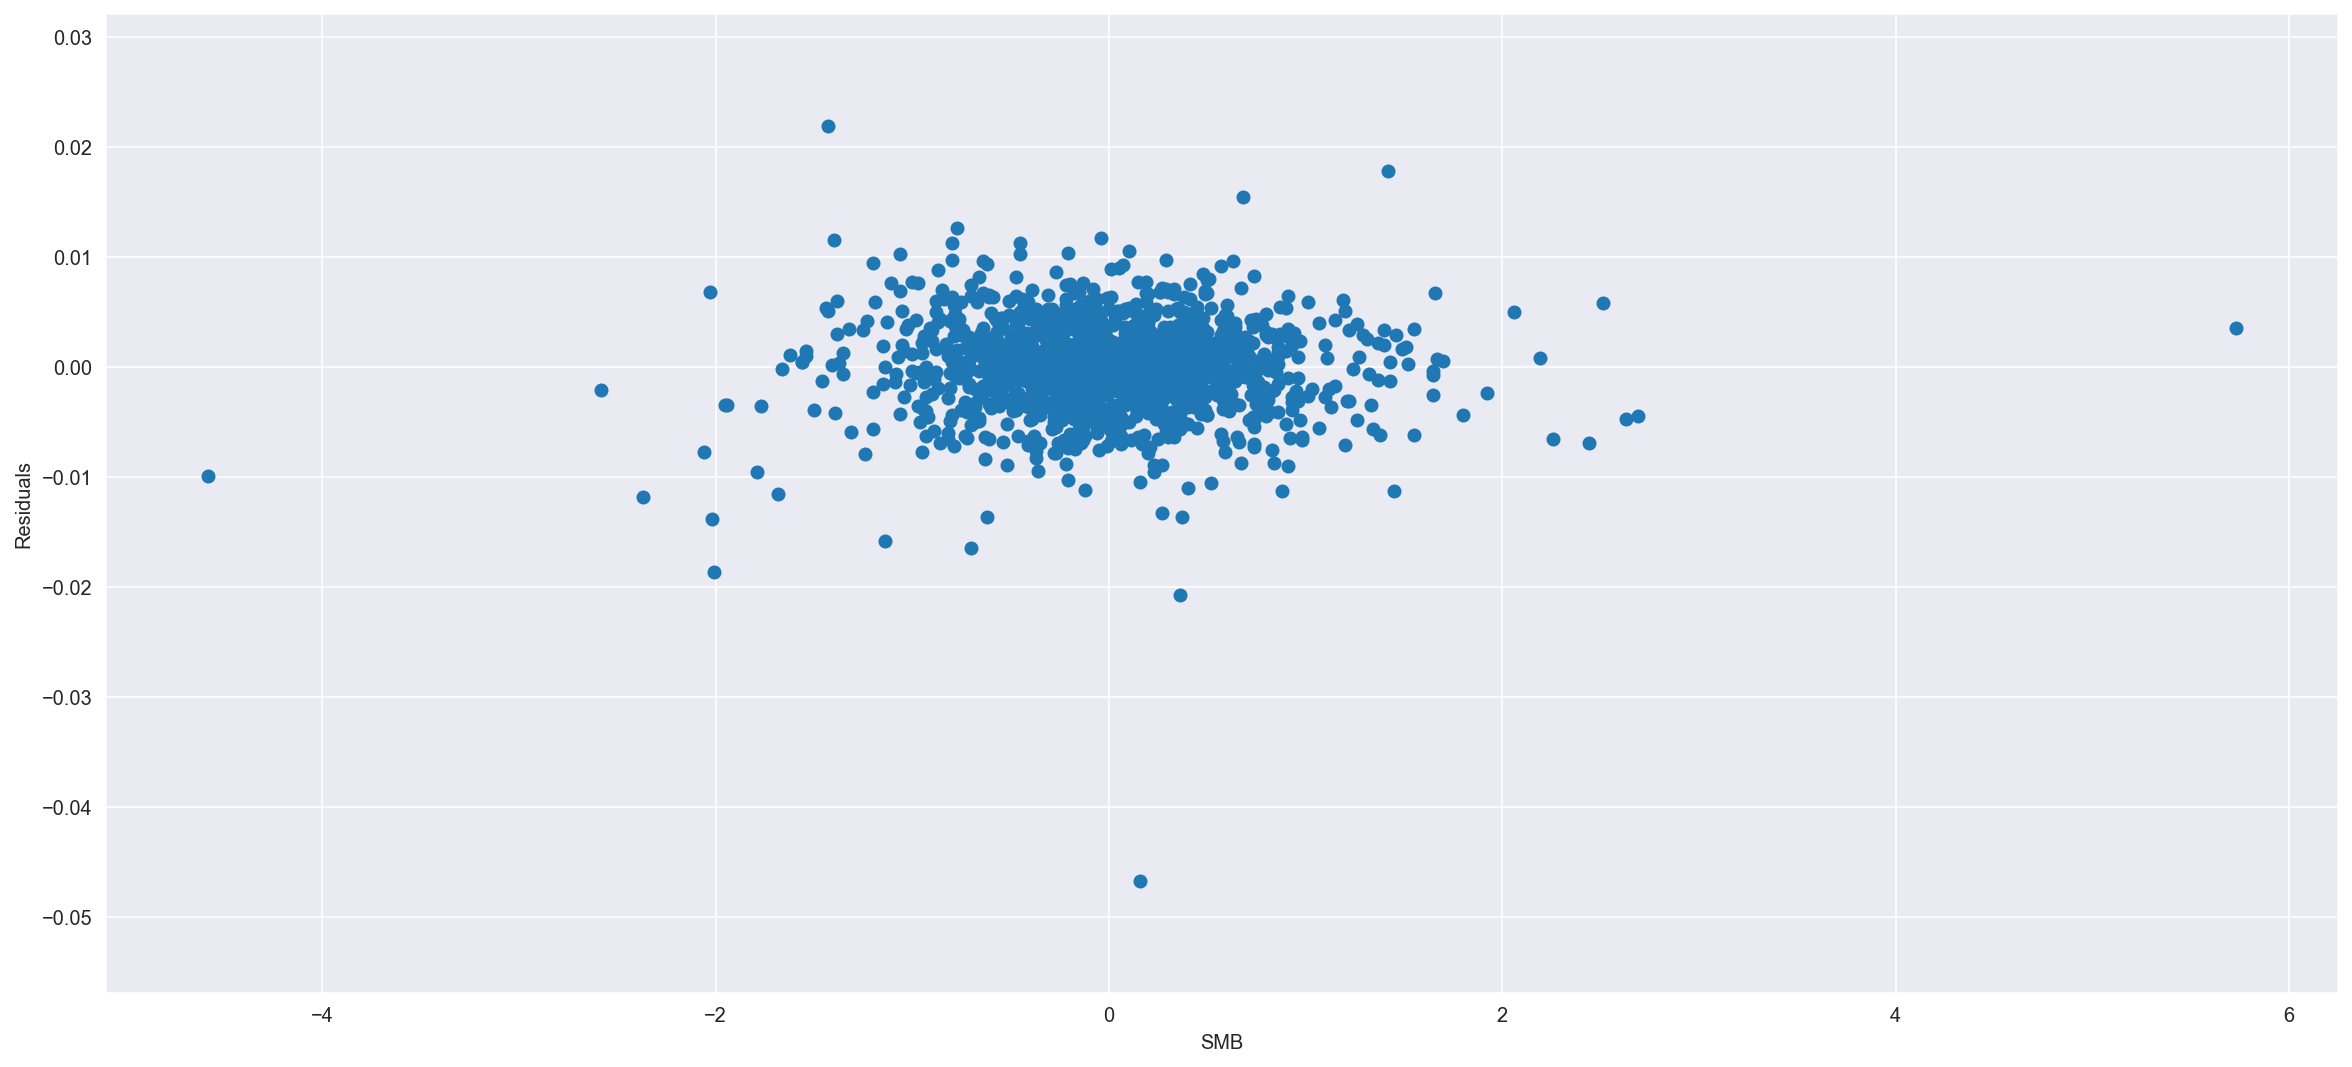

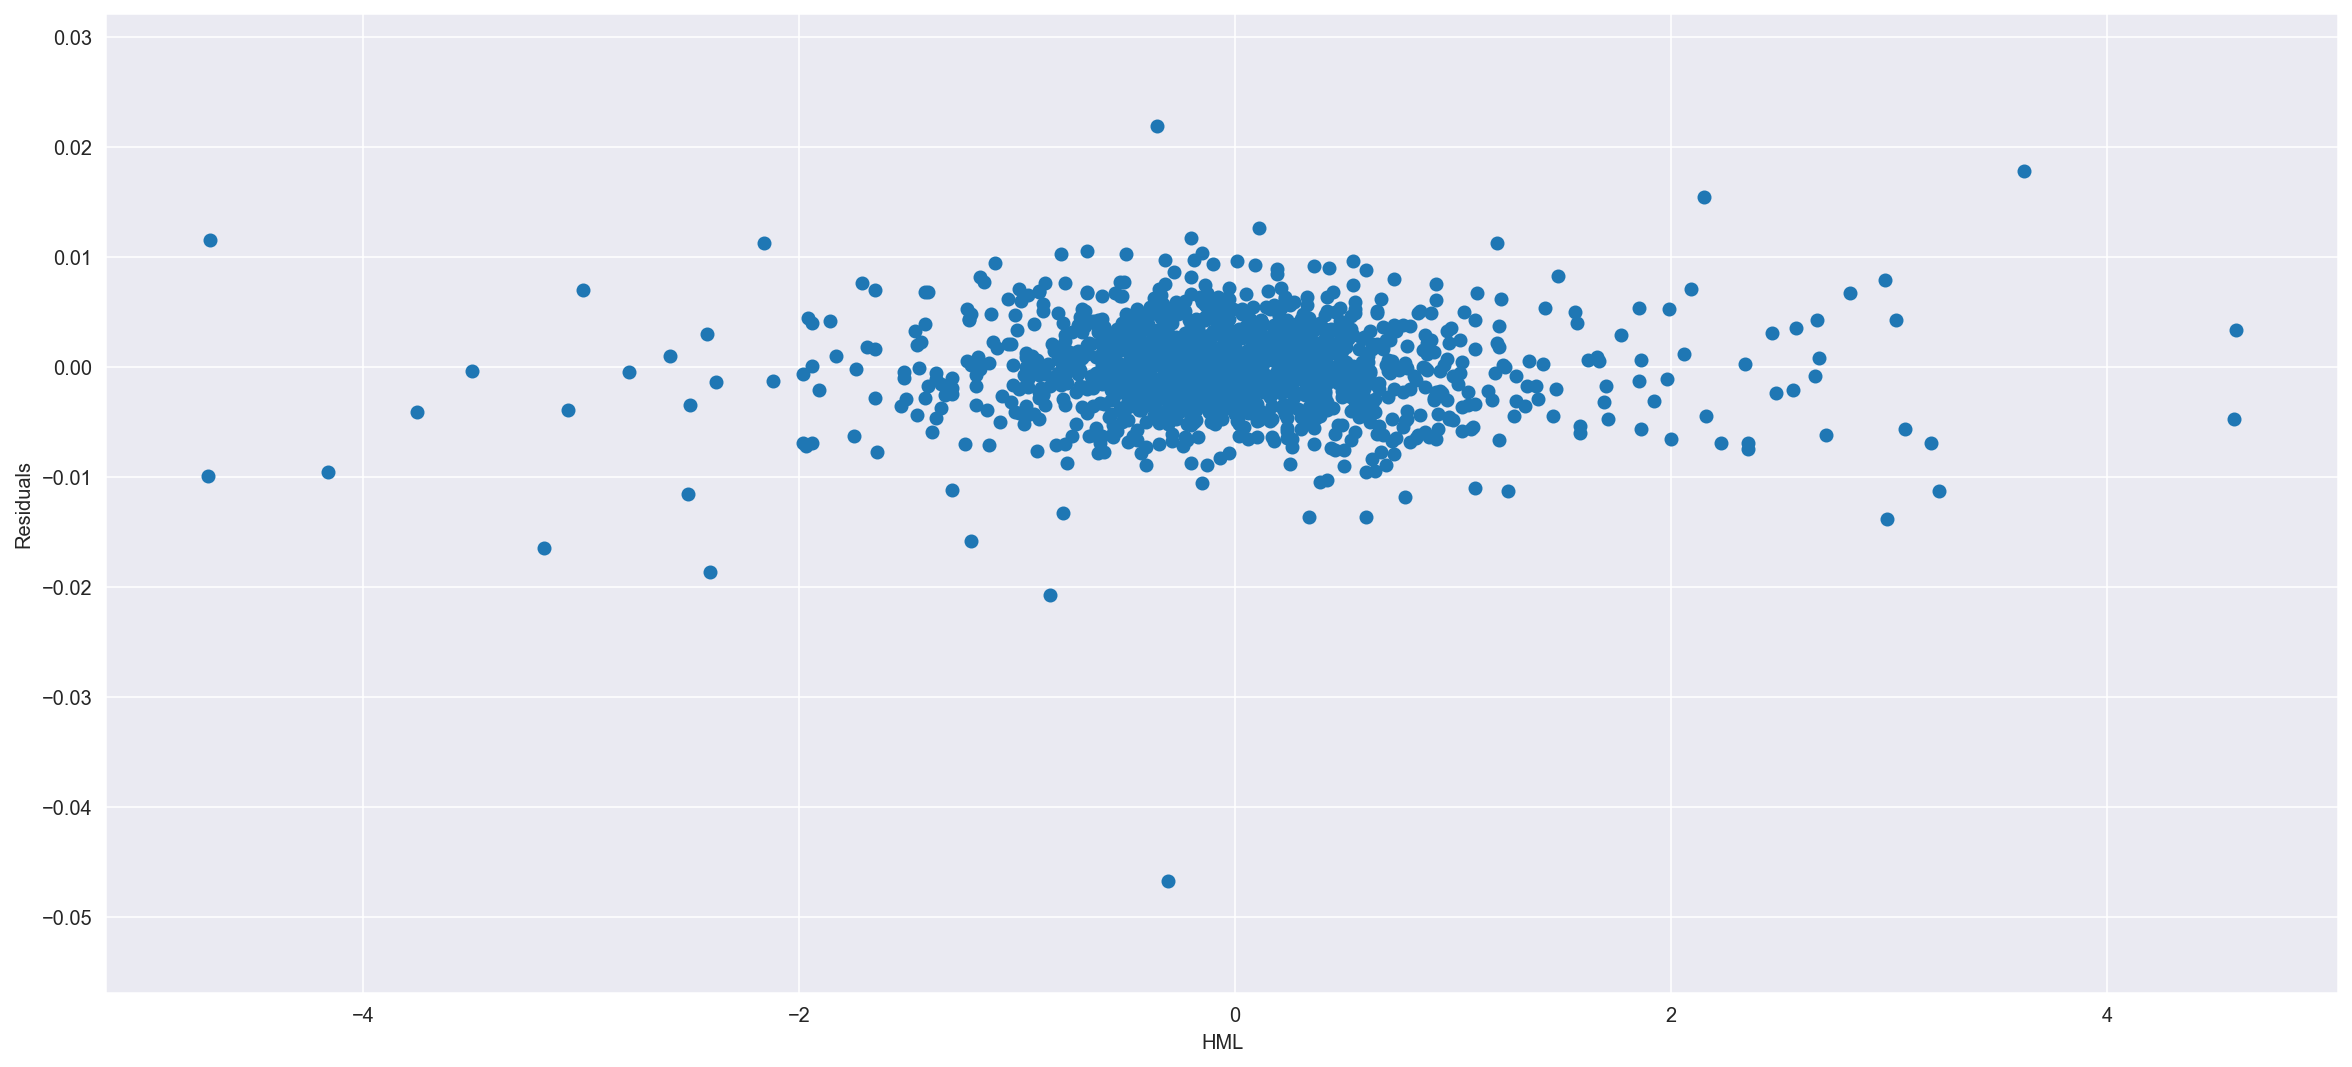

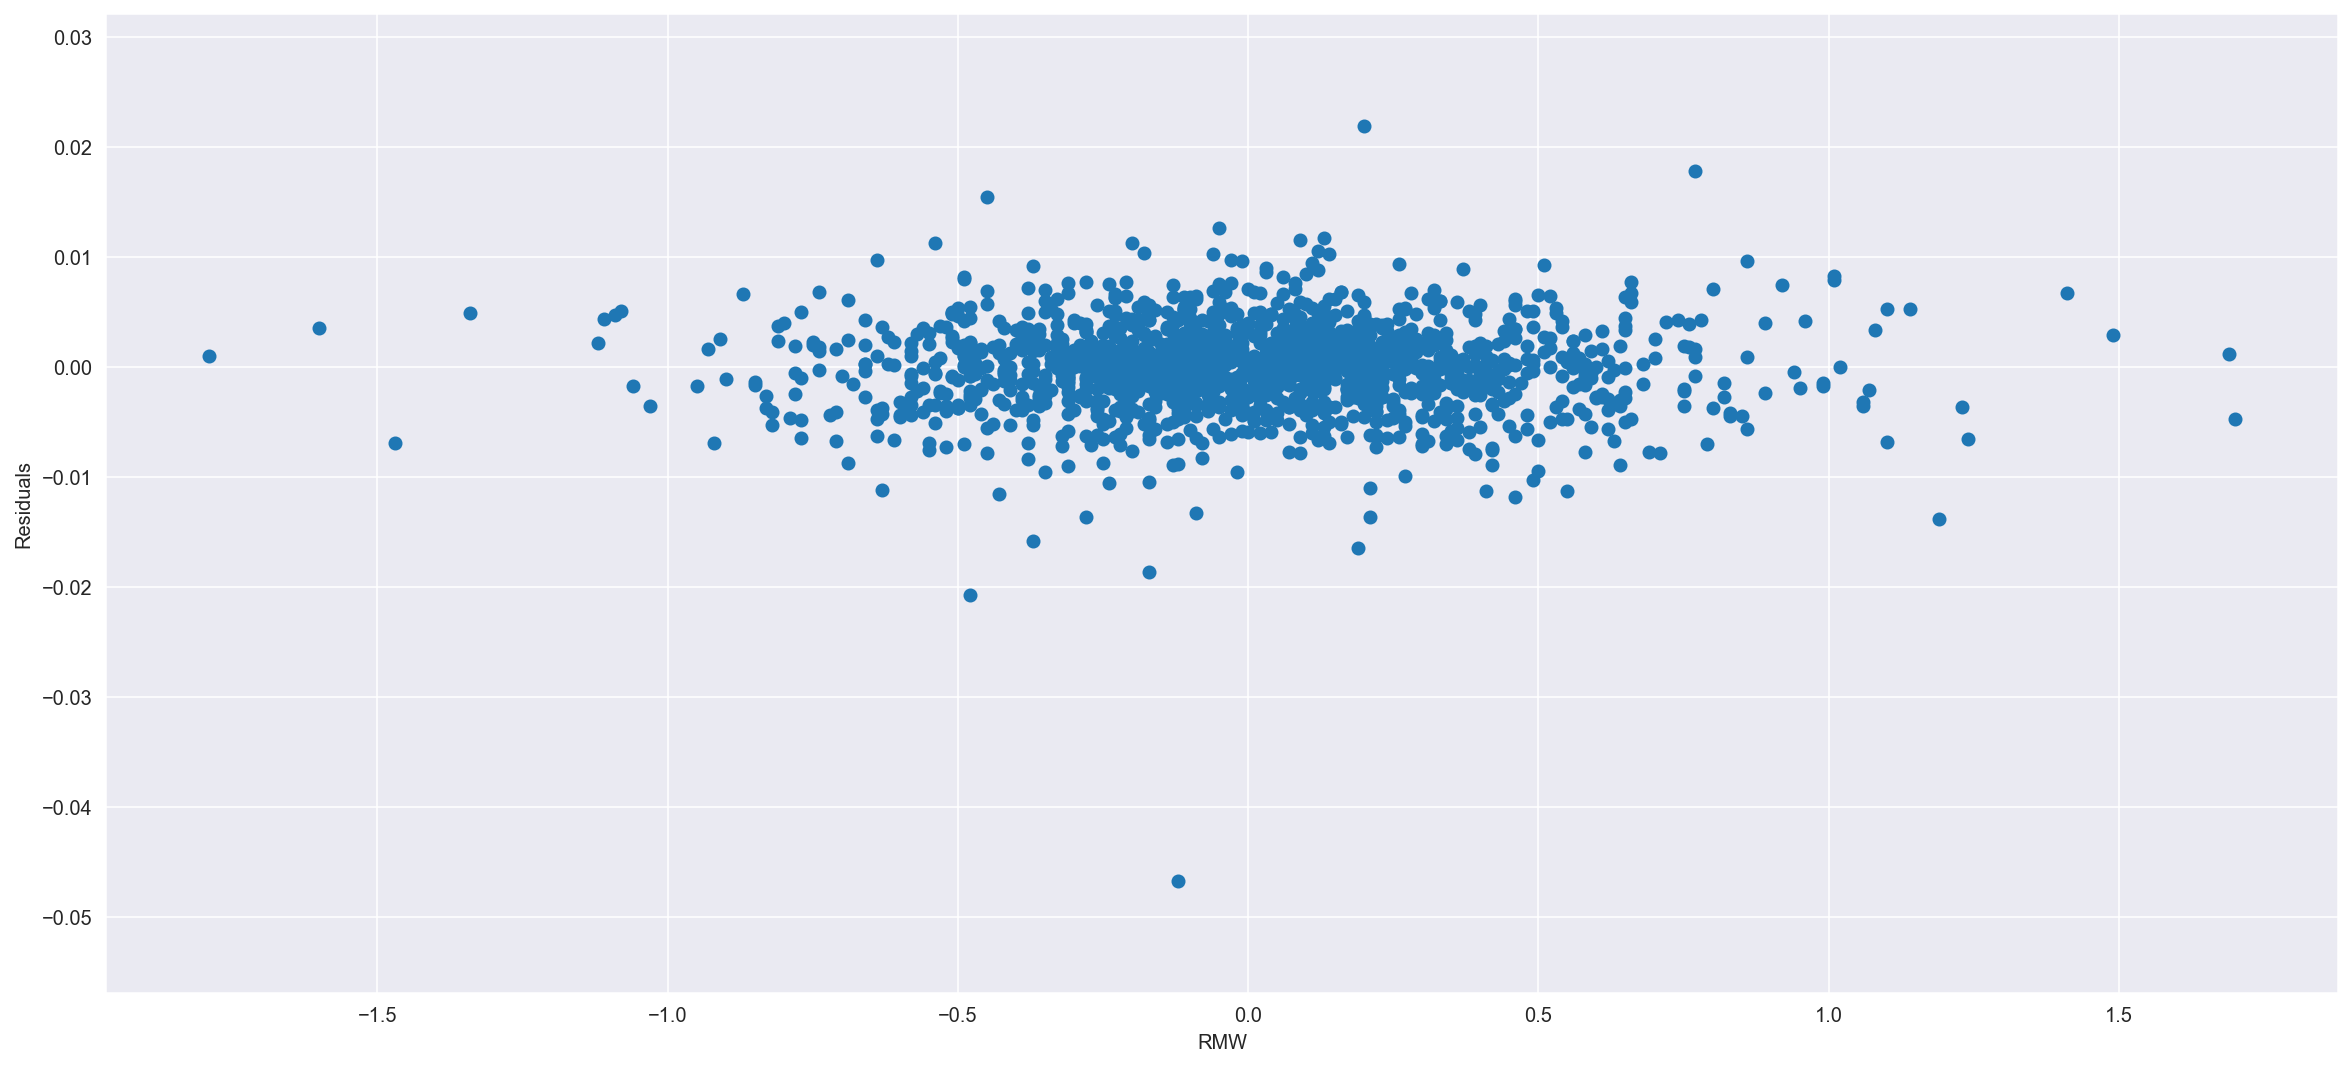

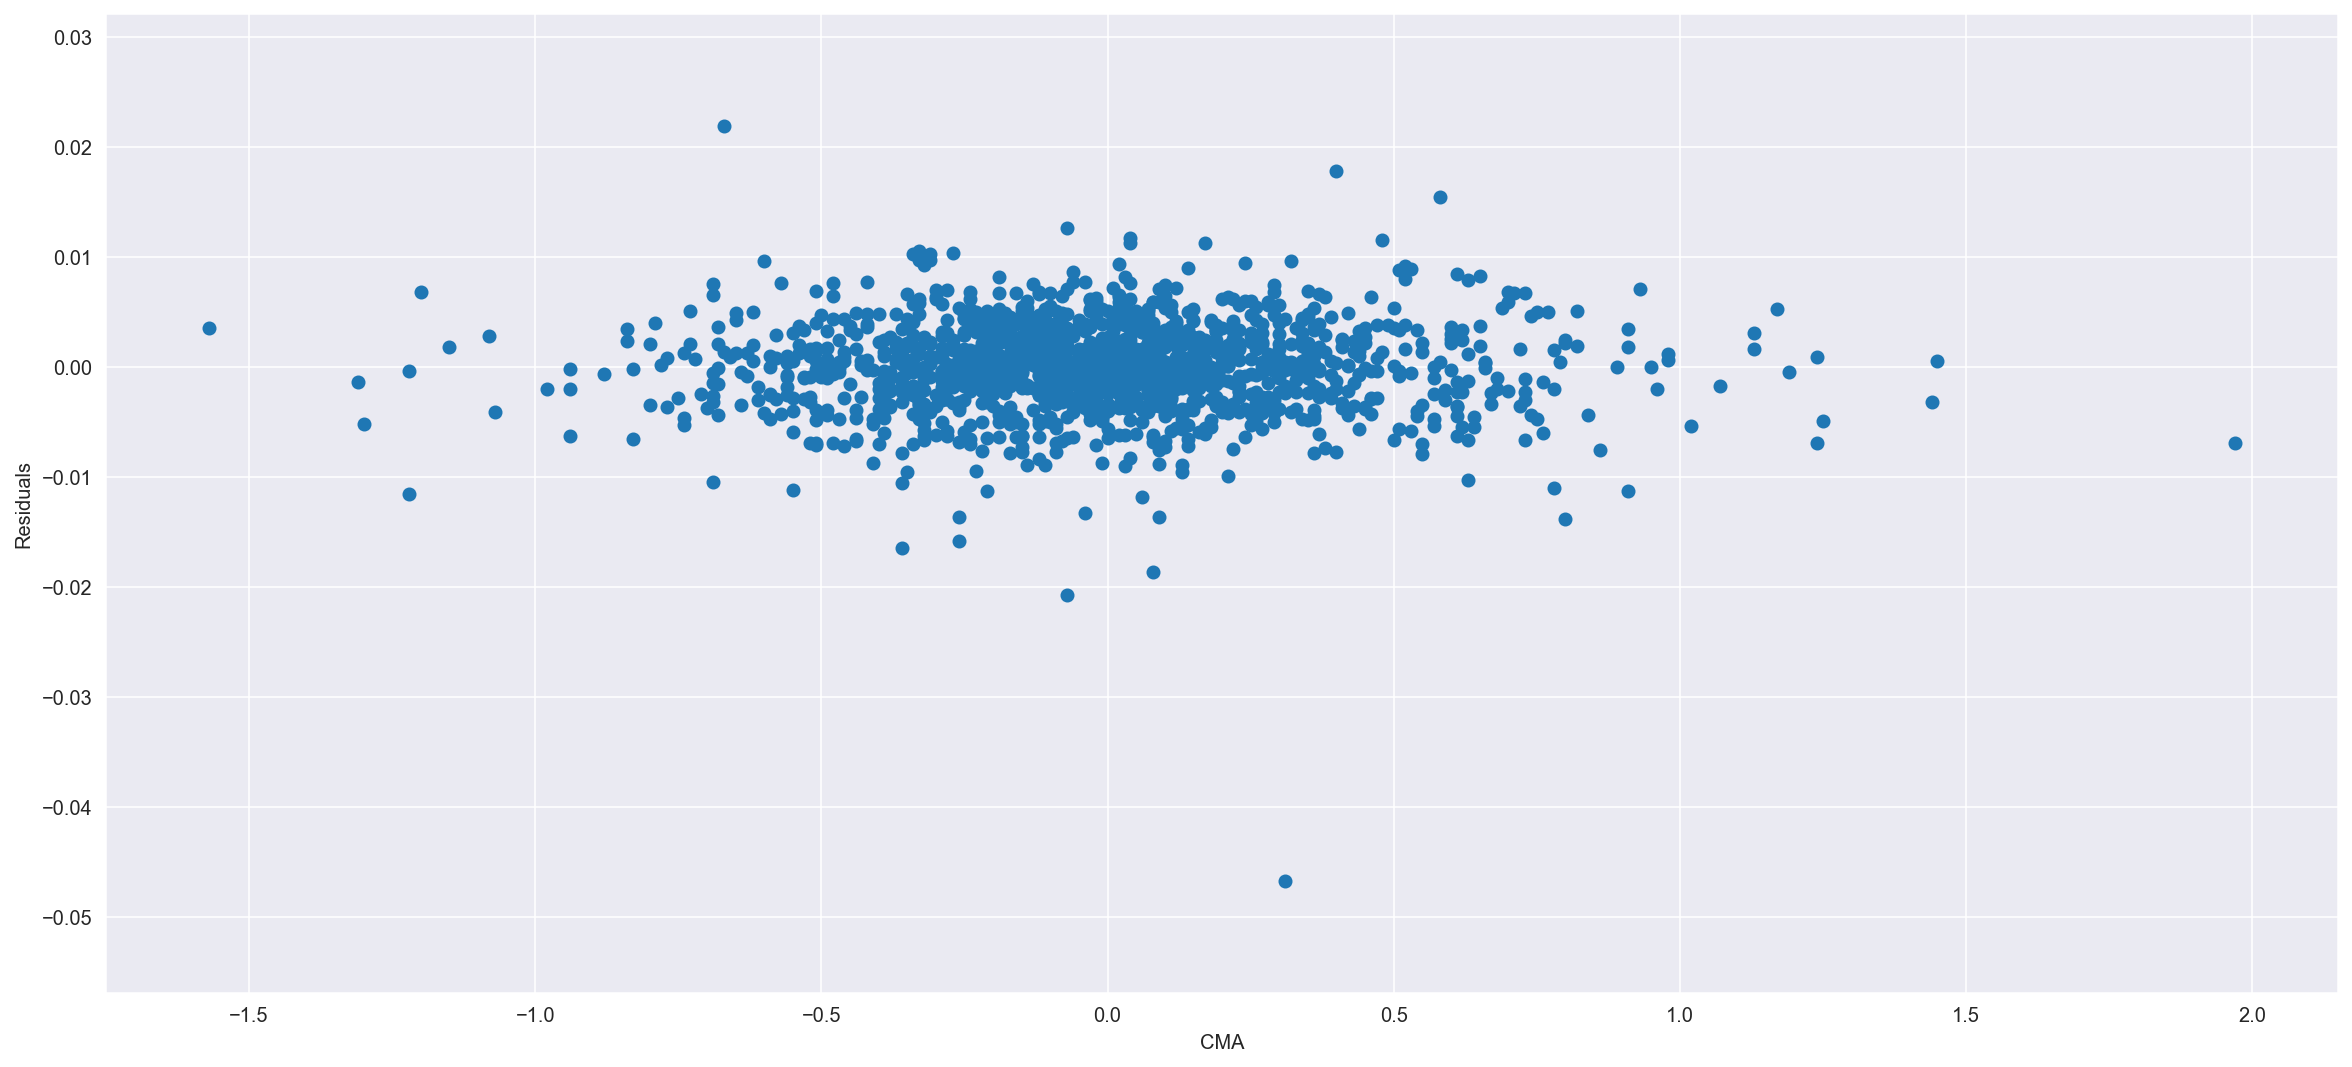

residuals
MktRet    -2.350928e-16
SMB        1.077553e-16
HML        6.248583e-17
RMW       -3.836610e-17
CMA        2.116759e-16
residuals  1.000000e+00

In [60]:
attributes = df_factors_2_daily.columns
for att in attributes:
    plt.scatter(y = FF5resid_daily, x = df_factors_2_daily[att])
    plt.xlabel(att)
    plt.ylabel('Residuals')
    plt.show()
df_daily = df_factors_2_daily.copy()
df_daily['residuals'] = FF5resid_daily
df_daily.corr()[['residuals']]

In [61]:
pearson_corr_test(X_daily, FF5resid_daily)

Variable: MktRet --- correlation: -0.0000, p-value: 1.0000
Variable: SMB --- correlation: 0.0000, p-value: 1.0000
Variable: HML --- correlation: 0.0000, p-value: 1.0000
Variable: RMW --- correlation: -0.0000, p-value: 1.0000
Variable: CMA --- correlation: 0.0000, p-value: 1.0000


Strict exogeneity is satisfied.

##### Test No Multicollinearity:

In [62]:
# bivariate correlation
df_factors_2_daily.corr()

MktRet       SMB       HML       RMW       CMA
MktRet  1.000000  0.166813  0.146682 -0.043089 -0.198232
SMB     0.166813  1.000000  0.305297 -0.115341 -0.010007
HML     0.146682  0.305297  1.000000  0.197197  0.495990
RMW    -0.043089 -0.115341  0.197197  1.000000  0.183269
CMA    -0.198232 -0.010007  0.495990  0.183269  1.000000

In [63]:
VIF_test(X_daily)

MktRet       SMB       HML       RMW       CMA
vif  1.142289  1.186911  1.674508  1.084519  1.517918

No Multicollinearity is satisfied.

##### Test Spherical error variance:

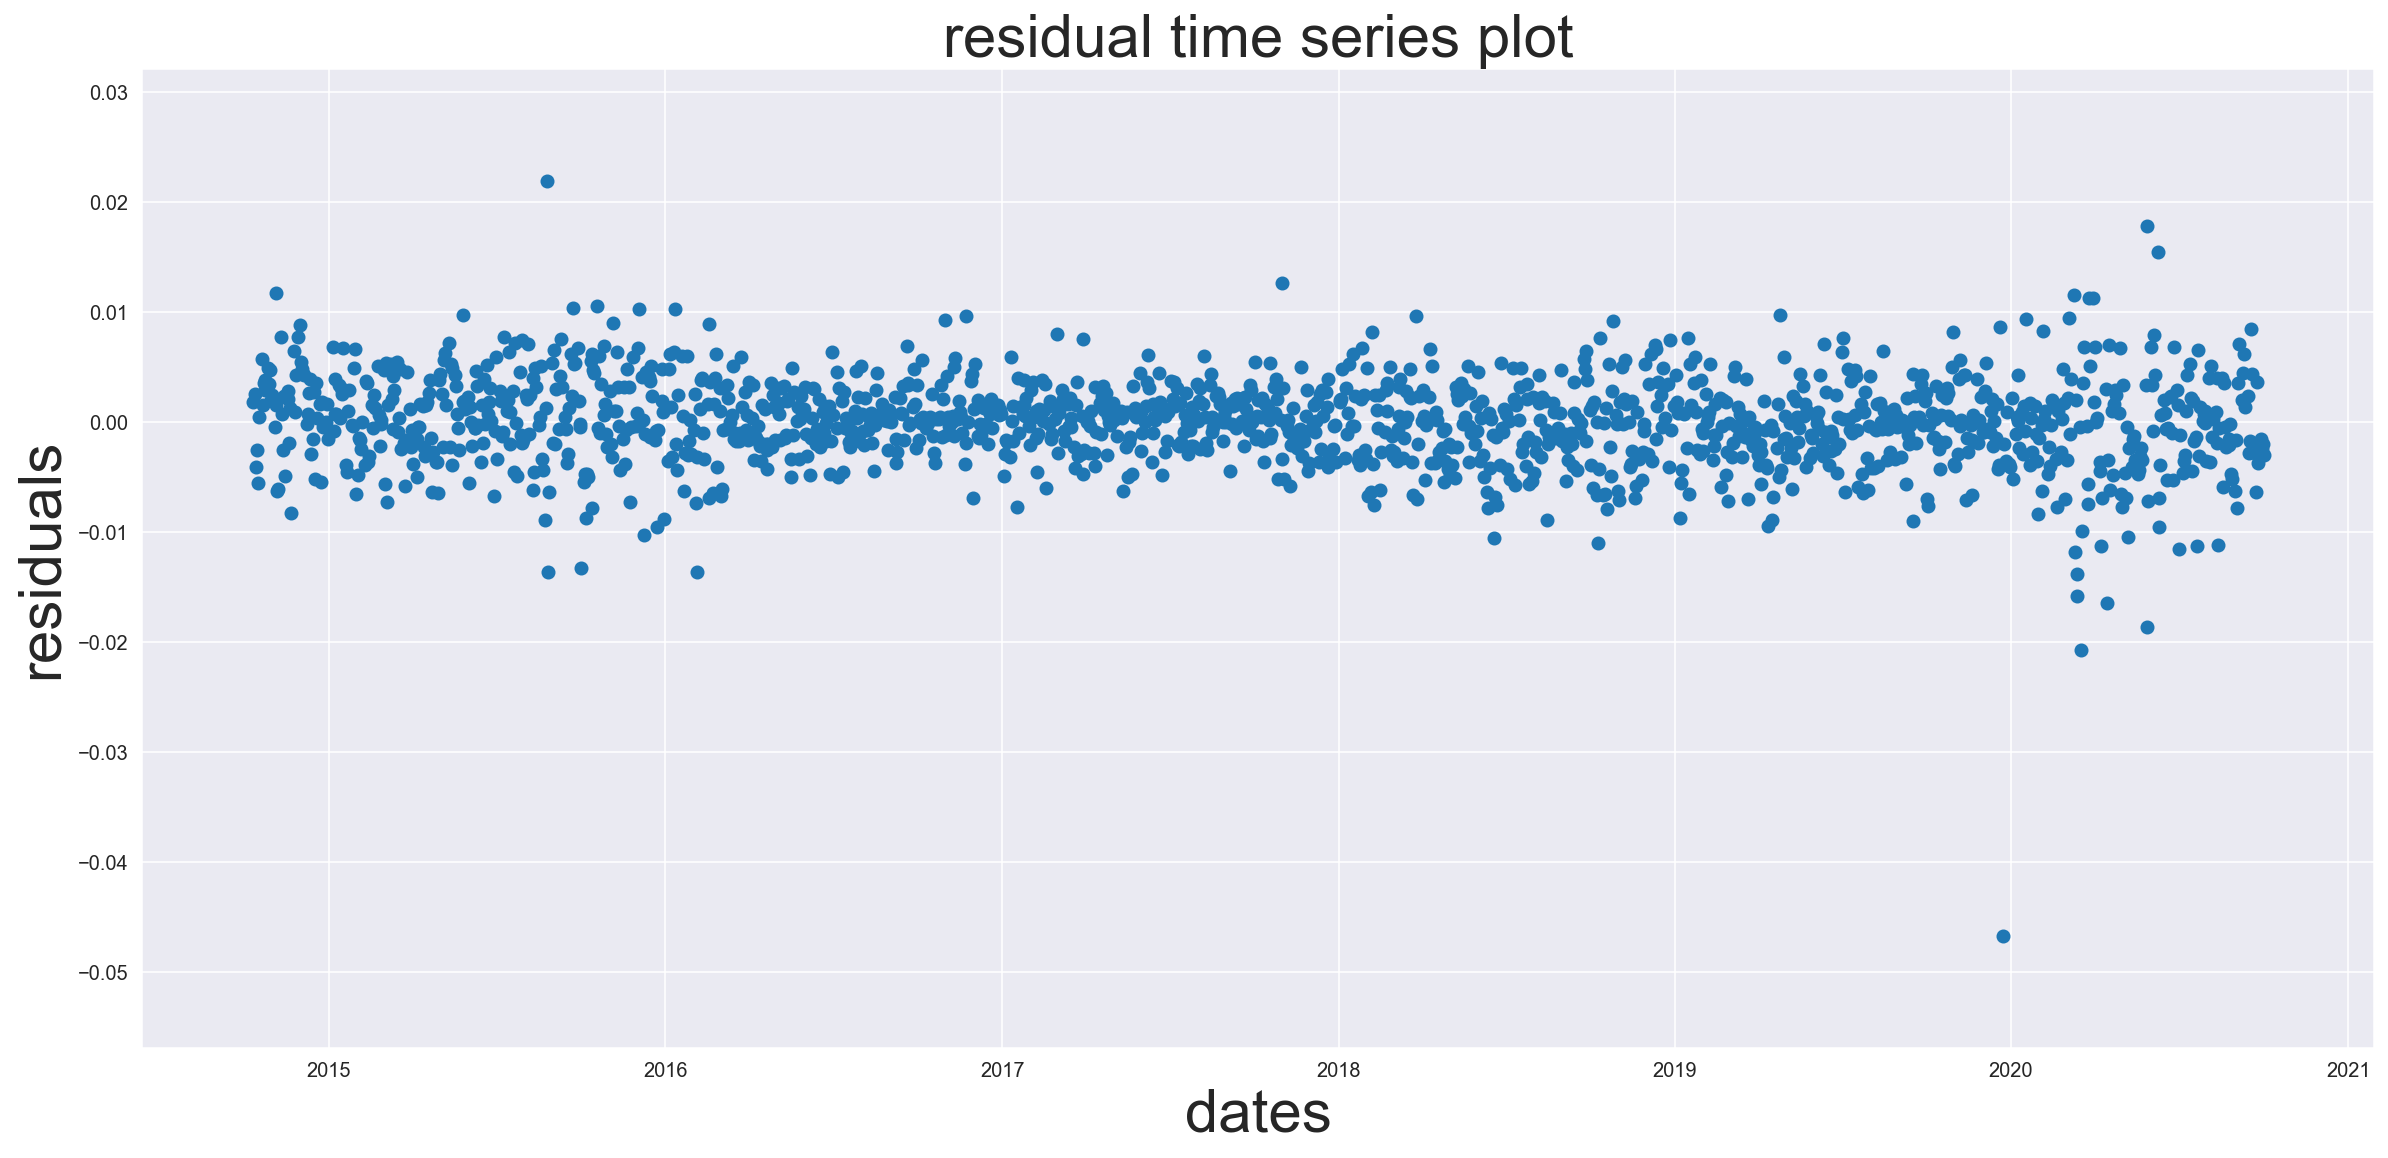

In [64]:
# to see constant variance of error terms
plt.scatter(y = FF5resid_daily, x = df_factors_2_daily.index)
plt.title('residual time series plot', fontsize=30)
plt.ylabel('residuals', fontsize=30)
plt.xlabel('dates', fontsize=30)
plt.show()


 Breusch-Pagan test ----
                                   value
Lagrange multiplier statistic  13.791440
p-value                         0.016990
f-value                         2.772700
f p-value                       0.016838
Reject Null, conclude heteroscedasticity

 Goldfeld-Quandt test ----
                    value
F statistic  1.625942e+00
p-value      1.969088e-11
Reject Null, conclude heteroscedasticity

 Residuals plots ----


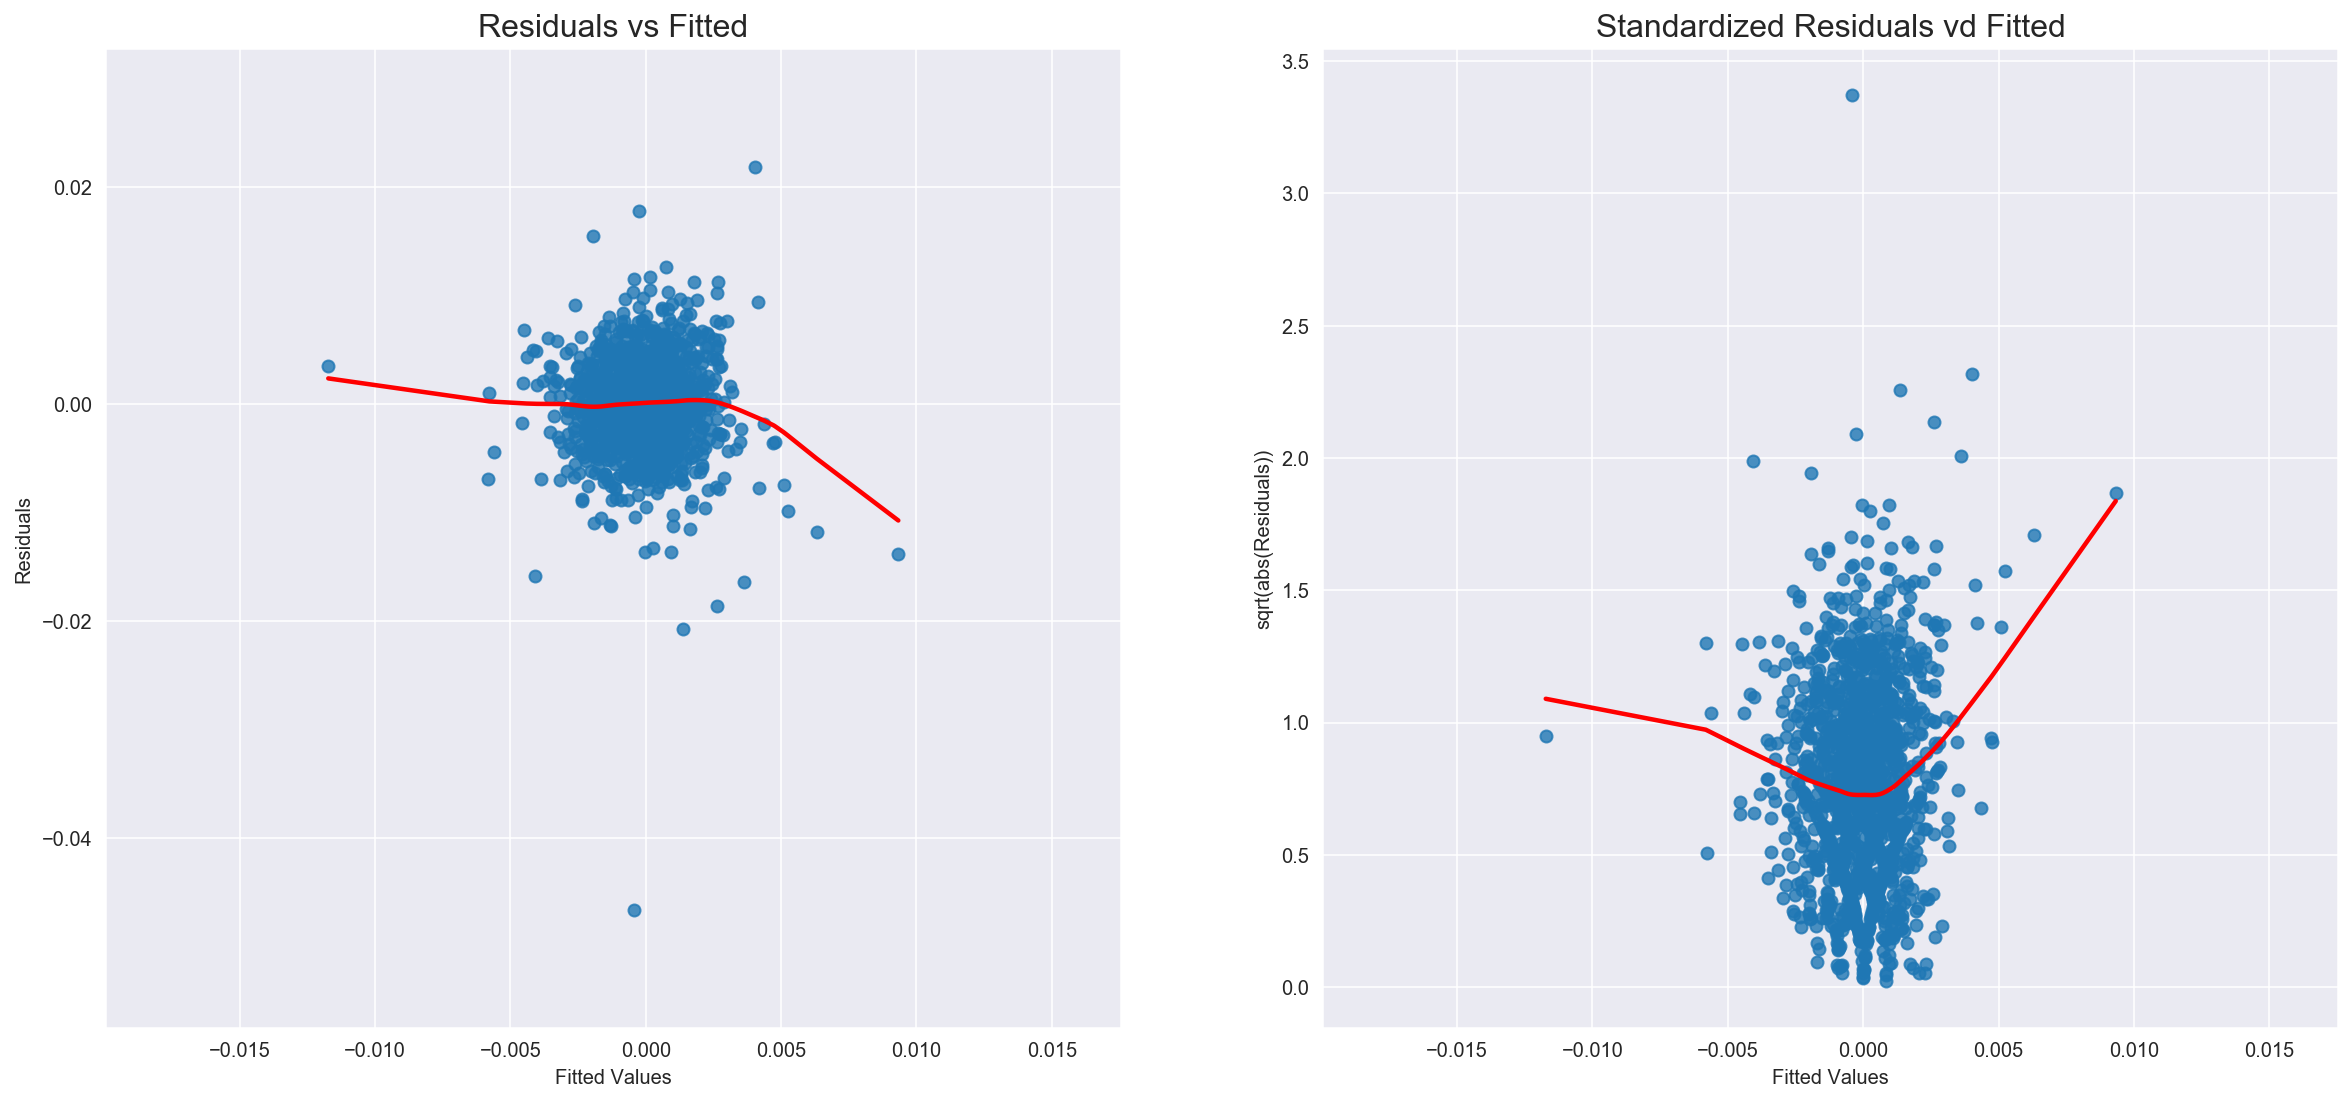

In [65]:
homoscedasticity_test(model_daily)

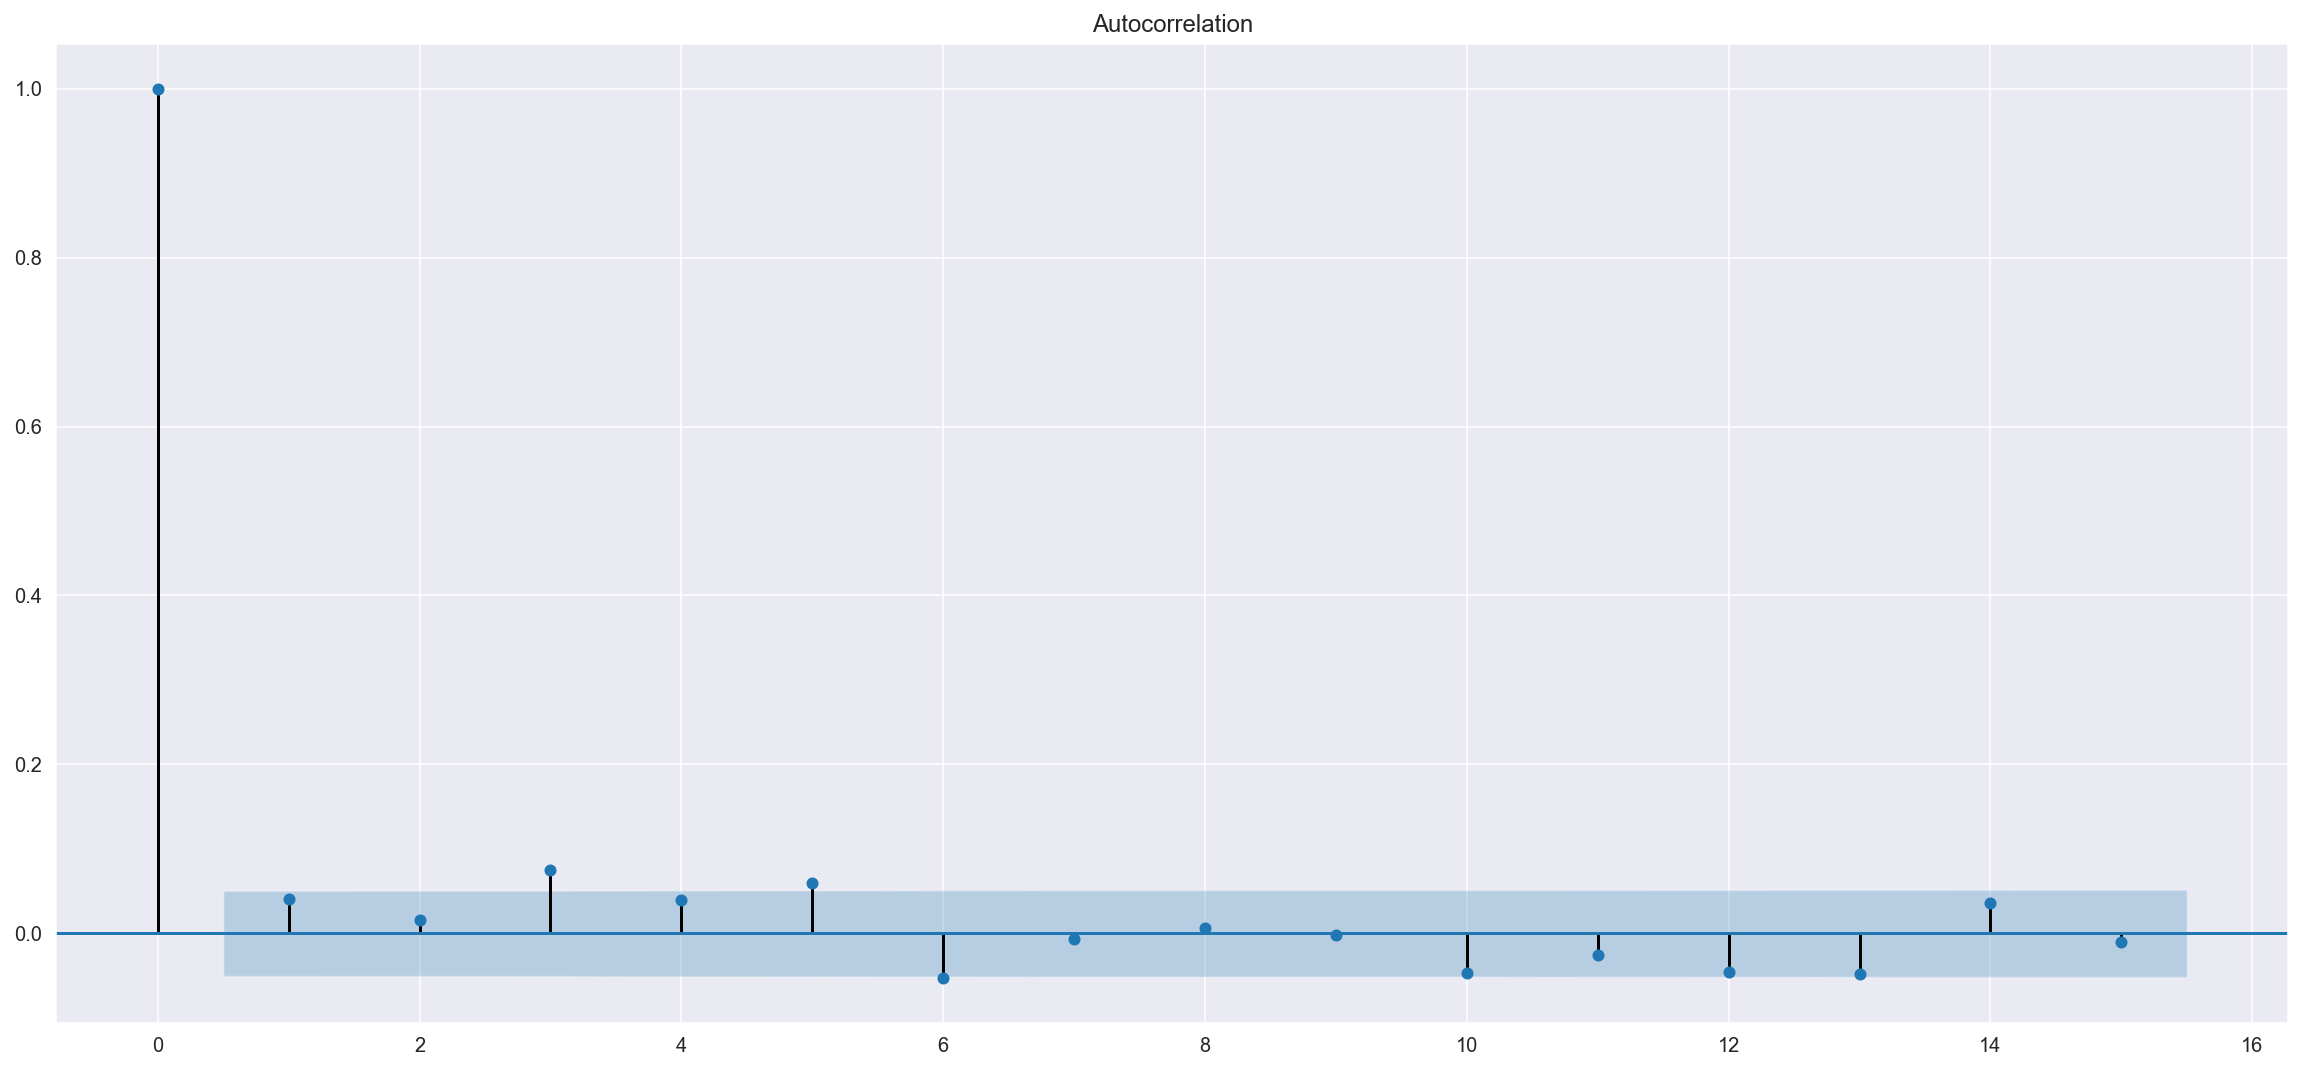

In [66]:
# check autocorrelation of error terms
plot_acf(FF5resid_daily, lags = 15)
plt.show()

Spherical error variance is satisfied.

##### Test Normality:

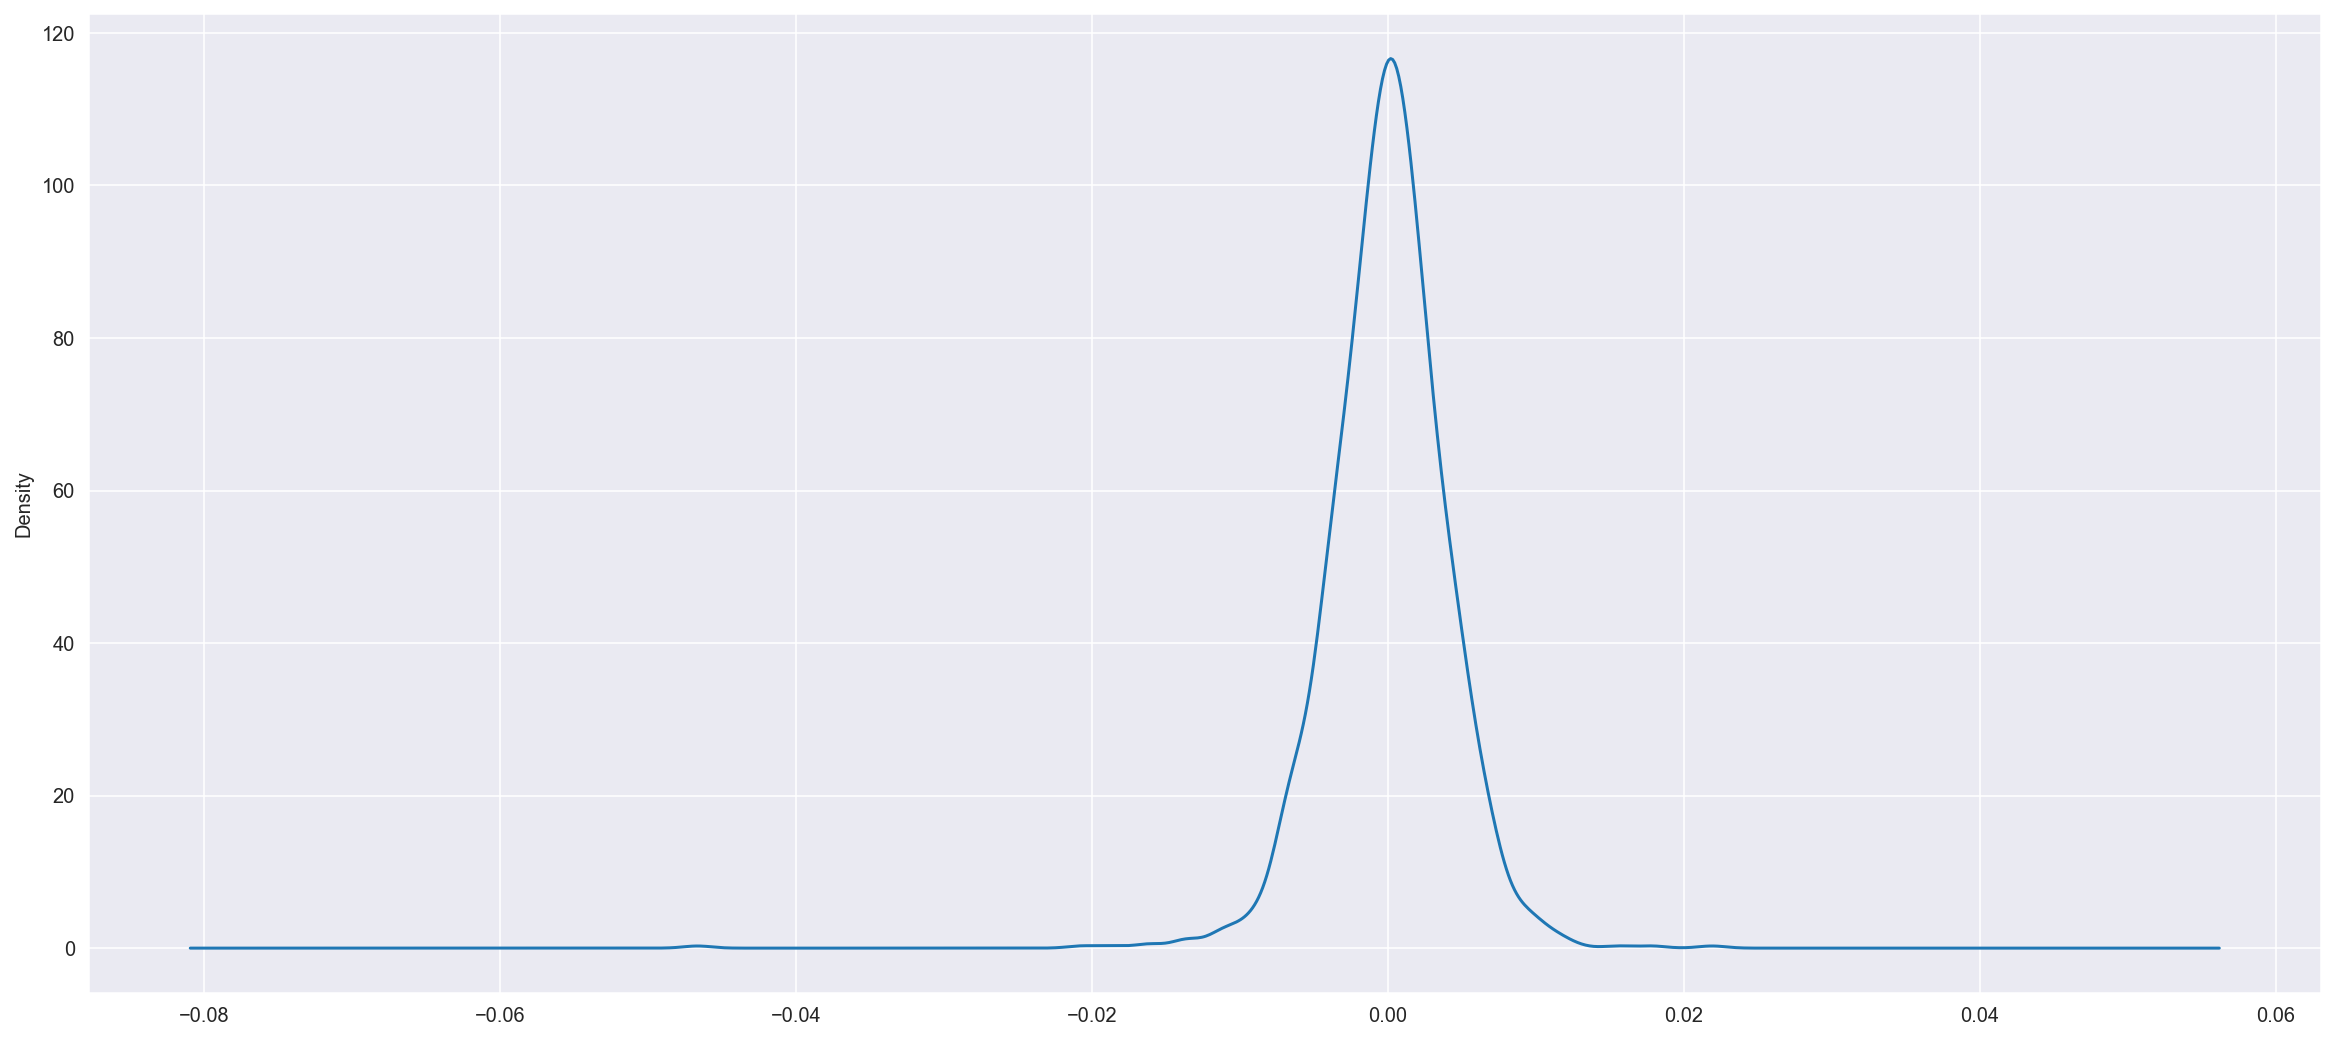

In [67]:
# FF5resid_daily.hist()
FF5resid_daily.plot(kind='kde')
plt.show()

Normality is satisfied.

#### Explanation:

Classic OLS assumptions are much more satisfied with Daily data than Monthly data. Also, the 5-factor model works better with daily data than monthly data. This is mainly because we have an enough sample size from daily scenario. Monthly data does not contain much valuable information. 

According to estimated coefs, we can tell ``RMW`` is the most significant factors (positively) influencing AQR daily return, and then the `MktRet` also with positive influence on AQR return.

``RMW``:

**RMW (Robust Minus Weak)** is the average return on the two robust operating profitability portfolios minus the average return on the two weak operating profitability portfolios using the measure of ROE ratio.

Guess: as long as we see an increase in ``RMW`` or ``MktRet``, we might can expect an increase in AQR daily return. But definitely we need a more robust model that also explain the return variaions very well (high R2).

## Q2: Linear regression models for the housing dataset.
In this question you will be extending the Jupyter notebook ``lec04_skl_ols_workflow_housing_data.ipynb`` used during the last lecture:

In [69]:
############### Code from Lecture ###################################
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path = os.path.join(housing_path, "housing.tgz")
    if not os.path.isfile(tgz_path): #download data if not already there
        urllib.request.urlretrieve(housing_url, tgz_path)
        
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
fetch_housing_data()
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()
# to make this notebook's output identical at every run
np.random.seed(42)
from sklearn.model_selection import train_test_split

# this correspond to random of the data
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
housing = strat_train_set.copy() 
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)
# rooms per household might be more meaningful 
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]

# likewise bedrooms per room
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]

# or population per household
housing["population_per_household"]=housing["population"]/housing["households"]
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


# ML
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows.dropna(subset=["total_bedrooms"])
sample_incomplete_rows.drop("total_bedrooms", axis=1)
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)

# Fortunately sklearn has an Imputer class that does all this too
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))
#print(housing_tr.loc[sample_incomplete_rows.index.values])
#print(imputer.strategy)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)


from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories='auto')
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot #note that the output is a sparse matrix
housing_cat_1hot.toarray()

# Let's create our own transformer which transformes all our numerical variables
# Note that the BaseEstimator is the abstract class we need to always inherit from. 
# The TransformerMixin class basically adds the fit_transform() method once the fit() 
# and transform() methods are implemented
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])


# One nice thing about Transformers is they can be pipelined. 
# A Pipeline is a transformer whose transform() method calls teh transform() 
# methods of each component:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()), # a stransformer which scales the variables 
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# LabelBinarizer is same as OneHotEncoder but fit_transform() equivalent to fit_transform().to_array() of OneHotEncoder
# unfortunately LabelBinarizer isn't pipeline friendly so we'll have to extend it as below:
from sklearn.preprocessing import LabelBinarizer 
class PipelineFriendlyLabelBinarizer(LabelBinarizer):
    def fit_transform(self, X, y=None):
        return super(PipelineFriendlyLabelBinarizer, self).fit_transform(X)
    
ppflb = PipelineFriendlyLabelBinarizer()
housing_cat_1hot_lb = ppflb.fit_transform(housing_cat_encoded.reshape(-1,1))

# let's now combine the numerical and categorical pipelines
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', PipelineFriendlyLabelBinarizer()),
    ])
# and concatenate them with FeatureUnion class
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
# this is the final transformation result!
housing_prepared = full_pipeline.fit_transform(housing)

# Select and train an OLS model 
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
# let's try the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

#print("Predictions:", lin_reg.predict(some_data_prepared))

from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

from sklearn.metrics import mean_absolute_error
lin_mae = mean_absolute_error(housing_labels, housing_predictions)


In [70]:
#housing

In [71]:
#housing_labels

In [72]:
# A full pipeline with both preparation and prediction
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

### (a) Implement a LinRegStatsmodels() Predictor Class that uses the OLS statsmodels class and its .fit() and .predict() methods. Whenever you call .fit() to an instance A of your class, the statsmodels results should be recorded in an attribute A.results.

In [73]:
import statsmodels.api as sm
class LinRegStatsmodels(object):
    def __init__(self, add_constant = True, heteroskedastic = False):
        
        self.heteroskedastic = heteroskedastic
        self.model = None
        self.add_constant = add_constant
        self.fitted = False
        self.results = None
        self.summary = False
        
        self.predicted = None
        
    def fit(self, X, y, 
            method = 'pinv', 
             missing = 'none'):
        '''
        heteroskedastic: bool
            False: 'nonrobust' default without heteroskedastic standard errors
            True: 'HC0','HC1','HC2','HC3' heteroscedasticity robust covariance
        method: str
            'qr': QR factorization 
            'pinv': default, Moore-Penrose pseudoinverse to solve the least squares problem
        
        add_constant: default is True. False if no need to add one column of ones to parameters
        missing: dealing with NaN
        '''
        
        self.y = y
        
        if self.add_constant:
            self.X = sm.add_constant(X)
        else:
            self.X = X
        
        model = sm.OLS(self.y, self.X, missing = missing)
        
        heteroskedastic = self.heteroskedastic
        
        if not heteroskedastic:
            self.results = model.fit(method = method, cov_type = 'nonrobust')
        else:
            self.results = model.fit(method = method, cov_type = 'HC0')
            
        self.fitted = True
        self.summary = self.results.summary()
        print(self.summary)
    
    def predict(self, exog):
        '''
        exog = False, X_input = None
        exog = True, X_input = some data
        
        '''
        if not self.fitted:
            raise RuntimeError('Model has not been fitted!')
        else:   
            if self.add_constant:
                exog = sm.add_constant(exog)
            else:
                exog = exog
                
            self.predicted = self.results.predict(exog = exog)
        return self.predicted

### (b) In the full_pipeline_with_predictor in the Jypyter notebook above, substitute your LinRegStatsmodels() class and then compute the summary statistics of your regression using both OLS and OLS with heteroskedastic standard errors.

In [74]:
# OLS without hse
full_pipeline_with_predictor_2 = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinRegStatsmodels())
    ])

full_pipeline_with_predictor_2.fit(housing, housing_labels)
full_pipeline_with_predictor_2.predict(some_data)

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     2026.
Date:                Tue, 06 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:49:53   Log-Likelihood:            -2.0731e+05
No. Observations:               16512   AIC:                         4.147e+05
Df Residuals:                   16496   BIC:                         4.148e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.974e+05   8110.772     24.342      0.0

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

In [75]:
# OLS with hse
full_pipeline_with_predictor_2 = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinRegStatsmodels(heteroskedastic = True))
    ])

full_pipeline_with_predictor_2.fit(housing, housing_labels)
full_pipeline_with_predictor_2.predict(some_data)

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                 1.049e+04
Date:                Tue, 06 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:49:53   Log-Likelihood:            -2.0731e+05
No. Observations:               16512   AIC:                         4.147e+05
Df Residuals:                   16496   BIC:                         4.148e+05
Df Model:                          15                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.974e+05   5334.249     37.012      0.0

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

### (c) Interpret your regressions results. What can you say about the models?

The main difference between two models stars from ``std err`` due to the error term assumption. Under OLS without robust cov_type, standard errors are assumed homoskedasticity, while under OLS with robust cov_type, standard Errors are assumed as heteroscedasticity. Therefore, we can see differences under ``std err``, ``z``, confidence interval columns and F-stats under the reports.

Although there are some differences mentioned above, it does not change the conclusion that we can make from the reports:

For both OLS models, the model explains the variance well (not bad) with R2 = 0.648 and most of our independent variables are statistically significant accroding to individual t-test (p<0.05, rej null, significant) in the reports, except ``x4``, ``x5``, ``x10``. 

The estimated coefficients are the same in both cases.

F-test gives a zero p-value, accroding which we reject null hypothesis (H_0: our model does not explain the variance any better than the intercept only model. we want the intercept only model.) and conclude that our model is better than the intercept-only model.

For future exploration, we can consider to delete factors that are not statistically significant, and do the regression one more time. But before that, let's see a potential reason for their insignificance:

- high correlation among factors.

In [76]:
dict_index = {0:'x1',1:'x2',2:'x3',3:'x4',4:'x5',5:'x6',6:'x7',7:'x8',8:'x9',9:'x10',10:'x11',
             11:'x12',12:'x13',13:'x14',14:'x15',15:'x16'}
target = pd.DataFrame(full_pipeline.transform(housing).T).rename(index = dict_index)

In [77]:
target.T.corr()

x1        x2        x3        x4        x5        x6        x7  \
x1   1.000000 -0.924478 -0.105848  0.048871  0.076248  0.108030  0.063070   
x2  -0.924478  1.000000  0.005766 -0.039184 -0.072083 -0.115222 -0.077647   
x3  -0.105848  0.005766  1.000000 -0.364509 -0.323781 -0.298710 -0.306428   
x4   0.048871 -0.039184 -0.364509  1.000000  0.926329  0.855109  0.918392   
x5   0.076248 -0.072083 -0.323781  0.926329  1.000000  0.871859  0.974532   
x6   0.108030 -0.115222 -0.298710  0.855109  0.871859  1.000000  0.904637   
x7   0.063070 -0.077647 -0.306428  0.918392  0.974532  0.904637  1.000000   
x8  -0.019583 -0.075205 -0.111360  0.200087 -0.009512  0.002380  0.010781   
x9  -0.028345  0.107621 -0.147186  0.127519  0.000678 -0.074692 -0.083009   
x10 -0.000410  0.005420  0.015031 -0.024810 -0.028347  0.076225 -0.027416   
x11  0.081408 -0.098808  0.133520 -0.189560  0.072867  0.011355  0.035246   
x12  0.318168 -0.444096  0.048865  0.001073  0.024381  0.077895  0.048078   
x13 -0.054789  0.350804 -0.243182  0.024047 -0.009007 -0.022310 -0.042172   
x14  0.006437 -0.011606  0.010370 -0.005586 -0.003523 -0.006499 -0.005714   
x15 -0.475855  0.358821  0.258559 -0.027615 -0.026217 -0.065927 -0.016081   
x16  0.052231 -0.167153  0.022252 -0.008879  0.001179 -0.022177  0.002731   

           x8        x9       x10       x11       x12       x13       x14  \
x1  -0.019583 -0.028345 -0.000410  0.081408  0.318168 -0.054789  0.006437   
x2  -0.075205  0.107621  0.005420 -0.098808 -0.444096  0.350804 -0.011606   
x3  -0.111360 -0.147186  0.015031  0.133520  0.048865 -0.243182  0.010370   
x4   0.200087  0.127519 -0.024810 -0.189560  0.001073  0.024047 -0.005586   
x5  -0.009512  0.000678 -0.028347  0.072867  0.024381 -0.009007 -0.003523   
x6   0.002380 -0.074692  0.076225  0.011355  0.077895 -0.022310 -0.006499   
x7   0.010781 -0.083009 -0.027416  0.035246  0.048078 -0.042172 -0.005714   
x8   1.000000  0.311563  0.021822 -0.544525  0.167545 -0.233795 -0.006684   
x9   0.311563  1.000000 -0.005314 -0.348683 -0.098598  0.148705 -0.002673   
x10  0.021822 -0.005314  1.000000  0.003656 -0.003232  0.015203 -0.000571   
x11 -0.544525 -0.348683  0.003656  1.000000  0.069207 -0.097437  0.010275   
x12  0.167545 -0.098598 -0.003232  0.069207  1.000000 -0.607105 -0.009769   
x13 -0.233795  0.148705  0.015203 -0.097437 -0.607105  1.000000 -0.007528   
x14 -0.006684 -0.002673 -0.000571  0.010275 -0.009769 -0.007528  1.000000   
x15  0.054952 -0.028859 -0.014343 -0.000168 -0.314990 -0.242746 -0.003906   
x16  0.025443 -0.033509 -0.002846  0.032812 -0.341021 -0.262807 -0.004229   

          x15       x16  
x1  -0.475855  0.052231  
x2   0.358821 -0.167153  
x3   0.258559  0.022252  
x4  -0.027615 -0.008879  
x5  -0.026217  0.001179  
x6  -0.065927 -0.022177  
x7  -0.016081  0.002731  
x8   0.054952  0.025443  
x9  -0.028859 -0.033509  
x10 -0.014343 -0.002846  
x11 -0.000168  0.032812  
x12 -0.314990 -0.341021  
x13 -0.242746 -0.262807  
x14 -0.003906 -0.004229  
x15  1.000000 -0.136354  
x16 -0.136354  1.000000